# PEAR - Parsley Evolutionary Assessment Ratings

__v1.0__ - Original Power Ratings System

  - Now known as "In House PR." Usage was weeks 5-8 in 2024.

  - __v1.0 - v1.5__ - Incremental Improvements to "In House PR"  
  
    - Untracked changes leading to the current formula. Introduction of win probability, spread calculation, and home field advantage.

__v2.0__ - Updated Power Ratings System

  - Utilizing In House PR and 15 different team statistics optimized using Spearman correlation against SP+
 
  - __v2.1__ - Expanded Team Statistics

    - Added 6 new statistics, bringing the total up to 21. Applied for Week 9 in 2024.

  - __v2.2__ - Using spearman correlation against ESPN FPI rather than the SP+ for the optimization weights.  

    - Spearman correlation optimized against ESPN FPI instead of SP+.

  - __v2.3__ - Combined Optimization Weights  

    - Using an average of ESPN FPI rank and SP+ rank for the spearman correlation.  
  
    - __v2.3.1__ - Weighted Optimization Adjustment

      - Incorporates both ESPN FPI and SP+ ranks as weights in optimization rather than averaging; updates now tracked.

  - __v2.4__ - Introduction of Vegas Herding Adjustments (Phased Out in 2025, used only in 2024)

    - Implemented for teams with a spread difference over 10 for multiple weeks. Applied for Week 10 in 2024.

  - __v2.5__ - Adjusted Power Ratings Range  

    - Changed the power ratings range from 55 to 50. Applied for Week 11 in 2024.

  - __v2.6__ - Adjusted Elo Effect for Spread

    - For "home_adjust_pr" function, the max adjustment the elo can make is 5 instead of 7. Applied for Week 11, backwards applied for week 9 and 10.

  - __v2.7__ - Updated GR&A's for Beginning of Season Data
  
    - Added GR&A's for how to handle the formula for pre-season through week 8 of the season. Still subject to change

  - __v2.8__ - Updated Rounding Logic

    - Replaced rounding to the nearest half with rounding to the first decimal place. This change reduces the likelihood of a zero-point difference between the PEAR spread and the Vegas spread.

  - __v2.9__ - Home Field Advantage Adjustment

    - Through backtesting weeks nine through fourteen, a home field advantage of 4.6 was the best in terms of MAE and ATS. Backwards applied for weeks 9 through 14. Reserve the right to adjust at a later date.

  - __v2.10__ - Pre-Season Ratings Creation

    - Using the same method as the full power ratings, Differential Evolution is used to create a preseason ratings based on previous years end ratings.

  - __v2.11__ - Replacing SP+ Ranking with Sagarin Ranking (not yet implemented, will be for 2025 and beyond)

v2.7 GR&A's:

- Pre Week 1, into week 1: Differential Evolution with PPA, Usage, Talent, and last year Ratings (a.k.a LYR)
- After Week 1, pre-week 2: 1/2 * LYR + 1/2 * TYR
- After Week 2, pre-week 3: 1/4 * LYR + 3/4 * TYR
- After Week 3, pre-week 4: 1/8 * LYR + 7/8 * TYR
- After Week 4: TYR

Week 1 Power Ratings and the "Current Week" being equal to 1 is for pre-season.  
Week 2 Power Ratings and the "Current Week" being equal to 2 is after week 1 games are done, but before week 2 game begin.  

Ex)  
Week 1 games finish 8/30, Week 2 games start 9/7  
"current_week" is equal to 1 on and before 8/30  
"current_week" is equal to 2 on and before 9/7, but after 8/30  

# Updating Power Rankings

### grabbing data

In [59]:
import pandas as pd
import cfbd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import datetime
import warnings
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
# Suppress all warnings
warnings.filterwarnings("ignore")
np.random.seed(42)

configuration = cfbd.Configuration()
configuration.api_key['Authorization'] = '7vGedNNOrnl0NGcSvt92FcVahY602p7IroVBlCA1Tt+WI/dCwtT7Gj5VzmaHrrxS'
configuration.api_key_prefix['Authorization'] = 'Bearer'
api_client = cfbd.ApiClient(configuration)

advanced_instance = cfbd.StatsApi(api_client)

games_api = cfbd.GamesApi(api_client)

betting_api = cfbd.BettingApi(api_client)

ratings_api = cfbd.RatingsApi(api_client)

teams_api = cfbd.TeamsApi(api_client)

metrics_api = cfbd.MetricsApi(api_client)

players_api = cfbd.PlayersApi(api_client)

recruiting_api = cfbd.RecruitingApi(api_client)

In [60]:
url = 'http://sagarin.com/sports/cfsend.htm'
response = requests.get(url)
response.raise_for_status()  # Raise an exception for bad status codes
soup = BeautifulSoup(response.content, 'html.parser')
ratings_table_pre = soup.find_all('pre')
text = ratings_table_pre[2]
text = ratings_table_pre[2].get_text()  # Extracts text from the Tag
text = text.strip()  # Removes leading/trailing whitespace

text_list = [line.strip() for line in text.split("\n") if line.strip()]
target_string = text_list[2]
# Remove duplicates while keeping the first occurrence
seen = set()
filtered_list = []
for item in text_list:
    if item == target_string:
        if item in seen:
            continue  # Skip duplicates
        seen.add(item)
    filtered_list.append(item)

target_string = filtered_list[1]
seen = set()
more_filter = []
for item in filtered_list:
    if item == target_string:
        if item in seen:
            continue  # Skip duplicates
        seen.add(item)
    more_filter.append(item)

target_string = more_filter[3]
seen = set()
no_duplicates = []
for item in more_filter:
    if item == target_string:
        if item in seen:
            continue
        seen.add(item)
    no_duplicates.append(item)

header_string = no_duplicates[2]
no_header = no_duplicates[4:]

team_name_map = {
    'Mississippi':'Ole Miss',
    'Miami-Florida':'Miami',
    'Southern California':'USC',
    'Central Florida(UCF)':'UCF',
    'Army West Point':'Army',
    'Miami-Ohio':'Miami (OH)',
    'Louisiana-Lafayette':'Louisiana',
    'Connecticut':'UConn',
    'Appalachian State':'App State',
    'San Jose State':'San José State',
    'Sam Houston State':'Sam Houston',
    'Fla. International':'Florida International',
    'LouisianaMonroe(ULM)':'UL Monroe'
}

data = []
for line in no_header:
    match = re.match(r"(\d+)\s+([A-Za-z0-9\s\(\)\-&'.]+?)\s+A\s+=\s+([\d\.]+)", line)
    if match:
        rank, team, rating = match.groups()
        data.append((int(rank), team.strip(), float(rating)))

# Create DataFrame
sagarin = pd.DataFrame(data, columns=["sagarin_rank", "team", "sagarin_rating"])
sagarin["sagarin_rank"] = range(1, len(sagarin) + 1)
sagarin['team'] = sagarin['team'].map(team_name_map).fillna(sagarin['team'])

In [ ]:
week_start_list = [*games_api.get_calendar(year = 2024)]
calendar_dict = [dict(
    first_game_start = c.first_game_start,
    last_game_start = c.last_game_start,
    season = c.season,
    season_type = c.season_type,
    week = c.week
) for c in week_start_list]
calendar = pd.DataFrame(calendar_dict)
calendar['first_game_start'] = pd.to_datetime(calendar['first_game_start'])
calendar['last_game_start'] = pd.to_datetime(calendar['last_game_start'])
current_year = int(calendar.loc[0, 'season'])

import pytz
import datetime

current_time = datetime.datetime.now(pytz.UTC)
first_game_start = calendar['first_game_start'].iloc[0]
last_game_start = calendar['last_game_start'].iloc[-1]
current_week = None
if current_time < first_game_start:
    current_week = 1
    postseason = False
elif current_time > last_game_start:
    current_week = calendar.iloc[-2, -1] + 1
    postseason = True
else:
    condition_1 = (calendar['first_game_start'] <= current_time) & (calendar['last_game_start'] >= current_time)
    condition_2 = (calendar['last_game_start'].shift(1) < current_time) & (calendar['first_game_start'] > current_time)

    # Combine conditions
    result = calendar[condition_1 | condition_2].reset_index(drop=True)
    if result['season_type'][0] == 'regular':
        current_week = result['week'][0]
        postseason = False
    else:
        current_week = calendar.iloc[-2, -1] + 1
        postseason = True
current_week = int(current_week)
current_year = int(current_year)
print(current_week, current_year)

In [62]:
def date_sort(game):
    game_date = datetime.datetime.strptime(game['start_date'], "%Y-%m-%dT%H:%M:%S.000Z")
    return game_date

def PEAR_Win_Prob(home_power_rating, away_power_rating):
    return round((1 / (1 + 10 ** ((away_power_rating - (home_power_rating)) / 20.5))) * 100, 2)

def average_team_distribution(num_simulations, schedules, average, team_name):

    def simulate_game_average(win_prob):
        random_outcome = np.random.random() * 100  # Generates a number between 0 and 100
        if random_outcome < win_prob:
            return "W"  # Home team wins, Away team loses
        else:
            return "L"  # Away team wins, Home team loses
        
    def simulate_season_average(schedules, team_name, average):
        wins = 0
        losses = 0
        for _, game in schedules.iterrows():
            if game['home_team'] == team_name:
                opponent_team = game['away_team']
                opponent_pr = game['away_pr']
                win_prob = PEAR_Win_Prob(average, opponent_pr)

                # opponent_elo = game['away_elo']
                # win_prob = round((10**((average-opponent_elo) / 400)) / ((10**((average-opponent_elo) / 400)) + 1)*100, 2)
            else:
                opponent_team = game['home_team']
                opponent_pr = game['home_pr']
                win_prob = 100 - PEAR_Win_Prob(opponent_pr, average)

                # opponent_elo = game['home_elo']
                # win_prob = 100 - round((10**((opponent_elo-average) / 400)) / ((10**((opponent_elo-average) / 400)) + 1)*100, 2)
            
            outcome = simulate_game_average(win_prob)
            if outcome == "W":
                wins += 1
            else:
                losses += 1

        return wins, losses
        
    def monte_carlo_simulation_average(num_simulations, schedules, average, team_name):
        """Runs a Monte Carlo simulation for an average team over multiple seasons."""
        win_results = []
        loss_results = []

        for _ in range(num_simulations):
            wins, losses = simulate_season_average(schedules, team_name, average)
            win_results.append(wins)
            loss_results.append(losses)
        
        return win_results, loss_results

    import statistics
    from collections import Counter
    def analyze_simulation_average(win_results, loss_results, schedules):
        games_played = len(schedules)
        if games_played == 11:
            win_results = [x + .948 for x in win_results]
        elif games_played == 10:
            win_results = [x + (2 * .948) for x in win_results]
    
        avg_wins = statistics.mean(win_results)
        avg_loss = statistics.mean(loss_results)
        most_common_win = statistics.mode(win_results)
        most_common_loss = statistics.mode(loss_results)


        win_counts = Counter(win_results)    
        total_simulations = len(win_results)
        win_percentages = {f"win_{wins}": (win_counts[wins] / total_simulations) for wins in range(13)}
        win_thresholds = pd.DataFrame([win_percentages])
        
        # win_thresholds = {}
        # for wins in range(13):  # 0 to 12 wins
        #     win_thresholds[f'win_{wins}'] = win_df.apply(lambda x: (x == wins).sum() / len(x), axis=0)

        win_thresholds['WIN6%'] = win_thresholds.loc[:, 'win_6':'win_12'].sum(axis=1)
        win_thresholds['expected_wins'] = avg_wins
        win_thresholds['expected_losses'] = avg_loss
        win_thresholds['projected_wins'] = most_common_win
        win_thresholds['projected_losses'] = most_common_loss

        return win_thresholds
    
    avg_win, avg_loss = monte_carlo_simulation_average(num_simulations, schedules, average, team_name)
    win_thresholds = analyze_simulation_average(avg_win, avg_loss,schedules)
    return win_thresholds

In [63]:
if postseason:
    elo_ratings_list = [*ratings_api.get_elo_ratings(year=current_year)]
else:
    elo_ratings_list = [*ratings_api.get_elo_ratings(year=current_year, week=current_week)]
elo_ratings_dict = [dict(
    team = e.team,
    elo = e.elo
) for e in elo_ratings_list]
elo_ratings = pd.DataFrame(elo_ratings_dict)

In [64]:
production_list = []

response = players_api.get_returning_production(year = current_year)
production_list = [*production_list, *response]

production_dict = [dict(
    season=r.season,
    team=r.team,
    returning_ppa=r.percent_ppa,
    returning_usage=r.usage
) for r in production_list]
returning_production = pd.DataFrame(production_dict)

In [65]:
records_list = []
response = games_api.get_team_records(year=current_year)
records_list = [*records_list, *response]
records_dict = [dict(
    team = r.team,
    games_played = r.total.games,
    wins = r.total.wins,
    losses = r.total.losses,
    conference_games = r.conference_games.games,
    conference_wins = r.conference_games.wins,
    conference_losses = r.conference_games.losses
) for r in records_list]
records = pd.DataFrame(records_dict)

In [66]:
qb_ppa_list = []
response = metrics_api.get_player_season_ppa(year=current_year, position = 'QB', threshold = 10)
qb_ppa_list = [*qb_ppa_list, *response]

qb_ppa_dict = [dict(
    team = q.team,
    qb_average_ppa = q.average_ppa._pass,
    qb_total_ppa = q.total_ppa._pass
) for q in qb_ppa_list]
qb_ppa = pd.DataFrame(qb_ppa_dict)
qb_ppa = qb_ppa.groupby('team', as_index=False).mean()

In [67]:
team_fpi_list = []
response = ratings_api.get_fpi_ratings(year = current_year)
team_fpi_list = [*team_fpi_list, *response]

team_fpi_dict = [dict(
    team = f.team,
    fpi = f.fpi,
    fpi_rank = f.resume_ranks.fpi,
    fpi_sor = f.resume_ranks.strength_of_record,
    fpi_sos = f.resume_ranks.strength_of_schedule,
    def_eff = f.efficiencies.defense,
    off_eff = f.efficiencies.offense,
    special_eff = f.efficiencies.special_teams
) for f in team_fpi_list]
team_fpi = pd.DataFrame(team_fpi_dict)

In [68]:
team_srs_list = []
response = ratings_api.get_srs_ratings(year = current_year)
team_srs_list = [*team_srs_list, *response]

team_srs_dict = [dict(
    team = f.team,
    srs = f.rating,
    srs_rank = f.ranking
) for f in team_srs_list]
team_srs = pd.DataFrame(team_srs_dict).dropna().drop_duplicates()

In [69]:
team_sp_list = []
response = ratings_api.get_sp_ratings(year=current_year)
team_sp_list = [*team_sp_list, *response]

team_sp_dict = [dict(
    team = t.team,
    ranking = t.ranking,
    sp_rating = t.rating
) for t in team_sp_list]
team_sp = pd.DataFrame(team_sp_dict).dropna()

In [70]:
logos_info_list = []
response = teams_api.get_teams()
logos_info_list = [*logos_info_list, *response]

logos_info_dict = [dict(
    team = l.school,
    color = l.color,
    alt_color = l.alt_color,
    logo = l.logos
) for l in logos_info_list]
logos_info = pd.DataFrame(logos_info_dict)
logos_info = logos_info.dropna(subset=['logo', 'color'])

In [71]:
advanced_metrics_response_2024 = []
response = advanced_instance.get_advanced_team_season_stats(year = current_year)
advanced_metrics_response_2024 = [*advanced_metrics_response_2024, *response]
advanced_metrics_2024 = pd.DataFrame()

def flatten_dict(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

for i in range(len(advanced_metrics_response_2024)):
    data = advanced_metrics_response_2024[i].to_dict() if hasattr(advanced_metrics_response_2024[i], 'to_dict') else vars(advanced_metrics_response_2024[i])
   
    offense_stats = flatten_dict(data['offense'], parent_key='Offense')
    defense_stats = flatten_dict(data['defense'], parent_key='Defense')
    combined_data = {
        'team':data['team'],
        **offense_stats,
        **defense_stats
    }
    df = pd.DataFrame([combined_data])
    advanced_metrics_2024 = pd.concat([advanced_metrics_2024, df], ignore_index=True)

columns_to_keep = ['team', 'Offense_success_rate', 'Defense_success_rate', 
                   'Offense_explosiveness', 'Defense_explosiveness', 'Offense_ppa', 'Offense_power_success', 'Offense_stuff_rate', 'Defense_power_success', 'Defense_stuff_rate',
                   'Defense_ppa', 'Offense_points_per_opportunity', 'Defense_points_per_opportunity', 'Defense_havoc_total', 
                   'Offense_field_position_average_predicted_points', 'Defense_field_position_average_predicted_points',
                   'Offense_field_position_average_start', 'Defense_field_position_average_start']
metrics = advanced_metrics_2024[columns_to_keep]

In [72]:
# Gives the SP rating for each conference for all years
conference_sp = []
response = ratings_api.get_conference_sp_ratings(year=current_year)
conference_sp = [*conference_sp, *response]

sp_conf = [dict(
    conference=c.conference,
    season=c.year,
    sp_conf_rating=c.rating
) for c in conference_sp]
conference_sp_rating = pd.DataFrame(sp_conf)

In [73]:
# all_team_stats = pd.DataFrame()
# for team in metrics['team']:
#     print(team)
#     if team == 'Pittsburgh':
#         team_stats_list = []
#         response = advanced_instance.get_team_season_stats(year=current_year, team = team, end_week = 13)
#         team_stats_list = [*team_stats_list, *response]
#     else:
#         team_stats_list = []
#         response = advanced_instance.get_team_season_stats(year=current_year, team = team)
#         team_stats_list = [*team_stats_list, *response]
#     team_stats_dict = [dict(
#         team = s.team,
#         stat_name = s.stat_name,
#         stat_value = s.stat_value
#     ) for s in team_stats_list]
#     team_stats = pd.DataFrame(team_stats_dict)
#     team_stats = team_stats.pivot(index='team', columns='stat_name', values='stat_value').reset_index().fillna(0)
#     team_stats['total_turnovers'] = team_stats['fumblesRecovered'] + team_stats['passesIntercepted'] - team_stats['turnovers']
#     team_stats['thirdDownConversionRate'] = round(team_stats['thirdDownConversions'] / team_stats['thirdDowns'],4)
#     team_stats['fourthDownConversionRate'] = round(team_stats['fourthDownConversions'] / team_stats['fourthDowns'], 4)
#     team_stats['possessionTimeMinutes'] = round(team_stats['possessionTime'] / 60,2)
#     all_team_stats = pd.concat([all_team_stats, team_stats])
# team_stats = all_team_stats.reset_index(drop=True)

In [74]:
team_stats_list = []
response = advanced_instance.get_team_season_stats(year=current_year)
team_stats_list = [*team_stats_list, *response]

team_stats_dict = [dict(
    team = s.team,
    stat_name = s.stat_name,
    stat_value = s.stat_value
) for s in team_stats_list]
team_stats = pd.DataFrame(team_stats_dict)
team_stats = team_stats.pivot(index='team', columns='stat_name', values='stat_value').reset_index().fillna(0)
team_stats['total_turnovers'] = team_stats['fumblesRecovered'] + team_stats['passesIntercepted'] - team_stats['turnovers']
team_stats['thirdDownConversionRate'] = round(team_stats['thirdDownConversions'] / team_stats['thirdDowns'],4)
team_stats['fourthDownConversionRate'] = round(team_stats['fourthDownConversions'] / team_stats['fourthDowns'], 4)
team_stats['possessionTimeMinutes'] = round(team_stats['possessionTime'] / 60,2)

In [75]:
# Gives each teams talent rating for each year
talent_list = []
for year in range(current_year-3, current_year+1):
    response = teams_api.get_talent(year=year)
    talent_list = [*talent_list, *response]

talent_dict = [dict(
    team=t.school,
    season=t.year,
    talent=t.talent
) for t in talent_list]
talent = pd.DataFrame(talent_dict)

In [76]:
team_info_list = [*teams_api.get_fbs_teams()]
team_dict = [dict(
    team = t.school,
    conference = t.conference
) for t in team_info_list]
team_info = pd.DataFrame(team_dict)

In [77]:
recruiting_info_list = []
for year in range(current_year-3,current_year+1):
    response = recruiting_api.get_recruiting_teams(year=year)
    recruiting_info_list = [*recruiting_info_list, *response]

recruiting_info_dict = [dict(
    team = r.team,
    year = r.year,
    points = r.points
) for r in recruiting_info_list]
recruiting = pd.DataFrame(recruiting_info_dict)

### formatting data

In [78]:
# entire talent profile for the team over the last three years
last_three_rows = talent.groupby('team').tail(3)
avg_talent_per_team = last_three_rows.groupby('team')['talent'].mean().reset_index()
avg_talent_per_team.columns = ['team', 'avg_talent']
avg_talent_per_team.loc[avg_talent_per_team['team'] == 'Oregon State', 'avg_talent'] -= 150

In [79]:
# Recruiting points over the last 4 years
last_three = recruiting.groupby('team').tail(3)
recruiting_per_team = last_three.groupby('team')['points'].sum().reset_index()
recruiting_per_team.columns = ['team', 'avg_points']
recruiting_per_team['avg_points'] = recruiting_per_team['avg_points'] + 150
# recruiting_per_team.loc[recruiting_per_team['team'] == 'Air Force', 'avg_points'] /= 2
recruiting_per_team.loc[recruiting_per_team['team'] == 'Army', 'avg_points'] += 150
recruiting_per_team.loc[recruiting_per_team['team'] == 'Navy', 'avg_points'] += 150

In [80]:
intermediate_1 = pd.merge(team_info, avg_talent_per_team, how='left', on='team')
intermediate_2 = pd.merge(intermediate_1, conference_sp_rating, how='left', on='conference')
intermediate_3 = pd.merge(intermediate_2, team_stats, how='left', on='team')
intermediate_4 = pd.merge(intermediate_3, logos_info, how='left', on='team')
intermediate_5 = pd.merge(intermediate_4, qb_ppa, how='left', on='team')
intermediate_6 = pd.merge(intermediate_5, team_fpi, how='left', on='team')
intermediate_7 = pd.merge(intermediate_6, records, how='left', on='team')
team_data = pd.merge(intermediate_7, metrics, how='left', on='team')

In [81]:
# For military schools and new FBS schools, use recruiting points instead of team talent
target_teams = ['Air Force', 'Army', 'Navy', 'James Madison', 'Sam Houston', 'Kennesaw State', 'Jacksonville State', 'Boise State']
mask = team_data['team'].isin(target_teams)
team_data.loc[mask, 'avg_talent'] = team_data.loc[mask, 'team'].map(
    recruiting_per_team.set_index('team')['avg_points']
)
team_data = team_data.dropna().reset_index(drop = True)

### PEAR v1

In [ ]:
#################################################################################################################################################

# All the scalers used for the team data
scaler100 = MinMaxScaler(feature_range=(1, 100))
scaler60 = MinMaxScaler(feature_range=(40,98.8))
scaler10 = MinMaxScaler(feature_range=(1,10))
scalerTurnovers = MinMaxScaler(feature_range=(1, 100))
scalerPenalties = MinMaxScaler(feature_range=(1, 100))
scalerThirdDown = MinMaxScaler(feature_range=(1, 100))
scalerTalent = MinMaxScaler(feature_range=(100,1000))
scalerAvgFieldPosition = MinMaxScaler(feature_range=(-10,10))
scalerPPO = MinMaxScaler(feature_range=(1,100))

#################################################################################################################################################

# scaling all the data based on the scaler
team_data['sp_conf_scaled'] = scaler10.fit_transform(team_data[['sp_conf_rating']])
team_data['total_turnovers_scaled'] = scalerTurnovers.fit_transform(team_data[['total_turnovers']])
team_data['possession_scaled'] = scaler100.fit_transform(team_data[['possessionTimeMinutes']])
team_data['third_down_scaled'] = scalerThirdDown.fit_transform(team_data[['thirdDownConversionRate']])
team_data['offense_avg_field_position_scaled'] = -1*scalerAvgFieldPosition.fit_transform(team_data[['Offense_field_position_average_start']])
team_data['defense_avg_field_position_scaled'] = scalerAvgFieldPosition.fit_transform(team_data[['Defense_field_position_average_start']])
team_data['offense_ppo_scaled'] = scalerPPO.fit_transform(team_data[['Offense_points_per_opportunity']])
team_data['offense_success_scaled'] = scaler100.fit_transform(team_data[['Offense_success_rate']])
team_data['offense_explosive'] = scaler100.fit_transform(team_data[['Offense_explosiveness']])
team_data['talent_scaled'] = scalerTalent.fit_transform(team_data[['avg_talent']])

def_ppo_min = team_data['Defense_points_per_opportunity'].min()
def_ppo_max = team_data['Defense_points_per_opportunity'].max()
team_data['defense_ppo_scaled'] = 100 - (team_data['Defense_points_per_opportunity'] - def_ppo_min) * 99 / (def_ppo_max - def_ppo_min)

pen_min = team_data['penaltyYards'].min()
pen_max = team_data['penaltyYards'].max()
team_data['penalties_scaled'] = 100 - (team_data['penaltyYards'] - pen_min) * 99 / (pen_max - pen_min)

off_field_min = team_data['Offense_field_position_average_start'].min()
off_field_max = team_data['Offense_field_position_average_start'].max()
team_data['offense_avg_field_position_scaled'] = 100 - (team_data['Offense_field_position_average_start'] - off_field_min) * 99 / (off_field_max - off_field_min)

team_data['offense_ppa_scaled'] = scaler100.fit_transform(team_data[['Offense_ppa']])
ppa_min = team_data['Defense_ppa'].min()
ppa_max = team_data['Defense_ppa'].max()
team_data['defense_ppa_scaled'] = 100 - (team_data['Defense_ppa'] - ppa_min) * 99 / (ppa_max - ppa_min)

success_min = team_data['Defense_success_rate'].min()
success_max = team_data['Defense_success_rate'].max()
team_data['defense_success_scaled'] = 100 - (team_data['Defense_success_rate'] - success_min) * 99 / (success_max - success_min)

explosiveness_min = team_data['Defense_explosiveness'].min()
explosiveness_max = team_data['Defense_explosiveness'].max()
team_data['defense_explosive'] = 100 - (team_data['Defense_explosiveness'] - explosiveness_min) * 99 / (explosiveness_max - explosiveness_min)

#################################################################################################################################################

# calculating the adjusted metric as well as the power rating for each team
alpha = .05
team_data['adjusted_metric'] = (0.7 * (team_data['offense_success_scaled'] + team_data['defense_success_scaled']) +
                                (alpha * team_data['sp_conf_scaled']**0.5) +
                                0.25 * (team_data['offense_explosive'] + team_data['defense_explosive']) +
                                (0.2*team_data['talent_scaled']) + (0.4*(team_data['total_turnovers_scaled'] + team_data['penalties_scaled'] + team_data['offense_ppo_scaled'])))

team_data['average_metric'] = (team_data['offense_success_scaled'] + team_data['offense_explosive'] + team_data['offense_ppa_scaled'] + 
                               team_data['defense_success_scaled'] + team_data['defense_explosive'] + team_data['defense_ppa_scaled']) / 6

team_data['power_rating'] = scaler60.fit_transform(team_data[['adjusted_metric']]).round(2)
team_data['power_rating'] = round(team_data['power_rating'] - team_data['power_rating'].mean(), 1)
team_data = team_data.sort_values(by='power_rating', ascending=False).reset_index(drop=True)
team_data = team_data.drop_duplicates(subset='team')
team_power_rankings = team_data[['team', 'power_rating', 'conference']]
team_power_rankings = team_power_rankings.sort_values(by='power_rating', ascending=False).reset_index(drop=True)
if (team_power_rankings.iloc[0, 1] - team_power_rankings.iloc[133, 1] > 55):
    team_power_rankings.iloc[0, 1] = team_power_rankings.iloc[133, 1] + 55
    team_data.loc[0, 'power_rating'] = team_power_rankings.iloc[0, 1]
team_power_rankings.index = team_power_rankings.index + 1
team_power_rankings['week'] = current_week
team_power_rankings['year'] = current_year
# team_data.to_csv("./PEAR/all_team_data.csv")
# team_power_rankings.to_csv(f'./PEAR/PEAR_week{current_week}_{current_year}.csv')

#################################################################################################################################################

### PEAR v2

In [82]:
# All the scalers used for the team data
scaler100 = MinMaxScaler(feature_range=(1, 100))
scaler60 = MinMaxScaler(feature_range=(40,98.8))
scaler10 = MinMaxScaler(feature_range=(1,10))
scalerTurnovers = MinMaxScaler(feature_range=(1, 100))
scalerPenalties = MinMaxScaler(feature_range=(1, 100))
scalerThirdDown = MinMaxScaler(feature_range=(1, 100))
scalerTalent = MinMaxScaler(feature_range=(100,1000))
scalerAvgFieldPosition = MinMaxScaler(feature_range=(-10,10))
scalerPPO = MinMaxScaler(feature_range=(1,100))

#################################################################################################################################################

# scaling all the data based on the scaler
team_data['sp_conf_scaled'] = scaler10.fit_transform(team_data[['sp_conf_rating']])
team_data['total_turnovers_scaled'] = scalerTurnovers.fit_transform(team_data[['total_turnovers']])
team_data['possession_scaled'] = scaler100.fit_transform(team_data[['possessionTimeMinutes']])
team_data['third_down_scaled'] = scalerThirdDown.fit_transform(team_data[['thirdDownConversionRate']])
team_data['offense_avg_field_position_scaled'] = -1*scalerAvgFieldPosition.fit_transform(team_data[['Offense_field_position_average_start']])
team_data['defense_avg_field_position_scaled'] = scalerAvgFieldPosition.fit_transform(team_data[['Defense_field_position_average_start']])
team_data['offense_ppo_scaled'] = scalerPPO.fit_transform(team_data[['Offense_points_per_opportunity']])
team_data['offense_success_scaled'] = scaler100.fit_transform(team_data[['Offense_success_rate']])
team_data['offense_explosive'] = scaler100.fit_transform(team_data[['Offense_explosiveness']])
team_data['talent_scaled'] = scalerTalent.fit_transform(team_data[['avg_talent']])

def_ppo_min = team_data['Defense_points_per_opportunity'].min()
def_ppo_max = team_data['Defense_points_per_opportunity'].max()
team_data['defense_ppo_scaled'] = 100 - (team_data['Defense_points_per_opportunity'] - def_ppo_min) * 99 / (def_ppo_max - def_ppo_min)

pen_min = team_data['penaltyYards'].min()
pen_max = team_data['penaltyYards'].max()
team_data['penalties_scaled'] = 100 - (team_data['penaltyYards'] - pen_min) * 99 / (pen_max - pen_min)

off_field_min = team_data['Offense_field_position_average_start'].min()
off_field_max = team_data['Offense_field_position_average_start'].max()
team_data['offense_avg_field_position_scaled'] = 100 - (team_data['Offense_field_position_average_start'] - off_field_min) * 99 / (off_field_max - off_field_min)

team_data['offense_ppa_scaled'] = scaler100.fit_transform(team_data[['Offense_ppa']])
ppa_min = team_data['Defense_ppa'].min()
ppa_max = team_data['Defense_ppa'].max()
team_data['defense_ppa_scaled'] = 100 - (team_data['Defense_ppa'] - ppa_min) * 99 / (ppa_max - ppa_min)

success_min = team_data['Defense_success_rate'].min()
success_max = team_data['Defense_success_rate'].max()
team_data['defense_success_scaled'] = 100 - (team_data['Defense_success_rate'] - success_min) * 99 / (success_max - success_min)

explosiveness_min = team_data['Defense_explosiveness'].min()
explosiveness_max = team_data['Defense_explosiveness'].max()
team_data['defense_explosive'] = 100 - (team_data['Defense_explosiveness'] - explosiveness_min) * 99 / (explosiveness_max - explosiveness_min)

#################################################################################################################################################

# calculating the adjusted metric as well as the power rating for each team
alpha = .05
team_data['adjusted_metric'] = (0.7 * (team_data['offense_success_scaled'] + team_data['defense_success_scaled']) +
                                (alpha * team_data['sp_conf_scaled']**0.5) +
                                0.25 * (team_data['offense_explosive'] + team_data['defense_explosive']) +
                                (0*team_data['talent_scaled']) + (0.4*(team_data['total_turnovers_scaled'] + team_data['penalties_scaled'] + team_data['offense_ppo_scaled'])))

team_data['average_metric'] = (team_data['offense_success_scaled'] + team_data['offense_explosive'] + team_data['offense_ppa_scaled'] + 
                               team_data['defense_success_scaled'] + team_data['defense_explosive'] + team_data['defense_ppa_scaled']) / 6

team_data['in_house_pr'] = scaler60.fit_transform(team_data[['adjusted_metric']]).round(2)
team_data['in_house_pr'] = round(team_data['in_house_pr'] - team_data['in_house_pr'].mean(), 1)

In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import numpy as np
from scipy.optimize import differential_evolution
from tqdm import tqdm
pbar = tqdm(total=500, desc="Optimization Progress")
def progress_callback(xk, convergence):
    """Callback to update the progress bar after each iteration."""
    pbar.update(1)
    if convergence < 1e-4:  # Close bar if convergence is achieved early
        pbar.close()

######################################## SCALING THE EXTRA STATS #################################################

offensive_columns = [
    'Offense_success_rate', 'Offense_explosiveness', 'Offense_ppa', 'Offense_points_per_opportunity', 'Offense_field_position_average_predicted_points', 'Offense_power_success', 'Offense_stuff_rate'
]
defensive_columns = [
    'Defense_success_rate', 'Defense_explosiveness', 'Defense_ppa', 'Defense_points_per_opportunity', 'Defense_field_position_average_predicted_points', 'Defense_power_success', 'Defense_stuff_rate'
]
other_columns = [
    'avg_talent', 'sp_conf_rating', 'thirdDownConversionRate', 'total_turnovers', 'puntReturnTDs', 'kickReturnTDs', 'Defense_havoc_total', 'qb_average_ppa', 'qb_total_ppa'
]

# Function to scale columns between 1 and 100
def scale_columns(df, columns, reverse=False):
    scaler = MinMaxScaler(feature_range=(1, 100))
    if reverse:
        # For defensive stats, the lower value is better, so we reverse the scaling
        scaled = scaler.fit_transform(-df[columns])
    else:
        scaled = scaler.fit_transform(df[columns])
    return pd.DataFrame(scaled, columns=columns)

team_data[offensive_columns] = scale_columns(team_data, offensive_columns)
team_data[defensive_columns] = scale_columns(team_data, defensive_columns, reverse=True)
team_data[['avg_talent', 'sp_conf_rating']] = scale_columns(team_data, ['avg_talent', 'sp_conf_rating'])
team_data[['thirdDownConversionRate']] = scale_columns(team_data, ['thirdDownConversionRate'])
team_data[['fourthDownConversionRate']] = scale_columns(team_data, ['fourthDownConversionRate'])
team_data[['total_turnovers']] = scale_columns(team_data, ['total_turnovers'], reverse=True)  # Lower turnovers are better
team_data[['puntReturnTDs', 'kickReturnTDs']] = scale_columns(team_data, ['puntReturnTDs', 'kickReturnTDs'])
team_data[['Defense_havoc_total']] = scale_columns(team_data, ['Defense_havoc_total'])

merged_data = pd.merge(team_data, team_sp[['team', 'ranking']], on='team')

######################################## HERDING TO SP+ AND FPI #################################################

def objective_function(weights):
    (w_offense_sr, w_offense_expl, w_offense_ppa, w_offense_ppo,
     w_defense_sr, w_defense_expl, w_defense_ppa, w_defense_ppo,
     w_avg_talent, w_third_down, w_turnovers,
     w_special_punt, w_special_kick, w_havoc, w_in_house, 
     w_avg_qb_ppa, w_total_qb_ppa, w_defense_fp_app, 
     w_off_power, w_def_power, w_off_stuff, w_def_stuff,
     rank_weight_fpi, rank_weight_other) = weights
    
    merged_data['power_ranking'] = (
        (w_offense_sr * merged_data['Offense_success_rate'] + 
        w_offense_expl * merged_data['Offense_explosiveness'] + 
        w_offense_ppa * merged_data['Offense_ppa'] + 
        w_offense_ppo * merged_data['Offense_points_per_opportunity'] +
        w_off_power * merged_data['Offense_power_success'] +
        w_off_stuff * merged_data['Offense_stuff_rate'])
        - (w_defense_sr * merged_data['Defense_success_rate'] + 
        w_defense_expl * merged_data['Defense_explosiveness'] + 
        w_defense_ppa * merged_data['Defense_ppa'] + 
        w_defense_ppo * merged_data['Defense_points_per_opportunity'] +
        w_defense_fp_app * merged_data['Defense_field_position_average_predicted_points'] +
        w_def_power * merged_data['Defense_power_success'] +
        w_def_stuff * merged_data['Defense_stuff_rate'])
        + w_avg_talent * merged_data['avg_talent']
        + (w_third_down * merged_data['thirdDownConversionRate']
        + w_turnovers * merged_data['total_turnovers']
        + w_special_punt * merged_data['puntReturnTDs'] 
        + w_special_kick * merged_data['kickReturnTDs']
        + w_havoc * merged_data['Defense_havoc_total'])
        + w_in_house * merged_data['in_house_pr']
        + w_avg_qb_ppa * merged_data['qb_average_ppa']
        + w_total_qb_ppa * merged_data['qb_total_ppa']
    )

    # My ranking
    merged_data['calculated_rank'] = merged_data['power_ranking'].rank(ascending=False)
    # SP+/FPI combined ranking
    merged_data['combined_rank'] = (
        rank_weight_fpi * merged_data['fpi_rank'] +
        rank_weight_other * merged_data['ranking']
    )
    spearman_corr = merged_data[['calculated_rank', 'combined_rank']].corr(method='spearman').iloc[0, 1]
    
    return -spearman_corr

# Define the bounds for each weight (allowing weights to vary more widely)
bounds = [
    (-1, 1),  # Offense Success Rate
    (-1, 1),  # Offense Explosiveness
    (-1, 1),  # Offense PPA
    (-1, 1),  # Offense PPO
    (-1, 1),  # Defense Success Rate
    (-1, 1),  # Defense Explosiveness
    (-1, 1),  # Defense PPA 
    (-1, 1),  # Defense PPO
    (0, 0.5), # Avg Talent: Bound between 0 and 0.5
    (-1, 1),  # Third Down Conversion
    (-1, 1),  # Turnovers
    (-1, 1),  # Special Teams Punt
    (-1, 1),  # Special Teams Kick
    (-1, 1),  # Havoc
    (0, 0.5), # In House PR
    (-1, 1),  # Average QB PPA
    (-1, 1),  # Total QB PPA
    (-1, 1),  # Defense FP APP
    (-1, 1),  # Offense Power Success
    (-1, 1),  # Defense Power Success
    (-1, 1),  # Offense Stuff Rate
    (-1, 1),  # Defense Stuff Rate
    (0, 1),   # FPI Weight
    (0, 1)    # SP+ Weight
]

result = differential_evolution(objective_function, bounds, strategy='best1bin', maxiter=500, tol=1e-4, seed=42, callback=progress_callback)
optimized_weights = result.x

######################################## USING OUTPUT FROM OPTIMIZATION TO CREATE POWER RANKING #################################################

# Recalculate the power ranking using the optimized weights
merged_data['power_ranking'] = (
    (optimized_weights[0] * merged_data['Offense_success_rate'] + 
    optimized_weights[1] * merged_data['Offense_explosiveness'] + 
    optimized_weights[2] * merged_data['Offense_ppa'] + 
    optimized_weights[3] * merged_data['Offense_points_per_opportunity'] +
    optimized_weights[18] * merged_data['Offense_power_success'] +
    optimized_weights[20] * merged_data['Offense_stuff_rate'])
    - (optimized_weights[4] * merged_data['Defense_success_rate'] + 
    optimized_weights[5] * merged_data['Defense_explosiveness'] + 
    optimized_weights[6] * merged_data['Defense_ppa'] + 
    optimized_weights[7] * merged_data['Defense_points_per_opportunity'] +
    optimized_weights[17] * merged_data['Defense_field_position_average_predicted_points'] +
    optimized_weights[19] * merged_data['Defense_power_success'] +
    optimized_weights[21] * merged_data['Defense_stuff_rate'])
    + optimized_weights[8] * merged_data['avg_talent']
    + (optimized_weights[9] * merged_data['thirdDownConversionRate']
    + optimized_weights[10] * merged_data['total_turnovers']
    + optimized_weights[11] * merged_data['puntReturnTDs'] 
    + optimized_weights[12] * merged_data['kickReturnTDs']
    + optimized_weights[13] * merged_data['Defense_havoc_total'])
    + optimized_weights[14] * merged_data['in_house_pr']
    + optimized_weights[15] * merged_data['qb_average_ppa']
    + optimized_weights[16] * merged_data['qb_total_ppa']
)

output_model = merged_data.copy()
# Sort by the power ranking to see the final order of teams
final_ranking = merged_data[['team', 'power_ranking', 'combined_rank']].sort_values(by='power_ranking', ascending=False)
print(final_ranking.head())

In [84]:
team_data = output_model.copy()

######################################## TEAM STATS AND RANKINGS #################################################

team_data['PBR'] = team_data['penaltyYards'] / team_data['talent_scaled']
team_data['PBR_rank'] = team_data['PBR'].rank(method='min', ascending=True)

team_data['STM'] = (
    (team_data['kickReturnYards'] / team_data['kickReturns']) +
    (team_data['puntReturnYards'] / team_data['puntReturns']) -
    team_data['Offense_field_position_average_start'] +
    team_data['Defense_field_position_average_start']
)
team_data['STM_rank'] = team_data['STM'].rank(method='min', ascending=False)

team_data['DCE'] = (
    (team_data['possessionTimeMinutes'] / team_data['games_played']) +
    (10 * team_data['thirdDownConversionRate']) +
    (20 * team_data['fourthDownConversionRate'])
)
team_data['DCE_rank'] = team_data['DCE'].rank(method='min', ascending=False)

team_data['DefensivePossessionTime'] = (team_data['games_played'] * 60) - team_data['possessionTimeMinutes']
team_data['DDE'] = ( 
    (0.6 * team_data['tacklesForLoss']) +
    (4 * team_data['interceptions']) +
    (6 * team_data['fumblesRecovered']) +
    (1.6 * team_data['sacks'])
)
team_data['DDE_rank'] = team_data['DDE'].rank(method='min', ascending=False)

team_data["offensive_total"] = team_data[offensive_columns].sum(axis=1)
team_data["offensive_rank"] = team_data["offensive_total"].rank(ascending=False, method="dense").astype(int)
team_data["defensive_total"] = team_data[defensive_columns].sum(axis=1)
team_data["defensive_rank"] = team_data["defensive_total"].rank(ascending=False, method="dense").astype(int)

team_data['talent_scaled_rank'] = team_data['talent_scaled'].rank(method='min', ascending=False)
team_data['offense_success_rank'] = team_data['offense_success_scaled'].rank(method='min', ascending=False)
team_data['defense_success_rank'] = team_data['defense_success_scaled'].rank(method='min', ascending=False)
team_data['offense_explosive_rank'] = team_data['offense_explosive'].rank(method='min', ascending=False)
team_data['defense_explosive_rank'] = team_data['defense_explosive'].rank(method='min', ascending=False)
team_data['total_turnovers_rank'] = team_data['total_turnovers_scaled'].rank(method='min', ascending=False)
team_data['penalties_rank'] = team_data['penalties_scaled'].rank(method='min', ascending=False)

######################################## POWER RATING #################################################

team_data['power_rating'] = team_data['power_ranking'] - team_data['power_ranking'].mean()
current_range = team_data['power_rating'].max() - team_data['power_rating'].min()
desired_range = 50  # The target range
scaling_factor = desired_range / current_range
team_data['power_rating'] = round(team_data['power_rating'] * scaling_factor,2)

######################################## VEGAS HERDING #################################################

adjustments = {
    'Utah': -3,
    'Tulane': -3,
    'Florida Atlantic': -3,
    'North Carolina': -3,
    'Louisiana Tech': -3,
    'Georgia Tech': -3,
    'San José State': -3,
    'Arkansas State': -3,
    'BYU': -3,
    'Minnesota': -3,
    'North Carolina': -3,
    'Alabama': -3,
    'Clemson': -3,
    'Army':-3,
    'Miami': -3,
    'UTEP': -3,
    'San Diego State': -3,
    'Virginia': 3,
    'Cincinnati': 3,
    'UCF': 3,
    'Nebraska': 3,
    'App State': 3,
    'Stanford': 3,
    'New Mexico': 3,
    'Syracuse': 3,
    'UCLA': 3
}

for team, adjustment in adjustments.items():
    team_data.loc[team_data['team'] == team, 'power_rating'] += adjustment

######################################## FINAL FORMATTING #################################################

team_data = team_data.sort_values(by='power_rating', ascending=False).reset_index(drop=True)
team_data['power_rating'] = round(team_data['power_rating'], 1)
team_data = team_data.drop_duplicates(subset='team')
team_power_rankings = team_data[['team', 'power_rating', 'conference']]
team_power_rankings = team_power_rankings.sort_values(by='power_rating', ascending=False).reset_index(drop=True)
team_power_rankings.iloc[0,1] = round(team_power_rankings.iloc[1,1] + round((team_power_rankings.iloc[0,1] - team_power_rankings.iloc[1,1]) / 2, 1),1)
team_data.loc[0, 'power_rating'] = team_power_rankings.iloc[0, 1]
team_power_rankings.index = team_power_rankings.index + 1
team_power_rankings['week'] = current_week
team_power_rankings['year'] = current_year

In [85]:
start_week = 1
end_week = 17

games_list = []
for week in range(start_week,end_week):
    response = games_api.get_games(year=current_year, week=week,division = 'fbs')
    games_list = [*games_list, *response]
if postseason:
    response = games_api.get_games(year=current_year, division = 'fbs', season_type='postseason')
    games_list = [*games_list, *response]
games = [dict(
            id=g.id,
            season=g.season,
            week=g.week,
            start_date=g.start_date,
            home_team=g.home_team,
            home_elo=g.home_pregame_elo,
            away_team=g.away_team,
            away_elo=g.away_pregame_elo,
            home_points = g.home_points,
            away_points = g.away_points,
            neutral = g.neutral_site
            ) for g in games_list if g.home_pregame_elo is not None and g.away_pregame_elo is not None]
games.sort(key=date_sort)
year_long_schedule = pd.DataFrame(games)

year_long_schedule = year_long_schedule.merge(team_data[['team', 'power_rating']], 
                                    left_on='home_team', 
                                    right_on='team', 
                                    how='left').rename(columns={'power_rating': 'home_pr'})
year_long_schedule = year_long_schedule.drop(columns=['team'])
year_long_schedule = year_long_schedule.merge(team_data[['team', 'power_rating']], 
                                    left_on='away_team', 
                                    right_on='team', 
                                    how='left').rename(columns={'power_rating': 'away_pr'})
year_long_schedule = year_long_schedule.drop(columns=['team'])

# Apply the PEAR_Win_Prob function to the schedule_info DataFrame
year_long_schedule['PEAR_win_prob'] = year_long_schedule.apply(
    lambda row: PEAR_Win_Prob(row['home_pr'], row['away_pr']), axis=1
)
year_long_schedule['home_win_prob'] = round((10**((year_long_schedule['home_elo'] - year_long_schedule['away_elo']) / 400)) / ((10**((year_long_schedule['home_elo'] - year_long_schedule['away_elo']) / 400)) + 1)*100,2)

average_elo = elo_ratings['elo'].mean()
average_pr = round(team_data['power_rating'].mean(), 2)
good_team_pr = round(team_data['power_rating'].std() + team_data['power_rating'].mean(),2)
elite_team_pr = round(2*team_data['power_rating'].std() + team_data['power_rating'].mean(),2)
expected_wins_list = []
for team in team_data['team']:
    schedule = year_long_schedule[(year_long_schedule['home_team'] == team) | (year_long_schedule['away_team'] == team)]
    df = average_team_distribution(1000, schedule, elite_team_pr, team)
    expected_wins = df['expected_wins'].values[0] / len(schedule)
    expected_wins_list.append(expected_wins)
SOS = pd.DataFrame(zip(team_data['team'], expected_wins_list), columns=['team', 'avg_expected_wins'])
SOS = SOS.sort_values('avg_expected_wins').reset_index(drop = True)
SOS['SOS'] = SOS.index + 1

completed_games = year_long_schedule[year_long_schedule['home_points'].notna()]
current_xWins_list = []
good_xWins_list = []
elite_xWins_list = []
for team in team_data['team']:
    team_completed_games = completed_games[(completed_games['home_team'] == team) | (completed_games['away_team'] == team)]
    games_played = records[records['team'] == team]['games_played'].values[0]
    wins = records[records['team'] == team]['wins'].values[0]
    team_completed_games['avg_win_prob'] = np.where(team_completed_games['home_team'] == team,
                                                    PEAR_Win_Prob(average_pr, team_completed_games['away_pr']),
                                                    100 - PEAR_Win_Prob(team_completed_games['home_pr'], average_pr))
    team_completed_games['good_win_prob'] = np.where(team_completed_games['home_team'] == team,
                                                    PEAR_Win_Prob(good_team_pr, team_completed_games['away_pr']),
                                                    100 - PEAR_Win_Prob(team_completed_games['home_pr'], good_team_pr))
    team_completed_games['elite_win_prob']  = np.where(team_completed_games['home_team'] == team,
                                                    PEAR_Win_Prob(elite_team_pr, team_completed_games['away_pr']),
                                                    100 - PEAR_Win_Prob(team_completed_games['home_pr'], elite_team_pr))

    # team_completed_games['avg_win_prob'] = np.where(team_completed_games['home_team'] == team, 
    #                             round((10**((average_elo-team_completed_games['away_elo']) / 400)) / ((10**((average_elo-team_completed_games['away_elo']) / 400)) + 1)*100, 2), 
    #                             100 - round((10**((team_completed_games['home_elo'] - average_elo) / 400)) / ((10**((team_completed_games['home_elo']- average_elo) / 400)) + 1)*100, 2))
    current_xWins = round(sum(team_completed_games['avg_win_prob']) / 100, 2)
    good_xWins = round(sum(team_completed_games['good_win_prob']) / 100, 2)
    elite_xWins = round(sum(team_completed_games['elite_win_prob']) / 100, 2)
    if games_played != len(team_completed_games):
        current_xWins += 1
        good_xWins += 1
        elite_xWins += 1
    relative_current_xWins = round(wins - current_xWins, 2)
    relative_good_xWins = round(wins - good_xWins, 2)
    relative_elite_xWins = round(wins - elite_xWins, 2)
    current_xWins_list.append(relative_current_xWins)
    good_xWins_list.append(relative_good_xWins)
    elite_xWins_list.append(relative_elite_xWins)
SOR = pd.DataFrame(zip(team_data['team'], current_xWins_list, good_xWins_list, elite_xWins_list), columns=['team','wins_above_average','wins_above_good','wins_above_elite'])
SOR = SOR.sort_values('wins_above_good', ascending=False).reset_index(drop=True)
SOR['SOR'] = SOR.index + 1

num_12_pr = team_data['power_rating'][11]

# Ensure MOV is calculated in the completed_games DataFrame
completed_games = year_long_schedule[year_long_schedule['home_points'].notna()]
completed_games['margin_of_victory'] = completed_games['home_points'] - completed_games['away_points']

# Function to scale MOV
def f(mov):
    return np.clip(np.log(abs(mov) + 1) * np.sign(mov), -10, 10)

current_xWins_list = []

for team in team_data['team']:
    # Filter completed games for the current team
    team_completed_games = completed_games[(completed_games['home_team'] == team) | (completed_games['away_team'] == team)]
    
    # Get the current team's record
    games_played = records[records['team'] == team]['games_played'].values[0]
    wins = records[records['team'] == team]['wins'].values[0]
    
    # Adjust win probability with MOV influence
    team_completed_games['avg_win_prob'] = np.where(
        team_completed_games['home_team'] == team,
        PEAR_Win_Prob(num_12_pr, team_completed_games['away_pr']) + f(team_completed_games['margin_of_victory']),
        100 - PEAR_Win_Prob(team_completed_games['home_pr'], num_12_pr) - f(-team_completed_games['margin_of_victory'])
    )
    
    # Calculate expected wins (xWins)
    current_xWins = round(sum(team_completed_games['avg_win_prob']) / 100, 3)
    
    # Adjust for incomplete games
    if games_played != len(team_completed_games):
        current_xWins += 1
    
    # Calculate relative xWins (wins vs. expected wins)
    relative_current_xWins = round(wins - current_xWins, 3)
    current_xWins_list.append(relative_current_xWins)

# Create the "most deserving" DataFrame
most_deserving = pd.DataFrame(zip(team_data['team'], current_xWins_list), columns=['team', 'most_deserving_wins'])
most_deserving = most_deserving.sort_values('most_deserving_wins', ascending=False).reset_index(drop=True)
most_deserving['most_deserving'] = most_deserving.index + 1

In [86]:
team_data = pd.merge(team_data, SOS, how='left', on='team')
team_data = pd.merge(team_data, SOR, how='left', on='team')
team_data = pd.merge(team_data, most_deserving, how='left', on='team')

import os
folder_path = f"./PEAR/Data/y{current_year}"
os.makedirs(folder_path, exist_ok=True)

folder_path = f"./PEAR/Ratings/y{current_year}"
os.makedirs(folder_path, exist_ok=True)

folder_path = f"./PEAR/Spreads/y{current_year}"
os.makedirs(folder_path, exist_ok=True)

team_data.to_csv(f"./PEAR/Data/y{current_year}/team_data_week{current_week}.csv")
team_power_rankings.to_csv(f'./PEAR/Ratings/y{current_year}/PEAR_week{current_week}.csv')

# Visual Content

## Power Ranking Visuals - run "Updated Power Rankings" first

### prep work

In [1]:
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
from matplotlib.lines import Line2D
import cfbd
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import requests
from PIL import Image
from io import BytesIO
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib import gridspec
import numpy as np
import math
np.random.seed(42)
configuration = cfbd.Configuration()
configuration.api_key['Authorization'] = '7vGedNNOrnl0NGcSvt92FcVahY602p7IroVBlCA1Tt+WI/dCwtT7Gj5VzmaHrrxS'
configuration.api_key_prefix['Authorization'] = 'Bearer'
api_client = cfbd.ApiClient(configuration)
advanced_instance = cfbd.StatsApi(api_client)
games_api = cfbd.GamesApi(api_client)
betting_api = cfbd.BettingApi(api_client)
ratings_api = cfbd.RatingsApi(api_client)
teams_api = cfbd.TeamsApi(api_client)
metrics_api = cfbd.MetricsApi(api_client)
players_api = cfbd.PlayersApi(api_client)
recruiting_api = cfbd.RecruitingApi(api_client)
response = teams_api.get_teams()

week_start_list = [*games_api.get_calendar(year = 2024)]
calendar_dict = [dict(
    first_game_start = c.first_game_start,
    last_game_start = c.last_game_start,
    season = c.season,
    season_type = c.season_type,
    week = c.week
) for c in week_start_list]
calendar = pd.DataFrame(calendar_dict)
calendar['first_game_start'] = pd.to_datetime(calendar['first_game_start'])
calendar['last_game_start'] = pd.to_datetime(calendar['last_game_start'])
current_year = int(calendar.loc[0, 'season'])

import pytz
from datetime import datetime

current_time = datetime.now(pytz.UTC)
first_game_start = calendar['first_game_start'].iloc[0]
last_game_start = calendar['last_game_start'].iloc[-1]
current_week = None
if current_time < first_game_start:
    current_week = 1
elif current_time > last_game_start:
    current_week = calendar.iloc[-2, -1] + 1
else:
    condition_1 = (calendar['first_game_start'] <= current_time) & (calendar['last_game_start'] >= current_time)
    condition_2 = (calendar['last_game_start'].shift(1) < current_time) & (calendar['first_game_start'] > current_time)

    # Combine conditions
    result = calendar[condition_1 | condition_2].reset_index(drop=True)
    if result['season_type'][0] == 'regular':
        current_week = result['week'][0]
        postseason = False
    else:
        current_week = calendar.iloc[-2, -1] + 1
        postseason = True

print(current_week, current_year)

logos_info_list = []
logos_info_list = [*logos_info_list, *response]
logos_info_dict = [dict(
    team = l.school,
    color = l.color,
    alt_color = l.alt_color,
    logo = l.logos
) for l in logos_info_list]
logos = pd.DataFrame(logos_info_dict)
logos = logos.dropna(subset=['logo', 'color'])
all_data = pd.read_csv(f"./PEAR/Data/y{current_year}/team_data_week{current_week}.csv")

def best_and_worst(all_data, logos, metric, title, subtitle):
    if metric == 'average_metric_rank':
        top_25_best = all_data.sort_values(metric, ascending=True)[:25].reset_index(drop=True)
        top_25_worst = all_data.sort_values(metric, ascending=False)[:25].reset_index(drop=True)
        top_25_worst = top_25_worst.sort_values(metric, ascending=True)[:25].reset_index(drop=True)
    else:
        top_25_best = all_data.sort_values(metric, ascending=False)[:25].reset_index(drop=True)
        top_25_worst = all_data.sort_values(metric, ascending=True)[:25].reset_index(drop=True)
        top_25_worst = top_25_worst.sort_values(metric, ascending=False)[:25].reset_index(drop=True)

    # Create a figure with 5 rows and 10 columns
    fig, axs = plt.subplots(5, 10, figsize=(20, 10), dpi=125)

    # Adjust space between subplots
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    fig.patch.set_facecolor('#CECEB2')

    # Title and description
    plt.suptitle(title, fontsize=20, fontweight='bold', color='black')
    plt.text(0.505, 0.935, subtitle, ha='center', fontsize=14, color='black', transform=fig.transFigure)

    # Fill the grid alternating Best and Worst Defenses
    for i in range(5):  # There are 5 rows
        # Best defenses: Columns 0-4 for each row (Best in every odd index)
        for j in range(5):  
            ax = axs[i, j]
            team = top_25_best.loc[i*5 + j, 'team']
            logo_url = logos[logos['team'] == team]['logo'].values[0][0]
            response = requests.get(logo_url)
            img = Image.open(BytesIO(response.content))
            ax.imshow(img)
            ax.set_facecolor('#f0f0f0')
            # ax.set_title(f"#{i*5 + j + 1} {team} \n{round(top_25_best.loc[i*5 + j, metric], 1)}", fontsize=8, fontweight='bold')
            ax.set_title(f"#{i*5 + j + 1} \n{round(top_25_best.loc[i*5 + j, metric], 1)}", fontsize=14, fontweight='bold')
            ax.axis('off')

        # Worst defenses: Columns 5-9 for each row (Worst in every even index after 5)
        for j in range(5, 10):  
            ax = axs[i, j]
            team = top_25_worst.loc[i*5 + (j-5), 'team']
            logo_url = logos[logos['team'] == team]['logo'].values[0][0]
            response = requests.get(logo_url)
            img = Image.open(BytesIO(response.content))
            ax.imshow(img)
            ax.set_facecolor('#f0f0f0')
            
            # Start counting for Worst from 134 and decrement
            worst_rank = (len(all_data) - 24) + (i*5 + (j-5)) 
            ax.set_title(f"#{worst_rank} \n{round(top_25_worst.loc[i*5 + (j-5), metric], 1)}", fontsize=14, fontweight='bold')
            ax.axis('off')

    fig.add_artist(Line2D([0.512, 0.512], [0.12, 0.92], color='black', lw=5))
    fig.text(0.13, 0.96, "Best", ha='left', va='center', fontsize=20, fontweight='bold', color='black')
    fig.text(0.89, 0.96, "Worst", ha='right', va='center', fontsize=20, fontweight='bold', color='black')

    # Show the final figure
    plt.show()

# Function to plot the bar chart for a given dataset
def plot_bar_charts(ax, data, logos, metric, title, top_or_bottom):
    if top_or_bottom == 'Top':
        top_or_bottom = True
    else:
        top_or_bottom = False
    # Data
    teams = data['team']
    scores = data[metric]
    
    team_colors = {row['team']: row['color'] for _, row in logos.iterrows()}
    colors = [team_colors[team] for team in teams]

    bar_spacing = 5  # This factor increases the spacing between the bars
    y_pos = range(len(teams))
    y_pos = [y * bar_spacing for y in y_pos]

    # Plot bars
    bars = ax.barh(y_pos, scores, color=colors, align='center', height=4)

    for i, (y, team, bar) in enumerate(zip(y_pos, teams, bars)):
        logo_url = logos[logos['team'] == team]['logo'].values[0][0]
        response = requests.get(logo_url)
        img = Image.open(BytesIO(response.content))

        xy = [bar.get_width() + 3, y]
        img = OffsetImage(img, zoom=0.05)
        img.image.axes = ax
        ab = AnnotationBbox(img, xy, xycoords='data', frameon=False, pad=0)
        ax.add_artist(ab)

    if top_or_bottom:
        # Add labels inside bars
        i = 1
        for bar, score in zip(bars, scores):
            ax.text(bar.get_width() - 3, bar.get_y() + bar.get_height() / 2, 
                    f"#{i} - {score:.1f}", va='center', ha='right', fontsize=8, color='white', fontweight='bold')
            i = i + 1
        ax.set_yticks(y_pos)
        ax.tick_params(axis='y', length=0)
        ax.set_yticklabels([])
        ax.set_yticks([])
        # Tidy up the axis
        ax.invert_yaxis() 
        ax.set_xlim([0, 105])  # Adjust as per your score range
        ax.set_xticks([])  # Remove x-ticks
        ax.set_xticklabels([])  # Remove x-labels
    else:
        i = 110
        for bar, score in zip(bars, scores):
            ax.text(bar.get_width() - bar.get_width() - 1, bar.get_y() + bar.get_height() / 2, 
                    f"#{i} - {score:.1f}", va='center', ha='right', fontsize=8, color='white', fontweight='bold')
            i = i + 1
        ax.set_yticks(y_pos)
        ax.tick_params(axis='y', length=0)
        ax.set_yticklabels([])
        ax.set_yticks([])
        # Tidy up the axis
        ax.invert_yaxis() 
        ax.set_xlim([0, 100])  # Adjust as per your score range
        ax.set_xticks([])  # Remove x-ticks
        ax.set_xticklabels([])  # Remove x-labels

    ax.set_title(title, fontsize=12, fontweight='bold', color='black')

    # Remove axes spines
    for spine in ['top', 'left', 'bottom', 'right']:
        ax.spines[spine].set_visible(False)

17 2024


### top 25

#CECEB2


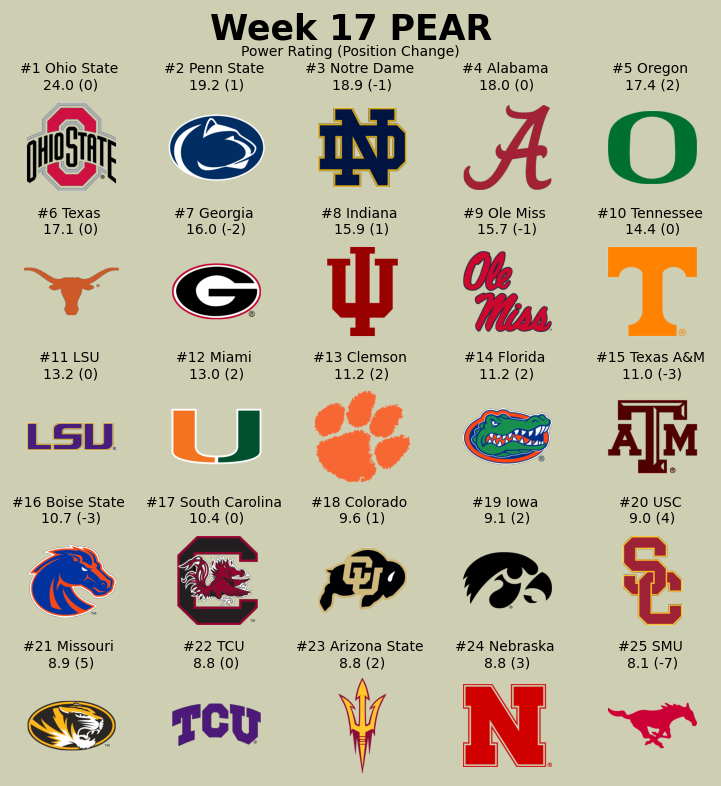

#C2B49A


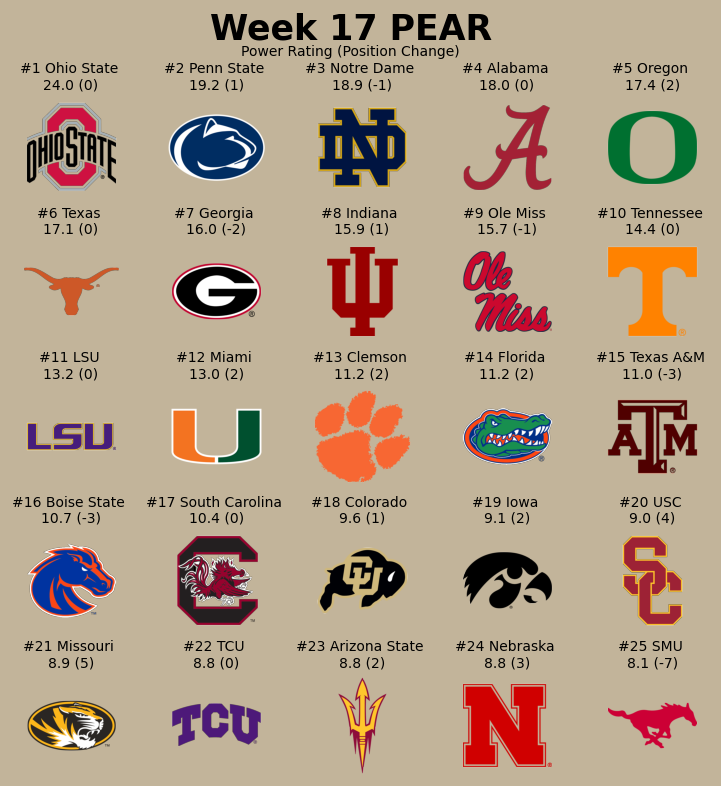

In [11]:
top_25 = all_data[:25]
last_week_data = pd.read_csv(f"./PEAR/Ratings/y{current_year}/PEAR_week{current_week-1}.csv")

colors = ["#CECEB2", "#C2B49A"]

for color in colors:
    print(color)
    fig, axs = plt.subplots(5, 5, figsize=(7, 7),dpi=125)
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    fig.patch.set_facecolor(color)
    plt.suptitle(f"Week {current_week} PEAR", fontsize=20, fontweight='bold', color='black')
    fig.text(0.5, 0.93, "Power Rating (Position Change)", fontsize=8, ha='center', color='black')

    for i, ax in enumerate(axs.ravel()):
        team = top_25.loc[i, 'team']
        logo_url = logos[logos['team'] == team]['logo'].values[0][0]
        response = requests.get(logo_url)
        img = Image.open(BytesIO(response.content))
        ax.imshow(img)
        ax.set_facecolor('#f0f0f0')
        power_rating = top_25.loc[i, 'power_rating']
        last_week_index = last_week_data[last_week_data['team'] == team].index[0]
        #  ({round(power_rating-last_week_pr, 1)}) <- shows change from last week. Currently irrelevant
        ax.set_title(f"#{i+1} {team} \n{round(power_rating,1)} ({round(last_week_index - i, 1)})", fontsize=8)
        ax.axis('off')
    plt.show()

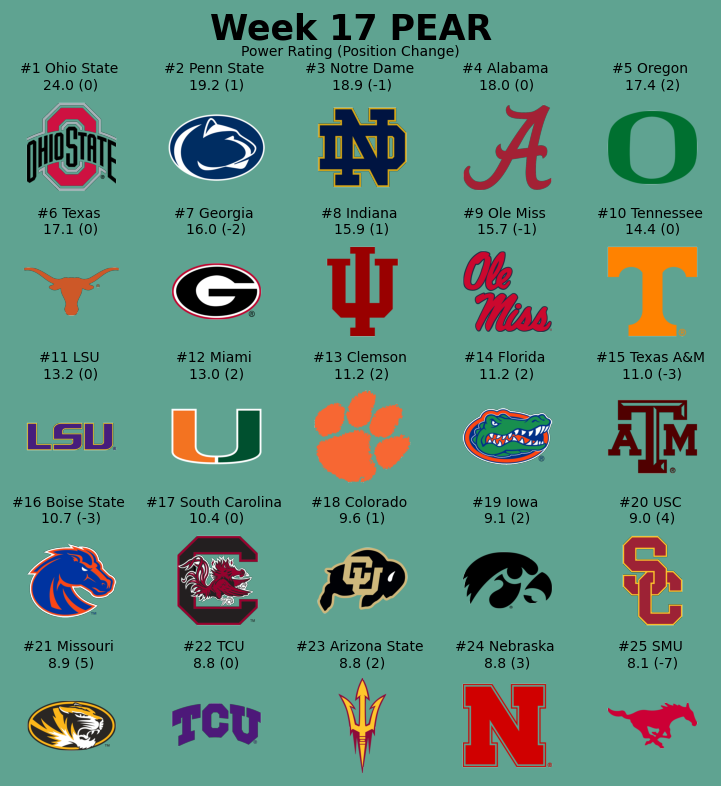

In [ ]:
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
top_25 = all_data[:25]
last_week_data = pd.read_csv(f"./PEAR/Ratings/y{current_year}/PEAR_week{current_week-1}.csv")

fig, axs = plt.subplots(5, 5, figsize=(7, 7),dpi=125)
fig.subplots_adjust(hspace=0.5, wspace=0.5)
fig.patch.set_facecolor('#CECEB2')
plt.suptitle(f"Week {current_week} PEAR", fontsize=20, fontweight='bold', color='black')
fig.text(0.5, 0.93, "Power Rating (Position Change)", fontsize=8, ha='center', color='black')

for i, ax in enumerate(axs.ravel()):
    team = top_25.loc[i, 'team']
    logo_url = logos[logos['team'] == team]['logo'].values[0][0]
    response = requests.get(logo_url)
    img = Image.open(BytesIO(response.content))
    ax.imshow(img)
    ax.set_facecolor('#f0f0f0')
    power_rating = top_25.loc[i, 'power_rating']
    last_week_index = last_week_data[last_week_data['team'] == team].index[0]
    #  ({round(power_rating-last_week_pr, 1)}) <- shows change from last week. Currently irrelevant
    ax.set_title(f"#{i+1} {team} \n{round(power_rating,1)} ({round(last_week_index - i, 1)})", fontsize=8)
    ax.axis('off')
plt.show()

### group of 5 Top 25

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\wpars\\OneDrive\\Documents\\Post-School\\Family Feud Data\\PEAR\\Visuals\\GO5 Top 25\\go5_top25_week17.png'

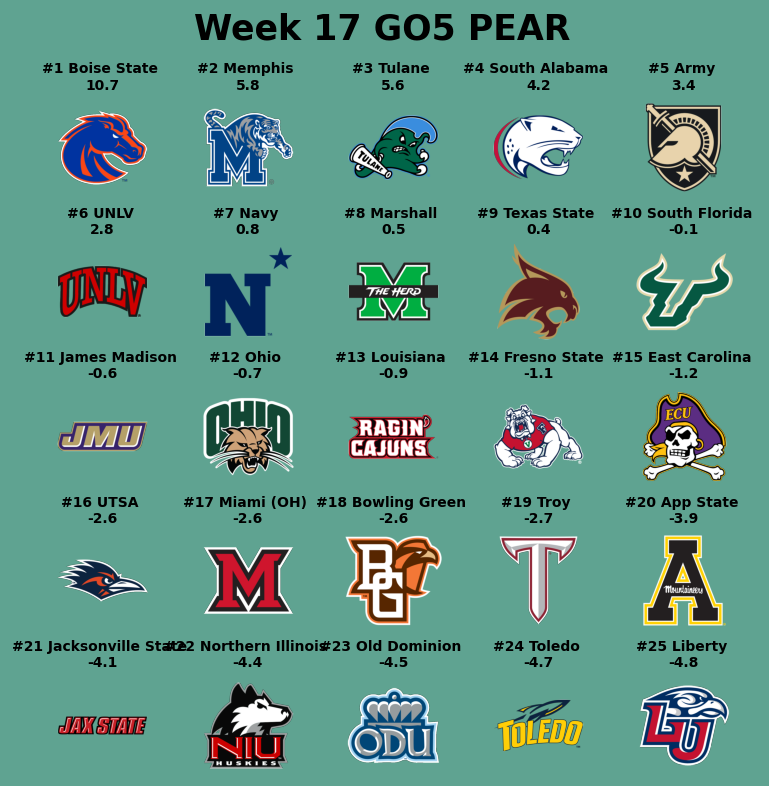

In [3]:
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO

group_of_5 = ['Conference USA', 'Mid-American', 'Sun Belt', 'American Athletic', 'Mountain West']
filtered_data = all_data[all_data['conference'].isin(group_of_5)]
top_25 = filtered_data.head(25).reset_index(drop=True)

fig, axs = plt.subplots(5, 5, figsize=(7, 7),dpi=125)
fig.subplots_adjust(hspace=0.5, wspace=0.5)
fig.patch.set_facecolor('#CECEB2')
plt.suptitle(f"Week {current_week} GO5 PEAR", fontsize=20, fontweight='bold', color='black')

for i, ax in enumerate(axs.ravel()):
    team = top_25.loc[i, 'team']
    logo_url = logos[logos['team'] == team]['logo'].values[0][0]
    response = requests.get(logo_url)
    img = Image.open(BytesIO(response.content))
    ax.imshow(img)
    ax.set_facecolor('#f0f0f0')
    ax.set_title(f"#{i+1} {team} \n{round(top_25.loc[i, 'power_rating'],1)}", fontsize=8, fontweight='bold')
    ax.axis('off')
plt.savefig(f"./PEAR/Visuals/GO5 Top 25/go5_top25_week{current_week}", bbox_inches='tight',dpi=300)
plt.show()

### all teams graphed

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
# Define the number of rows and columns
n_teams = len(all_data)
n_columns = (n_teams // 20) + (1 if n_teams % 20 != 0 else 0)

# Plot configuration
fig, axes = plt.subplots(nrows=20, ncols=n_columns, figsize=(20, 10),dpi=125)
plt.subplots_adjust(hspace=0.5)
fig.patch.set_facecolor('#CECEB2')
plt.suptitle(f'Week {current_week} PEAR. 0.0 is the average FBS team.', fontsize=14, y=0.92, x=0.55)

min_rating = all_data['power_rating'].min()
max_rating = all_data['power_rating'].max()
rating_range = max_rating-min_rating


cmap = LinearSegmentedColormap.from_list('dark_gradient_orange', ['#660000', '#8B0000', '#CC5500', '#2C5E00', '#1D4D00'], N=rating_range)

def get_color(value, vmin=min_rating, vmax=max_rating):
    norm_value = (value - vmin) / (vmax - vmin)  # Normalize the value between 0 and 1
    return cmap(norm_value)  # Get the color from the colormap

# Define a colormap from red to green
cmap = plt.get_cmap('RdYlGn')

def get_color(power_rating):
    """Return a color based on the power rating normalized to a range between 0 and 1."""
    norm_rating = (power_rating - min_rating) / (max_rating - min_rating)
    return cmap(norm_rating)

# Iterate through the data to plot
for idx, team in all_data.iterrows():
    power_rating = team['power_rating']
    team_name = team['team']
    logo_url = logos[logos['team'] == team_name]['logo'].values[0][0]
    row = idx % 20
    col = idx // 20
    
    ax = axes[row, col]
    ax.axis('off')  # Turn off the axis
    
    # Fetch the logo image from URL and display it
    response = requests.get(logo_url)
    img = Image.open(BytesIO(response.content))
    ax.imshow(img)

    # Get the color for the current power rating
    color = get_color(power_rating)

    text_ax = ax.inset_axes([0.2, 0.3, 0.75, 0.5])  # Move the text box to the right of the logo
    text_ax.axis('off')  # Turn off the text axis

    # Get the color for the current power rating
    color = get_color(power_rating)

    # Display the rank
    text_ax.text(-1.2, 0.5, f"#{idx + 1}", ha='center', va='center', fontsize=8, color='black', transform=text_ax.transAxes, fontweight='bold')

    # Display the team name to the right of the logo
    text_ax.text(1.5, 0.5, f"{team_name}", ha='left', va='center', fontsize=6, color='black', transform=text_ax.transAxes)

    # Display the power rating in a separate line with its color
    text_ax.text(6.5, 0.5, f"{power_rating:.2f}", ha='left', va='center', fontsize=8, color='black', transform=text_ax.transAxes, fontweight='bold')

    text_ax.text(9, 0.9, "|", ha='left', va='center', fontsize=14, color='black', transform=text_ax.transAxes, fontweight='bold')
    text_ax.text(9, -0.6, "|", ha='left', va='center', fontsize=14, color='black', transform=text_ax.transAxes, fontweight='bold')
    

if n_teams % 20 != 0:
    for empty_row in range(n_teams % 20, 20):
        axes[empty_row, n_columns - 1].axis('off')
plt.savefig(f'./PEAR/Visuals/Visual PR/team_pr_week{current_week}', bbox_inches='tight', dpi=500)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Fill in missing colors with black
all_data['color'] = all_data['color'].fillna('#000000')

# Calculate the average power rating
average_power_rating = all_data['power_rating'].mean()

plt.figure(figsize=(20, 10),dpi=125)
plt.bar(all_data['team'], all_data['power_rating'], color=all_data['color'])
plt.title('Team Power Ratings', fontsize=16, fontweight='bold', color='black')
plt.xlabel('Team', fontsize=12, color='black')
plt.ylabel('Power Rating', fontsize=12, color='black')
plt.gca().set_facecolor('#CECEB2')
plt.gcf().set_facecolor('#CECEB2')
plt.xticks(rotation=45, ha='right', fontsize=8, color='black')
plt.ylim(-25, 35)

# Add a horizontal line for the average power rating
plt.axhline(y=0, color='white', linestyle='--', linewidth=2, alpha=1)

# Add vertical lines every 25 teams
for i in range(25, len(all_data), 25):
    plt.axvline(x=i - 0.5, color='black', linestyle='--', linewidth=0.8, alpha=1)
plt.grid(False)

plt.tight_layout()
plt.savefig(f'./PEAR/Visuals/Visual PR/bar_chart_pr_week{current_week}', bbox_inches='tight', dpi=300)
plt.show()

### individual conference ratings

In [ ]:
import matplotlib.pyplot as plt 
import requests
from PIL import Image
from io import BytesIO
import math
import pandas as pd

# Set the current week
current_week = 6
conference_figures = []
# Loop through each unique conference and create a plot for all teams in that conference
unique_conferences = all_data['conference'].unique()

for conference in unique_conferences:
    # Filter all teams in the current conference
    conference_teams = all_data[all_data['conference'] == conference].reset_index(drop=True)
    num_teams = len(conference_teams)
    
    # Set up the figure with a fixed number of spaces (5 columns and 5 rows)
    cols = 5
    rows = 4  # Fixed number of rows to accommodate 25 spaces
    
    fig, axs = plt.subplots(rows, cols, figsize=(5, 5),dpi=125)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    fig.patch.set_facecolor('#CECEB2')  # Background color for the entire figure
    plt.suptitle(f"Week {current_week} PEAR - {conference}", fontsize=10, fontweight='bold', color='black')

    # Flatten the axes array
    axs = axs.ravel()

    # Plot each team's logo
    plot_index = 0  # Index for keeping track of where to plot
    for i in range(num_teams):
        
        ax = axs[plot_index]  # Get the next available axis for plotting
        
        # if conference_teams.loc[i, 'team'] == "Charlotte":
        #     # Set the background color from team_data['color']
        #     ax.set_facecolor(conference_teams.loc[i, 'color'] if pd.notna(conference_teams.loc[i, 'color']) else '#f0f0f0')
            
        #     # Set title as the team name with rank
        #     ax.set_title(f"#{plot_index + 1} {conference_teams.loc[i, 'team']}", fontsize=5, fontweight='bold')
        #     ax.axis('off')
            
        #     plot_index += 1  # Increment the plot index
        #     continue  # Skip "Charlotte"

        # Fetch team logo
        if conference_teams.loc[i, 'logo'] is not None:
            logo_url = logos[logos['team'] == conference_teams.loc[i, 'team']]['logo'].values[0][0]
            response = requests.get(logo_url)
            img = Image.open(BytesIO(response.content))
            ax.imshow(img)
        else:
            # Set the background color from team_data['color']
            ax.set_facecolor(conference_teams.loc[i, 'color'] if pd.notna(conference_teams.loc[i, 'color']) else '#f0f0f0')
        
            # Set title as the team name with rank
            ax.set_title(f"#{plot_index + 1} {conference_teams.loc[i, 'team']}", fontsize=5, fontweight='bold')
            ax.axis('off')
        
            plot_index += 1  # Increment the plot index
            ax.axis('off')  # Turn off axis if no logo available
            continue
        
        # Set the background color from team_data['color']
        ax.set_facecolor(conference_teams.loc[i, 'color'] if pd.notna(conference_teams.loc[i, 'color']) else '#f0f0f0')
        
        # Set title as the team name with rank
        ax.set_title(f"#{plot_index + 1} {conference_teams.loc[i, 'team']}", fontsize=5, fontweight='bold')
        ax.axis('off')
        
        plot_index += 1  # Increment the plot index

        # If we reach 25 spaces, we stop plotting
        if plot_index >= len(axs):
            break
    
    # Hide any remaining subplots that weren't used
    for j in range(plot_index, len(axs)):
        axs[j].axis('off')
    
    # Save the figure to the conference_figures list
    conference_figures.append(fig)

# Optional: Display all the figures at once (if needed)
for fig in conference_figures:
    plt.show(fig)

### conference average

In [ ]:
import matplotlib.pyplot as plt

conference_stats = all_data.groupby('conference')['power_rating'].agg(['mean', 'min', 'max']).reset_index()
conference_stats = conference_stats.sort_values(by='mean', ascending=False)

plt.figure(figsize=(8, 4), facecolor='#CECEB2',dpi=125)
bars = plt.bar(conference_stats['conference'], conference_stats['mean'], 
                color='#A74C54', 
                yerr=[conference_stats['mean'] - conference_stats['min'], 
                      conference_stats['max'] - conference_stats['mean']], 
                capsize=5)
ax = plt.gca()
ax.set_facecolor('#CECEB2')
for spine in ax.spines.values():
    spine.set_color('#CECEB2')  # Set the border color
    spine.set_linewidth(2)  # Adjust the border thickness if needed
ax.xaxis.set_tick_params(color='black')  # X-axis ticks
ax.yaxis.set_tick_params(color='black')  # Y-axis ticks
ax.spines['bottom'].set_color('black')  # Bottom spine
ax.spines['left'].set_color('black')  # Left spine
ax.spines['top'].set_color('none')  # Top spine
ax.spines['right'].set_color('none')  # Right spine

plt.axhline(y=0, color = 'black', linestyle='--')
plt.xlabel('Conference', fontsize=12, color='black')
plt.ylabel('Average Power Rating', fontsize=12, color='black')
plt.title('Average Power Rating by Conference', fontsize=14, fontweight='bold', color='black')
plt.xticks(rotation=45, ha='right', color='black', fontsize=8)
plt.yticks(color='black', fontsize=8)
plt.tight_layout()
plt.savefig(f"./PEAR/Visuals/Average Conference Rating/average_power_conference_week{current_week}.png")
plt.show()

### all conferences on one viz

In [ ]:
import matplotlib.pyplot as plt 
import requests
from PIL import Image
from io import BytesIO
import math
import pandas as pd
import matplotlib.pyplot as plt 
import requests
from PIL import Image
from io import BytesIO
import pandas as pd

# Loop through each unique conference and create a plot for all teams in that conference
unique_conferences = all_data['conference'].unique()
conference_figures = []  # List to store figures

for conference in unique_conferences:
    # Filter all teams in the current conference
    conference_teams = all_data[all_data['conference'] == conference].reset_index(drop=True)
    num_teams = len(conference_teams)
    
    # Set up the figure with a larger size and fewer rows/columns
    cols = 4  # Adjusted number of columns
    rows = math.ceil(num_teams / cols)  # Calculate rows based on number of teams

    # Increase figure size
    fig, axs = plt.subplots(rows, cols, figsize=(12, 10),dpi=125)  # Adjusted figure size
    fig.subplots_adjust(hspace=0.4, wspace=0.4)  # Adjusted spacing
    fig.patch.set_facecolor('#CECEB2')  # Background color for the entire figure
    plt.suptitle(f"Week {current_week} PEAR - {conference}", fontsize=25, fontweight='bold', color='black')

    # Flatten the axes array
    axs = axs.ravel()

    # Plot each team's logo
    plot_index = 0  # Index for keeping track of where to plot
    for i in range(num_teams):
        
        ax = axs[plot_index]  # Get the next available axis for plotting
        
        # if conference_teams.loc[i, 'team'] == "Charlotte":
        #     # Set the background color from team_data['color']
        #     ax.set_facecolor(conference_teams.loc[i, 'color'] if pd.notna(conference_teams.loc[i, 'color']) else '#f0f0f0')
            
        #     # Set title as the team name with rank
        #     ax.set_title(f"#{plot_index + 1} {conference_teams.loc[i, 'team']}", fontsize=16, fontweight='bold')
        #     ax.axis('off')
            
        #     plot_index += 1  # Increment the plot index
        #     continue  # Skip "Charlotte"

        # Fetch team logo
        if conference_teams.loc[i, 'logo'] is not None:
            logo_url = logos[logos['team'] == conference_teams.loc[i, 'team']]['logo'].values[0][0]
            response = requests.get(logo_url)
            img = Image.open(BytesIO(response.content))
            ax.imshow(img)
        else:
            # Set the background color from team_data['color']
            ax.set_facecolor(conference_teams.loc[i, 'color'] if pd.notna(conference_teams.loc[i, 'color']) else '#f0f0f0')
        
            # Set title as the team name with rank
            ax.set_title(f"#{plot_index + 1} {conference_teams.loc[i, 'team']}", fontsize=16, fontweight='bold')
            ax.axis('off')
        
            plot_index += 1  # Increment the plot index
            ax.axis('off')  # Turn off axis if no logo available
            continue
        
        # Set the background color from team_data['color']
        ax.set_facecolor(conference_teams.loc[i, 'color'] if pd.notna(conference_teams.loc[i, 'color']) else '#f0f0f0')
        
        # Set title as the team name with rank
        ax.set_title(f"#{plot_index + 1} {conference_teams.loc[i, 'team']}", fontsize=16, fontweight='bold')
        ax.axis('off')
        
        plot_index += 1  # Increment the plot index

        # If we reach the maximum number of plots, we stop plotting
        if plot_index >= len(axs):
            break
    
    # Hide any remaining subplots that weren't used
    for j in range(plot_index, len(axs)):
        axs[j].axis('off')
    
    # Save the plot for this conference to the list
    conference_figures.append(fig)

import matplotlib.pyplot as plt
import os
from PIL import Image

# Create a list to hold the paths of saved images
image_paths = []

# Save each conference figure to a temporary image
for idx, conf_fig in enumerate(conference_figures):
    temp_image_path = f"temp_conference_fig_{idx}.png"
    conf_fig.savefig(temp_image_path, bbox_inches='tight', dpi=300)
    image_paths.append(temp_image_path)

# Determine the number of figures
num_figures = len(image_paths)

# Define the number of rows and columns for the new display figure
cols = 3  # Number of columns you want
rows = (num_figures + cols - 1) // cols  # Calculate number of rows needed

# Create a new figure for displaying all conference figures
display_fig, display_axs = plt.subplots(rows, cols, figsize=(10, 3 * rows))
display_fig.subplots_adjust(hspace=0.1, wspace=0.1)
display_fig.patch.set_facecolor('#CECEB2') 

# Flatten the axes array for easier indexing
display_axs = display_axs.ravel()

# Loop through each image path and display it in the display axes
for i in range(num_figures):
    ax = display_axs[i]  # Get the corresponding subplot axis
    img = Image.open(image_paths[i])  # Open the saved image
    ax.imshow(img)  # Display the image
    ax.axis('off')  # Turn off the axis

# Hide any remaining subplots that weren't used
for j in range(num_figures, len(display_axs)):
    display_axs[j].axis('off')

# Show the final display figure
display_fig.savefig(f'./PEAR/Visuals/Conference Ratings/conference_ratings_week{current_week}.png', bbox_inches='tight', dpi=300)
plt.show(display_fig)

# Optional: Clean up the temporary images after displaying
for image_path in image_paths:
    os.remove(image_path)  # Delete the temporary image files


### Playoff Projection

In [39]:
conference_list = ['SEC', 'Big Ten', 'Big 12', 'ACC', 'Pac-12', 'Conference USA', 'Mid-American', 'Sun Belt', 'American Athletic', 'Mountain West']
top_4_seeds = all_data[all_data['conference'].isin(conference_list)].groupby('conference').first().sort_values('power_rating', ascending=False).reset_index()[0:4]
autobid_5 = all_data[all_data['conference'].isin(conference_list)].groupby('conference').first().sort_values('power_rating', ascending=False).reset_index()[4:5]
excluded_teams = list(top_4_seeds['team']) + list(autobid_5['team'])
at_large_bids = all_data[~all_data['team'].isin(excluded_teams)].head(7).reset_index(drop=True)
at_large_bids = pd.concat([at_large_bids, autobid_5]).reset_index(drop=True)

In [40]:
# Creating a dictionary for at_large_bids starting from seed 5
at_large_dict = {i + 5: team for i, team in enumerate(at_large_bids['team'])}
power_5_dict = {i + 1: team for i, team in enumerate(top_4_seeds['team'])}
seeding = {**power_5_dict, **at_large_dict}

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Function to fetch the logo image for a team
def fetch_logo_image(logo_url):
    import requests
    from PIL import Image
    from io import BytesIO

    response = requests.get(logo_url)
    img = Image.open(BytesIO(response.content))
    return img

def draw_playoff_bracket(seeding, team_data):
    fig, ax = plt.subplots(figsize=(12, 12),dpi=125)
    
    # Round 1 matchups and byes for teams 1-4
    first_round_matchups = [
        (8, 9), (5, 12), (7, 10), (6, 11) 
    ]
    
    # Mapping teams to their matchup in round 1
    matchups_text = [
        f"#{match[0]} {seeding[match[0]]} vs #{match[1]} {seeding[match[1]]}" for match in first_round_matchups
    ]
    
    # Round 2 (quarterfinals): top seeds (1-4) vs winners of round 1
    top_seeds = [1, 4, 3, 2]

    # Positions for round 1 (y coordinates for matches)
    y_round_1 = [0.90, 0.65, 0.4, 0.15]
    
    # Positions for round 2 (y coordinates for top 4 seeds)
    y_round_2 = [0.90, 0.65, 0.4, 0.15]

    top_seed_locations = [0.8, 0.55, 0.3, 0.05]
    
    # Adding matchups from the first round
    for i, (y, text) in enumerate(zip(y_round_1, matchups_text)):
        ax.text(0.05, y+0.05, text, fontsize=10, verticalalignment='center')
        # Fetch logos for both teams in the matchup from team_data
        team1_logo_url = logos[logos['team'] == seeding[first_round_matchups[i][0]]]['logo'].values[0][0]
        team2_logo_url = logos[logos['team'] == seeding[first_round_matchups[i][1]]]['logo'].values[0][0]
        
        # Display team 1 logo
        team1_logo = fetch_logo_image(team1_logo_url)
        imagebox1 = OffsetImage(team1_logo, zoom=0.1)
        ab1 = AnnotationBbox(imagebox1, (0.1, y), frameon=False)
        ax.add_artist(ab1)
        
        # Display team 2 logo
        team2_logo = fetch_logo_image(team2_logo_url)
        imagebox2 = OffsetImage(team2_logo, zoom=0.1)
        ab2 = AnnotationBbox(imagebox2, (0.2, y), frameon=False)
        ax.add_artist(ab2)

    # Adding the top 4 seeds (bye teams)
    for i, seed in enumerate(top_seeds):
        # Fetch and display logo for the top seed (bye team)
        ax.text(0.25, top_seed_locations[i]+0.05, f"#{seed} {seeding[seed]}", fontsize=10, verticalalignment='center')
        bye_team_logo_url = logos[logos['team'] == seeding[seed]]['logo'].values[0][0]
        bye_team_logo = fetch_logo_image(bye_team_logo_url)
        imagebox_bye = OffsetImage(bye_team_logo, zoom=0.1)
        ab_bye = AnnotationBbox(imagebox_bye, (0.3, top_seed_locations[i]), frameon=False)
        ax.add_artist(ab_bye)
    
    # Drawing lines connecting round 1 winners to the top 4 seeds
    for i in range(4):
        ax.add_patch(patches.ConnectionPatch((0.15, y_round_1[i]-0.05), (0.15, top_seed_locations[i]), 'data', 'data', arrowstyle="-"))
        ax.add_patch(patches.ConnectionPatch((0.15, top_seed_locations[i]), (0.25, top_seed_locations[i]), 'data', 'data', arrowstyle="-"))
        ax.add_patch(patches.ConnectionPatch((0.35, top_seed_locations[i]), (0.5, top_seed_locations[i]), 'data', 'data', arrowstyle='-'))
        

    ax.add_patch(patches.ConnectionPatch((0.5, top_seed_locations[0]), (0.5, top_seed_locations[1]), 'data', 'data', arrowstyle='-'))
    ax.add_patch(patches.ConnectionPatch((0.5, top_seed_locations[2]), (0.5, top_seed_locations[3]), 'data', 'data', arrowstyle='-'))
    ax.add_patch(patches.ConnectionPatch((0.5, (top_seed_locations[0]+top_seed_locations[1])/2), (0.7, (top_seed_locations[0]+top_seed_locations[1])/2), 'data', 'data', arrowstyle='-'))
    ax.add_patch(patches.ConnectionPatch((0.5, (top_seed_locations[2]+top_seed_locations[3])/2), (0.7, (top_seed_locations[2]+top_seed_locations[3])/2), 'data', 'data', arrowstyle='-'))
    ax.add_patch(patches.ConnectionPatch((0.7, (top_seed_locations[0]+top_seed_locations[1])/2), (0.7, (top_seed_locations[2]+top_seed_locations[3])/2), 'data', 'data', arrowstyle='-'))
    ax.add_patch(patches.ConnectionPatch((0.7, (top_seed_locations[1]+top_seed_locations[2])/2), (0.9, (top_seed_locations[1]+top_seed_locations[2])/2), 'data', 'data', arrowstyle='-'))


    # Final formatting
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    plt.gca().set_facecolor('#CECEB2')
    plt.gcf().set_facecolor('#CECEB2')
    plt.title("Projected Playoff Bracket", fontweight='bold', fontsize=20)
    plt.savefig(f"./PEAR/Visuals/Projected Playoff/projected_playoff_week{current_week}.png")
    plt.show()

# Assuming team_data is a DataFrame with columns ['team', 'logo'], where 'logo' is the URL to each team's logo
draw_playoff_bracket(seeding, team_data)


### Turnovers

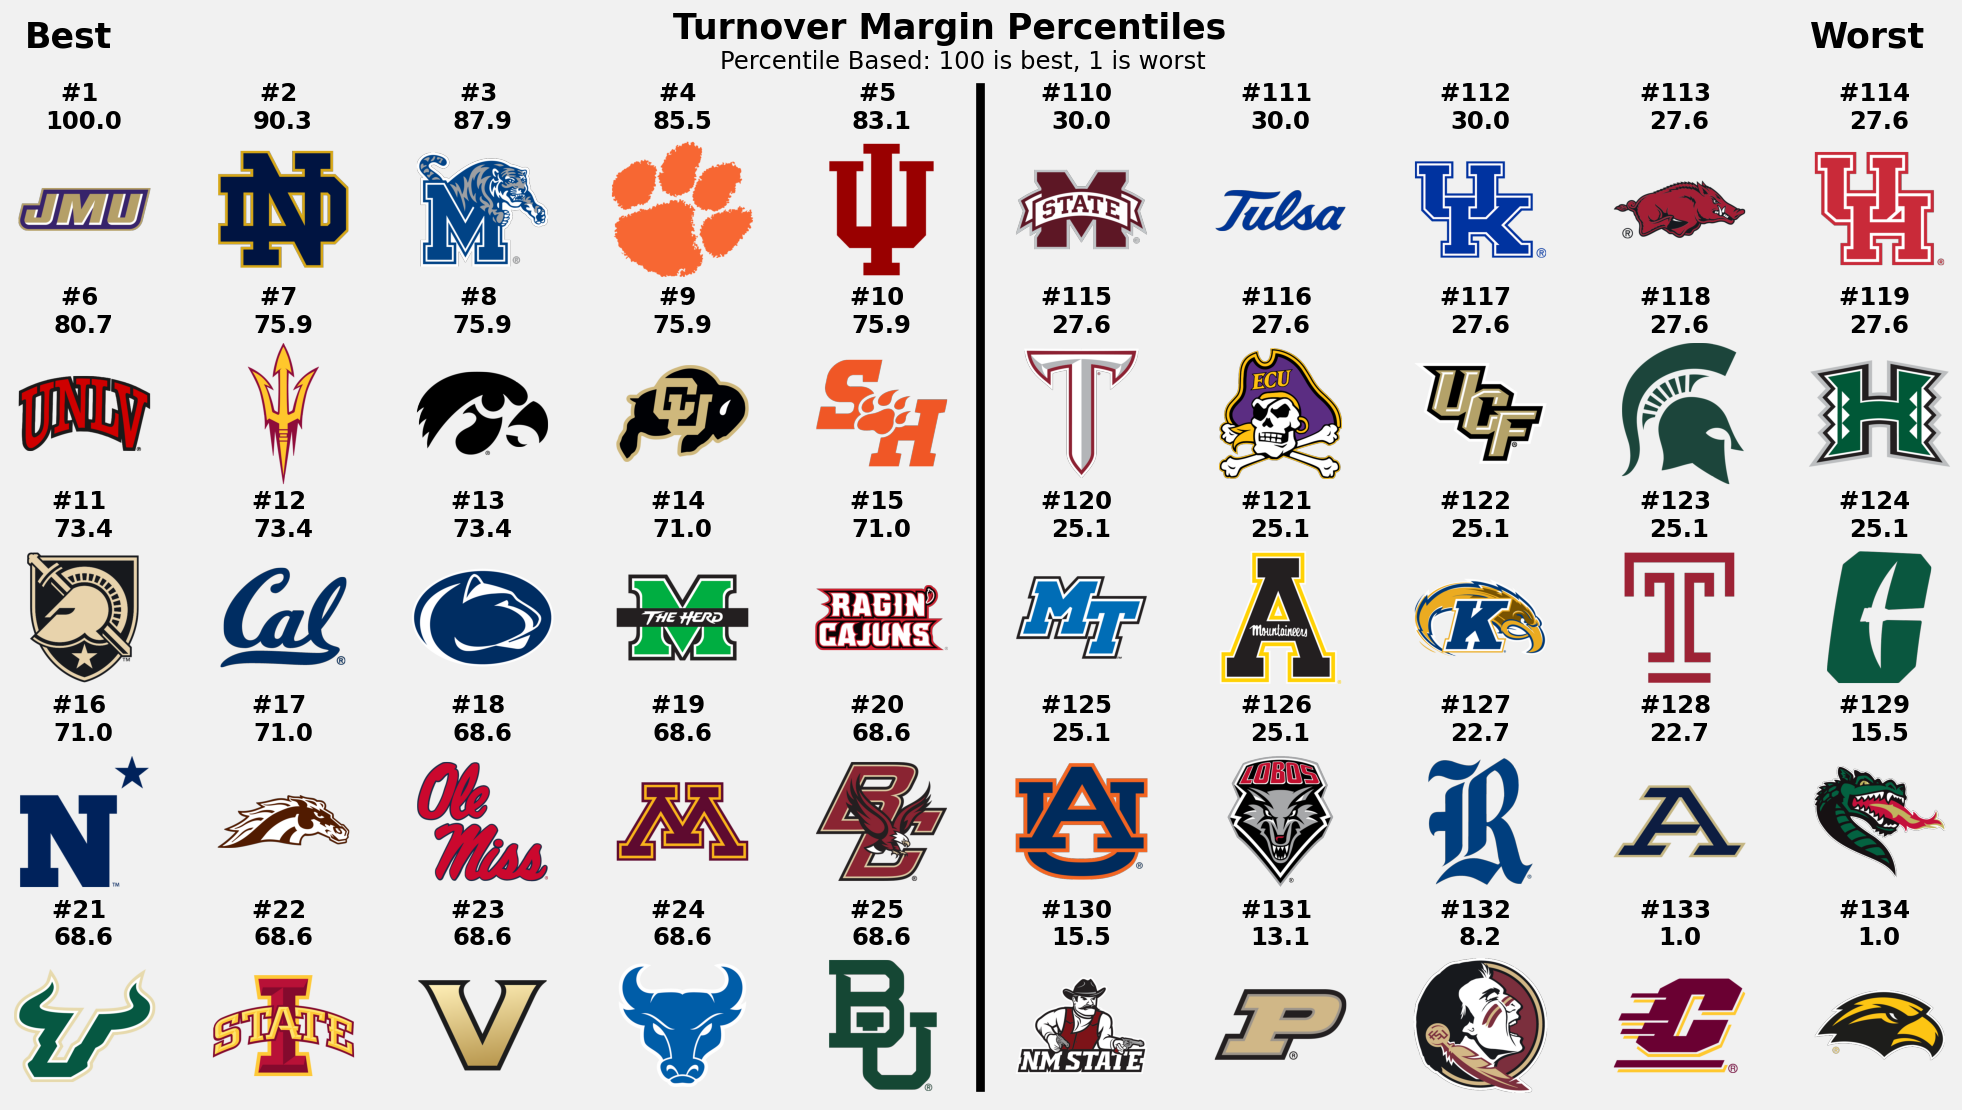

In [24]:
best_and_worst(all_data, logos, 'total_turnovers_scaled', "Turnover Margin Percentiles", "Percentile Based: 100 is best, 1 is worst")

### Best Offenses

In [ ]:
scaler100 = MinMaxScaler(feature_range=(1, 100))
all_data['offensive_total'] = scaler100.fit_transform(all_data[['offensive_total']])

best_and_worst(all_data, logos, 'offensive_total', "PEAR Raw Offenses: Best and Worst 25", "Percentile Based: 100 is best, 1 is worst")

### Best Defenses

In [ ]:
scaler100 = MinMaxScaler(feature_range=(1, 100))
all_data['defensive_total'] = scaler100.fit_transform(all_data[['defensive_total']])
top_25 = all_data.sort_values('defensive_total', ascending=False)[:25].reset_index(drop=True)
bottom_25 = all_data.sort_values('defensive_total', ascending=False)[-25:].reset_index(drop=True)

# Create figure and axes for two plots (top 25 on the left, bottom 25 on the right)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), dpi=125)
fig.patch.set_facecolor('#CECEB2')  # Set figure background color
ax1.set_facecolor('#CECEB2')  # Set background color for the left plot
ax2.set_facecolor('#CECEB2')  # Set background color for the right plot

# Title and description
fig.suptitle("PEAR Raw Defenses: Top and Bottom 25", fontsize=20, fontweight='bold', color='black')
plot_bar_charts(ax1, top_25, logos, 'defensive_total', "Top 25 Raw Defenses", 'Top')
plot_bar_charts(ax2, bottom_25, logos, 'defensive_total', "Bottom 25 Raw Defenses", 'Bottom')
plt.show()

In [ ]:
scaler100 = MinMaxScaler(feature_range=(1, 100))
all_data['defensive_total'] = scaler100.fit_transform(all_data[['defensive_total']])

best_and_worst(all_data, logos, 'defensive_total', "PEAR Raw Defenses: Best and Worst 25", "100 is the best raw defense, 1 is the worst")

### Offense vs. Defense

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from io import BytesIO
import requests
configuration = cfbd.Configuration()
configuration.api_key['Authorization'] = '7vGedNNOrnl0NGcSvt92FcVahY602p7IroVBlCA1Tt+WI/dCwtT7Gj5VzmaHrrxS'
configuration.api_key_prefix['Authorization'] = 'Bearer'
api_client = cfbd.ApiClient(configuration)
advanced_instance = cfbd.StatsApi(api_client)
games_api = cfbd.GamesApi(api_client)
betting_api = cfbd.BettingApi(api_client)
ratings_api = cfbd.RatingsApi(api_client)
teams_api = cfbd.TeamsApi(api_client)
metrics_api = cfbd.MetricsApi(api_client)
players_api = cfbd.PlayersApi(api_client)
recruiting_api = cfbd.RecruitingApi(api_client)

logos_info_list = []
response = teams_api.get_teams()
logos_info_list = [*logos_info_list, *response]
logos_info_dict = [dict(
    team = l.school,
    color = l.color,
    alt_color = l.alt_color,
    logo = l.logos
) for l in logos_info_list]
logos = pd.DataFrame(logos_info_dict)
logos = logos.dropna(subset=['logo', 'color'])
all_data = pd.read_csv(f"./PEAR/Data/y{current_year}/team_data_week{current_week}.csv")
scaler100 = MinMaxScaler(feature_range=(1, 100))
all_data['offensive_total'] = scaler100.fit_transform(all_data[['offensive_total']])
all_data['offensive_total'] = all_data['offensive_total'] - all_data['offensive_total'].mean()
all_data['defensive_total'] = scaler100.fit_transform(all_data[['defensive_total']])
all_data['defensive_total'] = all_data['defensive_total'] - all_data['defensive_total'].mean()

# Create the plot
fig, ax = plt.subplots(figsize=(15, 9),dpi=125)
plt.gca().set_facecolor('#CECEB2')
plt.gcf().set_facecolor('#CECEB2')
# Set the size of the logos (adjust the numbers to make logos smaller or larger)
logo_size = 2  # Half the size of the logo to create spacing

# Loop through the team_data DataFrame to plot logos
for i in range(len(all_data)):
    # Get the logo image from the URL
    logo_url = logos[logos['team'] == all_data.loc[i,'team']]['logo'].values[0][0]
    response = requests.get(logo_url)
    img = mpimg.imread(BytesIO(response.content), format='png')

    # Calculate the extent for the logo
    # Here we use logo_size for both sides to center the logo at the specific coordinates
    ax.imshow(img, aspect='auto', 
              extent=(all_data['defensive_total'].iloc[i] - (logo_size-0.5),
                      all_data['defensive_total'].iloc[i] + (logo_size-0.5),
                      all_data['offensive_total'].iloc[i] - logo_size,
                      all_data['offensive_total'].iloc[i] + logo_size))

# Set axis labels
ax.set_xlabel('Total Defense')
ax.set_ylabel('Total Offense')
ax.set_title('Team Offense vs Defense', fontweight='bold', fontsize=14)

# Show the plot
plt.xlim(all_data['defensive_total'].min() - 5, all_data['defensive_total'].max() + 5)  # Adjust x-axis limits for visibility
plt.ylim(all_data['offensive_total'].min() - 5, all_data['offensive_total'].max() + 5)  # Adjust y-axis limits for visibility
plt.grid(False)  # Turn off the grid
plt.axhline(0, linestyle='--', color='black', alpha = 0.3)
plt.axvline(0, linestyle='--', color='black', alpha = 0.3)
plt.text(45, 50, "Good Offense, Good Defense", fontsize=10, fontweight='bold', ha='center')
plt.text(-30, 50, "Good Offense, Bad Defense", fontsize=10, fontweight='bold', ha='center')
plt.text(45, -50, "Bad Offense, Good Defense", fontsize=10, fontweight='bold', ha='center')
plt.text(-30, -50, "Bad Offense, Bad Defense", fontsize=10, fontweight='bold', ha='center')
plt.figure(dpi=500)
plt.show()

### Special Teams

In [ ]:
scaler100 = MinMaxScaler(feature_range=(1, 100))
all_data['STM_scaled'] = scaler100.fit_transform(all_data[['STM']])

best_and_worst(all_data, logos, 'STM_scaled', "PEAR Special Teams", "Percentile Based: 100 is best, 1 is worst")

### Penalty Burden Ratio

In [ ]:
pbr_min = all_data['PBR'].min()
pbr_max = all_data['PBR'].max()
all_data['PBR_scaled'] = 100 - (all_data['PBR'] - pbr_min) * (99 / (pbr_max - pbr_min))

best_and_worst(all_data, logos, 'PBR_scaled', "PEAR Penalty Burden Ratio", "How Penalties Impact Success - 100 is best, 1 is worst")

### Drive Control Efficiency

In [ ]:
scaler100 = MinMaxScaler(feature_range=(1, 100))
all_data['DCE_scaled'] = scaler100.fit_transform(all_data[['DCE']])

best_and_worst(all_data, logos, 'DCE_scaled', "PEAR Drive Control Efficiency", "How Well You Control the Ball - 100 is best, 1 is worst")

### Drive Disruption Efficiency

In [ ]:
scaler100 = MinMaxScaler(feature_range=(1, 100))
all_data['DDE_scaled'] = scaler100.fit_transform(all_data[['DDE']])

best_and_worst(all_data, logos, 'DDE_scaled', "PEAR Drive Disruption Efficiency", "How Well You Disrupt the Offense - 100 is best, 1 is worst")

### DCE vs. DDE

In [ ]:
import pandas as pd
import cfbd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from io import BytesIO
import requests
from sklearn.preprocessing import MinMaxScaler
configuration = cfbd.Configuration()
configuration.api_key['Authorization'] = '7vGedNNOrnl0NGcSvt92FcVahY602p7IroVBlCA1Tt+WI/dCwtT7Gj5VzmaHrrxS'
configuration.api_key_prefix['Authorization'] = 'Bearer'
api_client = cfbd.ApiClient(configuration)
advanced_instance = cfbd.StatsApi(api_client)
games_api = cfbd.GamesApi(api_client)
betting_api = cfbd.BettingApi(api_client)
ratings_api = cfbd.RatingsApi(api_client)
teams_api = cfbd.TeamsApi(api_client)
metrics_api = cfbd.MetricsApi(api_client)
players_api = cfbd.PlayersApi(api_client)
recruiting_api = cfbd.RecruitingApi(api_client)

logos_info_list = []
response = teams_api.get_teams()
logos_info_list = [*logos_info_list, *response]
logos_info_dict = [dict(
    team = l.school,
    color = l.color,
    alt_color = l.alt_color,
    logo = l.logos
) for l in logos_info_list]
logos = pd.DataFrame(logos_info_dict)
logos = logos.dropna(subset=['logo', 'color'])
all_data = pd.read_csv(f"./PEAR/Data/y{current_year}/team_data_week{current_week}.csv")
scaler100 = MinMaxScaler(feature_range=(1, 100))
all_data['DCE'] = scaler100.fit_transform(all_data[['DCE']])
all_data['DCE'] = all_data['DCE'] - all_data['DCE'].mean()
all_data['DDE'] = scaler100.fit_transform(all_data[['DDE']])
all_data['DDE'] = all_data['DDE'] - all_data['DDE'].mean()

# Create the plot
fig, ax = plt.subplots(figsize=(15, 9),dpi=125)
plt.gca().set_facecolor('#CECEB2')
plt.gcf().set_facecolor('#CECEB2')
# Set the size of the logos (adjust the numbers to make logos smaller or larger)
logo_size = 2  # Half the size of the logo to create spacing

# Loop through the team_data DataFrame to plot logos
for i in range(len(all_data)):
    # Get the logo image from the URL
    logo_url = logos[logos['team'] == all_data.loc[i,'team']]['logo'].values[0][0]
    response = requests.get(logo_url)
    img = mpimg.imread(BytesIO(response.content), format='png')

    # Calculate the extent for the logo
    # Here we use logo_size for both sides to center the logo at the specific coordinates
    ax.imshow(img, aspect='auto', 
              extent=(all_data['DDE'].iloc[i] - (logo_size-0.5),
                      all_data['DDE'].iloc[i] + (logo_size-0.5),
                      all_data['DCE'].iloc[i] - logo_size,
                      all_data['DCE'].iloc[i] + logo_size))

# Set axis labels
ax.set_xlabel('Drive Disruption Efficiency')
ax.set_ylabel('Drive Control Efficiency')
ax.set_title('DCE vs. DDE', fontweight='bold', fontsize=14)

# Show the plot
plt.xlim(all_data['DDE'].min() - 5, all_data['DDE'].max() + 5)  # Adjust x-axis limits for visibility
plt.ylim(all_data['DCE'].min() - 5, all_data['DCE'].max() + 5)  # Adjust y-axis limits for visibility
plt.grid(False)  # Turn off the grid
plt.axhline(0, linestyle='--', color='black', alpha = 0.3)
plt.axvline(0, linestyle='--', color='black', alpha = 0.3)
plt.text(45, 50, "Good DCE, Good DDE", fontsize=10, fontweight='bold', ha='center')
plt.text(-30, 50, "Good DCE, Bad DDE", fontsize=10, fontweight='bold', ha='center')
plt.text(45, -50, "Bad DCE, Good DDE", fontsize=10, fontweight='bold', ha='center')
plt.text(-30, -50, "Bad DCE, Bad DDE", fontsize=10, fontweight='bold', ha='center')
plt.figure(dpi=500)
plt.show()

### Average Metric Rank

In [ ]:
columns_to_average = ["offensive_rank", "defensive_rank", "STM_rank", "PBR_rank", "DCE_rank", "DDE_rank"]
all_data["average_metric_rank"] = round(all_data[columns_to_average].mean(axis=1),1)
best_and_worst(all_data, logos, 'average_metric_rank', "PEAR Average Metric Ranking", "Average OFF, DEF, ST, PBR, DCE, DDE Ranking - Lower is Better")

### Resume vs Ratings

In [ ]:
# Create the plot
fig, ax = plt.subplots(figsize=(15, 9),dpi=125)
plt.gca().set_facecolor('#CECEB2')
plt.gcf().set_facecolor('#CECEB2')
# Set the size of the logos (adjust the numbers to make logos smaller or larger)
logo_size = 0.9  # Half the size of the logo to create spacing
# Loop through the team_data DataFrame to plot logos
for i in range(len(all_data)):
    # Get the logo image from the URL
    logo_url = logos[logos['team'] == all_data.loc[i,'team']]['logo'].values[0][0]
    response = requests.get(logo_url)
    img = mpimg.imread(BytesIO(response.content), format='png')

    # Calculate the extent for the logo
    # Here we use logo_size for both sides to center the logo at the specific coordinates
    ax.imshow(img, aspect='auto', 
              extent=(all_data['most_deserving_wins'].iloc[i] - (logo_size-0.7),
                      all_data['most_deserving_wins'].iloc[i] + (logo_size-0.7),
                      all_data['power_rating'].iloc[i] - logo_size,
                      all_data['power_rating'].iloc[i] + logo_size))

# Set axis labels
ax.set_xlabel('Resume (Record Strength)', fontweight='bold')
ax.set_ylabel('Ratings (Team Strength)', fontweight='bold')
ax.set_title('Resume vs. Ratings', fontweight='bold', fontsize=14)

# Show the plot
plt.xlim(all_data['most_deserving_wins'].min() - 1, all_data['most_deserving_wins'].max() + 1)  # Adjust x-axis limits for visibility
plt.ylim(all_data['power_rating'].min() - 3, all_data['power_rating'].max() + 3)  # Adjust y-axis limits for visibility
plt.grid(False)  # Turn off the grid

elite_team_pr = all_data['power_rating'].mean() + (2*all_data['power_rating'].std())
elite_team_resume = all_data['most_deserving_wins'].mean() + (2*all_data['most_deserving_wins'].std())
good_team_pr = all_data['power_rating'].mean() + (1*all_data['power_rating'].std())
good_team_resume = all_data['most_deserving_wins'].mean() + (1*all_data['most_deserving_wins'].std())
avg_team_pr = all_data['power_rating'].mean() + (0*all_data['power_rating'].std())
avg_team_resume = all_data['most_deserving_wins'].mean() + (0*all_data['most_deserving_wins'].std())
below_avg_team_pr = all_data['power_rating'].mean() + (-1*all_data['power_rating'].std())
below_avg_team_resume = all_data['most_deserving_wins'].mean() + (-1*all_data['most_deserving_wins'].std())


# Get the data ranges for normalization
x_min, x_max = all_data['most_deserving_wins'].min()-1, all_data['most_deserving_wins'].max()+1
y_min, y_max = all_data['power_rating'].min()-3, all_data['power_rating'].max()+3
plt.plot([elite_team_resume, x_max], [elite_team_pr, elite_team_pr], linestyle='--', color='darkgreen', alpha=0.6)  # Horizontal line
plt.plot([elite_team_resume, elite_team_resume], [elite_team_pr, y_max], linestyle='--', color='darkgreen', alpha=0.6)  # Vertical line
plt.plot([good_team_resume, x_max], [good_team_pr, good_team_pr], linestyle='--', color='yellow', alpha=0.6)  # Horizontal line
plt.plot([good_team_resume, good_team_resume], [good_team_pr, y_max], linestyle='--', color='yellow', alpha=0.6)  # Vertical line
# plt.plot([avg_team_resume, x_max], [avg_team_pr, avg_team_pr], linestyle='--', color='black', alpha=0.6)  # Horizontal line
# plt.plot([avg_team_resume, avg_team_resume], [avg_team_pr, y_max], linestyle='--', color='black', alpha=0.6)  # Vertical line
# plt.plot([below_avg_team_resume, x_max], [below_avg_team_pr, below_avg_team_pr], linestyle='--', color='red', alpha=0.6)  # Horizontal line
# plt.plot([below_avg_team_resume, below_avg_team_resume], [below_avg_team_pr, y_max], linestyle='--', color='red', alpha=0.6)  # Vertical line
plt.figure(dpi=500)
plt.tight_layout()
plt.show()

### Talent vs. Production

In [ ]:
fig, ax = plt.subplots(figsize=(15, 9),dpi=125)
plt.gca().set_facecolor('#CECEB2')
plt.gcf().set_facecolor('#CECEB2')
# Set the size of the logos (adjust the numbers to make logos smaller or larger)
logo_size = 2  # Half the size of the logo to create spacing
# Loop through the team_data DataFrame to plot logos
scaler100 = MinMaxScaler(feature_range=(1, 100))
all_data['most_deserving_scaled'] = scaler100.fit_transform(all_data[['most_deserving_wins']])
for i in range(len(all_data)):
    # Get the logo image from the URL
    logo_url = logos[logos['team'] == all_data.loc[i,'team']]['logo'].values[0][0]
    response = requests.get(logo_url)
    img = mpimg.imread(BytesIO(response.content), format='png')

    # Calculate the extent for the logo
    # Here we use logo_size for both sides to center the logo at the specific coordinates
    ax.imshow(img, aspect='auto', 
              extent=(all_data['avg_talent'].iloc[i] - (logo_size-0.5),
                      all_data['avg_talent'].iloc[i] + (logo_size-0.5),
                      all_data['most_deserving_scaled'].iloc[i] - logo_size,
                      all_data['most_deserving_scaled'].iloc[i] + logo_size))

ax.plot(
    [all_data['avg_talent'].min()-3, all_data['avg_talent'].max()+3],
    [all_data['avg_talent'].min()-3, all_data['avg_talent'].max()+3],
    color='black', linestyle='--'
)

# Set axis labels
ax.set_xlabel('Talent Percentile', fontweight='bold')
ax.set_ylabel('Resume Percentile', fontweight='bold')
ax.set_title('Production vs. Talent', fontweight='bold', fontsize=14)

# Show the plot
plt.xlim(all_data['avg_talent'].min() - 3, all_data['avg_talent'].max() + 3)  # Adjust x-axis limits for visibility
plt.ylim(all_data['most_deserving_scaled'].min() - 3, all_data['most_deserving_scaled'].max() + 3)  # Adjust y-axis limits for visibility
plt.grid(False)  # Turn off the grid

plt.text(1, 98, "Production Outperforming Talent", fontsize=10, fontweight='bold', ha='left')
plt.text(100, 2, "Production Underperforming Talent", fontsize=10, fontweight='bold', ha='right')

plt.figure(dpi=500)
plt.tight_layout()
plt.show()

### Talent Production

In [ ]:
scaler100 = MinMaxScaler(feature_range=(1, 100))
all_data['most_deserving_scaled'] = scaler100.fit_transform(all_data[['most_deserving_wins']])
all_data['talent_performance'] = (all_data['most_deserving_scaled'] - all_data['avg_talent']) / math.sqrt(2)
best_and_worst(all_data, logos, 'talent_performance', "PEAR Talent Performance Gap", "Is Your Team Outperforming or Underperforming Its Roster?")

### Dependence

In [ ]:
scaler100 = MinMaxScaler(feature_range=(1, 100))
all_data['defensive_total'] = scaler100.fit_transform(all_data[['defensive_total']])
all_data['offensive_total'] = scaler100.fit_transform(all_data[['offensive_total']])

all_data['dependence_score'] = (all_data['offensive_total'] - all_data['defensive_total']) / (all_data['offensive_total'] + all_data['defensive_total'])
best_and_worst(all_data, logos, 'dependence_score', 'PEAR Unit Dependence', 'Values near 1 indicate offensive dependence, while values near -1 indicate defensive dependence')

In [ ]:
all_data[['team', 'dependence_score']].sort_values('dependence_score')

## Team Info Visuals

In [41]:
start_week = 1
end_week = 17

#### prep work

In [ ]:
from unittest import result
import pandas as pd
import cfbd
from sklearn.preprocessing import MinMaxScaler
import datetime
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
from PIL import ImageGrab
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from base64 import b64decode
from io import BytesIO
from IPython import get_ipython
from IPython.core.magic import register_cell_magic
import PIL
import os
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
from matplotlib.lines import Line2D
import math
import cfbd
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import requests
from PIL import Image
from io import BytesIO
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib import gridspec
import datetime
np.random.seed(42)
configuration = cfbd.Configuration()
configuration.api_key['Authorization'] = '7vGedNNOrnl0NGcSvt92FcVahY602p7IroVBlCA1Tt+WI/dCwtT7Gj5VzmaHrrxS'
configuration.api_key_prefix['Authorization'] = 'Bearer'
api_client = cfbd.ApiClient(configuration)
advanced_instance = cfbd.StatsApi(api_client)
games_api = cfbd.GamesApi(api_client)
betting_api = cfbd.BettingApi(api_client)
ratings_api = cfbd.RatingsApi(api_client)
teams_api = cfbd.TeamsApi(api_client)
metrics_api = cfbd.MetricsApi(api_client)
players_api = cfbd.PlayersApi(api_client)
recruiting_api = cfbd.RecruitingApi(api_client)

week_start_list = [*games_api.get_calendar(year = 2024)]
calendar_dict = [dict(
    first_game_start = c.first_game_start,
    last_game_start = c.last_game_start,
    season = c.season,
    season_type = c.season_type,
    week = c.week
) for c in week_start_list]
calendar = pd.DataFrame(calendar_dict)
calendar['first_game_start'] = pd.to_datetime(calendar['first_game_start'])
calendar['last_game_start'] = pd.to_datetime(calendar['last_game_start'])
current_year = int(calendar.loc[0, 'season'])

import pytz

current_time = datetime.datetime.now(pytz.UTC)
first_game_start = calendar['first_game_start'].iloc[0]
last_game_start = calendar['last_game_start'].iloc[-1]
current_week = None
if current_time < first_game_start:
    current_week = 1
    postseason = False
elif current_time > last_game_start:
    current_week = calendar.iloc[-2, -1] + 1
    postseason = True
else:
    condition_1 = (calendar['first_game_start'] <= current_time) & (calendar['last_game_start'] >= current_time)
    condition_2 = (calendar['last_game_start'].shift(1) < current_time) & (calendar['first_game_start'] > current_time)

    # Combine conditions
    result = calendar[condition_1 | condition_2].reset_index(drop=True)
    if result['season_type'][0] == 'regular':
        current_week = result['week'][0]
        postseason = False
    else:
        current_week = calendar.iloc[-2, -1] + 1
        postseason = True

current_week = int(current_week)
current_year = int(current_year)
print(current_week, current_year)

logos_info_list = []
response = teams_api.get_teams()
logos_info_list = [*logos_info_list, *response]
logos_info_dict = [dict(
    team = l.school,
    color = l.color,
    alt_color = l.alt_color,
    logo = l.logos
) for l in logos_info_list]
logos = pd.DataFrame(logos_info_dict)
logos = logos.dropna(subset=['logo', 'color'])

team_data = pd.read_csv(f'./PEAR/Ratings/y{current_year}/PEAR_week{current_week}.csv')

############### NEED TO UPDATE ###############
start_season_data = pd.read_csv(f"./PEAR/Ratings/y{current_year}/PEAR_week{current_week}.csv")

if os.path.exists(f"./PEAR/Ratings/y{current_year}/PEAR_week{current_week-1}.csv"):
    last_week_data = pd.read_csv(f"./PEAR/Ratings/y{current_year}/PEAR_week{current_week-1}.csv")
else:
    last_week_data = pd.read_csv(f"./PEAR/Ratings/y{current_year}/PEAR_week{current_week}.csv")

week_to_check = current_week - 4
last_month_data = None

# Loop to find the most recent existing file
while week_to_check <= current_week:
    file_path = f"./PEAR/Ratings/y{current_year}/PEAR_week{week_to_check}.csv"
    
    if os.path.exists(file_path):
        # If the file is found, read it in and break the loop
        last_month_data = pd.read_csv(file_path)
        break
    
    week_to_check += 1

all_data = pd.read_csv(f"./PEAR/Data/y{current_year}/team_data_week{current_week}.csv")

def date_sort(game):
    game_date = datetime.datetime.strptime(game['start_date'], "%Y-%m-%dT%H:%M:%S.000Z")
    return game_date

def PEAR_Win_Prob(home_power_rating, away_power_rating):
    return round((1 / (1 + 10 ** ((away_power_rating - (home_power_rating)) / 20.5))) * 100, 2)
    
games = []
for week in range(start_week,end_week):
    response = games_api.get_games(year=current_year, week=week,division = 'fbs')
    games = [*games, *response]
games = [dict(
            id=g.id,
            season=g.season,
            week=g.week,
            start_date=g.start_date,
            home_team=g.home_team,
            home_elo=g.home_pregame_elo,
            away_team=g.away_team,
            away_elo=g.away_pregame_elo,
            home_points = g.home_points,
            away_points = g.away_points
            ) for g in games if g.home_pregame_elo is not None and g.away_pregame_elo is not None]
games.sort(key=date_sort)
schedule_info = pd.DataFrame(games)

schedule_info = schedule_info.merge(team_data[['team', 'power_rating']], 
                                    left_on='home_team', 
                                    right_on='team', 
                                    how='left').rename(columns={'power_rating': 'home_pr'})
schedule_info = schedule_info.drop(columns=['team'])
schedule_info = schedule_info.merge(team_data[['team', 'power_rating']], 
                                    left_on='away_team', 
                                    right_on='team', 
                                    how='left').rename(columns={'power_rating': 'away_pr'})
schedule_info = schedule_info.drop(columns=['team'])

# Apply the PEAR_Win_Prob function to the schedule_info DataFrame
schedule_info['PEAR_win_prob'] = schedule_info.apply(
    lambda row: PEAR_Win_Prob(row['home_pr'], row['away_pr']), axis=1
)

# Elo Win Probability
schedule_info['home_win_prob'] = round((10**((schedule_info['home_elo'] - schedule_info['away_elo']) / 400)) / ((10**((schedule_info['home_elo'] - schedule_info['away_elo']) / 400)) + 1)*100,2)

elo_ratings_list = [*ratings_api.get_elo_ratings(year=current_year, week=current_week)]
elo_ratings_dict = [dict(
    team = e.team,
    elo = e.elo
) for e in elo_ratings_list]
elo_ratings = pd.DataFrame(elo_ratings_dict)

records_list = []
response = games_api.get_team_records(year=current_year)
records_list = [*records_list, *response]
records_dict = [dict(
    team = r.team,
    games_played = r.total.games,
    wins = r.total.wins,
    losses = r.total.losses,
    conference_games = r.conference_games.games,
    conference_wins = r.conference_games.wins,
    conference_losses = r.conference_games.losses
) for r in records_list]
records = pd.DataFrame(records_dict)
records.at[records[records['team'] == 'Kansas State'].index[0], 'conference_wins'] -= 1
records.at[records[records['team'] == 'Utah'].index[0], 'conference_wins'] -= 1
records.at[records[records['team'] == 'Baylor'].index[0], 'conference_losses'] -= 1
records.at[records[records['team'] == 'Arizona'].index[0], 'conference_losses'] -= 1

@register_cell_magic
def capture_png(line, cell):
    get_ipython().run_cell_magic(
        'capture',
        ' --no-stderr --no-stdout result',
        cell
    )
    out_paths = line.strip().split(' ')
    for output in result.outputs:
        data = output.data
        if 'image/png' in data:
            path = out_paths.pop(0)
            if not path:
                raise ValueError('Too few paths given!')
            png_bytes = data['image/png']
            if isinstance(png_bytes, str):
                png_bytes = b64decode(png_bytes)
            assert isinstance(png_bytes, bytes)
            bytes_io = BytesIO(png_bytes)
            image = PIL.Image.open(bytes_io)
            image.save(path, 'png')

In [43]:
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.image as mpimg
from PIL import Image
import requests
from io import BytesIO


# Suppress all warnings
warnings.filterwarnings("ignore")

def best_and_worst(all_data, logos, metric, title, subtitle):
    if metric == 'avg_expected_wins':
        top_25_best = all_data.sort_values(metric, ascending=True)[:25].reset_index(drop=True)
        top_25_worst = all_data.sort_values(metric, ascending=False)[:25].reset_index(drop=True)
        top_25_worst = top_25_worst.sort_values(metric, ascending=True)[:25].reset_index(drop=True)
        rounding = 3
        good = 'Hardest'
        bad = 'Easiest'
    else:
        top_25_best = all_data.sort_values(metric, ascending=False)[:25].reset_index(drop=True)
        top_25_worst = all_data.sort_values(metric, ascending=True)[:25].reset_index(drop=True)
        top_25_worst = top_25_worst.sort_values(metric, ascending=False)[:25].reset_index(drop=True)
        rounding = 1
        if (metric == 'wins_above_good') or (metric == 'performance'):
            rounding = 3
        if (metric == 'RTP') or (metric == 'wins_above_average'):
            rounding = 2
        good = 'Best'
        bad = 'Worst'
        if metric == 'performance':
            good='Overperformers'
            bad='Underperformers'
        if (metric == 'wins_above_average'):
            good = 'Most'
            bad = 'Least'

    # Create a figure with 5 rows and 10 columns
    fig, axs = plt.subplots(5, 10, figsize=(20, 10), dpi=125)

    # Adjust space between subplots
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    fig.patch.set_facecolor('#CECEB2')

    # Title and description
    plt.suptitle(title, fontsize=20, fontweight='bold', color='black')
    plt.text(0.505, 0.935, subtitle, ha='center', fontsize=14, color='black', transform=fig.transFigure)

    # Fill the grid alternating Best and Worst Defenses
    for i in range(5):  # There are 5 rows
        # Best defenses: Columns 0-4 for each row (Best in every odd index)
        for j in range(5):  
            ax = axs[i, j]
            team = top_25_best.loc[i*5 + j, 'team']
            logo_url = logos[logos['team'] == team]['logo'].values[0][0]
            response = requests.get(logo_url)
            img = Image.open(BytesIO(response.content))
            ax.imshow(img)
            ax.set_facecolor('#f0f0f0')
            ax.set_title(f"#{i*5 + j + 1} \n{round(top_25_best.loc[i*5 + j, metric], rounding)}", fontsize=14, fontweight='bold')
            ax.axis('off')

        # Worst defenses: Columns 5-9 for each row (Worst in every even index after 5)
        for j in range(5, 10):  
            ax = axs[i, j]
            team = top_25_worst.loc[i*5 + (j-5), 'team']
            logo_url = logos[logos['team'] == team]['logo'].values[0][0]
            response = requests.get(logo_url)
            img = Image.open(BytesIO(response.content))
            ax.imshow(img)
            ax.set_facecolor('#f0f0f0')
            
            # Start counting for Worst from 134 and decrement
            worst_rank = (len(all_data) - 24) + (i*5 + (j-5)) 
            ax.set_title(f"#{worst_rank} \n{round(top_25_worst.loc[i*5 + (j-5), metric], rounding)}", fontsize=14, fontweight='bold')
            ax.axis('off')

    fig.add_artist(Line2D([0.512, 0.512], [0.12, 0.92], color='black', lw=5))
    fig.text(0.13, 0.96, good, ha='left', va='center', fontsize=20, fontweight='bold', color='black')
    fig.text(0.89, 0.96, bad, ha='right', va='center', fontsize=20, fontweight='bold', color='black')

    # Show the final figure
    plt.show()

def plot_bar_charts(ax, data, logos, metric, title, top_or_bottom):
    if top_or_bottom == 'Top':
        top_or_bottom = True
    else:
        top_or_bottom = False
    # Data
    teams = data['team']
    scores = data[metric]
    
    team_colors = {row['team']: row['color'] for _, row in logos.iterrows()}
    colors = [team_colors[team] for team in teams]

    bar_spacing = 5  # This factor increases the spacing between the bars
    y_pos = range(len(teams))
    y_pos = [y * bar_spacing for y in y_pos]

    # Plot bars
    bars = ax.barh(y_pos, scores, color=colors, align='center', height=4)

    for i, (y, team, bar) in enumerate(zip(y_pos, teams, bars)):
        logo_url = logos[logos['team'] == team]['logo'].values[0][0]
        response = requests.get(logo_url)
        img = Image.open(BytesIO(response.content))

        xy = [bar.get_width() + 3, y]
        img = OffsetImage(img, zoom=0.05)
        img.image.axes = ax
        ab = AnnotationBbox(img, xy, xycoords='data', frameon=False, pad=0)
        ax.add_artist(ab)

    if top_or_bottom:
        # Add labels inside bars
        i = 1
        for bar, score in zip(bars, scores):
            ax.text(bar.get_width() - 3, bar.get_y() + bar.get_height() / 2, 
                    f"#{i} - {score:.1f}", va='center', ha='right', fontsize=8, color='white', fontweight='bold')
            i = i + 1
        ax.set_yticks(y_pos)
        ax.tick_params(axis='y', length=0)
        ax.set_yticklabels([])
        ax.set_yticks([])
        # Tidy up the axis
        ax.invert_yaxis() 
        ax.set_xlim([0, 105])  # Adjust as per your score range
        ax.set_xticks([])  # Remove x-ticks
        ax.set_xticklabels([])  # Remove x-labels
    else:
        i = 110
        for bar, score in zip(bars, scores):
            ax.text(bar.get_width() - bar.get_width() - 1, bar.get_y() + bar.get_height() / 2, 
                    f"#{i} - {score:.1f}", va='center', ha='right', fontsize=8, color='white', fontweight='bold')
            i = i + 1
        ax.set_yticks(y_pos)
        ax.tick_params(axis='y', length=0)
        ax.set_yticklabels([])
        ax.set_yticks([])
        # Tidy up the axis
        ax.invert_yaxis() 
        ax.set_xlim([0, 100])  # Adjust as per your score range
        ax.set_xticks([])  # Remove x-ticks
        ax.set_xticklabels([])  # Remove x-labels

    ax.set_title(title, fontsize=12, fontweight='bold', color='black')

    # Remove axes spines
    for spine in ['top', 'left', 'bottom', 'right']:
        ax.spines[spine].set_visible(False)

def simulate_game_known(home_team, away_team, home_win_prob):
    """Simulates a single game between two teams based on home win probability."""
    random_outcome = np.random.random() * 100  # Generates a number between 0 and 100
    if random_outcome < home_win_prob:
        return home_team, away_team  # Home team wins, Away team loses
    else:
        return away_team, home_team  # Away team wins, Home team loses

def simulate_season_known(schedules, team_data):
    """Simulates one season based on current power ratings and schedule."""
    team_wins = {team: 0 for team in team_data['team'].unique()}  # Initialize win counts
    team_losses = {team: 0 for team in team_data['team'].unique()}  # Initialize loss counts

    for _, game in schedules.iterrows():
        home_team = game['home_team']
        away_team = game['away_team']
        home_win_prob = game['PEAR_win_prob']

        # Simulate the game outcome
        winner, loser = simulate_game_known(home_team, away_team, home_win_prob)
        team_wins[winner] += 1  # Increment win count for the winner
        team_losses[loser] += 1  # Increment loss count for the loser

    return team_wins, team_losses  # Returns the win and loss counts for all teams at the end of the season

def monte_carlo_simulation_known(num_simulations, schedules, team_data):
    """Runs a Monte Carlo simulation over multiple seasons."""
    win_results = []
    loss_results = []

    for _ in range(num_simulations):
        season_wins, season_losses = simulate_season_known(schedules, team_data)
        win_results.append(season_wins)
        loss_results.append(season_losses)
    
    return win_results, loss_results

def analyze_simulation_known(win_results, loss_results, schedules, records):
    """Aggregates the results of multiple simulated seasons and calculates win-loss records."""
    # Convert list of results into DataFrames
    win_df = pd.DataFrame(win_results)
    loss_df = pd.DataFrame(loss_results)
    
    # Determine the number of games each team plays
    game_counts = schedules.groupby('home_team').size() + schedules.groupby('away_team').size()
    game_counts = game_counts.groupby(level=0).sum()  # Combine home and away counts

    # Add 1 win for teams with only 11 games
    for team in win_df.columns:
        win_df[team] += records[records['team'] == team]['wins'].values[0]
        loss_df[team] += records[records['team'] == team]['losses'].values[0]

    for team in win_df.columns:
        team_games_played = records[records['team'] == team]['games_played'].values[0]
        if (team_games_played == 12) | (team_games_played == 13) | (team == 'Liberty') | (team == 'App State'):
            continue
        else:
            if (team_games_played+game_counts[team]) == 11:
                win_df[team] += 1
            if (team_games_played+game_counts[team]) == 10:
                win_df[team] += 2
        
    # Calculate average win totals for each team
    avg_wins = win_df.mean(axis=0)
    
    # Calculate average loss totals for each team
    avg_losses = loss_df.mean(axis=0)
    
    # Calculate the mode (most frequent number of wins) for each team
    most_common_wins = win_df.mode(axis=0).iloc[0]  # mode() returns a DataFrame, take the first row
    
    # Calculate the mode (most frequent number of losses) for each team
    most_common_losses = loss_df.mode(axis=0).iloc[0]  # mode() returns a DataFrame, take the first row
    
    # Combine wins and losses into records
    most_common_records = pd.DataFrame({
        'Wins': most_common_wins,
        'Losses': most_common_losses
    })
    
    win_thresholds = {}
    for wins in range(13):  # 0 to 12 wins
        win_thresholds[f'win_{wins}'] = win_df.apply(lambda x: (x == wins).sum() / len(x), axis=0)

    win_thresholds['WIN6%'] = win_df.apply(lambda x: (x >= 6).sum() / len(x), axis=0)
    
    # Create the win threshold DataFrame
    win_thresholds_df = pd.DataFrame(win_thresholds)
    win_thresholds_df.insert(0, 'team', win_df.columns)
    win_thresholds_df = win_thresholds_df.reset_index(drop=True)
    win_thresholds_df['expected_wins'] = list(avg_wins)
    win_thresholds_df['expected_loss'] = list(avg_losses)
    win_thresholds_df['projected_wins'] = list(most_common_records['Wins'])
    win_thresholds_df['projected_losses'] = list(most_common_records['Losses'])

    return win_thresholds_df

def fetch_logo_image(logo_url):
    response = requests.get(logo_url)
    return Image.open(BytesIO(response.content))

def average_team_distribution(num_simulations, schedules, average, team_name):

    def simulate_game_average(win_prob):
        random_outcome = np.random.random() * 100  # Generates a number between 0 and 100
        if random_outcome < win_prob:
            return "W"  # Home team wins, Away team loses
        else:
            return "L"  # Away team wins, Home team loses
        
    def simulate_season_average(schedules, team_name, average):
        wins = 0
        losses = 0
        for _, game in schedules.iterrows():
            if game['home_team'] == team_name:
                opponent_team = game['away_team']
                opponent_pr = game['away_pr']
                win_prob = PEAR_Win_Prob(average, opponent_pr)

                # opponent_elo = game['away_elo']
                # win_prob = round((10**((average-opponent_elo) / 400)) / ((10**((average-opponent_elo) / 400)) + 1)*100, 2)
            else:
                opponent_team = game['home_team']
                opponent_pr = game['home_pr']
                win_prob = 100 - PEAR_Win_Prob(opponent_pr, average)

                # opponent_elo = game['home_elo']
                # win_prob = 100 - round((10**((opponent_elo-average) / 400)) / ((10**((opponent_elo-average) / 400)) + 1)*100, 2)
            
            outcome = simulate_game_average(win_prob)
            if outcome == "W":
                wins += 1
            else:
                losses += 1

        return wins, losses
        
    def monte_carlo_simulation_average(num_simulations, schedules, average, team_name):
        """Runs a Monte Carlo simulation for an average team over multiple seasons."""
        win_results = []
        loss_results = []

        for _ in range(num_simulations):
            wins, losses = simulate_season_average(schedules, team_name, average)
            win_results.append(wins)
            loss_results.append(losses)
        
        return win_results, loss_results

    import statistics
    from collections import Counter
    def analyze_simulation_average(win_results, loss_results, schedules):
        games_played = len(schedules)
        if games_played == 11:
            win_results = [x + .948 for x in win_results]
        elif games_played == 10:
            win_results = [x + (2 * .948) for x in win_results]
    
        avg_wins = statistics.mean(win_results)
        avg_loss = statistics.mean(loss_results)
        most_common_win = statistics.mode(win_results)
        most_common_loss = statistics.mode(loss_results)


        win_counts = Counter(win_results)    
        total_simulations = len(win_results)
        win_percentages = {f"win_{wins}": (win_counts[wins] / total_simulations) for wins in range(13)}
        win_thresholds = pd.DataFrame([win_percentages])
        
        # win_thresholds = {}
        # for wins in range(13):  # 0 to 12 wins
        #     win_thresholds[f'win_{wins}'] = win_df.apply(lambda x: (x == wins).sum() / len(x), axis=0)

        win_thresholds['WIN6%'] = win_thresholds.loc[:, 'win_6':'win_12'].sum(axis=1)
        win_thresholds['expected_wins'] = avg_wins
        win_thresholds['expected_losses'] = avg_loss
        win_thresholds['projected_wins'] = most_common_win
        win_thresholds['projected_losses'] = most_common_loss

        return win_thresholds
    
    avg_win, avg_loss = monte_carlo_simulation_average(num_simulations, schedules, average, team_name)
    win_thresholds = analyze_simulation_average(avg_win, avg_loss,schedules)
    return win_thresholds

def finish_schedule(win_thresholds_in_season, team_data, logos, team):
    # Prepare the figure
    fig, ax = plt.subplots(figsize=(10, 10))
    fig.patch.set_facecolor('#CECEB2')

    # Filter for the specific team and get the team logo
    wins = win_thresholds_in_season[win_thresholds_in_season['team'] == team]
    expected_wins = round(win_thresholds_in_season[win_thresholds_in_season['team'] == team]['expected_wins'].values[0], 1)
    expected_losses = round(win_thresholds_in_season[win_thresholds_in_season['team'] == team]['expected_loss'].values[0], 1)
    rank = team_data[team_data['team'] == team]['Unnamed: 0'].values[0]
    team_url = logos[logos['team'] == team]['logo'].values[0][0]
    team_logo = fetch_logo_image(team_url)

    # Adjusted extent to center the logo
    ax.imshow(team_logo, extent=(0.45, 0.5, 0.85, 0.9))

    # Iterate over the 'win_0' to 'win_12' columns and display their values
    y_pos = 0.805  # Start the text higher up
    for i in range(13):
        if i==7:
            y_pos=0.81
        prob_win = 100 * wins[f'win_{i}'].values[0]
        if prob_win == 0:
            prob_win = None
            win_text = f"{i} Wins: None"
        else:
            win_text = f"{i} Wins: {prob_win:.2f}%"
        if i<7:
            ax.text(0.458, y_pos, win_text, fontsize=13, color='black', horizontalalignment='center')
        else:
            ax.text(0.492, y_pos, win_text, fontsize=13, color='black', horizontalalignment='center')
        y_pos += 0.005

    # Display the team name at the center
    ax.text(0.475, 0.845, f"#{rank} {team}", fontsize=14, fontweight='bold', color='black', horizontalalignment='center')
    ax.text(0.475, 0.84, f"Expected Record: {expected_wins} - {expected_losses}", color='black', horizontalalignment='center')

    # Remove axes for a cleaner look
    ax.axis('off')

    # Center the plot title
    plt.title("Simulated Wins", fontsize=12, fontweight='bold', verticalalignment='center')

    # Ensure the layout fits well
    plt.tight_layout()

    # Show the plot
    plt.show()

def simulate_game_conference(home_team, away_team, home_win_prob):
    """Simulates a single game between two teams based on home win probability."""
    random_outcome = np.random.random() * 100  # Generates a number between 0 and 100
    if random_outcome < home_win_prob:
        return home_team, away_team  # Home team wins, Away team loses
    else:
        return away_team, home_team  # Away team wins, Home team loses

def simulate_season_conference(schedules, team_data):
    """Simulates one season based on current power ratings and schedule."""
    team_wins = {team: 0 for team in team_data['team'].unique()}  # Initialize win counts
    team_losses = {team: 0 for team in team_data['team'].unique()}  # Initialize loss counts

    for _, game in schedules.iterrows():
        home_team = game['home_team']
        away_team = game['away_team']
        home_win_prob = game['PEAR_win_prob']

        # Simulate the game outcome
        winner, loser = simulate_game_conference(home_team, away_team, home_win_prob)
        team_wins[winner] += 1  # Increment win count for the winner
        team_losses[loser] += 1  # Increment loss count for the loser

    return team_wins, team_losses  # Returns the win and loss counts for all teams at the end of the season

def monte_carlo_simulation_conference(num_simulations, schedules, team_data):
    """Runs a Monte Carlo simulation over multiple seasons."""
    win_results = []
    loss_results = []

    for _ in range(num_simulations):
        season_wins, season_losses = simulate_season_conference(schedules, team_data)
        win_results.append(season_wins)
        loss_results.append(season_losses)
    
    return win_results, loss_results

def analyze_simulation_conference(win_results, loss_results, schedules, records):
    """Aggregates the results of multiple simulated seasons and calculates win-loss records."""
    # Convert list of results into DataFrames
    win_df = pd.DataFrame(win_results)
    loss_df = pd.DataFrame(loss_results)
    
    # Determine the number of games each team plays
    game_counts = schedules.groupby('home_team').size() + schedules.groupby('away_team').size()
    game_counts = game_counts.groupby(level=0).sum()  # Combine home and away counts

    # Add 1 win for teams with only 11 games
    for team in win_df.columns:
        win_df[team] += records[records['team'] == team]['conference_wins'].values[0]
        loss_df[team] += records[records['team'] == team]['conference_losses'].values[0]

    # for team in win_df.columns:
    #     team_games_played = records[records['team'] == team]['games_played'].values[0]
    #     if (team_games_played+game_counts[team]) == 11:
    #         win_df[team] += 1
    #     if (team_games_played+game_counts[team]) == 10:
    #         win_df[team] += 2
        
    # Calculate average win totals for each team
    avg_wins = win_df.mean(axis=0)
    
    # Calculate average loss totals for each team
    avg_losses = loss_df.mean(axis=0)
    
    # Calculate the mode (most frequent number of wins) for each team
    most_common_wins = win_df.mode(axis=0).iloc[0]  # mode() returns a DataFrame, take the first row
    
    # Calculate the mode (most frequent number of losses) for each team
    most_common_losses = loss_df.mode(axis=0).iloc[0]  # mode() returns a DataFrame, take the first row
    
    # Combine wins and losses into records
    most_common_records = pd.DataFrame({
        'Wins': most_common_wins,
        'Losses': most_common_losses
    })
    
    win_thresholds = {}
    for wins in range(10):  # 0 to 12 wins
        win_thresholds[f'win_{wins}'] = win_df.apply(lambda x: (x == wins).sum() / len(x), axis=0)
    
    # Create the win threshold DataFrame
    win_thresholds_df = pd.DataFrame(win_thresholds)
    win_thresholds_df.insert(0, 'team', win_df.columns)
    win_thresholds_df = win_thresholds_df.reset_index(drop=True)
    win_thresholds_df['expected_wins'] = list(avg_wins)
    win_thresholds_df['expected_loss'] = list(avg_losses)
    win_thresholds_df['projected_wins'] = list(most_common_records['Wins'])
    win_thresholds_df['projected_losses'] = list(most_common_records['Losses'])

    return win_thresholds_df

def plot_matchup(wins_df, all_conference_wins, logos_df, team_data, last_week_data, last_month_data, start_season_data, all_data, schedule_info, records, SOS, SOR, most_deserving, home_team, away_team, neutrality=False):
    sns.set(style='whitegrid')
    ################################# HELPER FUNCTIONS #################################

    def PEAR_Win_Prob(home_power_rating, away_power_rating):
        return round((1 / (1 + 10 ** ((away_power_rating - (home_power_rating)) / 20.5))) * 100, 2)

    def adjust_home_pr(home_win_prob):
        return ((home_win_prob - 50) / 50) * 5

    def round_to_nearest_half(x):
        return np.round(x * 2) / 2   

    def find_team_spread(game, team_data, team_name, home_team, away_team, neutral):
        home_rating = team_data[team_data['team'] == home_team]['power_rating'].values[0]
        away_rating = team_data[team_data['team'] == away_team]['power_rating'].values[0]
        home_win_prob = game['home_win_prob']
        def adjust_home_pr(home_win_prob):
            return ((home_win_prob - 50) / 50) * 5
        def round_to_nearest_half(x):
            return np.round(x * 2) / 2 
        if neutral:
            spread = round((home_rating + adjust_home_pr(home_win_prob) - away_rating),1)
        else:
            spread = round((4.6 + home_rating + adjust_home_pr(home_win_prob) - away_rating),1)
        if (home_team == team_name) & (spread > 0):
            output = "-" + str(spread)
        elif (home_team == team_name) & (spread < 0):
            output = "+" + str(abs(spread))
        elif (home_team != team_name) & (spread < 0):
            output = str(spread)
        elif (spread == 0.0):
            output = str(spread)
        else:
            output = "+" + str(spread)

        return output, spread
    
    def add_spreads(schedule_info, team_data, team_name):
        # Define a helper function to apply the find_team_spread to each row
        def compute_spread(row):
            # Extract relevant data from the current row
            home_team = row['home_team']
            away_team = row['away_team']
            neutral = row['neutral']
            
            # Call the find_team_spread function with this row's data
            spread_str, raw_spread = find_team_spread(row, team_data, team_name, home_team, away_team, neutral)
            
            # Return both values as a tuple, so we can unpack them into two columns
            return pd.Series([spread_str, raw_spread])

        # Apply the compute_spread function to each row of the DataFrame
        schedule_info[['spread', 'raw_spread']] = schedule_info.apply(compute_spread, axis=1)
        
        return schedule_info

    def get_color_wl(w_l):
        if w_l == "W":
            return '#1D4D00'
        else:
            return '#660000'
    
    def get_color_future(raw_spread, game_home_team, team):
        if (game_home_team == team) and (raw_spread <= 0):
            return '#660000'
        if (game_home_team == team) and (raw_spread > 0):
            return '#1D4D00'
        if (game_home_team != team) and (raw_spread <= 0):
            return '#1D4D00'
        if (game_home_team != team) and (raw_spread > 0):
            return '#660000'
        
    def get_rank_color(number):
        """
        Returns a hex color code based on a number between 1 and 134.
        
        Parameters:
            number (int): A number between 1 and 134.
        
        Returns:
            str: Hex color code corresponding to the input number.
        """
        if not 1 <= number <= 134:
            raise ValueError("Number must be between 1 and 134")
        
        # Define the color gradient points
        gradient = [
            (1, '#1D4D00'),    # Start green
            (35, '#2C5E00'),   # Midpoint green
            (67, '#808080'),   # Grey
            (105, '#8B0000'),  # Red in the middle
            (134, '#660000')   # End dark red
        ]
        
        # Convert hex to RGB
        def hex_to_rgb(hex_color):
            hex_color = hex_color.lstrip('#')
            return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
        
        # Convert RGB to hex
        def rgb_to_hex(rgb):
            return '#' + ''.join(f'{int(c):02X}' for c in rgb)
        
        # Interpolate between two colors
        def interpolate_color(color1, color2, fraction):
            return tuple(
                color1[i] + (color2[i] - color1[i]) * fraction
                for i in range(3)
            )
        
        # Find the range that includes the number
        for i in range(len(gradient) - 1):
            start, end = gradient[i], gradient[i + 1]
            if start[0] <= number <= end[0]:
                fraction = (number - start[0]) / (end[0] - start[0])
                start_rgb, end_rgb = hex_to_rgb(start[1]), hex_to_rgb(end[1])
                interpolated_rgb = interpolate_color(start_rgb, end_rgb, fraction)
                return rgb_to_hex(interpolated_rgb)
        
        # Fallback (should not reach here)
        return '#000000'

    def grab_team_elo(team):
        if postseason == True:
            elo_ratings_list = [*ratings_api.get_elo_ratings(year=current_year, team=team)]
            elo_ratings_dict = [dict(
                team=e.team,
                elo=e.elo
            ) for e in elo_ratings_list]
            elo_ratings = pd.DataFrame(elo_ratings_dict)
        else:
            elo_ratings_list = [*ratings_api.get_elo_ratings(year=current_year, week=current_week, team=team)]
            elo_ratings_dict = [dict(
                team=e.team,
                elo=e.elo
            ) for e in elo_ratings_list]
            elo_ratings = pd.DataFrame(elo_ratings_dict)        
        return elo_ratings['elo'].values[0]
    
    ################################# PREPPING DATA NEEDED #################################

    entire_schedule = schedule_info.copy()
    completed_games = schedule_info[schedule_info['home_points'].notna()]
    non_completed_games = schedule_info[schedule_info['home_points'].isna()]
    scaler100 = MinMaxScaler(feature_range=(1,100))
    all_data['talent_scaled_percentile'] = scaler100.fit_transform(all_data[['talent_scaled']])

    home_wins_df = wins_df[wins_df['team'] == home_team]
    away_wins_df = wins_df[wins_df['team'] == away_team]
    # home_xwins = round(wins_df[wins_df['team'] == home_team]['expected_wins'].values[0], 1)
    # away_xwins = round(wins_df[wins_df['team'] == away_team]['expected_wins'].values[0], 1)
    # home_xlosses = round(wins_df[wins_df['team'] == home_team]['expected_loss'].values[0], 1)
    # away_xlosses = round(wins_df[wins_df['team'] == away_team]['expected_loss'].values[0], 1)
    home_rank = team_data[team_data['team'] == home_team].index[0] + 1
    away_rank = team_data[team_data['team'] == away_team].index[0] + 1
    home_win_6 = round(100 * home_wins_df['WIN6%'].values[0], 1)
    away_win_6 = round(100 * away_wins_df['WIN6%'].values[0], 1)
    home_last_week = last_week_data[last_week_data['team'] == home_team]['power_rating'].values[0]
    away_last_week = last_week_data[last_week_data['team'] == away_team]['power_rating'].values[0]
    home_last_month = last_month_data[last_month_data['team'] == home_team]['power_rating'].values[0]
    away_last_month = last_month_data[last_month_data['team'] == away_team]['power_rating'].values[0]
    home_start_rating = start_season_data[start_season_data['team'] == home_team]['power_rating'].values[0]
    away_start_rating = start_season_data[start_season_data['team'] == away_team]['power_rating'].values[0]
    home_wins = records[records['team'] == home_team]['wins'].values[0]
    home_losses = records[records['team'] == home_team]['losses'].values[0]
    home_conference_wins = records[records['team'] == home_team]['conference_wins'].values[0]
    home_conference_losses = records[records['team'] == home_team]['conference_losses'].values[0]
    away_wins = records[records['team'] == away_team]['wins'].values[0]
    away_losses = records[records['team'] == away_team]['losses'].values[0]
    away_conference_wins = records[records['team'] == away_team]['conference_wins'].values[0]
    away_conference_losses = records[records['team'] == away_team]['conference_losses'].values[0]

    average_pr = team_data['power_rating'].mean()
    home_completed_games = completed_games[(completed_games['home_team'] == home_team) | (completed_games['away_team'] == home_team)]
    away_completed_games = completed_games[(completed_games['home_team'] == away_team) | (completed_games['away_team'] == away_team)]
    home_completed_games['team_win_prob'] = np.where(home_completed_games['home_team'] == home_team, 
                                    home_completed_games['PEAR_win_prob'], 
                                    100 - home_completed_games['PEAR_win_prob'])
    away_completed_games['team_win_prob'] = np.where(away_completed_games['home_team'] == away_team, 
                                    away_completed_games['PEAR_win_prob'], 
                                    100 - away_completed_games['PEAR_win_prob'])
    home_completed_games['avg_win_prob'] = np.where(home_completed_games['home_team'] == home_team, 
                                    PEAR_Win_Prob(average_pr, home_completed_games['away_pr']), 
                                    100 - PEAR_Win_Prob(home_completed_games['home_pr'], average_pr))
    away_completed_games['avg_win_prob'] = np.where(away_completed_games['home_team'] == away_team, 
                                    PEAR_Win_Prob(average_pr, away_completed_games['away_pr']), 
                                    100 - PEAR_Win_Prob(away_completed_games['home_pr'], average_pr))
    home_avg_xwins = round(sum(home_completed_games['avg_win_prob']) / 100, 1)
    home_avg_xlosses = round(len(home_completed_games) - home_avg_xwins, 1)
    away_avg_xwins = round(sum(away_completed_games['avg_win_prob']) / 100, 1)
    away_avg_xlosses = round(len(away_completed_games) - away_avg_xwins, 1)
    home_completed_xwins = round(sum(home_completed_games['team_win_prob']) / 100, 1)
    away_completed_xwins = round(sum(away_completed_games['team_win_prob']) / 100, 1)
    home_completed_xlosses = round(len(home_completed_games) - home_completed_xwins, 1)
    away_completed_xlosses = round(len(away_completed_games) - away_completed_xwins, 1)
    home_games_played = home_wins + home_losses
    away_games_played = away_wins + away_losses
    if len(home_completed_games) != home_games_played:
        home_completed_xwins = home_completed_xwins + 1
        home_avg_xwins = home_avg_xwins + 1
    if len(away_completed_games) != away_games_played:
        away_completed_xwins = away_completed_xwins + 1
        away_avg_xwins = away_avg_xwins + 1
    home_win_out = home_wins + 12 - home_games_played
    away_win_out = away_wins + 12 - away_games_played
    home_win_out_percent = round(home_wins_df[f'win_{home_win_out}'].values[0] * 100, 1)
    away_win_out_percent = round(away_wins_df[f'win_{away_win_out}'].values[0] * 100, 1)
    home_md = most_deserving[most_deserving['team'] == home_team]['Performance'].values[0]
    away_md = most_deserving[most_deserving['team'] == away_team]['Performance'].values[0]
    home_sor = SOR[SOR['team'] == home_team]['SOR'].values[0]
    home_sos = SOS[SOS['team'] == home_team]['SOS'].values[0]
    away_sor = SOR[SOR['team'] == away_team]['SOR'].values[0]
    away_sos = SOS[SOS['team'] == away_team]['SOS'].values[0]
    home_non_completed_games = non_completed_games[(non_completed_games['home_team'] == home_team) | (non_completed_games['away_team'] == home_team)].reset_index(drop = True)
    away_non_completed_games = non_completed_games[(non_completed_games['home_team'] == away_team) | (non_completed_games['away_team'] == away_team)].reset_index(drop = True)
    home_elo = grab_team_elo(home_team)
    away_elo = grab_team_elo(away_team)

    cmap = LinearSegmentedColormap.from_list('dark_gradient_orange', ['#660000', '#8B0000', '#808080', '#2C5E00', '#1D4D00'], N=100)
    def get_color(value, vmin=0, vmax=100):
        norm_value = (value - vmin) / (vmax - vmin)  # Normalize the value between 0 and 1
        return cmap(norm_value)  # Get the color from the colormap
    
    xwin = LinearSegmentedColormap.from_list('dark_gradient_pattern', ['#660000', '#8B0000', '#808080', '#2C5E00', '#1D4D00'], N=100)

    # Function to get color based on value with specified boundaries
    def get_gradient_color(value, vmin=-1.5, vmax=1.5):
        if value <= vmin:
            return '#660000'  # Lighter dark red for <= -1.5
        elif value >= vmax:
            return '#1D4D00'  # Dark green for >= 1.5
        else:
            norm_value = (value - vmin) / (vmax - vmin)  # Normalize value between vmin and vmax
            return xwin(norm_value)  # Get color from colormap for intermediate values

    if (len(home_non_completed_games) != 0):
        home_non_completed_games = add_spreads(home_non_completed_games, team_data, home_team)
    if (len(away_non_completed_games) != 0):
        away_non_completed_games = add_spreads(away_non_completed_games, team_data, away_team)

    home_power_rating = round(team_data[team_data['team'] == home_team]['power_rating'].values[0], 2)
    home_talent_scaled = round(all_data[all_data['team'] == home_team]['talent_scaled_percentile'].values[0], 2)
    home_offense_success = round(all_data[all_data['team'] == home_team]['offense_success_scaled'].values[0], 2)
    home_defense_success = round(all_data[all_data['team'] == home_team]['defense_success_scaled'].values[0], 2)
    home_offense_explosive = round(all_data[all_data['team'] == home_team]['offense_explosive'].values[0], 2)
    home_defense_explosive = round(all_data[all_data['team'] == home_team]['defense_explosive'].values[0], 2)
    home_turnovers = round(all_data[all_data['team'] == home_team]['total_turnovers_scaled'].values[0], 2)
    home_penalties = round(all_data[all_data['team'] == home_team]['penalties_scaled'].values[0], 2)
    home_offensive = all_data[all_data['team'] == home_team]['offensive_rank'].values[0]
    home_defensive = all_data[all_data['team'] == home_team]['defensive_rank'].values[0]
    home_stm = int(all_data[all_data['team'] == home_team]['STM_rank'].values[0])
    home_pbr = int(all_data[all_data['team'] == home_team]['PBR_rank'].values[0])
    home_dce = int(all_data[all_data['team'] == home_team]['DCE_rank'].values[0])
    home_dde = int(all_data[all_data['team'] == home_team]['DDE_rank'].values[0])
    home_talent_rank = int(all_data[all_data['team'] == home_team]['talent_scaled_rank'].values[0])
    home_offense_success_rank = int(all_data[all_data['team'] == home_team]['offense_success_rank'].values[0])
    home_defense_success_rank = int(all_data[all_data['team'] == home_team]['defense_success_rank'].values[0])
    home_offense_explosive_rank = int(all_data[all_data['team'] == home_team]['offense_explosive_rank'].values[0])
    home_defense_explosive_rank = int(all_data[all_data['team'] == home_team]['defense_explosive_rank'].values[0])
    home_turnover_rank = int(all_data[all_data['team'] == home_team]['total_turnovers_rank'].values[0])
    home_penalties_rank = int(all_data[all_data['team'] == home_team]['penalties_rank'].values[0])

    away_power_rating = round(team_data[team_data['team'] == away_team]['power_rating'].values[0], 2)
    away_talent_scaled = round(all_data[all_data['team'] == away_team]['talent_scaled_percentile'].values[0], 2)
    away_offense_success = round(all_data[all_data['team'] == away_team]['offense_success_scaled'].values[0], 2)
    away_defense_success = round(all_data[all_data['team'] == away_team]['defense_success_scaled'].values[0], 2)
    away_offense_explosive = round(all_data[all_data['team'] == away_team]['offense_explosive'].values[0], 2)
    away_defense_explosive = round(all_data[all_data['team'] == away_team]['defense_explosive'].values[0], 2)
    away_turnovers = round(all_data[all_data['team'] == away_team]['total_turnovers_scaled'].values[0], 2)
    away_penalties = round(all_data[all_data['team'] == away_team]['penalties_scaled'].values[0], 2)
    away_offensive = all_data[all_data['team'] == away_team]['offensive_rank'].values[0]
    away_defensive = all_data[all_data['team'] == away_team]['defensive_rank'].values[0]
    away_stm = int(all_data[all_data['team'] == away_team]['STM_rank'].values[0])
    away_pbr = int(all_data[all_data['team'] == away_team]['PBR_rank'].values[0])
    away_dce = int(all_data[all_data['team'] == away_team]['DCE_rank'].values[0])
    away_dde = int(all_data[all_data['team'] == away_team]['DDE_rank'].values[0])
    away_talent_rank = int(all_data[all_data['team'] == away_team]['talent_scaled_rank'].values[0])
    away_offense_success_rank = int(all_data[all_data['team'] == away_team]['offense_success_rank'].values[0])
    away_defense_success_rank = int(all_data[all_data['team'] == away_team]['defense_success_rank'].values[0])
    away_offense_explosive_rank = int(all_data[all_data['team'] == away_team]['offense_explosive_rank'].values[0])
    away_defense_explosive_rank = int(all_data[all_data['team'] == away_team]['defense_explosive_rank'].values[0])
    away_turnover_rank = int(all_data[all_data['team'] == away_team]['total_turnovers_rank'].values[0])
    away_penalties_rank = int(all_data[all_data['team'] == away_team]['penalties_rank'].values[0])

    home_win_prob = round((10**((home_elo - away_elo) / 400)) / ((10**((home_elo - away_elo) / 400)) + 1)*100,2)
    PEAR_home_prob = PEAR_Win_Prob(home_power_rating, away_power_rating)
    spread = (4.6 + home_power_rating + adjust_home_pr(home_win_prob) - away_power_rating).round(1)
    if neutrality:
        spread = (spread - 4.6).round(1)
    spread = round(spread,1)
    if (spread) <= 0:
        formatted_spread = (f'{away_team} {spread}')
        game_win_prob = round(100 - PEAR_home_prob,2)
    elif (spread) > 0:
        formatted_spread = (f'{home_team} -{spread}')
        game_win_prob = PEAR_home_prob

    ################################# PLOTTING LOGOS #################################

    fig, ax = plt.subplots(nrows=1, figsize=(12, 10),dpi=125)
    fig_width, fig_height = fig.get_size_inches()
    fig.patch.set_facecolor('#CECEB2')  # Set figure background color
    ax.set_facecolor('#CECEB2') 
    ax.axis('off')
    home_logo_url = logos_df[logos_df['team'] == home_team]['logo'].values[0][0]
    home_team_color = logos_df[logos_df['team'] == home_team]['color'].values[0]   
    away_logo_url = logos_df[logos_df['team'] == away_team]['logo'].values[0][0]
    away_team_color = logos_df[logos_df['team'] == away_team]['color'].values[0]   
    
    response = requests.get(home_logo_url)
    logo_img = Image.open(BytesIO(response.content))
    img_ax = fig.add_axes([-.1,-.05,0.4,0.4])
    img_ax.imshow(logo_img)
    img_ax.axis('off')

    response = requests.get(away_logo_url)
    logo_img = Image.open(BytesIO(response.content))
    img_ax = fig.add_axes([1.,-.05,0.4,0.4])
    img_ax.imshow(logo_img)
    img_ax.axis('off')

    ################################# SCHEDULE INFO ################################# 

    home_j = 0.29
    plt.text(0.65, .32, "FCS Games Not Included", fontsize = 16, va='top', ha='center', transform = ax.transAxes, fontweight='bold')
    for i, game in home_completed_games.iterrows():
        neutral = game['neutral']
        plt.text(0.295, home_j, f"{game['week']}", fontsize = 16, va='top', ha='left', transform=ax.transAxes, fontweight='bold')
        if game['home_team'] == home_team:
            if game['home_points'] > game['away_points']:
                w_L = 'W'
            else:
                w_L = 'L'
        else:
            if game['home_points'] > game['away_points']:
                w_L = 'L'
            else:
                w_L = 'W'
        if neutral:
            if game['home_team'] == home_team:
                home_opponent_rank = team_data[team_data['team'] == game['away_team']].index[0] + 1
                plt.text(0.325, home_j, f"(N)", fontsize = 16, va='top', ha='left', transform=ax.transAxes, color = get_color_wl(w_L), fontweight='bold')
                plt.text(0.355, home_j, f"{game['away_team']} (#{home_opponent_rank})", fontsize = 16, va='top', ha='left', transform=ax.transAxes, color = get_color_wl(w_L), fontweight='bold')
            else:
                home_opponent_rank = team_data[team_data['team'] == game['home_team']].index[0] + 1
                plt.text(0.325, home_j, f"(N)", fontsize = 16, va='top', ha='left', transform=ax.transAxes, color = get_color_wl(w_L), fontweight='bold')
                plt.text(0.355, home_j, f"{game['home_team']} (#{home_opponent_rank})", fontsize = 16, va='top', ha='left', transform=ax.transAxes, color = get_color_wl(w_L), fontweight='bold')
        elif game['home_team'] == home_team:
            home_opponent_rank = team_data[team_data['team'] == game['away_team']].index[0] + 1
            plt.text(0.325, home_j, f"vs", fontsize = 16, va='top', ha='left', transform=ax.transAxes, color = get_color_wl(w_L), fontweight='bold')
            plt.text(0.355, home_j, f"{game['away_team']} (#{home_opponent_rank})", fontsize = 16, va='top', ha='left', transform=ax.transAxes, color = get_color_wl(w_L), fontweight='bold')
        else:
            home_opponent_rank = team_data[team_data['team'] == game['home_team']].index[0] + 1
            plt.text(0.325, home_j, f"@", fontsize = 16, va='top', ha='left', transform=ax.transAxes, color = get_color_wl(w_L), fontweight='bold')
            plt.text(0.355, home_j, f"{game['home_team']} (#{home_opponent_rank})", fontsize = 16, va='top', ha='left', transform=ax.transAxes, color = get_color_wl(w_L), fontweight='bold')
        if game['home_points'] > game['away_points']:
            plt.text(0.61, home_j, f"{int(game['home_points'])}-{int(game['away_points'])}", fontsize = 16, va='top', transform=ax.transAxes, color = get_color_wl(w_L), fontweight='bold')
        else:
            plt.text(0.61, home_j, f"{int(game['away_points'])}-{int(game['home_points'])}", fontsize = 16, va='top', transform=ax.transAxes, color = get_color_wl(w_L), fontweight='bold')
        home_j -= 0.03
    if len(home_non_completed_games != 0):
        for i, game in home_non_completed_games.iterrows():
            game_home_team = game['home_team']
            neutral = game['neutral']
            plt.text(0.295, home_j, f"{game['week']}", fontsize = 16, va='top', ha='left', transform=ax.transAxes, fontweight='bold')
            spread = game['spread']
            raw_spread = game['raw_spread']
            if neutral:
                if game['home_team'] == home_team:
                    home_opponent_rank = team_data[team_data['team'] == game['away_team']].index[0] + 1
                    plt.text(0.325, home_j, f"(N)", fontsize = 16, va='top', ha='left', transform=ax.transAxes, fontweight='bold')
                    plt.text(0.355, home_j, f"{game['away_team']} (#{home_opponent_rank})", fontsize = 16, va='top', ha='left', transform=ax.transAxes, fontweight='bold')
                else:
                    home_opponent_rank = team_data[team_data['team'] == game['home_team']].index[0] + 1
                    plt.text(0.325, home_j, f"(N)", fontsize = 16, va='top', ha='left', transform=ax.transAxes, fontweight='bold')
                    plt.text(0.355, home_j, f"{game['home_team']} (#{home_opponent_rank})", fontsize = 16, va='top', ha='left', transform=ax.transAxes, fontweight='bold')
            elif game['home_team'] == home_team:
                home_opponent_rank = team_data[team_data['team'] == game['away_team']].index[0] + 1
                plt.text(0.325, home_j, f"vs", fontsize = 16, va='top', ha='left', transform=ax.transAxes, fontweight='bold')
                plt.text(0.355, home_j, f"{game['away_team']} (#{home_opponent_rank})", fontsize = 16, va='top', ha='left', transform=ax.transAxes, fontweight='bold')
            else:
                home_opponent_rank = team_data[team_data['team'] == game['home_team']].index[0] + 1
                plt.text(0.325, home_j, f"@", fontsize = 16, va='top', ha='left', transform=ax.transAxes, fontweight='bold')
                plt.text(0.355, home_j, f"{game['home_team']} (#{home_opponent_rank})", fontsize = 16, va='top', ha='left', transform=ax.transAxes, fontweight='bold')
            plt.text(0.61, home_j, f"{spread}", fontsize=16, va='top', ha='left', transform=ax.transAxes, fontweight='bold', color=get_color_future(raw_spread, game_home_team, home_team))

            home_j -= 0.03

    away_j = 0.29
    for i, game in away_completed_games.iterrows():
        neutral = game['neutral']
        plt.text(0.675, away_j, f"{game['week']}", fontsize = 16, va='top', ha='left', transform=ax.transAxes, fontweight='bold')
        if game['home_team'] == away_team:
            if game['home_points'] > game['away_points']:
                w_L = 'W'
            else:
                w_L = 'L'
        else:
            if game['home_points'] > game['away_points']:
                w_L = 'L'
            else:
                w_L = 'W'
        if neutral:
            if game['home_team'] == away_team:
                away_opponent_rank = team_data[team_data['team'] == game['away_team']].index[0] + 1
                plt.text(0.705, away_j, f"(N)", fontsize = 16, va='top', ha='left', transform=ax.transAxes, color = get_color_wl(w_L), fontweight='bold')
                plt.text(0.735, away_j, f"{game['away_team']} (#{away_opponent_rank})", fontsize = 16, va='top', ha='left', transform=ax.transAxes, color = get_color_wl(w_L), fontweight='bold')
            else:
                away_opponent_rank = team_data[team_data['team'] == game['home_team']].index[0] + 1
                plt.text(0.705, away_j, f"(N)", fontsize = 16, va='top', ha='left', transform=ax.transAxes, color = get_color_wl(w_L), fontweight='bold')
                plt.text(0.735, away_j, f"{game['home_team']} (#{away_opponent_rank})", fontsize = 16, va='top', ha='left', transform=ax.transAxes, color = get_color_wl(w_L), fontweight='bold')
        elif game['home_team'] == away_team:
            away_opponent_rank = team_data[team_data['team'] == game['away_team']].index[0] + 1
            plt.text(0.705, away_j, f"vs", fontsize = 16, va='top', ha='left', transform=ax.transAxes, color = get_color_wl(w_L), fontweight='bold')
            plt.text(0.735, away_j, f"{game['away_team']} (#{away_opponent_rank})", fontsize = 16, va='top', ha='left', transform=ax.transAxes, color = get_color_wl(w_L), fontweight='bold')
        else:
            away_opponent_rank = team_data[team_data['team'] == game['home_team']].index[0] + 1
            plt.text(0.705, away_j, f"@", fontsize = 16, va='top', ha='left', transform=ax.transAxes, color = get_color_wl(w_L), fontweight='bold')
            plt.text(0.735, away_j, f"{game['home_team']} (#{away_opponent_rank})", fontsize = 16, va='top', ha='left', transform=ax.transAxes, color = get_color_wl(w_L), fontweight='bold')
        if game['home_points'] > game['away_points']:
            plt.text(0.99, away_j, f"{int(game['home_points'])}-{int(game['away_points'])}", fontsize = 16, va='top', transform=ax.transAxes, color = get_color_wl(w_L), fontweight='bold')
        else:
            plt.text(0.99, away_j, f"{int(game['away_points'])}-{int(game['home_points'])}", fontsize = 16, va='top', transform=ax.transAxes, color = get_color_wl(w_L), fontweight='bold')
        away_j -= 0.03

    if (len(away_non_completed_games) != 0):
        for i, game in away_non_completed_games.iterrows():
            neutral = game['neutral']
            game_home_team = game['home_team']
            plt.text(0.675, away_j, f"{game['week']}", fontsize = 16, va='top', ha='left', transform=ax.transAxes, fontweight='bold')
            spread = game['spread']
            raw_spread = game['raw_spread']
            if neutral:
                if game['home_team'] == away_team:
                    away_opponent_rank = team_data[team_data['team'] == game['away_team']].index[0] + 1
                    plt.text(0.705, away_j, f"(N)", fontsize = 16, va='top', ha='left', transform=ax.transAxes, fontweight='bold')
                    plt.text(0.735, away_j, f"{game['away_team']} (#{away_opponent_rank})", fontsize = 16, va='top', ha='left', transform=ax.transAxes, fontweight='bold')
                else:
                    away_opponent_rank = team_data[team_data['team'] == game['home_team']].index[0] + 1
                    plt.text(0.705, away_j, f"(N)", fontsize = 16, va='top', ha='left', transform=ax.transAxes, fontweight='bold')
                    plt.text(0.735, away_j, f"{game['home_team']} (#{away_opponent_rank})", fontsize = 16, va='top', ha='left', transform=ax.transAxes, fontweight='bold')
            elif game['home_team'] == away_team:
                away_opponent_rank = team_data[team_data['team'] == game['away_team']].index[0] + 1
                plt.text(0.705, away_j, f"vs", fontsize = 16, va='top', ha='left', transform=ax.transAxes, fontweight='bold')
                plt.text(0.735, away_j, f"{game['away_team']} (#{away_opponent_rank})", fontsize = 16, va='top', ha='left', transform=ax.transAxes, fontweight='bold')
            else:
                away_opponent_rank = team_data[team_data['team'] == game['home_team']].index[0] + 1
                plt.text(0.705, away_j, f"@", fontsize = 16, va='top', ha='left', transform=ax.transAxes, fontweight='bold')
                plt.text(0.735, away_j, f"{game['home_team']} (#{away_opponent_rank})", fontsize = 16, va='top', ha='left', transform=ax.transAxes, fontweight='bold')
            plt.text(0.99, away_j, f"{spread}", fontsize=16, va='top', ha='left', transform=ax.transAxes, fontweight='bold', color=get_color_future(raw_spread, game_home_team, away_team))

            away_j -= 0.03

    plt.text(-0.075, 0.99, f"Power Rating: {home_power_rating} (#{home_rank})", fontsize = 25, va='top', ha='left', transform=ax.transAxes, fontweight='bold', color=get_rank_color(home_rank))
    plt.text(-0.075, 0.94, f"Current Record: {home_wins} - {home_losses} ({home_conference_wins} - {home_conference_losses})", fontsize = 25, va='top', ha='left', transform=ax.transAxes, fontweight='bold')
    plt.text(-0.075, 0.89, f"Current xRecord: {home_completed_xwins} - {home_completed_xlosses}", fontsize = 25, va='top', ha='left', transform=ax.transAxes)
    # plt.text(-0.075, 0.84, f"Win 6%: {home_win_6}%", fontsize = 25, va='top', ha='left', transform=ax.transAxes)
    # plt.text(-0.075, 0.79, f"Win Out%: {home_win_out_percent}%", fontsize = 25, va='top', ha='left', transform=ax.transAxes)
    plt.text(-0.075, 0.79, "Percentile (Rank)", fontsize=25, verticalalignment='top', ha='left', transform=ax.transAxes, fontweight='bold')
    plt.text(-0.075, 0.74, f"Team Talent: {home_talent_scaled} (#{home_talent_rank})", fontsize=25, verticalalignment='top', ha='left', transform=ax.transAxes, color=get_color(home_talent_scaled), fontweight='bold')
    plt.text(-0.075, 0.69, f"Offense Success: {home_offense_success} (#{home_offense_success_rank})", fontsize=25, verticalalignment='top', ha='left', transform=ax.transAxes, color=get_color(home_offense_success), fontweight='bold')
    plt.text(-0.075, 0.64, f"Offense Explosiveness: {home_offense_explosive} (#{home_offense_explosive_rank})", fontsize=25, verticalalignment='top', ha='left', transform=ax.transAxes, color=get_color(home_offense_explosive), fontweight='bold')
    plt.text(-0.075, 0.59, f"Defense Success: {home_defense_success} (#{home_defense_success_rank})", fontsize=25, verticalalignment='top', ha='left', transform=ax.transAxes, color=get_color(home_defense_success), fontweight='bold')
    plt.text(-0.075, 0.54, f"Defense Explosiveness: {home_defense_explosive} (#{home_defense_explosive_rank})", fontsize=25, verticalalignment='top', ha='left', transform=ax.transAxes, color=get_color(home_defense_explosive), fontweight='bold')
    plt.text(-0.075, 0.49, f"Turnovers: {home_turnovers} (#{home_turnover_rank})", fontsize=25, verticalalignment='top', ha='left', transform=ax.transAxes, color=get_color(home_turnovers), fontweight='bold')
    plt.text(-0.075, 0.44, f"Penalties: {home_penalties} (#{home_penalties_rank})", fontsize=25, verticalalignment='top', ha='left', transform=ax.transAxes, color=get_color(home_penalties), fontweight='bold')
    plt.text(-0.075, 0.39, f"SOS: #{home_sos}", fontsize=25, verticalalignment='top', ha='left', transform=ax.transAxes, fontweight='bold', color=get_rank_color(home_sos))
    plt.text(0.15, 0.39, f"SOR: #{home_sor}", fontsize=25, verticalalignment='top', ha='left', transform=ax.transAxes, fontweight='bold', color=get_rank_color(home_sor))

    plt.text(0.45, 0.69, f"MD: #{home_md}", fontsize = 25, va='top', ha='left', transform=ax.transAxes, fontweight='bold', color=get_rank_color(home_md))
    plt.text(0.45, 0.64, f"OFF: #{home_offensive}", fontsize = 25, va='top', ha='left', transform=ax.transAxes, fontweight='bold', color=get_rank_color(home_offensive))
    plt.text(0.45, 0.59, f"DEF: #{home_defensive}", fontsize = 25, va='top', ha='left', transform=ax.transAxes, fontweight='bold', color=get_rank_color(home_defensive))
    plt.text(0.45, 0.54, f"ST: #{home_stm}", fontsize = 25, va='top', ha='left', transform=ax.transAxes, fontweight='bold', color=get_rank_color(home_stm))
    plt.text(0.45, 0.49, f"PBR: #{home_pbr}", fontsize = 25, va='top', ha='left', transform=ax.transAxes, fontweight='bold', color=get_rank_color(home_pbr))
    plt.text(0.45, 0.44, f"DCE: #{home_dce}", fontsize = 25, va='top', ha='left', transform=ax.transAxes, fontweight='bold', color=get_rank_color(home_dce))
    plt.text(0.45, 0.39, f"DDE: #{home_dde}", fontsize = 25, va='top', ha='left', transform=ax.transAxes, fontweight='bold', color=get_rank_color(home_dde))


    plt.text(1.38, 0.99, f"Power Rating: {away_power_rating} (#{away_rank})", fontsize = 25, va='top', ha='right', transform=ax.transAxes, fontweight='bold', color=get_rank_color(away_rank))
    plt.text(1.38, 0.94, f"Current Record: {away_wins} - {away_losses} ({away_conference_wins} - {away_conference_losses})", fontsize = 25, va='top', ha='right', transform=ax.transAxes, fontweight='bold')
    plt.text(1.38, 0.89, f"Current xRecord: {away_completed_xwins} - {away_completed_xlosses}", fontsize = 25, va='top', ha='right', transform=ax.transAxes)
    # plt.text(1.38, 0.84, f"Win 6%: {away_win_6}%", fontsize = 25, va='top', ha='right', transform=ax.transAxes)
    # plt.text(1.38, 0.79, f"Win Out%: {away_win_out_percent}%", fontsize = 25, va='top', ha='right', transform=ax.transAxes)
    plt.text(1.38, 0.79, "Percentile (Rank)", fontsize=25, verticalalignment='top', ha='right', transform=ax.transAxes, fontweight='bold')
    plt.text(1.38, 0.74, f"Team Talent: {away_talent_scaled} (#{away_talent_rank})", fontsize=25, verticalalignment='top', ha='right', transform=ax.transAxes, color=get_color(away_talent_scaled), fontweight='bold')
    plt.text(1.38, 0.69, f"Offense Success: {away_offense_success} (#{away_offense_success_rank})", fontsize=25, verticalalignment='top', ha='right', transform=ax.transAxes, color=get_color(away_offense_success), fontweight='bold')
    plt.text(1.38, 0.64, f"Offense Explosiveness: {away_offense_explosive} (#{away_offense_explosive_rank})", fontsize=25, verticalalignment='top', ha='right', transform=ax.transAxes, color=get_color(away_offense_explosive), fontweight='bold')
    plt.text(1.38, 0.59, f"Defense Success: {away_defense_success} (#{away_defense_success_rank})", fontsize=25, verticalalignment='top', ha='right', transform=ax.transAxes, color=get_color(away_defense_success), fontweight='bold')
    plt.text(1.38, 0.54, f"Defense Explosiveness: {away_defense_explosive} (#{away_defense_explosive_rank})", fontsize=25, verticalalignment='top', ha='right', transform=ax.transAxes, color=get_color(away_defense_explosive), fontweight='bold')
    plt.text(1.38, 0.49, f"Turnovers: {away_turnovers} (#{away_turnover_rank})", fontsize=25, verticalalignment='top', ha='right', transform=ax.transAxes, color=get_color(away_turnovers), fontweight='bold')
    plt.text(1.38, 0.44, f"Penalties: {away_penalties} (#{away_penalties_rank})", fontsize=25, verticalalignment='top', ha='right', transform=ax.transAxes, color=get_color(away_penalties), fontweight='bold')
    plt.text(1.16, 0.39, f"SOS: #{away_sos}", fontsize=25, verticalalignment='top', ha='right', transform=ax.transAxes, fontweight='bold', color=get_rank_color(away_sos))
    plt.text(1.38, 0.39, f"SOR: #{away_sor}", fontsize=25, verticalalignment='top', ha='right', transform=ax.transAxes, fontweight='bold', color=get_rank_color(away_sor))

    plt.text(0.85, 0.69, f"MD: #{away_md}", fontsize = 25, va='top', ha='right', transform=ax.transAxes, fontweight='bold', color=get_rank_color(away_md))
    plt.text(0.85, 0.64, f"OFF: #{away_offensive}", fontsize = 25, va='top', ha='right', transform=ax.transAxes, fontweight='bold', color=get_rank_color(away_offensive))
    plt.text(0.85, 0.59, f"DEF: #{away_defensive}", fontsize = 25, va='top', ha='right', transform=ax.transAxes, fontweight='bold', color=get_rank_color(away_defensive))
    plt.text(0.85, 0.54, f"ST: #{away_stm}", fontsize = 25, va='top', ha='right', transform=ax.transAxes, fontweight='bold', color=get_rank_color(away_stm))
    plt.text(0.85, 0.49, f"PBR: #{away_pbr}", fontsize = 25, va='top', ha='right', transform=ax.transAxes, fontweight='bold', color=get_rank_color(away_pbr))
    plt.text(0.85, 0.44, f"DCE: #{away_dce}", fontsize = 25, va='top', ha='right', transform=ax.transAxes, fontweight='bold', color=get_rank_color(away_dce))
    plt.text(0.85, 0.39, f"DDE: #{away_dde}", fontsize = 25, va='top', ha='right', transform=ax.transAxes, fontweight='bold', color=get_rank_color(away_dde))

    plt.text(0.65, 0.90, f"PEAR", fontsize = 35, va='top', ha='center', transform=ax.transAxes, fontweight='bold')
    plt.text(0.65, 0.84, f"{home_team} vs. {away_team}", fontsize = 35, va='top', ha='center', transform=ax.transAxes, fontweight='bold')
    plt.text(0.65, 0.78, f"{formatted_spread}", fontsize = 25, va='top', ha='center', transform=ax.transAxes, fontweight='bold')
    plt.text(0.65, 0.73, f"Win Prob: {game_win_prob}%", fontsize = 25, va='top', ha='center', transform=ax.transAxes, fontweight='bold')
    plt.text(0.65, 0.35, "Team Stats are Percentile Based", fontsize = 16, va='top', ha='center', transform=ax.transAxes, fontweight='bold')

    plt.tight_layout()
    plt.show()

def plot_win_probabilities(wins_df, all_conference_wins, logos_df, team_data, last_week_data, last_month_data, start_season_data, all_data, schedule_info, records, SOS, SOR, team_name, branding=True):
    # Set plot style
    sns.set(style="whitegrid")

    ################################# PREPPING DATA NEEDED #################################
    entire_schedule = schedule_info.copy()
    completed_games = schedule_info[schedule_info['home_points'].notna()]
    schedule_info = schedule_info[schedule_info['home_points'].isna()]

    wins_df = wins_df[wins_df['team'] == team_name]
    expected_wins = round(wins_df[wins_df['team'] == team_name]['expected_wins'].values[0], 1)
    expected_losses = round(wins_df[wins_df['team'] == team_name]['expected_loss'].values[0], 1)
    rank = team_data[team_data['team'] == team_name].index[0] + 1
    transposed_data = wins_df.transpose()[1:14].reset_index().reset_index()
    transposed_data.columns.values[2] = 'prob'
    win_6 = round(100 * wins_df['WIN6%'].values[0], 1)
    last_week_rating = last_week_data[last_week_data['team'] == team_name]['power_rating'].values[0]
    last_month_rating = last_month_data[last_month_data['team'] == team_name]['power_rating'].values[0]
    start_season_rating = start_season_data[start_season_data['team'] == team_name]['power_rating'].values[0]

    wins = records[records['team'] == team_name]['wins'].values[0]
    losses = records[records['team'] == team_name]['losses'].values[0]

    team_completed_games = completed_games[(completed_games['home_team'] == team_name) | (completed_games['away_team'] == team_name)]
    team_completed_games['team_win_prob'] = np.where(team_completed_games['home_team'] == team_name, 
                                    team_completed_games['PEAR_win_prob'], 
                                    100 - team_completed_games['PEAR_win_prob'])
    completed_expected_wins = round(sum(team_completed_games['team_win_prob']) / 100, 1)
    completed_expected_losses = round(len(team_completed_games) - completed_expected_wins, 1)
    games_played = wins + losses
    if len(team_completed_games) != games_played:
        completed_expected_wins = completed_expected_wins + 1

    win_out = wins + 12 - games_played
    win_out_percentage = round(wins_df[f'win_{win_out}'].values[0] * 100, 1)
    def find_team_spread(game, team_data, team_name, home_team, away_team, neutral):
        home_rating = team_data[team_data['team'] == home_team]['power_rating'].values[0]
        away_rating = team_data[team_data['team'] == away_team]['power_rating'].values[0]
        home_win_prob = game['home_win_prob']
        def adjust_home_pr(home_win_prob):
            return ((home_win_prob - 50) / 50) * 5
        def round_to_nearest_half(x):
            return np.round(x * 2) / 2 
        if neutral:
            spread = round((home_rating + adjust_home_pr(home_win_prob) - away_rating),1)
        else:
            spread = round((4.6 + home_rating + adjust_home_pr(home_win_prob) - away_rating),1)
        if (home_team == team_name) & (spread > 0):
            output = "-" + str(spread)
        elif (home_team == team_name) & (spread < 0):
            output = "+" + str(abs(spread))
        elif (home_team != team_name) & (spread < 0):
            output = str(spread)
        elif (spread == 0.0):
            output = str(spread)
        else:
            output = "+" + str(spread)

        return output, spread
    
    def add_spreads(schedule_info, team_data, team_name):
        # Define a helper function to apply the find_team_spread to each row
        def compute_spread(row):
            # Extract relevant data from the current row
            home_team = row['home_team']
            away_team = row['away_team']
            neutral = row['neutral']
            
            # Call the find_team_spread function with this row's data
            spread_str, raw_spread = find_team_spread(row, team_data, team_name, home_team, away_team, neutral)
            
            # Return both values as a tuple, so we can unpack them into two columns
            return pd.Series([spread_str, raw_spread])

        # Apply the compute_spread function to each row of the DataFrame
        schedule_info[['spread', 'raw_spread']] = schedule_info.apply(compute_spread, axis=1)
        
        return schedule_info

    # Example of calling the function
    schedule_info = add_spreads(schedule_info, team_data, team_name)

    ################################# BAR CHART #################################

    # Create the plot
    fig, (ax, ax2) = plt.subplots(nrows=2, figsize=(8, 12))
    fig.patch.set_facecolor('#CECEB2')  # Set figure background color
    ax.set_facecolor('#CECEB2')    
    team_logo_url = logos_df[logos_df['team'] == team_name]['logo'].values[0][0]
    team_color = logos_df[logos_df['team'] == team_name]['color'].values[0]
    
    # Plot the probabilities as a bar plot
    sns.barplot(x='level_0', y='prob', data=transposed_data, ax=ax, color=team_color)
    
    # Set titles and labels
    ax.set_title(f"#{rank} {team_name} Wins Distribution", fontsize=16, fontweight='bold')
    ax.set_xlabel("Wins", fontsize=12, fontweight='bold')
    ax.set_ylabel("Probability Based on 1000 Simulations", fontsize=12)

    ################################# TEAM LOGO BOTTOM MIDDLE #################################

    response = requests.get(team_logo_url)
    logo_img = Image.open(BytesIO(response.content))
    img_ax = fig.add_axes([1.42,0.1,0.55,0.55])
    img_ax.imshow(logo_img)
    img_ax.axis('off')

    ################################# AVERAGE TEAM STATISTICS #################################

    entire_team_schedule = entire_schedule[(entire_schedule['home_team'] == team_name) | (entire_schedule['away_team'] == team_name)].reset_index()
    average_pr = team_data['power_rating'].mean()
    num_simulations = 1000
    average_team_threshold = average_team_distribution(num_simulations, entire_team_schedule, average_pr, team_name)
    transposed_avg = average_team_threshold.reset_index()  # Reset index to create a new DataFrame
    transposed_avg = transposed_avg.melt(id_vars='index', var_name='win_count', value_name='prob')[0:13]  # Melt the DataFrame
    transposed_avg['win_count'] = transposed_avg['win_count'].str.replace('win_', '').astype(int) 
    transposed_avg = transposed_avg.drop(columns=['index'])
    team_completed_games['avg_win_prob'] = np.where(team_completed_games['home_team'] == team_name, 
                                    PEAR_Win_Prob(average_pr, team_completed_games['away_pr']), 
                                    100 - PEAR_Win_Prob(team_completed_games['home_pr'], average_pr))
    avg_expected_wins = round(sum(team_completed_games['avg_win_prob']) / 100, 1)
    avg_expected_loss = round(len(team_completed_games) - avg_expected_wins, 1)
    strength_of_record = SOR[SOR['team'] == team_name]['SOR'].values[0]
    strength_of_schedule = SOS[SOS['team'] == team_name]['SOS'].values[0]

    games_played = wins + losses
    if len(team_completed_games) != games_played:
        avg_expected_wins = avg_expected_wins + 1

    cmap = LinearSegmentedColormap.from_list('dark_gradient_orange', ['#660000', '#8B0000', '#CC5500', '#2C5E00', '#1D4D00'], N=100)
    # Function to get color based on value with gradient
    def get_color(value, vmin=0, vmax=100):
        norm_value = (value - vmin) / (vmax - vmin)  # Normalize the value between 0 and 1
        return cmap(norm_value)  # Get the color from the colormap
    
    xwin = LinearSegmentedColormap.from_list('dark_gradient_pattern', ['#660000', '#8B0000', '#CC5500', '#2C5E00', '#1D4D00'], N=100)

    # Function to get color based on value with specified boundaries
    def gradient_xWins(value, vmin=-2, vmax=2):
        if value <= vmin:
            return '#660000'  # Lighter dark red for <= -1.5
        elif value >= vmax:
            return '#1D4D00'  # Dark green for >= 1.5
        else:
            norm_value = (value - vmin) / (vmax - vmin)  # Normalize value between vmin and vmax
            return xwin(norm_value)  # Get color from colormap for intermediate values

    plt.text(2.45, 1.03, f"Schedule Stats", fontsize=12, ha='center', verticalalignment='top', transform=ax2.transAxes, fontweight='bold')
    plt.text(2.45, 0.98, f"Strength of Schedule: #{strength_of_schedule}", verticalalignment='top', ha='center', transform=ax2.transAxes, fontsize=12)
    plt.text(2.45, 0.93, f"Strength of Record: #{strength_of_record}", verticalalignment='top', ha='center', transform=ax2.transAxes, fontsize=12)
    plt.text(2.45, 0.88, f"Avg Team Current xRecord: {avg_expected_wins} - {avg_expected_loss}", ha='center', verticalalignment='top', transform=ax2.transAxes, fontsize=12)
    plt.text(2.45, 0.83, f"Avg Team Final xRecord: {round(average_team_threshold.loc[0, 'expected_wins'],1)} - {round(average_team_threshold.loc[0, 'expected_losses'], 1)}", ha='center', verticalalignment='top', transform=ax2.transAxes, fontsize=12)
    # plt.text(1.01, 0.78, f"Avg Team Win 6%: {round(average_team_threshold.loc[0, 'WIN6%']*100, 2)}%", verticalalignment='top', transform=ax2.transAxes)
    plt.text(2.45, 0.78, f"Wins Above Average: {round(wins - avg_expected_wins, 1)}", verticalalignment='top', ha='center', transform=ax2.transAxes, color = gradient_xWins(round(wins - avg_expected_wins, 1)), fontweight='bold', fontsize=12)
    plt.text(2.45, 0.73, f"Expected Wins Above Average: {round(completed_expected_wins - avg_expected_wins, 1)}", ha='center', fontsize=12, verticalalignment='top', transform=ax2.transAxes, color = gradient_xWins(round(completed_expected_wins - avg_expected_wins, 1)), fontweight='bold')
    plt.text(2.45, 0.68, f"Adjusted Performance: {round(wins - completed_expected_wins, 1)}", verticalalignment='top', ha='center', transform=ax2.transAxes, color=gradient_xWins(round(wins - completed_expected_wins, 1)), fontweight='bold', fontsize=12)
    plt.text(2.45, 0.63, f"Schedule-Adjusted Final Wins: {round(expected_wins - round(average_team_threshold.loc[0, 'expected_wins'],1), 1)}", ha='center',verticalalignment='top', transform=ax2.transAxes, color = gradient_xWins(round(expected_wins - round(average_team_threshold.loc[0, 'expected_wins'],1), 1)), fontweight='bold', fontsize=12)

    ################################# AVERAGE TEAM DISTRIBUTION CHART #################################

    fig.patch.set_facecolor('#CECEB2')  # Set figure background color
    ax2.set_facecolor('#CECEB2')    
    # Plot the probabilities as a bar plot
    sns.barplot(x='win_count', y='prob', data=transposed_avg, ax=ax2, color='#555555')
    
    # Set titles and labels
    ax2.set_title(f"Average Team vs. {team_name} Schedule", fontsize=16, fontweight='bold')
    ax2.set_xlabel("Wins", fontsize=12, fontweight='bold')
    ax2.set_ylabel("Probability Based on 1000 Simulations", fontsize=12)

    ################################# TEAM STATISTICS #################################

    cmap = LinearSegmentedColormap.from_list('dark_gradient_orange', ['#660000', '#8B0000', '#CC5500', '#2C5E00', '#1D4D00'], N=100)
    # Function to get color based on value with gradient
    def get_color(value, vmin=0, vmax=100):
        norm_value = (value - vmin) / (vmax - vmin)  # Normalize the value between 0 and 1
        return cmap(norm_value)  # Get the color from the colormap
    
    xwin = LinearSegmentedColormap.from_list('dark_gradient_pattern', ['#660000', '#8B0000', '#CC5500', '#2C5E00', '#1D4D00'], N=100)

    # Function to get color based on value with specified boundaries
    def get_gradient_color(value, vmin=-1.5, vmax=1.5):
        if value <= vmin:
            return '#660000'  # Lighter dark red for <= -1.5
        elif value >= vmax:
            return '#1D4D00'  # Dark green for >= 1.5
        else:
            norm_value = (value - vmin) / (vmax - vmin)  # Normalize value between vmin and vmax
            return xwin(norm_value)  # Get color from colormap for intermediate values

    # Fetch the scaled talent and add it as text
    power_rating = round(all_data[all_data['team'] == team_name]['power_rating'].values[0], 2)
    talent_scaled = round(all_data[all_data['team'] == team_name]['talent_scaled'].values[0], 2)
    offense_success = round(all_data[all_data['team'] == team_name]['offense_success_scaled'].values[0], 2)
    defense_success = round(all_data[all_data['team'] == team_name]['defense_success_scaled'].values[0], 2)
    offense_explosive = round(all_data[all_data['team'] == team_name]['offense_explosive'].values[0], 2)
    defense_explosive = round(all_data[all_data['team'] == team_name]['defense_explosive'].values[0], 2)
    turnovers = round(all_data[all_data['team'] == team_name]['total_turnovers_scaled'].values[0], 2)
    penalties = round(all_data[all_data['team'] == team_name]['penalties_scaled'].values[0], 2)

        ################################# CONFERENCE WINS INFO #################################

    conference_wins = records[records['team'] == team_name]['conference_wins'].values[0]
    conference_losses = records[records['team'] == team_name]['conference_losses'].values[0]
    expected_conference_wins = round(all_conference_wins[all_conference_wins['team'] == team_name]['expected_wins'].values[0], 1)
    expected_conference_losses = round(all_conference_wins[all_conference_wins['team'] == team_name]['expected_loss'].values[0], 1)
    conference = all_conference_wins[all_conference_wins['team'] == team_name]['conference'].values[0]

    if conference != 'FBS Independents':
        plt.text(1.01, 0.88, f"Current Record: {wins} - {losses} ({conference_wins} - {conference_losses})", verticalalignment='top', transform=ax.transAxes, fontweight='bold')
    else:
        plt.text(1.01, 0.88, f"Current Record: {wins} - {losses}", verticalalignment='top', transform=ax.transAxes, fontweight='bold')
    plt.text(1.01, 0.78, f"Final xRecord: {expected_wins} - {expected_losses}", verticalalignment='top', transform=ax.transAxes)
    plt.text(1.01, 0.83, f"Current xRecord: {completed_expected_wins} - {completed_expected_losses}", verticalalignment='top', transform=ax.transAxes)
    plt.text(1.01, 0.73, f"Win 6%: {win_6}%", fontsize=12, verticalalignment='top', transform=ax.transAxes)
    plt.text(1.01, 0.68, f"Win Out%: {win_out_percentage}%", fontsize=12, verticalalignment='top', transform=ax.transAxes)
    plt.text(1.01, 0.63, f"Team Talent: {talent_scaled}", fontsize=12, verticalalignment='top', transform=ax.transAxes, color=get_color(talent_scaled/10), fontweight='bold')
    plt.text(1.01, 0.58, f"Offense Success: {offense_success}", fontsize=12, verticalalignment='top', transform=ax.transAxes, color=get_color(offense_success), fontweight='bold')
    plt.text(1.01, 0.53, f"Offense Explosiveness: {offense_explosive}", fontsize=12, verticalalignment='top', transform=ax.transAxes, color=get_color(offense_explosive), fontweight='bold')
    plt.text(1.01, 0.48, f"Defense Success: {defense_success}", fontsize=12, verticalalignment='top', transform=ax.transAxes, color=get_color(defense_success), fontweight='bold')
    plt.text(1.01, 0.43, f"Defense Explosiveness: {defense_explosive}", fontsize=12, verticalalignment='top', transform=ax.transAxes, color=get_color(defense_explosive), fontweight='bold')
    plt.text(1.01, 0.38, f"Turnovers: {turnovers}", fontsize=12, verticalalignment='top', transform=ax.transAxes, color = get_color(turnovers), fontweight='bold')
    plt.text(1.01, 0.33, f"Penalties: {penalties}", fontsize=12, verticalalignment='top', transform=ax.transAxes, color=get_color(penalties), fontweight='bold')

    ################################# NEXT GAME #################################    

    def get_watchability_color(value, vmin=-20, vmax=20):
        if value <= vmin:
            return '#660000'
        elif value >= vmax:
            return '#1D4D00'
        else:
            norm_value = (value - vmin) / (vmax - vmin)  # Normalize the value between 0 and 1
            return cmap(norm_value)  # Get the color from the colormap

    next_game = schedule_info[(schedule_info['home_team'] == team_name) | (schedule_info['away_team'] == team_name)].reset_index()[:1]
    if next_game['week'].values[0] != current_week:
        plt.text(1.01, 0.28, "This Week: BYE", fontsize = 12, verticalalignment='top', transform=ax.transAxes, fontweight='bold')
    else:
        if next_game['home_team'].values[0] == team_name:
            opponent = next_game['away_team'].values[0]
        else:
            opponent = next_game['home_team'].values[0]

        spread = abs(next_game['raw_spread'].values[0])
        watchability = ((team_data[team_data['team'] == team_name]['power_rating'].values[0] + team_data[team_data['team'] == opponent]['power_rating'].values[0]) / 2) - (spread * 0.5) + 7
        opponent_url = logos[logos['team'] == opponent]['logo'].values[0][0]
        response = requests.get(opponent_url)
        logo_img = Image.open(BytesIO(response.content))
        img_ax = fig.add_axes([0.98, 0.53, 0.1, 0.1], anchor='NE', zorder=1)
        img_ax.imshow(logo_img)
        img_ax.axis('off')  # No axis for the image
        plt.text(1.01, 0.28, f"This Week", fontsize = 12, verticalalignment='top', transform=ax.transAxes, fontweight='bold')
        opponent_rank = team_data[team_data['team'] == opponent].index[0] + 1
        plt.text(1.01, 0.23, f"#{opponent_rank} {opponent}", fontsize = 12, verticalalignment='top', transform=ax.transAxes, fontweight='bold')
        plt.text(1.01, 0.04, f"Game Quality: {round(watchability,1)}", fontsize = 12, verticalalignment='top', transform=ax.transAxes, color=get_watchability_color(watchability),fontweight='bold')


    ################################# LIKELY LOSS #################################

    team_schedule = schedule_info[(schedule_info['home_team'] == team_name) | (schedule_info['away_team'] == team_name)].reset_index()
    team_schedule['raw_spread'] = pd.to_numeric(team_schedule['spread'], errors='coerce')
    team_schedule['team_win_prob'] = np.where(team_schedule['home_team'] == team_name, 
                                 team_schedule['PEAR_win_prob'], 
                                 100 - team_schedule['PEAR_win_prob'])
    lowest_prob_row = team_schedule.loc[team_schedule['team_win_prob'].idxmin()]
    if lowest_prob_row['home_team'] == team_name:
        most_likely_loss = lowest_prob_row['away_team']
    else:
        most_likely_loss = lowest_prob_row['home_team']
    likely_loss_rank = team_data[team_data['team'] == most_likely_loss].index[0] + 1
    loss_url = logos[logos['team'] == most_likely_loss]['logo'].values[0][0]
    response = requests.get(loss_url)
    loss_logo = Image.open(BytesIO(response.content))
    img_ax = fig.add_axes([1.32,.547,0.10,0.10])
    img_ax.imshow(loss_logo)
    img_ax.axis('off')
    # plt.text(1.335, 0.33, f"The Most Likely Loss, Win, and Closest Game Based on WP", fontsize = 12, verticalalignment='top', transform=ax.transAxes, fontweight='bold')
    plt.text(1.45, 0.22, f"Most Likely Loss", fontsize = 12, verticalalignment='top', ha='center', transform=ax.transAxes, fontweight='bold')
    plt.text(1.45, 0.04, f"#{likely_loss_rank} {most_likely_loss}", fontsize = 12, ha='center', verticalalignment='top', transform=ax.transAxes, fontweight='bold')

    ################################# LIKELY WIN #################################

    highest_prob_row = team_schedule.loc[team_schedule['team_win_prob'].idxmax()]
    if highest_prob_row['home_team'] == team_name:
        most_likely_win = highest_prob_row['away_team']
    else:
        most_likely_win = highest_prob_row['home_team']
    likely_win_rank = team_data[team_data['team'] == most_likely_win].index[0] + 1
    win_url = logos[logos['team'] == most_likely_win]['logo'].values[0][0]
    response = requests.get(win_url)
    win_logo = Image.open(BytesIO(response.content))
    img_ax = fig.add_axes([1.58,.547,0.10,0.10])
    img_ax.imshow(win_logo)
    img_ax.axis('off')
    plt.text(1.75, 0.22, f"Most Likely Win", fontsize = 12, verticalalignment='top', ha='center',transform=ax.transAxes, fontweight='bold')
    plt.text(1.75, 0.04, f"#{likely_win_rank} {most_likely_win}", fontsize = 12, ha='center',verticalalignment='top', transform=ax.transAxes, fontweight='bold')

    ################################# CLOSEST GAME #################################

    closest_index = (team_schedule['team_win_prob']-50).abs().idxmin()
    closest_prob_row = team_schedule.loc[closest_index]
    if closest_prob_row['home_team'] == team_name:
        closest_game_team = closest_prob_row['away_team']
    else:
        closest_game_team = closest_prob_row['home_team']
    closest_rank = team_data[team_data['team'] == closest_game_team].index[0] + 1
    close_url = logos[logos['team'] == closest_game_team]['logo'].values[0][0]
    response = requests.get(close_url)
    close_logo = Image.open(BytesIO(response.content))
    img_ax = fig.add_axes([1.84,.547,0.10,0.10])
    img_ax.imshow(close_logo)
    img_ax.axis('off')
    plt.text(2.05, 0.22, f"Closest Game", fontsize = 12, verticalalignment='top', ha='center',transform=ax.transAxes, fontweight='bold')
    plt.text(2.05, 0.04, f"#{closest_rank} {closest_game_team}", fontsize = 12, ha='center',verticalalignment='top', transform=ax.transAxes, fontweight='bold')

    ################################# SCHEDULE INFO #################################    
    
    def get_color_wl(w_l):
        if w_l == "W":
            return '#1D4D00'
        else:
            return '#660000'
    j = 0.83
    plt.text(1.52, 0.88, f"FCS Games are Not Included in Schedule", fontsize = 12, verticalalignment='top', transform=ax.transAxes, fontweight='bold')
    for i, game in team_completed_games.iterrows():
        neutral = game['neutral']
        plt.text(1.36, j, f"{game['week']}", fontsize = 13, verticalalignment='top', transform=ax.transAxes, fontweight='bold')
        if game['home_team'] == team_name:
            if game['home_points'] > game['away_points']:
                w_l = 'W'
            else:
                w_l = 'L'
        else:
            if game['home_points'] > game['away_points']:
                w_l = 'L'
            else:
                w_l = 'W'
        if neutral:
            if game['home_team'] == team_name:
                opponent_rank = team_data[team_data['team'] == game['away_team']].index[0] + 1
                plt.text(1.4, j, f"{game['home_team']} (N) {game['away_team']} (#{opponent_rank})", fontsize = 13, verticalalignment='top', transform=ax.transAxes, color = get_color_wl(w_l), fontweight='bold')
            else:
                opponent_rank = team_data[team_data['team'] == game['home_team']].index[0] + 1
                plt.text(1.4, j, f"{game['away_team']} (N) {game['home_team']} (#{opponent_rank})", fontsize = 13, verticalalignment='top', transform=ax.transAxes, color = get_color_wl(w_l), fontweight='bold')       
        elif game['home_team'] == team_name:
            opponent_rank = team_data[team_data['team'] == game['away_team']].index[0] + 1
            plt.text(1.4, j, f"{game['home_team']} vs. {game['away_team']} (#{opponent_rank})", fontsize = 13, verticalalignment='top', transform=ax.transAxes, color = get_color_wl(w_l), fontweight='bold')
        else:
            opponent_rank = team_data[team_data['team'] == game['home_team']].index[0] + 1
            plt.text(1.4, j, f"{game['away_team']} @ {game['home_team']} (#{opponent_rank})", fontsize = 13, verticalalignment='top', transform=ax.transAxes, color = get_color_wl(w_l), fontweight='bold')
        plt.text(2.02, j, f"{w_l}", fontsize = 13, verticalalignment='top', transform=ax.transAxes, color = get_color_wl(w_l), fontweight='bold')
        if game['home_points'] > game['away_points']:
            plt.text(2.12, j, f"{int(game['home_points'])}-{int(game['away_points'])}", fontsize = 13, verticalalignment='top', transform=ax.transAxes, color = get_color_wl(w_l), fontweight='bold')
        else:
            plt.text(2.12, j, f"{int(game['away_points'])}-{int(game['home_points'])}", fontsize = 13, verticalalignment='top', transform=ax.transAxes, color = get_color_wl(w_l), fontweight='bold')
        j -= 0.05

    def get_color_future(w_l):
        if w_l <= 0:
            return '#1D4D00'
        else:
            return '#660000'
    for i, game in team_schedule.iterrows():
        neutral = game['neutral']
        plt.text(1.36, j, f"{game['week']}", fontsize = 13, verticalalignment='top', transform=ax.transAxes, fontweight='bold')
        spread = game['spread']
        raw_spread = game['raw_spread']
        if neutral:
            if game['home_team'] == team_name:
                opponent_rank = team_data[team_data['team'] == game['away_team']].index[0] + 1
                plt.text(1.4, j, f"{game['home_team']} (N) {game['away_team']} (#{opponent_rank})", fontsize = 13, verticalalignment='top', transform=ax.transAxes)
            else:
                opponent_rank = team_data[team_data['team'] == game['home_team']].index[0] + 1
                plt.text(1.4, j, f"{game['away_team']} (N) {game['home_team']} (#{opponent_rank})", fontsize = 13, verticalalignment='top', transform=ax.transAxes)
        elif game['home_team'] == team_name:
            opponent_rank = team_data[team_data['team'] == game['away_team']].index[0] + 1
            plt.text(1.4, j, f"{game['home_team']} vs. {game['away_team']} (#{opponent_rank})", fontsize = 13, verticalalignment='top', transform=ax.transAxes)
        else:
            opponent_rank = team_data[team_data['team'] == game['home_team']].index[0] + 1
            plt.text(1.4, j, f"{game['away_team']} @ {game['home_team']} (#{opponent_rank})", fontsize = 13, verticalalignment='top', transform=ax.transAxes)
        plt.text(2.02, j, f"{round(game['team_win_prob'],1)}%", fontsize = 13, verticalalignment='top', transform=ax.transAxes, fontweight='bold')
        plt.text(2.12, j, f"{spread}", fontsize = 13, verticalalignment='top', transform=ax.transAxes, color=get_color_future(raw_spread), fontweight='bold')
        # plt.text(1.75, j, f"{int(game['home_points'])}-{int(game['away_points'])}", fontsize = 12, verticalalignment='top', transform=ax.transAxes)
        j -= 0.05

    ################################# CHANCE TO WIN _ GAMES #################################

    import matplotlib.font_manager as fm
    checkmark_font = fm.FontProperties(family='DejaVu Sans')
    import matplotlib.colors as mcolors

    dark_green = '#1D4D00'
    medium_green = '#3C7300'
    orange = '#D2691E'
    black = 'black'
    def interpolate_color(c1, c2, factor):
        """Interpolate between two colors c1 and c2 based on factor (0 to 1)."""
        color1 = mcolors.hex2color(c1)
        color2 = mcolors.hex2color(c2)
        return mcolors.rgb2hex([(1 - factor) * a + factor * b for a, b in zip(color1, color2)])
    def get_color_percentage(percentage):
        if 40 <= percentage <= 60:
            return dark_green  # Dark green is constant in this range
        elif 30 <= percentage < 40:
            factor = (percentage - 30) / (40 - 30)
            return interpolate_color(orange, medium_green, factor)
        elif 60 < percentage <= 70:
            factor = (percentage - 60) / (70 - 60)
            return interpolate_color(medium_green, orange, factor)
        elif 15 <= percentage < 30:
            factor = (percentage - 15) / (30 - 15)
            return interpolate_color(black, orange, factor)
        elif 70 < percentage <= 85:
            factor = (percentage - 70) / (85 - 70)
            return interpolate_color(orange, black, factor)
        else:
            return black  # Anything outside the defined ranges is black

    plt.text(2.32, 0.88, "Overall xWins", fontsize=12, transform=ax.transAxes, fontweight='bold', verticalalignment='top', ha='center')
    plt.text(2.24, 0.83, "Wins", fontsize=12, transform=ax.transAxes, fontweight='bold', verticalalignment='top', ha='center')
    plt.text(2.32, 0.83, ">=", fontsize = 12, transform=ax.transAxes, fontweight='bold', verticalalignment='top', ha='center')
    plt.text(2.40, 0.83, "=", fontsize = 12, transform=ax.transAxes, fontweight='bold', verticalalignment='top', ha='center')
    team_index = wins_df[wins_df['team'] == team_name].index[0]
    win_columns = [f'win_{j}' for j in range(13)]
    cumulative_probs = wins_df.loc[team_index, win_columns].values[::-1].cumsum()[::] * 100

    for j in range(len(cumulative_probs)):
        if 12-j == wins_df[wins_df['team'] == team_name]['projected_wins'].values[0]:
            plt.text(2.24, 0.78 - 0.05*j, f"{12-j}", fontsize=12, transform=ax.transAxes, verticalalignment='top', ha='center', fontweight='bold', color = 'darkblue')
        elif j == 12-wins:
            plt.text(2.24, 0.78 - 0.05*j, f"{12-j}", fontsize=12, transform=ax.transAxes, verticalalignment='top', fontweight='bold', fontproperties=checkmark_font, color='green', ha='center')
        else:
            plt.text(2.24, 0.78 - 0.05*j, f"{12-j}", fontsize=12, transform=ax.transAxes, verticalalignment='top', ha='center', fontweight='bold')
        if j > 12-wins:
            continue
        else:
            if cumulative_probs[j] == 0:
                continue
            elif cumulative_probs[j] < 1:
                plt.text(2.32, 0.78 - 0.05*j, f"<1%", fontsize=12, transform=ax.transAxes,  fontweight='bold',verticalalignment='top', ha='center', color=get_color_percentage(1))
            elif cumulative_probs[j] == 100:
                plt.text(2.32, 0.78 - 0.05*j, f"100%", fontsize=12, transform=ax.transAxes,  fontweight='bold',verticalalignment='top', ha='center', color=get_color_percentage(99))   
            elif cumulative_probs[j] >= 99:
                plt.text(2.32, 0.78 - 0.05*j, f">99%", fontsize=12, transform=ax.transAxes,  fontweight='bold',verticalalignment='top', ha='center', color=get_color_percentage(99))                
            else:
                plt.text(2.32, 0.78 - 0.05*j, f"{round(cumulative_probs[j])}%", fontsize=12, transform=ax.transAxes,  fontweight='bold',verticalalignment='top', ha='center', color=get_color_percentage(cumulative_probs[j]))

    for i in range(len(win_columns[::-1])):
        if i > 12-wins:
            continue
        else:
            if wins_df.loc[team_index, win_columns[::-1][i]]*100 == 0:
                continue
            elif wins_df.loc[team_index, win_columns[::-1][i]]*100 <= 1:
                plt.text(2.40, 0.78 - 0.05*i, f"<1%", fontsize=12, transform=ax.transAxes, verticalalignment='top', ha='center', fontweight='bold', color=get_color_percentage(1))
            elif wins_df.loc[team_index, win_columns[::-1][i]]*100 == 100:
                plt.text(2.40, 0.78 - 0.05*i, f"100%", fontsize=12, transform=ax.transAxes, verticalalignment='top', ha='center', fontweight='bold', color=get_color_percentage(99))
            elif wins_df.loc[team_index, win_columns[::-1][i]]*100 >= 99:
                plt.text(2.40, 0.78 - 0.05*i, f">99%", fontsize=12, transform=ax.transAxes, verticalalignment='top', ha='center', fontweight='bold', color=get_color_percentage(99))
            else:
                plt.text(2.40, 0.78 - 0.05*i, f"{round(wins_df.loc[team_index, win_columns[::-1][i]]*100)}%", fontsize=12, fontweight='bold', transform=ax.transAxes, verticalalignment='top', ha='center', color = get_color_percentage(wins_df.loc[team_index, win_columns[::-1][i]]*100))

    num_conference_games = {
        'SEC':8,
        'Big Ten':9,
        'ACC':8,
        'Big 12':9,
        'Mountain West':7,
        'American Athletic':9,
        'Pac-12':1,
        'Sun Belt':8,
        'Mid-American':8,
        'Conference USA':8
    }

    team_conference = all_conference_wins[all_conference_wins['team'] == team_name]['conference'].values[0]
    if team_conference != 'FBS Independents':     
        plt.text(2.56, 0.88, "Conference xWins", fontsize=12, transform=ax.transAxes, fontweight='bold', verticalalignment='top', ha='center')
        plt.text(2.48, 0.83, "Wins", fontsize=12, transform=ax.transAxes, fontweight='bold', verticalalignment='top', ha='center')
        plt.text(2.56, 0.83, ">=", fontsize = 12, transform=ax.transAxes, fontweight='bold', verticalalignment='top', ha='center')
        plt.text(2.64, 0.83, "=", fontsize = 12, transform=ax.transAxes, fontweight='bold', verticalalignment='top', ha='center')
        team_index = all_conference_wins[all_conference_wins['team'] == team_name].index[0]
        this_conference_wins = all_conference_wins[all_conference_wins['conference'] == team_conference]
        conference_games = num_conference_games[team_conference]  
        win_columns = [f'win_{j}' for j in range(conference_games+1)]
        cumulative_probs = this_conference_wins.loc[team_index, win_columns].values[::-1].cumsum()[::] * 100
        for j in range(0,conference_games+1):
            if conference_games-j == all_conference_wins[all_conference_wins['team'] == team_name]['projected_wins'].values[0]:
                plt.text(2.48, 0.78 - 0.05*j, f"{conference_games-j}", fontsize=12, transform=ax.transAxes, verticalalignment='top', ha='center', fontweight='bold', color = 'darkblue')
            elif j == conference_games-conference_wins:
                plt.text(2.48, 0.78 - 0.05*j, f"{conference_games-j}", fontsize=12, transform=ax.transAxes,  fontweight='bold',verticalalignment='top', fontproperties=checkmark_font, color='green', ha='center')
            else:
                plt.text(2.48, 0.78 - 0.05*j, f"{conference_games-j}", fontsize=12, transform=ax.transAxes, verticalalignment='top', ha='center', fontweight='bold')
            if j > conference_games-conference_wins:
                continue
            else:
                if cumulative_probs[j] == 0:
                    continue
                elif cumulative_probs[j] < 1:
                    plt.text(2.56, 0.78 - 0.05*j, f"<1%", fontsize=12, transform=ax.transAxes,  fontweight='bold',verticalalignment='top', ha='center', color=get_color_percentage(1))
                elif cumulative_probs[j] == 100:
                    plt.text(2.56, 0.78 - 0.05*j, f"100%", fontsize=12, transform=ax.transAxes,  fontweight='bold',verticalalignment='top', ha='center', color=get_color_percentage(100))
                elif cumulative_probs[j] >= 99:
                    plt.text(2.56, 0.78 - 0.05*j, f">99%", fontsize=12, transform=ax.transAxes,  fontweight='bold',verticalalignment='top', ha='center', color=get_color_percentage(99))
                else:
                    plt.text(2.56, 0.78 - 0.05*j, f"{round(cumulative_probs[j])}%", fontsize=12, transform=ax.transAxes, fontweight='bold', verticalalignment='top', ha='center',color=get_color_percentage(cumulative_probs[j]))

        for i in range(len(win_columns[::-1])):
            if i > conference_games - conference_wins:
                continue
            else:
                if this_conference_wins.loc[team_index, win_columns[::-1][i]]*100 == 0:
                    continue
                elif this_conference_wins.loc[team_index, win_columns[::-1][i]]*100 <= 1:
                    plt.text(2.64, 0.78 - 0.05*i, f"<1%", fontsize=12, transform=ax.transAxes, verticalalignment='top', ha='center', fontweight='bold', color=get_color_percentage(1))
                elif this_conference_wins.loc[team_index, win_columns[::-1][i]]*100 == 100:
                    plt.text(2.64, 0.78 - 0.05*i, f"100%", fontsize=12, transform=ax.transAxes, verticalalignment='top', ha='center', fontweight='bold', color=get_color_percentage(99)) 
                elif this_conference_wins.loc[team_index, win_columns[::-1][i]]*100 >= 99:
                    plt.text(2.64, 0.78 - 0.05*i, f">99%", fontsize=12, transform=ax.transAxes, verticalalignment='top', ha='center', fontweight='bold', color=get_color_percentage(99))                    
                else:
                    plt.text(2.64, 0.78 - 0.05*i, f"{round(this_conference_wins.loc[team_index, win_columns[::-1][i]]*100)}%", fontsize=12, fontweight='bold', transform=ax.transAxes, verticalalignment='top', ha='center', color=get_color_percentage(this_conference_wins.loc[team_index, win_columns[::-1][i]]*100))

    ################################# NEXT OPPONENT #################################

    plt.text(1.01, -0.01, "Opponent's Rankings",fontsize = 12, verticalalignment='top', transform=ax.transAxes, fontweight='bold')
    if next_game['week'].values[0] == current_week:
        opp_power_rating = round(all_data[all_data['team'] == opponent]['power_rating'].values[0], 2)
        opp_talent_scaled = round(all_data[all_data['team'] == opponent]['talent_scaled'].values[0], 2)
        opp_offense_success = round(all_data[all_data['team'] == opponent]['offense_success_scaled'].values[0], 2)
        opp_defense_success = round(all_data[all_data['team'] == opponent]['defense_success_scaled'].values[0], 2)
        opp_offense_explosive = round(all_data[all_data['team'] == opponent]['offense_explosive'].values[0], 2)
        opp_defense_explosive = round(all_data[all_data['team'] == opponent]['defense_explosive'].values[0], 2)
        opp_turnovers = round(all_data[all_data['team'] == opponent]['total_turnovers_scaled'].values[0], 2)
        opp_penalties = round(all_data[all_data['team'] == opponent]['penalties_scaled'].values[0], 2)

        plt.text(1.01, -0.06, f"Opponent RTG: {opp_power_rating}", fontsize=12, verticalalignment='top', transform=ax.transAxes)
        plt.text(1.01, -0.11, f"Team Talent: {opp_talent_scaled}", fontsize=12, verticalalignment='top', transform=ax.transAxes, color=get_color(opp_talent_scaled/10), fontweight='bold')
        plt.text(1.01, -0.16, f"Offense Success: {opp_offense_success}", fontsize=12, verticalalignment='top', transform=ax.transAxes, color=get_color(opp_offense_success), fontweight='bold')
        plt.text(1.01, -0.21, f"Offense Explosiveness: {opp_offense_explosive}", fontsize=12, verticalalignment='top', transform=ax.transAxes, color=get_color(opp_offense_explosive), fontweight='bold')
        plt.text(1.01, -0.26, f"Defense Success: {opp_defense_success}", fontsize=12, verticalalignment='top', transform=ax.transAxes, color=get_color(opp_defense_success), fontweight='bold')
        plt.text(1.01, -0.31, f"Defense Explosiveness: {opp_defense_explosive}", fontsize=12, verticalalignment='top', transform=ax.transAxes, color=get_color(opp_defense_explosive), fontweight='bold')
        plt.text(1.01, -0.36, f"Turnovers: {opp_turnovers}", fontsize=12, verticalalignment='top', transform=ax.transAxes, color = get_color(opp_turnovers), fontweight='bold')
        plt.text(1.01, -0.41, f"Penalties: {opp_penalties}", fontsize=12, verticalalignment='top', transform=ax.transAxes, color=get_color(opp_penalties), fontweight='bold')

    ################################# ENDING BOILER PLATE #################################
    if branding:
        plt.text(1.82, .14, "@PEARRatingCFB", fontsize=16, ha='center', verticalalignment='top', transform=ax2.transAxes, fontweight='bold')
        img_path = './PEAR_logo.jpg'  # Replace with the actual path to the image
        img = mpimg.imread(img_path)
        img_ax = fig.add_axes([2.1,.04,0.30,0.30])
        img_ax.imshow(img)
        img_ax.axis('off')
    
    plt.text(1.82, 0.32, f"RTG: {power_rating} (#{rank})", fontsize=16, verticalalignment='top', transform=ax2.transAxes, fontweight='bold', ha='center')
    if power_rating >= last_week_rating:
        plt.text(1.82, 0.27, f"Week Change: +{round(power_rating-last_week_rating,1)}", fontsize=12, verticalalignment='top', transform=ax2.transAxes, fontweight='bold', color = '#1D4D00', ha='center')
    if power_rating < last_week_rating:
        plt.text(1.82, 0.27, f"Week Change: {round(power_rating-last_week_rating,1)}", fontsize=12, verticalalignment='top', transform=ax2.transAxes, fontweight='bold', color = '#660000', ha='center')

    if power_rating >= last_month_rating:
        plt.text(1.82, 0.23, f"Month Change: +{round(power_rating-last_month_rating,1)}", fontsize=12, verticalalignment='top', transform=ax2.transAxes, fontweight='bold', color = '#1D4D00', ha='center')
    if power_rating < last_month_rating:
        plt.text(1.82, 0.23, f"Month Change: {round(power_rating-last_month_rating,1)}", fontsize=12, verticalalignment='top', transform=ax2.transAxes, fontweight='bold', color = '#660000', ha='center')

    if power_rating >= start_season_rating:
        plt.text(1.82, 0.19, f"Season Change: +{round(power_rating-start_season_rating,1)}", fontsize=12, verticalalignment='top', transform=ax2.transAxes, fontweight='bold', color = '#1D4D00', ha='center')
    if power_rating < start_season_rating:
        plt.text(1.82, 0.19, f"Season Change: {round(power_rating-start_season_rating,1)}", fontsize=12, verticalalignment='top', transform=ax2.transAxes, fontweight='bold', color = '#660000', ha='center')

    plt.text(1.01, 0.485, 'Data Dictionary', fontsize=12, verticalalignment='top', transform=ax2.transAxes, fontweight='bold')
    # plt.text(1.01, 0.47, "'x' stands for 'Expected'", fontsize=12, verticalalignment='top', transform=ax2.transAxes)
    # plt.text(1.01, 0.42, "'Avg' stands for 'Average'", fontsize=12, verticalalignment='top', transform=ax2.transAxes)
    plt.text(1.01, 0.45, "0.0 is the average FBS Power Rating", fontsize=10, verticalalignment='top', transform=ax2.transAxes)
    plt.text(1.01, 0.42, "Team Stats are scaled from 1 to 100", fontsize=10, verticalalignment='top', transform=ax2.transAxes)
    plt.text(1.01, 0.39, "Team Talent is scaled from 100 to 1000", fontsize=10, verticalalignment='top', transform=ax2.transAxes)
    plt.text(1.01, 0.36, "Game Quality is between -27 and 27", fontsize=10, verticalalignment='top', transform=ax2.transAxes)
    plt.text(1.01, 0.33, "Wins Above Average:", fontsize=10, verticalalignment='top', transform=ax2.transAxes)
    plt.text(1.01, 0.30, "Wins compared to the average team", fontsize=8, verticalalignment='top', transform=ax2.transAxes)
    plt.text(1.01, 0.27, "Expected Wins Above Average:", fontsize=10, verticalalignment='top', transform=ax2.transAxes)
    plt.text(1.01, 0.24, "xPerformance versus the average xPerformance", fontsize=8, verticalalignment='top', transform=ax2.transAxes)
    plt.text(1.01, 0.21, "Adjusted Performance:", fontsize=10, verticalalignment='top', transform=ax2.transAxes)
    plt.text(1.01, 0.18, "Performance adjusted for schedule difficulty", fontsize=8, verticalalignment='top', transform=ax2.transAxes)
    plt.text(1.01, 0.15, "Schedule-Adjusted Final Wins:", fontsize=10, verticalalignment='top', transform=ax2.transAxes)
    plt.text(1.01, 0.12, "Expected win total versus the average expected win total", fontsize=8, verticalalignment='top', transform=ax2.transAxes)



    
    # Improve the layout
    plt.tight_layout()
    plt.show()

#### running simulations - known games

In [ ]:
team_wins, team_loss = monte_carlo_simulation_known(1000, schedule_info, team_data)
win_thresholds_in_season = analyze_simulation_known(team_wins, team_loss, schedule_info, records)

In [39]:
start_week = 1
end_week = 16
games_list = []
for week in range(start_week,end_week):
    response = games_api.get_games(year=current_year, week=week,division = 'fbs')
    games_list = [*games_list, *response]
if postseason:
    response = games_api.get_games(year=current_year, division = 'fbs', season_type='postseason')
    games_list = [*games_list, *response]
games = [dict(
            id=g.id,
            season=g.season,
            week=g.week,
            start_date=g.start_date,
            home_team=g.home_team,
            home_elo=g.home_pregame_elo,
            away_team=g.away_team,
            away_elo=g.away_pregame_elo,
            home_points = g.home_points,
            away_points = g.away_points,
            neutral = g.neutral_site
            ) for g in games_list if g.home_pregame_elo is not None and g.away_pregame_elo is not None]
games.sort(key=date_sort)
year_long_schedule = pd.DataFrame(games)
year_long_schedule = year_long_schedule.merge(team_data[['team', 'power_rating']], 
                                    left_on='home_team', 
                                    right_on='team', 
                                    how='left').rename(columns={'power_rating': 'home_pr'})
year_long_schedule = year_long_schedule.drop(columns=['team'])
year_long_schedule = year_long_schedule.merge(team_data[['team', 'power_rating']], 
                                    left_on='away_team', 
                                    right_on='team', 
                                    how='left').rename(columns={'power_rating': 'away_pr'})
year_long_schedule = year_long_schedule.drop(columns=['team'])
year_long_schedule['PEAR_win_prob'] = year_long_schedule.apply(
    lambda row: PEAR_Win_Prob(row['home_pr'], row['away_pr']), axis=1
)
year_long_schedule['home_win_prob'] = round((10**((year_long_schedule['home_elo'] - year_long_schedule['away_elo']) / 400)) / ((10**((year_long_schedule['home_elo'] - year_long_schedule['away_elo']) / 400)) + 1)*100,2)

In [5]:
average_elo = elo_ratings['elo'].mean()
average_pr = round(team_data['power_rating'].mean(), 2)
good_team_pr = round(team_data['power_rating'].std() + team_data['power_rating'].mean(),2)
elite_team_pr = round(2*team_data['power_rating'].std() + team_data['power_rating'].mean(),2)
expected_wins_list = []
for team in team_data['team']:
    schedule = year_long_schedule[(year_long_schedule['home_team'] == team) | (year_long_schedule['away_team'] == team)]
    df = average_team_distribution(1000, schedule, elite_team_pr, team)
    expected_wins = df['expected_wins'].values[0]
    expected_wins_list.append(expected_wins)
SOS = pd.DataFrame(zip(team_data['team'], expected_wins_list), columns=['team', 'avg_expected_wins'])
SOS = SOS.sort_values('avg_expected_wins').reset_index(drop = True)
SOS['SOS'] = SOS.index + 1

completed_games = year_long_schedule[year_long_schedule['home_points'].notna()]
current_xWins_list = []
good_xWins_list = []
elite_xWins_list = []
for team in team_data['team']:
    team_completed_games = completed_games[(completed_games['home_team'] == team) | (completed_games['away_team'] == team)]
    games_played = records[records['team'] == team]['games_played'].values[0]
    wins = records[records['team'] == team]['wins'].values[0]
    team_completed_games['avg_win_prob'] = np.where(team_completed_games['home_team'] == team,
                                                    PEAR_Win_Prob(average_pr, team_completed_games['away_pr']),
                                                    100 - PEAR_Win_Prob(team_completed_games['home_pr'], average_pr))
    team_completed_games['good_win_prob'] = np.where(team_completed_games['home_team'] == team,
                                                    PEAR_Win_Prob(good_team_pr, team_completed_games['away_pr']),
                                                    100 - PEAR_Win_Prob(team_completed_games['home_pr'], good_team_pr))
    team_completed_games['elite_win_prob']  = np.where(team_completed_games['home_team'] == team,
                                                    PEAR_Win_Prob(elite_team_pr, team_completed_games['away_pr']),
                                                    100 - PEAR_Win_Prob(team_completed_games['home_pr'], elite_team_pr))

    # team_completed_games['avg_win_prob'] = np.where(team_completed_games['home_team'] == team, 
    #                             round((10**((average_elo-team_completed_games['away_elo']) / 400)) / ((10**((average_elo-team_completed_games['away_elo']) / 400)) + 1)*100, 2), 
    #                             100 - round((10**((team_completed_games['home_elo'] - average_elo) / 400)) / ((10**((team_completed_games['home_elo']- average_elo) / 400)) + 1)*100, 2))
    current_xWins = round(sum(team_completed_games['avg_win_prob']) / 100, 2)
    good_xWins = round(sum(team_completed_games['good_win_prob']) / 100, 2)
    elite_xWins = round(sum(team_completed_games['elite_win_prob']) / 100, 2)
    if games_played != len(team_completed_games):
        current_xWins += 1
        good_xWins += 1
        elite_xWins += 1
    relative_current_xWins = round(wins - current_xWins, 2)
    relative_good_xWins = round(wins - good_xWins, 2)
    relative_elite_xWins = round(wins - elite_xWins, 2)
    current_xWins_list.append(relative_current_xWins)
    good_xWins_list.append(relative_good_xWins)
    elite_xWins_list.append(relative_elite_xWins)
SOR = pd.DataFrame(zip(team_data['team'], current_xWins_list, good_xWins_list, elite_xWins_list), columns=['team','wins_above_average','wins_above_good','wins_above_elite'])
SOR = SOR.sort_values('wins_above_average', ascending=False).reset_index(drop=True)
SOR['SOR'] = SOR.index + 1

In [ ]:
from scipy.stats import norm
num_12_pr = team_data['power_rating'][11]
num_12_elo = elo_ratings.sort_values('elo', ascending=False)[11:12]['elo'].values[0]
completed_games = year_long_schedule[year_long_schedule['home_points'].notna()]
completed_games['margin_of_victory'] = completed_games['home_points'] - completed_games['away_points']
standard_deviation = abs(completed_games['margin_of_victory']).std()

team_probabilities = []
for team in team_data['team']:
    team_games = completed_games[
        (completed_games['home_team'] == team) | (completed_games['away_team'] == team)
    ]
    team_games = team_games.dropna()
    total_probability = 0
    for _, game in team_games.iterrows():
        if game['home_team'] == team:
            twelve_expected_margin = (
                4.6 + num_12_pr - team_data.loc[team_data['team'] == game['away_team'], 'power_rating'].values[0]
            )
            expected_margin = (
                4.6 + team_data.loc[team_data['team'] == game['home_team'], 'power_rating'].values[0] - team_data.loc[team_data['team'] == game['away_team'], 'power_rating'].values[0]
            )
            actual_margin = game['margin_of_victory']
        else:
            expected_margin = (
                team_data.loc[team_data['team'] == game['away_team'], 'power_rating'].values[0] - (team_data.loc[team_data['team'] == game['home_team'], 'power_rating'].values[0] + 4.6)
            )
            twelve_expected_margin = (
                num_12_pr - (team_data.loc[team_data['team'] == game['home_team'], 'power_rating'].values[0] + 4.6)
            )
            actual_margin = -game['margin_of_victory']  # Reverse for away games
        z_score = (actual_margin - expected_margin) / standard_deviation
        twelve_score = (actual_margin - twelve_expected_margin) / standard_deviation
        probability = norm.cdf(z_score) - 0.5
        twelve_probability = 1 - norm.cdf(twelve_score)

        # relative to your own expectation
        total_probability += (probability)

        # relative to the number 12 team
        # total_probability += (probability - twelve_probability)
        
    team_probabilities.append({'team': team, 'RTP': (total_probability/ len(team_games))})

RTP = pd.DataFrame(team_probabilities)
RTP = RTP.sort_values(by='RTP', ascending=False)
RTP['RTP'] = 10 + (10 * RTP['RTP'])

In [13]:
num_12_pr = team_data['power_rating'][11]

# Ensure MOV is calculated in the completed_games DataFrame
completed_games = year_long_schedule[year_long_schedule['home_points'].notna()]
completed_games['margin_of_victory'] = completed_games['home_points'] - completed_games['away_points']

# Function to scale MOV
def f(mov):
    return np.clip(np.log(abs(mov) + 1) * np.sign(mov), -10, 10)

current_xWins_list = []

for team in team_data['team']:
    # Filter completed games for the current team
    team_completed_games = completed_games[(completed_games['home_team'] == team) | (completed_games['away_team'] == team)]
    
    # Get the current team's record
    games_played = records[records['team'] == team]['games_played'].values[0]
    wins = records[records['team'] == team]['wins'].values[0]
    
    # Adjust win probability with MOV influence
    team_completed_games['avg_win_prob'] = np.where(
        team_completed_games['home_team'] == team,
        PEAR_Win_Prob(num_12_pr, team_completed_games['away_pr']) + f(team_completed_games['margin_of_victory']),
        100 - PEAR_Win_Prob(team_completed_games['home_pr'], num_12_pr) - f(-team_completed_games['margin_of_victory'])
    )
    
    # Calculate expected wins (xWins)
    current_xWins = round(sum(team_completed_games['avg_win_prob']) / 100, 3)
    
    # Adjust for incomplete games
    if games_played != len(team_completed_games):
        current_xWins += 1
    
    # Calculate relative xWins (wins vs. expected wins)
    relative_current_xWins = round(wins - current_xWins, 3)
    current_xWins_list.append(relative_current_xWins)

# Create the "most deserving" DataFrame
most_deserving = pd.DataFrame(zip(team_data['team'], current_xWins_list), columns=['team', 'wins_above_average'])
most_deserving = most_deserving.sort_values('wins_above_average', ascending=False).reset_index(drop=True)
most_deserving['Performance'] = most_deserving.index + 1

In [14]:
team_conference_map = team_data.set_index('team')['conference'].to_dict()
year_long_schedule['home_conference'] = year_long_schedule['home_team'].map(team_conference_map)
year_long_schedule['away_conference'] = year_long_schedule['away_team'].map(team_conference_map)

conference_list = list(team_data['conference'].unique())
all_conference_wins = pd.DataFrame()
# Filter year_long_schedule where both home_conference and away_conference match conference_list[0]
for i in range(len(conference_list)):
    conference_schedule = year_long_schedule[
        (year_long_schedule['home_conference'] == conference_list[i]) &
        (year_long_schedule['away_conference'] == conference_list[i])
    ]
    conference_team_data = team_data[team_data['conference'] == conference_list[i]]
    uncompleted_conference_games = conference_schedule[conference_schedule['home_points'].isna()]
    wins, losses = monte_carlo_simulation_conference(1000, uncompleted_conference_games, conference_team_data)
    conference_wins = analyze_simulation_conference(wins, losses, uncompleted_conference_games, records)
    conference_wins['conference'] = conference_list[i]
    conference_wins = conference_wins.sort_values('expected_wins', ascending=False).reset_index(drop=True)
    all_conference_wins = pd.concat([all_conference_wins, conference_wins])

#### every game overview for the week

In [15]:
import datetime
configuration = cfbd.Configuration()
configuration.api_key['Authorization'] = '7vGedNNOrnl0NGcSvt92FcVahY602p7IroVBlCA1Tt+WI/dCwtT7Gj5VzmaHrrxS'
configuration.api_key_prefix['Authorization'] = 'Bearer'
api_client = cfbd.ApiClient(configuration)

advanced_instance = cfbd.StatsApi(api_client)

games_api = cfbd.GamesApi(api_client)

betting_api = cfbd.BettingApi(api_client)

ratings_api = cfbd.RatingsApi(api_client)

teams_api = cfbd.TeamsApi(api_client)

metrics_api = cfbd.MetricsApi(api_client)

players_api = cfbd.PlayersApi(api_client)

recruiting_api = cfbd.RecruitingApi(api_client)
def date_sort(game):
    game_date = datetime.datetime.strptime(game['start_date'], "%Y-%m-%dT%H:%M:%S.000Z")
    return game_date

if postseason:
    games = []
    response = games_api.get_games(year=current_year, division = 'fbs', season_type='postseason')
    games = [*games, *response]
else:
    games = []
    response = games_api.get_games(year=current_year, week = current_week, division = 'fbs')
    games = [*games, *response]

games = [dict(
            id=g.id,
            season=g.season,
            week=g.week,
            start_date=g.start_date,
            home_team=g.home_team,
            home_conference=g.home_conference,
            home_points=g.home_points,
            home_elo=g.home_pregame_elo,
            away_team=g.away_team,
            away_conference=g.away_conference,
            away_points=g.away_points,
            away_elo=g.away_pregame_elo,
            neutral = g.neutral_site
            ) for g in games if g.home_pregame_elo is not None and g.away_pregame_elo is not None]
games.sort(key=date_sort)
week_games = pd.DataFrame(games)

In [ ]:
for i, game in week_games.iterrows():
    away_team = game['away_team'].strip()
    home_team = game['home_team'].strip()
    neutral = game['neutral']
    plot_matchup(win_thresholds_in_season, all_conference_wins, 
                        logos, team_data, last_week_data, last_month_data, 
                        start_season_data, all_data, year_long_schedule, records, SOS, SOR, most_deserving, home_team, away_team, neutral)

#### individual game overviews

In [ ]:
away_team = "Ohio State"
home_team = "Notre Dame"
plot_matchup(win_thresholds_in_season, all_conference_wins, 
                        logos, team_data, last_week_data, last_month_data, 
                        start_season_data, all_data, year_long_schedule, records, SOS, SOR, most_deserving, home_team, away_team, True)

### team stat visual

In [26]:
def team_stats_visual(all_data, records, schedule_info, logos, team):

    cmap = LinearSegmentedColormap.from_list('dark_gradient_orange', ['#660000', '#8B0000', '#808080', '#2C5E00', '#1D4D00'], N=100)
    def get_color(value, vmin=0, vmax=100):
        norm_value = (value - vmin) / (vmax - vmin)  # Normalize the value between 0 and 1
        return cmap(norm_value)  # Get the color from the colormap
    
    def get_rank_color(number):
        """
        Returns a hex color code based on a number between 1 and 134.
        
        Parameters:
            number (int): A number between 1 and 134.
        
        Returns:
            str: Hex color code corresponding to the input number.
        """
        if not 1 <= number <= 134:
            raise ValueError("Number must be between 1 and 134")
        
        # Define the color gradient points
        gradient = [
            (1, '#1D4D00'),    # Start green
            (35, '#2C5E00'),   # Midpoint green
            (67, '#808080'),   # Grey
            (105, '#8B0000'),  # Red in the middle
            (134, '#660000')   # End dark red
        ]
        
        # Convert hex to RGB
        def hex_to_rgb(hex_color):
            hex_color = hex_color.lstrip('#')
            return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
        
        # Convert RGB to hex
        def rgb_to_hex(rgb):
            return '#' + ''.join(f'{int(c):02X}' for c in rgb)
        
        # Interpolate between two colors
        def interpolate_color(color1, color2, fraction):
            return tuple(
                color1[i] + (color2[i] - color1[i]) * fraction
                for i in range(3)
            )
        
        # Find the range that includes the number
        for i in range(len(gradient) - 1):
            start, end = gradient[i], gradient[i + 1]
            if start[0] <= number <= end[0]:
                fraction = (number - start[0]) / (end[0] - start[0])
                start_rgb, end_rgb = hex_to_rgb(start[1]), hex_to_rgb(end[1])
                interpolated_rgb = interpolate_color(start_rgb, end_rgb, fraction)
                return rgb_to_hex(interpolated_rgb)
        
        # Fallback (should not reach here)
        return '#000000'

    team_logo_url = logos[logos['team'] == team]['logo'].values[0][0]
    response = requests.get(team_logo_url)
    logo_img = Image.open(BytesIO(response.content))

    scaler100 = MinMaxScaler(feature_range=(1,100))
    all_data['talent_scaled_percentile'] = scaler100.fit_transform(all_data[['talent_scaled']])
    all_data['offensive_total_scaled'] = scaler100.fit_transform(all_data[['offensive_total']])
    all_data['defensive_total_scaled'] = scaler100.fit_transform(all_data[['defensive_total']])
    all_data['stm_scaled'] = scaler100.fit_transform(all_data[['STM']])
    pbr_min = all_data['PBR'].min()
    pbr_max = all_data['PBR'].max()
    all_data['pbr_scaled'] = 100 - (all_data['PBR'] - pbr_min) * 99 / (pbr_max - pbr_min)
    all_data['dce_scaled'] = scaler100.fit_transform(all_data[['DCE']])
    all_data['dde_scaled'] = scaler100.fit_transform(all_data[['DDE']])
    all_data['most_deserving_scaled'] = scaler100.fit_transform(all_data[['most_deserving_wins']])
    all_data['talent_performance'] = (all_data['most_deserving_scaled'] - all_data['avg_talent']) / math.sqrt(2)
    all_data['talent_performance_scaled'] = scaler100.fit_transform(all_data[['talent_performance']])
    all_data['TPG_rank'] = all_data['talent_performance_scaled'].rank(method='min', ascending=False)

    wins = records[records['team'] == team]['wins'].values[0]
    losses = records[records['team'] == team]['losses'].values[0]
    conference_wins = records[records['team'] == team]['conference_wins'].values[0]
    conference_losses = records[records['team'] == team]['conference_losses'].values[0]
    
    color = all_data[all_data['team'] == team]['color'].values[0]
    alt_color = all_data[all_data['team'] == team]['alt_color'].values[0]

    power_rating = all_data[all_data['team'] == team]['power_rating'].values[0]
    rank = all_data[all_data['team'] == team].index[0] + 1
    MD = all_data[all_data['team'] == team]['most_deserving'].values[0]
    SOR = all_data[all_data['team'] == team]['SOR'].values[0]
    SOS = all_data[all_data['team'] == team]['SOS'].values[0]
    PBR_rank = int(all_data[all_data['team'] == team]['PBR_rank'].values[0])
    DCE_rank = int(all_data[all_data['team'] == team]['DCE_rank'].values[0])
    DDE_rank = int(all_data[all_data['team'] == team]['DDE_rank'].values[0])
    offensive_rank = all_data[all_data['team'] == team]['offensive_rank'].values[0]
    defensive_rank = all_data[all_data['team'] == team]['defensive_rank'].values[0]
    stm_rank = int(all_data[all_data['team'] == team]['STM_rank'].values[0])
    talent_rank = int(all_data[all_data['team'] == team]['talent_scaled_rank'].values[0])
    offense_success_rank = int(all_data[all_data['team'] == team]['offense_success_rank'].values[0])
    offense_explosive_rank = int(all_data[all_data['team'] == team]['offense_explosive_rank'].values[0])
    defense_success_rank = int(all_data[all_data['team'] == team]['defense_success_rank'].values[0])
    defense_explosive_rank = int(all_data[all_data['team'] == team]['defense_explosive_rank'].values[0])
    turnover_rank = int(all_data[all_data['team'] == team]['total_turnovers_rank'].values[0])
    penalties_rank = int(all_data[all_data['team'] == team]['penalties_rank'].values[0])
    tpg_rank = int(all_data[all_data['team'] == team]['TPG_rank'].values[0])

    offensive_total = round(all_data[all_data['team'] == team]['offensive_total_scaled'].values[0])
    defensive_total = round(all_data[all_data['team'] == team]['defensive_total_scaled'].values[0])
    stm = round(all_data[all_data['team'] == team]['stm_scaled'].values[0])
    offense_success = round(all_data[all_data['team'] == team]['offense_success_scaled'].values[0])
    offense_explosive = round(all_data[all_data['team'] == team]['offense_explosive'].values[0])
    defense_success = round(all_data[all_data['team'] == team]['defense_success_scaled'].values[0])
    defense_explosive = round(all_data[all_data['team'] == team]['defense_explosive'].values[0])
    tpg = round(all_data[all_data['team'] == team]['talent_performance_scaled'].values[0])
    pbr = round(all_data[all_data['team'] == team]['pbr_scaled'].values[0])
    dce = round(all_data[all_data['team'] == team]['dce_scaled'].values[0])
    dde = round(all_data[all_data['team'] == team]['dde_scaled'].values[0])

    categories = [
        'OFF', 'DEF', 'DEF S', 'DEF E',
        'DDE', 'TPG', 'ST',
        'DCE', 'OFF E', 'OFF S'
    ]
    values = [
        offensive_total, defensive_total, defense_success, defense_explosive,
        dde, tpg, stm,
        dce, offense_explosive, offense_success
    ]

    # Close the circle for the radar chart
    values.append(values[0])  # Add the first value to close the circle

    # Angle for each category
    num_vars = len(categories)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles.append(angles[0])  # Add the starting angle to close the circle

    # Plot the spider chart
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw=dict(polar=True))
    ax.set_theta_offset((np.pi/2) - ((angles[0] + angles[1]) / 2))
    fig.set_facecolor('#CECEB2')
    ax.set_facecolor('#CECEB2')
    ax.fill(angles, values, color=color, alpha=0.6)
    ax.plot(angles, values, color=color, linewidth=5)
    ax.set_yticks([25, 50, 75, 102])
    ax.set_yticklabels(['25', '50', '75', '100'], color="white")
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=10)

    plt.text(
        0.5, 1.1, team,
        ha='center',
        transform=ax.transAxes,
        fontweight='bold',
        fontsize=16,
        color='#FFFFFF',
        bbox=dict(
            boxstyle='square,pad=0.3',  # Rounded box with padding
            edgecolor='none',          # No border
            facecolor=color,         # Box background color
            alpha=0.7                  # Transparency
        )
    )

    # image_box = OffsetImage(logo_img, zoom=0.3)  # Adjust zoom as needed
    # image_annot = AnnotationBbox(
    #     image_box,
    #     (-0.2, -0.05),  # Adjust position directly under the text
    #     frameon=False,
    #     xycoords='axes fraction'
    # )
    # plt.gca().add_artist(image_annot)

    plt.text(-0.8,1.1, f"Record: {wins} - {losses} ({conference_wins} - {conference_losses})", ha='left', fontweight='bold', fontsize = 18, transform=ax.transAxes)
    plt.text(-0.8,1.02, f"Rating: {power_rating} (#{rank})", ha='left', fontweight='bold', fontsize = 18, transform=ax.transAxes)
    plt.text(-0.8,0.94, f"Offense: #{offensive_rank}", fontweight='bold', ha ='left', color=get_rank_color(offensive_rank), fontsize = 18, transform=ax.transAxes)
    plt.text(-0.8,0.86, f"Defense: #{defensive_rank}", fontweight='bold', ha ='left', color=get_rank_color(defensive_rank), fontsize = 18, transform=ax.transAxes)
    plt.text(-0.8,0.78, f"Special Teams: #{stm_rank}", fontweight='bold', ha ='left', color=get_rank_color(stm_rank), fontsize = 18, transform=ax.transAxes)
    plt.text(-0.8,0.70, f"Talent: #{talent_rank}", fontweight='bold', ha='left', color=get_rank_color(talent_rank), fontsize=18, transform=ax.transAxes)
    plt.text(-0.8,0.62, f"OFF Success: #{offense_success_rank}", fontweight='bold', ha='left', color=get_rank_color(offense_success_rank), fontsize=18, transform=ax.transAxes)
    plt.text(-0.8,0.54, f"OFF Explosiveness: #{offense_explosive_rank}", fontweight='bold', ha='left', color=get_rank_color(offense_explosive_rank), fontsize=18, transform=ax.transAxes)
    plt.text(-0.8,0.46, f"DEF Success: #{defense_success_rank}", fontweight='bold', ha='left', color=get_rank_color(defense_success_rank), fontsize=18, transform=ax.transAxes)
    plt.text(-0.8,0.38, f"DEF Explosiveness: #{defense_explosive_rank}", fontweight='bold', ha='left', color=get_rank_color(defense_explosive_rank), fontsize=18, transform=ax.transAxes)
    plt.text(-0.8,0.30, f"Turnovers: #{turnover_rank}", fontweight='bold', ha='left', color=get_rank_color(turnover_rank), fontsize=18, transform=ax.transAxes)
    plt.text(-0.8,0.22, f"Penalties: #{penalties_rank}", fontweight='bold', ha='left', color=get_rank_color(penalties_rank), fontsize=18, transform=ax.transAxes)
    plt.text(-0.8,0.14, f"Most Deserving: #{MD}", ha='left', fontweight='bold', color=get_rank_color(MD), fontsize = 18, transform=ax.transAxes)
    plt.text(-0.8,0.06, f"SOR: #{SOR}", ha='left', fontweight='bold', color=get_rank_color(SOR), fontsize = 18, transform=ax.transAxes)
    plt.text(-0.8,-0.02, f"SOS: #{SOS}", ha='left', fontweight='bold', color=get_rank_color(SOS), fontsize = 18, transform=ax.transAxes)
    plt.text(-0.8,-0.10, f"DCE: #{DCE_rank}", ha='left', fontweight='bold', color=get_rank_color(DCE_rank), fontsize = 18, transform=ax.transAxes)
    plt.text(-0.8,-0.18, f"DDE: #{DDE_rank}", ha='left', fontweight='bold', color=get_rank_color(DDE_rank), fontsize = 18, transform=ax.transAxes)
    plt.text(-0.8,-0.26, f"PBR: #{PBR_rank}", ha='left', fontweight='bold', color=get_rank_color(PBR_rank), fontsize = 18, transform=ax.transAxes)
    plt.text(-0.8,-0.34, f"TPG: #{tpg_rank}", ha='left', fontweight='bold', color=get_rank_color(tpg_rank), fontsize = 18, transform=ax.transAxes)

    entire_schedule = schedule_info.copy()
    completed_games = schedule_info[schedule_info['home_points'].notna()]
    schedule_info = schedule_info[schedule_info['home_points'].isna()]

    team_completed_games = completed_games[(completed_games['home_team'] == team) | (completed_games['away_team'] == team)]
    team_completed_games['team_win_prob'] = np.where(team_completed_games['home_team'] == team, 
                                    team_completed_games['PEAR_win_prob'], 
                                    100 - team_completed_games['PEAR_win_prob'])
    games_played = records[records['team'] == team]['games_played'].values[0]
    difference = games_played - len(team_completed_games)
    expected_wins = round((team_completed_games['team_win_prob'] / 100).sum(),1)
    expected_wins = round(expected_wins + (difference * 0.95),1)
    expected_losses = round(games_played - expected_wins,1)

    
    def get_color_future(w_l):
        if w_l <= 0:
            return '#1D4D00'
        else:
            return '#660000'

    def get_color_wl(w_l):
        if w_l == "W":
            return '#1D4D00'
        else:
            return '#660000'

    def find_team_spread(game, team_data, team_name, home_team, away_team, neutral):
        home_rating = all_data[all_data['team'] == home_team]['power_rating'].values[0]
        away_rating = all_data[all_data['team'] == away_team]['power_rating'].values[0]
        home_win_prob = game['home_win_prob']
        def adjust_home_pr(home_win_prob):
            return ((home_win_prob - 50) / 50) * 5
        def round_to_nearest_half(x):
            return np.round(x * 2) / 2 
        if neutral:
            spread = round((home_rating + adjust_home_pr(home_win_prob) - away_rating),1)
        else:
            spread = round((4.6 + home_rating + adjust_home_pr(home_win_prob) - away_rating),1)
        if (home_team == team_name) & (spread > 0):
            output = "-" + str(spread)
        elif (home_team == team_name) & (spread < 0):
            output = "+" + str(abs(spread))
        elif (home_team != team_name) & (spread < 0):
            output = str(spread)
        elif (spread == 0.0):
            output = str(spread)
        else:
            output = "+" + str(spread)

        return output, spread
    
    def add_spreads(schedule_info, team_data, team_name):
        # Define a helper function to apply the find_team_spread to each row
        def compute_spread(row):
            # Extract relevant data from the current row
            home_team = row['home_team']
            away_team = row['away_team']
            neutral = row['neutral']
            
            # Call the find_team_spread function with this row's data
            spread_str, raw_spread = find_team_spread(row, team_data, team_name, home_team, away_team, neutral)
            
            # Return both values as a tuple, so we can unpack them into two columns
            return pd.Series([spread_str, raw_spread])

        # Apply the compute_spread function to each row of the DataFrame
        schedule_info[['spread', 'raw_spread']] = schedule_info.apply(compute_spread, axis=1)
        
        return schedule_info

    # Example of calling the function
    schedule_info = add_spreads(schedule_info, team_data, team)
    team_schedule = schedule_info[(schedule_info['home_team'] == team) | (schedule_info['away_team'] == team)].reset_index()
    team_schedule['raw_spread'] = pd.to_numeric(team_schedule['spread'], errors='coerce')

    j = 0.98
    font_size = 12
    # Completed games section
    plt.text(1.8, 1.1, f"Expected Record: {expected_wins} - {expected_losses}", ha='right', fontweight='bold', fontsize=18, transform=ax.transAxes)
    plt.text(1.8, 1.02, "FCS Games Not Included in Schedule", fontsize=font_size, ha='right', transform=ax.transAxes, fontweight='bold')

    for i, game in team_completed_games.iterrows():
        neutral = game['neutral']
        week = game['week']
        home_team = game['home_team']
        away_team = game['away_team']
        home_points = game['home_points']
        away_points = game['away_points']

        # Determine win/loss
        if home_team == team:
            w_l = 'W' if home_points > away_points else 'L'
        else:
            w_l = 'L' if home_points > away_points else 'W'

        # Display week and opponent
        plt.text(1.13, j, f"{week}", fontsize=font_size, ha='right', transform=ax.transAxes, fontweight='bold')
        if neutral:
            opponent = away_team if home_team == team else home_team
            opponent_rank = team_data[team_data['team'] == opponent].index[0] + 1
            location = "(N)"
        else:
            opponent = away_team if home_team == team else home_team
            opponent_rank = team_data[team_data['team'] == opponent].index[0] + 1
            location = "vs." if home_team == team else "@"
        plt.text(1.14, j, f"{location} {opponent} (#{opponent_rank})", fontsize=font_size, ha='left', transform=ax.transAxes, color=get_color_wl(w_l), fontweight='bold')

        # Display score
        score = f"{int(home_points)}-{int(away_points)}" if home_points > away_points else f"{int(away_points)}-{int(home_points)}"
        plt.text(1.8, j, score, fontsize=font_size, ha='right', transform=ax.transAxes, color=get_color_wl(w_l), fontweight='bold')

        j -= 0.04

    for i, game in team_schedule.iterrows():
        neutral = game['neutral']
        week = game['week']
        spread = game['spread']
        raw_spread = game['raw_spread']
        home_team = game['home_team']
        away_team = game['away_team']

        # Display week and opponent
        plt.text(1.13, j, f"{week}", fontsize=font_size, ha='right', transform=ax.transAxes, fontweight='bold')
        if neutral:
            opponent = away_team if home_team == team else home_team
            opponent_rank = team_data[team_data['team'] == opponent].index[0] + 1
            location = "(N)"
        else:
            opponent = away_team if home_team == team else home_team
            opponent_rank = team_data[team_data['team'] == opponent].index[0] + 1
            location = "vs." if home_team == team else "@"
        plt.text(1.14, j, f"{location} {opponent} (#{opponent_rank})", fontsize=font_size, ha='left', transform=ax.transAxes, fontweight='bold')

        # Display spread
        plt.text(1.8, j, f"{spread}", fontsize=font_size, ha='right', transform=ax.transAxes, color=get_color_future(raw_spread), fontweight='bold')

        j -= 0.04



    # plt.text(1.8,-0.02, "All stats are percentile ranks", ha='right', fontsize=12, transform = ax.transAxes)
    plt.text(1.8,0.16, "OFF - Total Offense", ha='right', fontsize=12, transform = ax.transAxes)
    plt.text(1.8,0.12, "DEF - Total Defense", ha='right', fontsize=12, transform = ax.transAxes)
    plt.text(1.8,0.08, "OFF S - Offense Success", ha='right', fontsize=12, transform = ax.transAxes)
    plt.text(1.8,0.04, "OFF E - Offense Explosiveness", ha='right', fontsize=12, transform = ax.transAxes)
    plt.text(1.8,0, "DEF S - Defense Success", ha='right', fontsize=12, transform = ax.transAxes)
    plt.text(1.8,-0.04, "DEF E - Defense Explosiveness", ha='right', fontsize=12, transform = ax.transAxes)
    plt.text(1.8,-0.08, "SOR - Strength of Record, how impressive is your record", ha='right', fontsize=12, transform = ax.transAxes)
    plt.text(1.8,-0.12, "SOS - Strength of Schedule, how hard your schedule is", ha='right', fontsize=12, transform = ax.transAxes)
    plt.text(1.8,-0.16, "DCE - Drive Control Efficiency, how well your offense controls the ball", ha='right', fontsize=12, transform = ax.transAxes)
    plt.text(1.8,-0.20, "DDE - Drive Disruption Efficiency, how well your defense disrupts offenses", ha='right', fontsize=12, transform = ax.transAxes)
    plt.text(1.8,-0.24, "PBR - Penalty Burden Ratio, how well your team limits or overcomes penalties", ha='right', fontsize=12, transform = ax.transAxes)
    plt.text(1.8,-0.28, "TPG - Talent Performance Gap, your performance relative to your talent", ha='right', fontsize=12, transform = ax.transAxes)
    plt.text(0.5,-0.34, "Figure: @PEARRatingCFB | Data: @CFB_Data", ha='center', fontsize=14, fontweight='bold', transform = ax.transAxes)
    plt.tight_layout()
    plt.show()

In [ ]:
team_stats_visual(all_data, records, year_long_schedule, logos, 'Notre Dame')

### Achieving vs. Expections

In [ ]:
performance_list = []
completed_games = year_long_schedule.dropna()
for team_name in team_data['team']:
    wins = records[records['team'] == team_name]['wins'].values[0]
    losses = records[records['team'] == team_name]['losses'].values[0]

    team_completed_games = completed_games[(completed_games['home_team'] == team_name) | (completed_games['away_team'] == team_name)]
    team_completed_games['team_win_prob'] = np.where(team_completed_games['home_team'] == team_name, 
                                    team_completed_games['PEAR_win_prob'], 
                                    100 - team_completed_games['PEAR_win_prob'])
    completed_expected_wins = round(sum(team_completed_games['team_win_prob']) / 100, 2)
    completed_expected_losses = round(len(team_completed_games) - completed_expected_wins, 1)
    games_played = wins + losses
    if len(team_completed_games) != games_played:
        completed_expected_wins = completed_expected_wins + 1
    performance = wins - completed_expected_wins
    performance_list.append(performance)
current_performance = pd.DataFrame(zip(team_data['team'], performance_list), columns = ['team', 'performance'])

best_and_worst(current_performance, logos, 'performance', f'Week {current_week} PEAR Overperformers and Underperformers', "Wins ABOVE or BELOW Your Retroactive Win Expectation")

### Most Deserving Rankings

In [ ]:
best_and_worst(most_deserving, logos, 'wins_above_average', f'Week {current_week} Most Deserving', "Performance Against Schedule Relative to the No. 12 Power Rated Team")

### All Most Deserving

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
# Define the number of rows and columns
n_teams = len(team_data)
n_columns = (n_teams // 20) + (1 if n_teams % 20 != 0 else 0)

# Plot configuration
fig, axes = plt.subplots(nrows=20, ncols=n_columns, figsize=(20, 10),dpi=125)
plt.subplots_adjust(hspace=0.5)
fig.patch.set_facecolor('#CECEB2')
plt.suptitle(f'Week {current_week} PEAR Most Deserving Ratings.', fontsize=14, y=0.92, x=0.55)

min_rating = most_deserving['wins_above_average'].min()
max_rating = most_deserving['wins_above_average'].max()
rating_range = max_rating-min_rating


cmap = LinearSegmentedColormap.from_list('dark_gradient_orange', ['#660000', '#8B0000', '#CC5500', '#2C5E00', '#1D4D00'], N=rating_range)

def get_color(value, vmin=min_rating, vmax=max_rating):
    norm_value = (value - vmin) / (vmax - vmin)  # Normalize the value between 0 and 1
    return cmap(norm_value)  # Get the color from the colormap

# Define a colormap from red to green
cmap = plt.get_cmap('RdYlGn')

def get_color(power_rating):
    """Return a color based on the power rating normalized to a range between 0 and 1."""
    norm_rating = (power_rating - min_rating) / (max_rating - min_rating)
    return cmap(norm_rating)

# Iterate through the data to plot
for idx, team in most_deserving.iterrows():
    power_rating = team['wins_above_average']
    team_name = team['team']
    logo_url = logos[logos['team'] == team_name]['logo'].values[0][0]
    row = idx % 20
    col = idx // 20
    
    ax = axes[row, col]
    ax.axis('off')  # Turn off the axis
    
    # Fetch the logo image from URL and display it
    response = requests.get(logo_url)
    img = Image.open(BytesIO(response.content))
    ax.imshow(img)

    # Get the color for the current power rating
    color = get_color(power_rating)

    text_ax = ax.inset_axes([0.2, 0.3, 0.75, 0.5])  # Move the text box to the right of the logo
    text_ax.axis('off')  # Turn off the text axis

    # Get the color for the current power rating
    color = get_color(power_rating)

    # Display the rank
    text_ax.text(-1.2, 0.5, f"#{idx + 1}", ha='center', va='center', fontsize=8, color='black', transform=text_ax.transAxes, fontweight='bold')

    # Display the team name to the right of the logo
    text_ax.text(1.5, 0.5, f"{team_name}", ha='left', va='center', fontsize=6, color='black', transform=text_ax.transAxes)

    # Display the power rating in a separate line with its color
    text_ax.text(6.5, 0.5, f"{power_rating:.2f}", ha='left', va='center', fontsize=8, color='black', transform=text_ax.transAxes, fontweight='bold')

    text_ax.text(9, 0.9, "|", ha='left', va='center', fontsize=14, color='black', transform=text_ax.transAxes, fontweight='bold')
    text_ax.text(9, -0.6, "|", ha='left', va='center', fontsize=14, color='black', transform=text_ax.transAxes, fontweight='bold')
    

if n_teams % 20 != 0:
    for empty_row in range(n_teams % 20, 20):
        axes[empty_row, n_columns - 1].axis('off')

### Most Deserving Playoffs

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

most_deserving_playoff = most_deserving.merge(team_data[['team', 'conference']], on='team', how='left')
# most_deserving_playoff = most_deserving_playoff[~(most_deserving_playoff['team'] == 'BYU')][0:25]
# most_deserving_playoff = most_deserving_playoff[~(most_deserving_playoff['team'] == 'Army')][0:25]
conference_list = ['SEC', 'Big Ten', 'Big 12', 'ACC', 'Conference USA', 'Mid-American', 'Sun Belt', 'American Athletic', 'Mountain West']


# top_4_seeds = most_deserving_playoff[most_deserving_playoff['conference'].isin(conference_list)].groupby('conference').first().sort_values('wins_above_average', ascending=False).reset_index()[0:4]
# autobid_5 = most_deserving_playoff[most_deserving_playoff['conference'].isin(conference_list)].groupby('conference').first().sort_values('wins_above_average', ascending=False).reset_index()[4:5]


conference_champs = ['Oregon', 'Georgia', 'Boise State', 'Arizona State', 'Clemson', 'Army']
top_4_seeds = most_deserving_playoff[most_deserving_playoff['team'].isin(conference_champs)].sort_values('wins_above_average', ascending=False).reset_index()[0:4]
autobid_5 = most_deserving_playoff[most_deserving_playoff['team'].isin(conference_champs)].sort_values('wins_above_average', ascending=False).reset_index()[4:5]

excluded_teams = list(top_4_seeds['team']) + list(autobid_5['team'])
at_large_bids = most_deserving_playoff[~most_deserving_playoff['team'].isin(excluded_teams)].head(7).reset_index(drop=True)
at_large_bids = pd.concat([at_large_bids, autobid_5]).reset_index(drop=True)
first_four_out = most_deserving_playoff[~most_deserving_playoff['team'].isin(excluded_teams)].head(11).reset_index(drop=True)[7:]
next_four_out = most_deserving_playoff[~most_deserving_playoff['team'].isin(excluded_teams)].head(15).reset_index(drop=True)[11:]
# Creating a dictionary for at_large_bids starting from seed 5
at_large_dict = {i + 5: team for i, team in enumerate(at_large_bids['team'])}
power_5_dict = {i + 1: team for i, team in enumerate(top_4_seeds['team'])}
seeding = {**power_5_dict, **at_large_dict}


# Function to fetch the logo image for a team
def fetch_logo_image(logo_url):
    import requests
    from PIL import Image
    from io import BytesIO

    response = requests.get(logo_url)
    img = Image.open(BytesIO(response.content))
    return img

def draw_playoff_bracket(seeding):
    fig, ax = plt.subplots(figsize=(12, 12),dpi=125)
    
    # Round 1 matchups and byes for teams 1-4
    first_round_matchups = [
        (8, 9), (5, 12), (7, 10), (6, 11) 
    ]
    
    # Mapping teams to their matchup in round 1
    matchups_text = [
        f"#{match[0]} {seeding[match[0]]} vs #{match[1]} {seeding[match[1]]}" for match in first_round_matchups
    ]
    
    # Round 2 (quarterfinals): top seeds (1-4) vs winners of round 1
    top_seeds = [1, 4, 2, 3]

    # Positions for round 1 (y coordinates for matches)
    y_round_1 = [0.90, 0.65, 0.4, 0.15]
    
    # Positions for round 2 (y coordinates for top 4 seeds)
    y_round_2 = [0.90, 0.65, 0.4, 0.15]

    top_seed_locations = [0.8, 0.55, 0.3, 0.05]
    
    # Adding matchups from the first round
    for i, (y, text) in enumerate(zip(y_round_1, matchups_text)):
        ax.text(0.05, y+0.05, text, fontsize=10, verticalalignment='center')
        # Fetch logos for both teams in the matchup from team_data
        team1_logo_url = logos[logos['team'] == seeding[first_round_matchups[i][0]]]['logo'].values[0][0]
        team2_logo_url = logos[logos['team'] == seeding[first_round_matchups[i][1]]]['logo'].values[0][0]
        
        # Display team 1 logo
        team1_logo = fetch_logo_image(team1_logo_url)
        imagebox1 = OffsetImage(team1_logo, zoom=0.1)
        ab1 = AnnotationBbox(imagebox1, (0.1, y), frameon=False)
        ax.add_artist(ab1)
        
        # Display team 2 logo
        team2_logo = fetch_logo_image(team2_logo_url)
        imagebox2 = OffsetImage(team2_logo, zoom=0.1)
        ab2 = AnnotationBbox(imagebox2, (0.2, y), frameon=False)
        ax.add_artist(ab2)

    # Adding the top 4 seeds (bye teams)
    for i, seed in enumerate(top_seeds):
        # Fetch and display logo for the top seed (bye team)
        ax.text(0.25, top_seed_locations[i]+0.05, f"#{seed} {seeding[seed]}", fontsize=10, verticalalignment='center')
        bye_team_logo_url = logos[logos['team'] == seeding[seed]]['logo'].values[0][0]
        bye_team_logo = fetch_logo_image(bye_team_logo_url)
        imagebox_bye = OffsetImage(bye_team_logo, zoom=0.1)
        ab_bye = AnnotationBbox(imagebox_bye, (0.3, top_seed_locations[i]), frameon=False)
        ax.add_artist(ab_bye)
    
    # Drawing lines connecting round 1 winners to the top 4 seeds
    for i in range(4):
        ax.add_patch(patches.ConnectionPatch((0.15, y_round_1[i]-0.05), (0.15, top_seed_locations[i]), 'data', 'data', arrowstyle="-"))
        ax.add_patch(patches.ConnectionPatch((0.15, top_seed_locations[i]), (0.25, top_seed_locations[i]), 'data', 'data', arrowstyle="-"))
        ax.add_patch(patches.ConnectionPatch((0.35, top_seed_locations[i]), (0.5, top_seed_locations[i]), 'data', 'data', arrowstyle='-'))
        

    ax.add_patch(patches.ConnectionPatch((0.5, top_seed_locations[0]), (0.5, top_seed_locations[1]), 'data', 'data', arrowstyle='-'))
    ax.add_patch(patches.ConnectionPatch((0.5, top_seed_locations[2]), (0.5, top_seed_locations[3]), 'data', 'data', arrowstyle='-'))
    ax.add_patch(patches.ConnectionPatch((0.5, (top_seed_locations[0]+top_seed_locations[1])/2), (0.7, (top_seed_locations[0]+top_seed_locations[1])/2), 'data', 'data', arrowstyle='-'))
    ax.add_patch(patches.ConnectionPatch((0.5, (top_seed_locations[2]+top_seed_locations[3])/2), (0.7, (top_seed_locations[2]+top_seed_locations[3])/2), 'data', 'data', arrowstyle='-'))
    ax.add_patch(patches.ConnectionPatch((0.7, (top_seed_locations[0]+top_seed_locations[1])/2), (0.7, (top_seed_locations[2]+top_seed_locations[3])/2), 'data', 'data', arrowstyle='-'))
    ax.add_patch(patches.ConnectionPatch((0.7, (top_seed_locations[1]+top_seed_locations[2])/2), (0.9, (top_seed_locations[1]+top_seed_locations[2])/2), 'data', 'data', arrowstyle='-'))

    ax.text(0.8, 0.95, "First Four Out", fontsize = 12, verticalalignment='center', ha='center',fontweight='bold')
    ax.text(0.8,0.92, f"{first_four_out.iloc[0,0]}", fontsize = 12, verticalalignment='center', ha='center')
    ax.text(0.8,0.89, f"{first_four_out.iloc[1,0]}", fontsize = 12, verticalalignment='center', ha='center')
    ax.text(0.8,0.86, f"{first_four_out.iloc[2,0]}", fontsize = 12, verticalalignment='center', ha='center')
    ax.text(0.8,0.83, f"{first_four_out.iloc[3,0]}", fontsize = 12, verticalalignment='center', ha='center')
    ax.text(0.8,0.80, f"Next Four Out", verticalalignment='center', fontsize = 12, ha='center', fontweight='bold')
    ax.text(0.8,0.77, f"{next_four_out.iloc[0,0]}", fontsize = 12, verticalalignment='center', ha='center')
    ax.text(0.8,0.74, f"{next_four_out.iloc[1,0]}", fontsize = 12, verticalalignment='center', ha='center')
    ax.text(0.8,0.71, f"{next_four_out.iloc[2,0]}", fontsize = 12, verticalalignment='center', ha='center')
    ax.text(0.8,0.68, f"{next_four_out.iloc[3,0]}", fontsize = 12, verticalalignment='center', ha='center')
    
    # Final formatting
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    plt.gca().set_facecolor('#CECEB2')
    plt.gcf().set_facecolor('#CECEB2')
    plt.title("Most Deserving Playoff Bracket", fontweight='bold', fontsize=20)
    plt.show()

# Assuming team_data is a DataFrame with columns ['team', 'logo'], where 'logo' is the URL to each team's logo
draw_playoff_bracket(seeding, team_data)

### Probability to reach each round of playoffs

In [108]:
import random

# Select 12 random integers between 0 and 133 without replacement
random_integers = random.sample(range(0, 50), 12)

seeding = {
    1: team_data.iloc[random_integers[0], :]['team'],
    2: team_data.iloc[random_integers[1], :]['team'],
    3: team_data.iloc[random_integers[2], :]['team'],
    4: team_data.iloc[random_integers[3], :]['team'],
    5: team_data.iloc[random_integers[4], :]['team'],
    6: team_data.iloc[random_integers[5], :]['team'],
    7: team_data.iloc[random_integers[6], :]['team'],
    8: team_data.iloc[random_integers[7], :]['team'],
    9: team_data.iloc[random_integers[8], :]['team'],
    10: team_data.iloc[random_integers[9], :]['team'],
    11: team_data.iloc[random_integers[10], :]['team'],
    12: team_data.iloc[random_integers[11], :]['team']
}


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.cm as cm
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import Image
import matplotlib.offsetbox as offsetbox
from urllib.request import urlopen
from PIL import Image as PILImage

seeding = {1: 'Oregon',
 2: 'Georgia',
 3: 'Boise State',
 4: 'Arizona State',
 5: 'Texas',
 6: 'Penn State',
 7: 'Notre Dame',
 8: 'Ohio State',
 9: 'Tennessee',
 10: 'Indiana',
 11: 'SMU',
 12: 'Clemson'}

# Parameters
n_simulations = 10000  # Number of simulations

first_round_games = [
    (seeding[8], seeding[9]),
    (seeding[7], seeding[10]),
    (seeding[6], seeding[11]),
    (seeding[5], seeding[12]),
]

advancement_counts = {seeding[seed]: 0 for seed in range(5, 13)}
for _ in range(n_simulations):
    for game in first_round_games:
        t1, t2 = game
        pr_t1 = team_data[team_data['team'] == t1]['power_rating'].values[0] + 1
        pr_t2 = team_data[team_data['team'] == t2]['power_rating'].values[0]
        prob_t1_wins = PEAR_Win_Prob(pr_t1, pr_t2)
        # Simulate the game outcome
        winner = t1 if 100 * np.random.rand() < prob_t1_wins else t2
        advancement_counts[winner] += 1
advance_to_quarters = {team: count / n_simulations for team, count in advancement_counts.items()}

quarterfinal_games = [
    (seeding[1], seeding[8], seeding[9]),
    (seeding[2], seeding[7], seeding[10]),
    (seeding[3], seeding[6], seeding[11]),
    (seeding[4], seeding[5], seeding[12]),
]

second_advancement_counts = {seeding[seed]: 0 for seed in range(1,13)}
for _ in range(n_simulations):
    for game in quarterfinal_games:
        t1, t2, t3 = game
        t2_advancement_prob = advance_to_quarters[t2]
        opponent = t2 if np.random.rand() < t2_advancement_prob else t3
        pr_t1 = team_data[team_data['team'] == t1]['power_rating'].values[0]
        pr_t2 = team_data[team_data['team'] == opponent]['power_rating'].values[0]
        prob_t1_wins = PEAR_Win_Prob(pr_t1, pr_t2)
        winner = t1 if 100 * np.random.rand() < prob_t1_wins else opponent
        second_advancement_counts[winner] += 1
advance_to_semis = {team: count / n_simulations for team, count in second_advancement_counts.items()}

semifinal_games = [
    (seeding[1], seeding[8], seeding[9], seeding[4], seeding[5], seeding[12]),
    (seeding[2], seeding[7], seeding[10], seeding[3], seeding[6], seeding[11]),
]

third_advancement_counts = {seeding[seed]: 0 for seed in range(1,13)}
for _ in range(n_simulations):
    for game in semifinal_games:
        t1,t2,t3,t4,t5,t6 = game
        t1_advance_prob = advance_to_semis[t1]
        t2_advance_prob = advance_to_semis[t2]
        t3_advance_prob = (t1_advance_prob + t2_advance_prob)
        t4_advance_prob = advance_to_semis[t4]
        t5_advance_prob = advance_to_semis[t5]
        t6_advance_prob = (t4_advance_prob + t5_advance_prob)
        random_val = np.random.rand()
        other_val = np.random.rand()
        if random_val < t1_advance_prob:
            team_one = t1
        elif random_val > t3_advance_prob:
            team_one = t3
        else:
            team_one = t2
        if other_val < t4_advance_prob:
            team_two = t4
        elif other_val > t6_advance_prob:
            team_two = t6
        else:
            team_two = t5
        pr_t1 = team_data[team_data['team'] == team_one]['power_rating'].values[0]
        pr_t2 = team_data[team_data['team'] == team_two]['power_rating'].values[0]
        prob_t1_wins = PEAR_Win_Prob(pr_t1, pr_t2)
        winner = team_one if 100 * np.random.rand() < prob_t1_wins else team_two
        third_advancement_counts[winner] += 1
advance_to_finals = {team: count / n_simulations for team, count in third_advancement_counts.items()}
        
championship_game = [
    (seeding[1], seeding[8], seeding[9], seeding[4], seeding[5], seeding[12], seeding[2], seeding[7], seeding[10], seeding[3], seeding[6], seeding[11]),
]

fourth_advancement_counts = {seeding[seed]: 0 for seed in range(1,13)}
for _ in range(n_simulations):
    for game in championship_game:
        t1,t2,t3,t4,t5,t6, t7,t8,t9,t10,t11,t12 = game
        t1_advance_prob = advance_to_finals[t1]
        t2_advance_prob = t1_advance_prob + advance_to_finals[t2]
        t3_advance_prob = t2_advance_prob + advance_to_finals[t3]
        t4_advance_prob = t3_advance_prob + advance_to_finals[t4]
        t5_advance_prob = t4_advance_prob + advance_to_finals[t5]

        t6_advance_prob = advance_to_finals[t6]
        t7_advance_prob = t6_advance_prob + advance_to_finals[t7]
        t8_advance_prob = t7_advance_prob + advance_to_finals[t8]
        t9_advance_prob = t8_advance_prob + advance_to_finals[t9]
        t10_advance_prob = t9_advance_prob + advance_to_finals[t10]
        t11_advance_prob = t10_advance_prob + advance_to_finals[t11]

        rand_val = np.random.rand()
        other_val = np.random.rand()

        if rand_val < t1_advance_prob:
            team_one = t1
        elif rand_val < t2_advance_prob:
            team_one = t2
        elif rand_val < t3_advance_prob:
            team_one = t3
        elif rand_val < t4_advance_prob:
            team_one = t4
        elif rand_val < t5_advance_prob:
            team_one = t5
        else:
            team_one = t6

        if other_val < t6_advance_prob:
            team_two = t6
        elif other_val < t7_advance_prob:
            team_two = t7
        elif other_val < t8_advance_prob:
            team_two = t8
        elif other_val < t9_advance_prob:
            team_two = t9
        elif other_val < t10_advance_prob:
            team_two = t10
        elif other_val < t11_advance_prob:
            team_two = t11
        else:
            team_two = t12
                
        pr_t1 = team_data[team_data['team'] == team_one]['power_rating'].values[0]
        pr_t2 = team_data[team_data['team'] == team_two]['power_rating'].values[0]
        prob_t1_wins = PEAR_Win_Prob(pr_t1, pr_t2)
        winner = team_one if 100 * np.random.rand() < prob_t1_wins else team_two
        fourth_advancement_counts[winner] += 1
win_championship = {team: count / n_simulations for team, count in fourth_advancement_counts.items()}

all_teams = set(advance_to_quarters.keys()) | set(advance_to_semis.keys()) | set(advance_to_finals.keys()) | set(win_championship.keys())
final_results_df = pd.DataFrame([
    {
        "Seed": next((seed for seed, name in seeding.items() if name == team), None),  # Get the seeding for the team
        "Team": team,
        "Quarterfinals": round(advance_to_quarters.get(team, 1) * 100),
        "Semifinals": round(advance_to_semis.get(team, 0) * 100),
        "NC Game": round(advance_to_finals.get(team, 0) * 100),
        "Win NC": round(win_championship.get(team, 0) * 100),
    }
    for team in sorted(all_teams)  # Sort teams alphabetically for consistency
])
final_results_df = final_results_df.sort_values('Seed')

def normalize(val, min_val, max_val):
    return (val - min_val) / (max_val - min_val)

min_value = final_results_df.iloc[:, 2:].min().min()
max_value = final_results_df.iloc[:, 2:].max().max()
fig, ax = plt.subplots(figsize=(8, 6),dpi=125)
fig.patch.set_facecolor('#CECEB2')

ax.axis('tight')
ax.axis('off')

# Add the table
table = ax.table(
    cellText=final_results_df.values,
    colLabels=final_results_df.columns,
    cellLoc='center',
    loc='center',
    colColours=['#CECEB2'] * len(final_results_df.columns)  # Set the header background color
)

table.auto_set_font_size(False)
table.set_fontsize(14)  # Bigger font size
table.auto_set_column_width(col=list(range(len(final_results_df.columns))))
cmap = LinearSegmentedColormap.from_list('custom_green', [(0, '#d5f5e3'), (1, '#006400')])  # Lighter green to dark green
# Add the gradient to the cells based on the value
for (i, j), cell in table.get_celld().items():
    cell.set_edgecolor('black')
    cell.set_linewidth(1.2)

    # Set header row background color
    if i == 0:
        cell.set_facecolor('#CECEB2')  # Set header row to #CECEB2
        cell.set_text_props(fontsize=14, color='black')  # White text in header
    # Set 'Team' and 'Seeding' columns to #CECEB2
    elif j == 0 or j == 1:  # Team column (index 0) and Seeding column (index 1)
        cell.set_facecolor('#CECEB2')  # Set background color for "Team" and "Seeding" columns
        cell.set_text_props(fontsize=14, weight='bold', color='black')  # White text for these columns
    else:
        # Normalize the value for gradient color
        value = final_results_df.iloc[i-1, j]  # Get the cell value (skip header)
        
        # If the value is 0, replace it with "<1"
        if value == 0:
            display_value = "<1%"
        else:
            display_value = f"{value:}%"


        normalized_value = normalize(value, min_value, max_value)
        color = cmap(normalized_value)  # Get the color from colormap

        # Set the cell background color
        cell.set_facecolor(color)
        cell.set_text_props(fontsize=14, fontweight='bold', color='black')  # Increase text size
        cell.get_text().set_text(display_value)
    

    cell.set_height(0.1)  # Adjust this value for vertical spacing

fig.suptitle('Probability To Advance To Each Round', fontsize=18, weight='bold', color='black', y=1.05)
plt.show()

### simulate from semis in

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.cm as cm
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import Image
import matplotlib.offsetbox as offsetbox
from urllib.request import urlopen
from PIL import Image as PILImage

seeding = {1: 'Ohio State',
 2: 'Notre Dame',
 3: 'Penn State',
 4: 'Texas'}

# Parameters
n_simulations = 10000  # Number of simulations

first_round_games = [
    (seeding[1], seeding[4]),
    (seeding[2], seeding[3])
]

advancement_counts = {seeding[seed]: 0 for seed in range(1, 5)}
for _ in range(n_simulations):
    for game in first_round_games:
        t1, t2 = game
        pr_t1 = team_data[team_data['team'] == t1]['power_rating'].values[0] + 1
        pr_t2 = team_data[team_data['team'] == t2]['power_rating'].values[0]
        prob_t1_wins = PEAR_Win_Prob(pr_t1, pr_t2)
        # Simulate the game outcome
        winner = t1 if 100 * np.random.rand() < prob_t1_wins else t2
        advancement_counts[winner] += 1
advance_to_championship = {team: count / n_simulations for team, count in advancement_counts.items()}

final_games = [
    (seeding[1], seeding[2], seeding[3], seeding[4])
]

second_advancement_counts = {seeding[seed]: 0 for seed in range(1,5)}
for _ in range(n_simulations):
    for game in final_games:
        t1, t2, t3, t4 = game

        t1_advancement_prob = advance_to_championship[t1]
        team1 = t1 if np.random.rand() < t1_advancement_prob else t4
        t2_advancement_prob = advance_to_championship[t2]
        team2 = t2 if np.random.rand() < t2_advancement_prob else t3
        pr_t1 = team_data[team_data['team'] == team1]['power_rating'].values[0]
        pr_t2 = team_data[team_data['team'] == team2]['power_rating'].values[0]
        prob_t1_wins = PEAR_Win_Prob(pr_t1, pr_t2)
        winner = team1 if 100 * np.random.rand() < prob_t1_wins else team2
        second_advancement_counts[winner] += 1
win_nc = {team: count / n_simulations for team, count in second_advancement_counts.items()}

all_teams = set(advance_to_championship.keys()) | set(win_nc.keys())
final_results_df = pd.DataFrame([
    {
        "Seed": next((seed for seed, name in seeding.items() if name == team), None),  # Get the seeding for the team
        "Team": team,
        "NC Game": round(advance_to_championship.get(team, 0) * 100),
        "Win NC": round(win_nc.get(team, 0) * 100),
    }
    for team in sorted(all_teams)  # Sort teams alphabetically for consistency
])
final_results_df = final_results_df.sort_values('Seed')

def normalize(val, min_val, max_val):
    return (val - min_val) / (max_val - min_val)

min_value = final_results_df.iloc[:, 2:].min().min()
max_value = final_results_df.iloc[:, 2:].max().max()
fig, ax = plt.subplots(figsize=(8, 6),dpi=125)
fig.patch.set_facecolor('#CECEB2')

ax.axis('tight')
ax.axis('off')

# Add the table
table = ax.table(
    cellText=final_results_df.values,
    colLabels=final_results_df.columns,
    cellLoc='center',
    loc='center',
    colColours=['#CECEB2'] * len(final_results_df.columns)  # Set the header background color
)

table.auto_set_font_size(False)
table.set_fontsize(14)  # Bigger font size
table.auto_set_column_width(col=list(range(len(final_results_df.columns))))
cmap = LinearSegmentedColormap.from_list('custom_green', [(0, '#d5f5e3'), (1, '#006400')])  # Lighter green to dark green
# Add the gradient to the cells based on the value
for (i, j), cell in table.get_celld().items():
    cell.set_edgecolor('black')
    cell.set_linewidth(1.2)

    # Set header row background color
    if i == 0:
        cell.set_facecolor('#CECEB2')  # Set header row to #CECEB2
        cell.set_text_props(fontsize=14, color='black')  # White text in header
    # Set 'Team' and 'Seeding' columns to #CECEB2
    elif j == 0 or j == 1:  # Team column (index 0) and Seeding column (index 1)
        cell.set_facecolor('#CECEB2')  # Set background color for "Team" and "Seeding" columns
        cell.set_text_props(fontsize=14, weight='bold', color='black')  # White text for these columns
    else:
        # Normalize the value for gradient color
        value = final_results_df.iloc[i-1, j]  # Get the cell value (skip header)
        
        # If the value is 0, replace it with "<1"
        if value == 0:
            display_value = "<1%"
        else:
            display_value = f"{value:}%"


        normalized_value = normalize(value, min_value, max_value)
        color = cmap(normalized_value)  # Get the color from colormap

        # Set the cell background color
        cell.set_facecolor(color)
        cell.set_text_props(fontsize=14, fontweight='bold', color='black')  # Increase text size
        cell.get_text().set_text(display_value)
    

    cell.set_height(0.1)  # Adjust this value for vertical spacing

fig.suptitle('Probability To Advance To Each Round', fontsize=14, weight='bold', color='black', y=0.75)
plt.tight_layout()
plt.show()


### SOS Top 25

In [ ]:
best_and_worst(SOS, logos, 'avg_expected_wins', f'Week {current_week} PEAR SOS', "If An Elite Team Played Your Schedule, They Would Have __ Wins")

### SOR Top 25

In [ ]:
best_and_worst(SOR, logos, 'wins_above_good', f'Week {current_week} PEAR SOR', "Wins Above or Below a Good Team")

### Power Rating Team Pyramid

In [ ]:
average_pr = round(team_data['power_rating'].mean(), 2)
good_team_pr = round(team_data['power_rating'].std() + team_data['power_rating'].mean(), 2)
elite_team_pr = round(2 * team_data['power_rating'].std() + team_data['power_rating'].mean(), 2)
super_team_pr = round(3 * team_data['power_rating'].std() + team_data['power_rating'].mean(), 2)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np

# Merge team_data with logos to include the logo column
team_data_logo = team_data.merge(logos, on='team', how='left')

# Categorize teams
super_teams = team_data_logo[team_data_logo['power_rating'] > super_team_pr].reset_index(drop=True)
elite_teams = team_data_logo[team_data_logo['power_rating'] > elite_team_pr].reset_index(drop=True)
good_teams = team_data_logo[
    (team_data_logo['power_rating'] > good_team_pr) & (team_data_logo['power_rating'] <= elite_team_pr)
].reset_index(drop=True)
average_teams = team_data_logo[
    (team_data_logo['power_rating'] > average_pr) & (team_data_logo['power_rating'] <= good_team_pr)
].reset_index(drop=True)
below_average_teams = team_data_logo[team_data_logo['power_rating'] <= average_pr].reset_index(drop=True)

# Function to plot logos with centering and dynamic spacing
def plot_team_logos(ax, teams, level, spacing_factor=1.5, row_spacing=0.5, max_teams_per_row=10):
    count = len(teams)
    rows = (count // max_teams_per_row) + (1 if count % max_teams_per_row != 0 else 0)

    for row in range(rows):
        # Calculate the row teams
        start_idx = row * max_teams_per_row
        end_idx = min((row + 1) * max_teams_per_row, count)
        row_teams = teams.iloc[start_idx:end_idx]

        # Center x positions for current row
        x = np.linspace(-max_teams_per_row / 2, max_teams_per_row / 2, len(row_teams)) * spacing_factor
        y = np.full(len(row_teams), -level - row * row_spacing)  # Offset rows within a tier

        for i, (team, logo) in enumerate(zip(row_teams['team'], row_teams['logo'])):
            logo = logo[0]
            img = mpimg.imread(logo)  # Load the logo image
            imagebox = OffsetImage(img, zoom=0.1)
            ab = AnnotationBbox(imagebox, (x[i], y[i]), frameon=False)
            ax.add_artist(ab)

# Plotting
fig, ax = plt.subplots(figsize=(11, 15))
fig.patch.set_facecolor('#CECEB2')

# Plot logos with adjusted spacing
plot_team_logos(ax, elite_teams, -0.2, spacing_factor=1, row_spacing = 0.4, max_teams_per_row=max(len(elite_teams) // 2, 1)+1)
plot_team_logos(ax, good_teams, 0.7, spacing_factor=1, row_spacing = 0.4, max_teams_per_row=max(len(good_teams) // 3, 1)+1)
plot_team_logos(ax, average_teams, 2, spacing_factor=1, row_spacing = 0.5, max_teams_per_row=max(len(average_teams) // 4, 1)+1)
plot_team_logos(ax, below_average_teams, 4.1, spacing_factor=1, row_spacing = 0.5, max_teams_per_row=max(len(below_average_teams) // 4, 1)+1)

ax.hlines(y=-0.5, xmin=-2.5, xmax=2.5, colors='black', linewidth=3)
ax.hlines(y=-1.75, xmin=-6.5, xmax=6.5, colors='black', linewidth=3)
ax.hlines(y=-3.8, xmin=-9, xmax=9, colors='black', linewidth=3)
ax.hlines(y=-5.9, xmin=-9, xmax=9, colors='black', linewidth=3)

ax.text(-2.5, -0.45, "Elite Teams", ha='left', fontsize=14, fontweight='bold', color='black')
ax.text(-6.5, -1.7, "Good Teams", ha='left', fontsize=14, fontweight='bold', color='black')
ax.text(-9, -3.75, "Average Teams", ha='left', fontsize=14, fontweight='bold', color='black')
ax.text(-9, -5.85, "Below Average Teams", ha='left', fontsize=14, fontweight='bold', color='black')
# ax.text(0, -6.3, "Below Average Teams", ha='center', fontsize=12, fontweight='bold', color='black')

# Adjust plot limits and formatting
ax.set_xlim(-9.5, 9.5)  # Center based on the widest row
ax.set_ylim(-5.5, 1)  # Extend y-axis to fit all levels
ax.set_yticks([-0.75, -2.25, -4, -6])
ax.set_yticklabels(["Elite Teams", "Good Teams", "Average Teams", "Below Average Teams"])
ax.text(0, 0.67, "Team Pyramid", ha='center', fontsize=24, fontweight='bold')
ax.text(0, 0.5, "Teams Listed in Descending Order Within Each Row", fontsize = 16, ha='center')
ax.axis("off")  # Remove axis lines

plt.tight_layout()
plt.show()

### Most Deserving Team Pyramid

In [ ]:
average_pr = round(most_deserving['wins_above_average'].mean(), 2)
good_team_pr = round(most_deserving['wins_above_average'].std() + most_deserving['wins_above_average'].mean(), 2)
elite_team_pr = round(2 * most_deserving['wins_above_average'].std() + most_deserving['wins_above_average'].mean(), 2)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np

# Merge team_data with logos to include the logo column
team_data_logo = most_deserving.merge(logos, on='team', how='left')

# Categorize teams
elite_teams = team_data_logo[team_data_logo['wins_above_average'] > elite_team_pr].reset_index(drop=True)
good_teams = team_data_logo[
    (team_data_logo['wins_above_average'] > good_team_pr) & (team_data_logo['wins_above_average'] <= elite_team_pr)
].reset_index(drop=True)
average_teams = team_data_logo[
    (team_data_logo['wins_above_average'] > average_pr) & (team_data_logo['wins_above_average'] <= good_team_pr)
].reset_index(drop=True)
below_average_teams = team_data_logo[team_data_logo['wins_above_average'] <= average_pr].reset_index(drop=True)

# Function to plot logos with centering and dynamic spacing
def plot_team_logos(ax, teams, level, spacing_factor=1.5, row_spacing=0.5, max_teams_per_row=10):
    count = len(teams)
    rows = (count // max_teams_per_row) + (1 if count % max_teams_per_row != 0 else 0)

    for row in range(rows):
        # Calculate the row teams
        start_idx = row * max_teams_per_row
        end_idx = min((row + 1) * max_teams_per_row, count)
        row_teams = teams.iloc[start_idx:end_idx]

        # Center x positions for current row
        x = np.linspace(-max_teams_per_row / 2, max_teams_per_row / 2, len(row_teams)) * spacing_factor
        y = np.full(len(row_teams), -level - row * row_spacing)  # Offset rows within a tier

        for i, (team, logo) in enumerate(zip(row_teams['team'], row_teams['logo'])):
            logo = logo[0]
            img = mpimg.imread(logo)  # Load the logo image
            imagebox = OffsetImage(img, zoom=0.1)
            ab = AnnotationBbox(imagebox, (x[i], y[i]), frameon=False)
            ax.add_artist(ab)

# Plotting
fig, ax = plt.subplots(figsize=(11, 15))
fig.patch.set_facecolor('#CECEB2')

# Plot logos with adjusted spacing
plot_team_logos(ax, elite_teams, -0.2, spacing_factor=1, row_spacing = 0.4, max_teams_per_row=max(len(elite_teams) // 2, 1))
plot_team_logos(ax, good_teams, 0.7, spacing_factor=1, row_spacing = 0.4, max_teams_per_row=max(len(good_teams) // 3, 1))
plot_team_logos(ax, average_teams, 2, spacing_factor=1, row_spacing = 0.5, max_teams_per_row=max(len(average_teams) // 4, 1)+1)
plot_team_logos(ax, below_average_teams, 4.1, spacing_factor=1, row_spacing = 0.5, max_teams_per_row=max(len(below_average_teams) // 4, 1)+1)

ax.hlines(y=-0.5, xmin=-2.5, xmax=2.5, colors='black', linewidth=3)
ax.hlines(y=-1.75, xmin=-6.5, xmax=6.5, colors='black', linewidth=3)
ax.hlines(y=-3.8, xmin=-9, xmax=9, colors='black', linewidth=3)
ax.hlines(y=-5.9, xmin=-9, xmax=9, colors='black', linewidth=3)

ax.text(-2.5, -0.45, "2+ SD", ha='left', fontsize=14, fontweight='bold', color='black')
ax.text(-6.5, -1.7, "1+ SD", ha='left', fontsize=14, fontweight='bold', color='black')
ax.text(-9, -3.75, "0+ SD", ha='left', fontsize=14, fontweight='bold', color='black')
ax.text(-9, -5.85, "<0 SD", ha='left', fontsize=14, fontweight='bold', color='black')
# ax.text(0, -6.3, "Below Average Teams", ha='center', fontsize=12, fontweight='bold', color='black')

# Adjust plot limits and formatting
ax.set_xlim(-9.5, 9.5)  # Center based on the widest row
ax.set_ylim(-5.5, 1)  # Extend y-axis to fit all levels
ax.set_yticks([-0.75, -2.25, -4, -6])
ax.set_yticklabels(["Elite Teams", "Good Teams", "Average Teams", "Below Average Teams"])
ax.text(0, 0.67, "Most Deserving Team Pyramid", ha='center', fontsize=24, fontweight='bold')
ax.text(0, 0.5, "Teams Listed in Descending Order Within Each Row", fontsize = 16, ha='center')
ax.axis("off")  # Remove axis lines

plt.tight_layout()
plt.show()

### Margin of Victory Performance

In [ ]:
best_and_worst(RTP, logos, 'RTP', f'PEAR Margin of Victory', "If You Are Expected to Win by 10 Points, Your Average MOV is __ Points")

### Conference Champions

In [1]:
current_week = 17
current_year = 2024

#### Data Prep

In [2]:
from unittest import result
import pandas as pd
import cfbd
from sklearn.preprocessing import MinMaxScaler
import datetime
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
from PIL import ImageGrab
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from base64 import b64decode
from io import BytesIO
from IPython import get_ipython
from IPython.core.magic import register_cell_magic
import PIL
configuration = cfbd.Configuration()
configuration.api_key['Authorization'] = '7vGedNNOrnl0NGcSvt92FcVahY602p7IroVBlCA1Tt+WI/dCwtT7Gj5VzmaHrrxS'
configuration.api_key_prefix['Authorization'] = 'Bearer'
api_client = cfbd.ApiClient(configuration)
advanced_instance = cfbd.StatsApi(api_client)
games_api = cfbd.GamesApi(api_client)
betting_api = cfbd.BettingApi(api_client)
ratings_api = cfbd.RatingsApi(api_client)
teams_api = cfbd.TeamsApi(api_client)
metrics_api = cfbd.MetricsApi(api_client)
players_api = cfbd.PlayersApi(api_client)
recruiting_api = cfbd.RecruitingApi(api_client)

def date_sort(game):
    game_date = datetime.datetime.strptime(game['start_date'], "%Y-%m-%dT%H:%M:%S.000Z")
    return game_date

def PEAR_Win_Prob(home_power_rating, away_power_rating):
    return round((1 / (1 + 10 ** ((away_power_rating - (home_power_rating)) / 20.5))) * 100, 2)

logos_info_list = []
response = teams_api.get_teams()
logos_info_list = [*logos_info_list, *response]
logos_info_dict = [dict(
    team = l.school,
    color = l.color,
    alt_color = l.alt_color,
    logo = l.logos
) for l in logos_info_list]
logos = pd.DataFrame(logos_info_dict)
logos = logos.dropna(subset=['logo', 'color'])

records_list = []
response = games_api.get_team_records(year=2024)
records_list = [*records_list, *response]
records_dict = [dict(
    team = r.team,
    games_played = r.total.games,
    wins = r.total.wins,
    losses = r.total.losses,
    conference_games = r.conference_games.games,
    conference_wins = r.conference_games.wins,
    conference_losses = r.conference_games.losses
) for r in records_list]
records = pd.DataFrame(records_dict)
records.at[records[records['team'] == 'Kansas State'].index[0], 'conference_wins'] -= 1
records.at[records[records['team'] == 'Utah'].index[0], 'conference_wins'] -= 1
records.at[records[records['team'] == 'Baylor'].index[0], 'conference_losses'] -= 1
records.at[records[records['team'] == 'Arizona'].index[0], 'conference_losses'] -= 1

start_week = 1
end_week = 17

team_data = pd.read_csv(f'./PEAR/Ratings/y{current_year}/PEAR_week{current_week}.csv')

games_list = []
for week in range(start_week,end_week):
    response = games_api.get_games(year=current_year, week=week,division = 'fbs')
    games_list = [*games_list, *response]
games = [dict(
            id=g.id,
            season=g.season,
            week=g.week,
            start_date=g.start_date,
            home_team=g.home_team,
            home_elo=g.home_pregame_elo,
            away_team=g.away_team,
            away_elo=g.away_pregame_elo,
            home_points = g.home_points,
            away_points = g.away_points,
            neutral = g.neutral_site
            ) for g in games_list if g.home_pregame_elo is not None and g.away_pregame_elo is not None]
games.sort(key=date_sort)
year_long_schedule = pd.DataFrame(games)

year_long_schedule = year_long_schedule.merge(team_data[['team', 'power_rating']], 
                                    left_on='home_team', 
                                    right_on='team', 
                                    how='left').rename(columns={'power_rating': 'home_pr'})
year_long_schedule = year_long_schedule.drop(columns=['team'])
year_long_schedule = year_long_schedule.merge(team_data[['team', 'power_rating']], 
                                    left_on='away_team', 
                                    right_on='team', 
                                    how='left').rename(columns={'power_rating': 'away_pr'})
year_long_schedule = year_long_schedule.drop(columns=['team'])

# Apply the PEAR_Win_Prob function to the schedule_info DataFrame
year_long_schedule['PEAR_win_prob'] = year_long_schedule.apply(
    lambda row: PEAR_Win_Prob(row['home_pr'], row['away_pr']), axis=1
)

year_long_schedule['home_win_prob'] = round((10**((year_long_schedule['home_elo'] - year_long_schedule['away_elo']) / 400)) / ((10**((year_long_schedule['home_elo'] - year_long_schedule['away_elo']) / 400)) + 1)*100,2)

team_conference_map = team_data.set_index('team')['conference'].to_dict()
year_long_schedule['home_conference'] = year_long_schedule['home_team'].map(team_conference_map)
year_long_schedule['away_conference'] = year_long_schedule['away_team'].map(team_conference_map)

In [3]:
def simulate_game_conference(home_team, away_team, home_win_prob):
    """Simulates a single game between two teams based on home win probability."""
    random_outcome = np.random.random() * 100  # Generates a number between 0 and 100
    if random_outcome < home_win_prob:
        return home_team, away_team  # Home team wins, Away team loses
    else:
        return away_team, home_team  # Away team wins, Home team loses

def simulate_season_conference(schedules, team_data):
    """Simulates one season based on current power ratings and schedule."""
    team_wins = {team: 0 for team in team_data['team'].unique()}  # Initialize win counts
    team_losses = {team: 0 for team in team_data['team'].unique()}  # Initialize loss counts

    for _, game in schedules.iterrows():
        home_team = game['home_team']
        away_team = game['away_team']
        home_win_prob = game['PEAR_win_prob']

        # Simulate the game outcome
        winner, loser = simulate_game_conference(home_team, away_team, home_win_prob)
        team_wins[winner] += 1  # Increment win count for the winner
        team_losses[loser] += 1  # Increment loss count for the loser

    return team_wins, team_losses  # Returns the win and loss counts for all teams at the end of the season

def monte_carlo_simulation_conference(num_simulations, schedules, team_data):
    """Runs a Monte Carlo simulation over multiple seasons."""
    win_results = []
    loss_results = []

    for _ in range(num_simulations):
        season_wins, season_losses = simulate_season_conference(schedules, team_data)
        win_results.append(season_wins)
        loss_results.append(season_losses)
    
    return win_results, loss_results

def analyze_simulation_conference(win_results, loss_results, schedules, records):
    """Aggregates the results of multiple simulated seasons and calculates win-loss records."""
    # Convert list of results into DataFrames
    win_df = pd.DataFrame(win_results)
    loss_df = pd.DataFrame(loss_results)
    
    # Determine the number of games each team plays
    game_counts = schedules.groupby('home_team').size() + schedules.groupby('away_team').size()
    game_counts = game_counts.groupby(level=0).sum()  # Combine home and away counts

    # Add 1 win for teams with only 11 games
    for team in win_df.columns:
        win_df[team] += records[records['team'] == team]['conference_wins'].values[0]
        loss_df[team] += records[records['team'] == team]['conference_losses'].values[0]

    # for team in win_df.columns:
    #     team_games_played = records[records['team'] == team]['games_played'].values[0]
    #     if (team_games_played+game_counts[team]) == 11:
    #         win_df[team] += 1
    #     if (team_games_played+game_counts[team]) == 10:
    #         win_df[team] += 2
        
    # Calculate average win totals for each team
    avg_wins = win_df.mean(axis=0)
    
    # Calculate average loss totals for each team
    avg_losses = loss_df.mean(axis=0)
    
    # Calculate the mode (most frequent number of wins) for each team
    most_common_wins = win_df.mode(axis=0).iloc[0]  # mode() returns a DataFrame, take the first row
    
    # Calculate the mode (most frequent number of losses) for each team
    most_common_losses = loss_df.mode(axis=0).iloc[0]  # mode() returns a DataFrame, take the first row
    
    # Combine wins and losses into records
    most_common_records = pd.DataFrame({
        'Wins': most_common_wins,
        'Losses': most_common_losses
    })
    
    win_thresholds = {}
    for wins in range(10):  # 0 to 12 wins
        win_thresholds[f'win_{wins}'] = win_df.apply(lambda x: (x == wins).sum() / len(x), axis=0)
    
    # Create the win threshold DataFrame
    win_thresholds_df = pd.DataFrame(win_thresholds)
    win_thresholds_df.insert(0, 'team', win_df.columns)
    win_thresholds_df = win_thresholds_df.reset_index(drop=True)
    win_thresholds_df['expected_wins'] = list(avg_wins)
    win_thresholds_df['expected_loss'] = list(avg_losses)
    win_thresholds_df['projected_wins'] = list(most_common_records['Wins'])
    win_thresholds_df['projected_losses'] = list(most_common_records['Losses'])

    return win_thresholds_df

In [4]:
conference_list = list(team_data['conference'].unique())
all_conference_wins = pd.DataFrame()
# Filter year_long_schedule where both home_conference and away_conference match conference_list[0]
for i in range(len(conference_list)):
    conference_schedule = year_long_schedule[
        (year_long_schedule['home_conference'] == conference_list[i]) &
        (year_long_schedule['away_conference'] == conference_list[i])
    ]
    conference_team_data = team_data[team_data['conference'] == conference_list[i]]
    uncompleted_conference_games = conference_schedule[conference_schedule['home_points'].isna()]
    wins, losses = monte_carlo_simulation_conference(1000, uncompleted_conference_games, conference_team_data)
    conference_wins = analyze_simulation_conference(wins, losses, uncompleted_conference_games, records)
    conference_wins['conference'] = conference_list[i]
    conference_wins = conference_wins.sort_values('expected_wins', ascending=False).reset_index(drop=True)
    all_conference_wins = pd.concat([all_conference_wins, conference_wins])

#### All Conference Standings

In [11]:
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
import matplotlib.font_manager as fm
checkmark_font = fm.FontProperties(family='DejaVu Sans')

def conference_standings():
    conference_list = list(team_data['conference'].unique())
    all_figs = []
    num_conference_games = {
        'SEC':8,
        'Big Ten':9,
        'ACC':8,
        'Big 12':9,
        'Mountain West':7,
        'American Athletic':9,
        'Pac-12':1,
        'Sun Belt':8,
        'Mid-American':8,
        'Conference USA':8
    }

    import matplotlib.colors as mcolors

    dark_green = '#1D4D00'
    medium_green = '#3C7300'
    orange = '#D2691E'
    black = 'black'

    # Function to interpolate between colors
    def interpolate_color(c1, c2, factor):
        """Interpolate between two colors c1 and c2 based on factor (0 to 1)."""
        color1 = mcolors.hex2color(c1)
        color2 = mcolors.hex2color(c2)
        return mcolors.rgb2hex([(1 - factor) * a + factor * b for a, b in zip(color1, color2)])

    # Function to get color based on percentage
    def get_color_percentage(percentage):
        if 40 <= percentage <= 60:
            return dark_green  # Dark green is constant in this range
        elif 30 <= percentage < 40:
            # Transition from orange to medium green as percentage increases from 30 to 45
            factor = (percentage - 30) / (40 - 30)
            return interpolate_color(orange, medium_green, factor)
        elif 60 < percentage <= 70:
            # Transition from medium green to orange as percentage increases from 55 to 70
            factor = (percentage - 60) / (70 - 60)
            return interpolate_color(medium_green, orange, factor)
        elif 15 <= percentage < 30:
            # Transition from black to orange as percentage increases from 15 to 30
            factor = (percentage - 15) / (30 - 15)
            return interpolate_color(black, orange, factor)
        elif 70 < percentage <= 85:
            # Transition from orange to black as percentage increases from 70 to 85
            factor = (percentage - 70) / (85 - 70)
            return interpolate_color(orange, black, factor)
        else:
            return black  # Anything outside the defined ranges is black

    for conference in conference_list:
        if (conference == 'FBS Independents') | (conference == 'Pac-12'):
            continue
        this_conference_wins = all_conference_wins[all_conference_wins['conference'] == conference]

        this_conference = conference
        this_conference_games = num_conference_games[this_conference]
        # Create a figure with a reduced height and smaller logos
        fig, axs = plt.subplots(len(this_conference_wins), 1, figsize=(4, len(this_conference_wins) * 0.4))  # Adjusted height
        fig.patch.set_facecolor('#CECEB2')

        # Loop through each team in the conference
        for i, ax in enumerate(axs.ravel()):
            # Get the team logo URL
            logo_url = logos[logos['team'] == this_conference_wins.loc[i, 'team']]['logo'].values[0][0]
            response = requests.get(logo_url)
            img = Image.open(BytesIO(response.content))
            
            # Display the team logo with smaller size
            ax.imshow(img, extent=(1,1.01,1.01,1), alpha=0.9)  # Adjust extent for smaller logo
            ax.set_facecolor('#f0f0f0')
            ax.axis('off')
            
            # Get the actual number of conference wins for the team
            games_won = records[records['team'] == this_conference_wins.loc[i, 'team']]['conference_wins'].values[0]
            games_lost = records[records['team'] == this_conference_wins.loc[i, 'team']]['conference_losses'].values[0]
            expected_conference_wins = round(this_conference_wins.loc[i, 'expected_wins'], 1)

            # Calculate cumulative probabilities of winning at least X games
            win_columns = [f'win_{j}' for j in range(10)]  # win_0 to win_9
            cumulative_probs = this_conference_wins.loc[i, win_columns].values[::-1].cumsum()[::-1] * 100  # Reverse, cumulative sum, and multiply by 100
            
            # Display cumulative win probabilities (at least X games)
            for j in range(this_conference_games, games_won - 1, -1):  # Only for win totals >= games_won
                if j == games_won:
                    ax.text(15 + 2 * (this_conference_games - j), 0.5, "✔", transform=ax.transAxes, fontsize=12, ha='center', color='green', va='center', fontproperties=checkmark_font)  # Display checkmark
                elif cumulative_probs[j] == 0:
                    ax.text(15 + 2 * (this_conference_games - j), 0.5, "X", transform=ax.transAxes, fontsize=12, ha='center', color='red', va='center', fontweight='bold')  # Display X if probability is zero
                elif round(cumulative_probs[j]) == 100:
                    continue
                elif round(cumulative_probs[j]) == 0:
                    ax.text(15 + 2 * (num_conference_games[this_conference] - j), 0.5, f"<1%", transform=ax.transAxes, fontsize=12, ha='center', va='center', fontweight='bold')
                else:
                    ax.text(15 + 2 * (num_conference_games[this_conference] - j), 0.5, f"{round(cumulative_probs[j])}%", transform=ax.transAxes, fontweight='bold', fontsize=12, ha='center', va='center', color = get_color_percentage(cumulative_probs[j]))

            ax.text(-1.25, 0.5, f"{i+1}", transform=ax.transAxes, fontsize=12, va='center', fontweight='bold', ha='center')
            ax.text(9, 0.5, f"{games_won} - {games_lost}", transform=ax.transAxes, fontsize=12, va='center')
            ax.text(12, 0.5, f"{expected_conference_wins}", transform=ax.transAxes, fontsize=12, va='center')
            # Display the team name next to the logo
            ax.text(1.5, 0.5, f"{this_conference_wins.loc[i, 'team']}", transform=ax.transAxes, fontsize=12, va='center', fontweight='bold')
        fig.text(0.41, 0.9, f"RK", fontsize=12, fontweight='bold', ha='center')
        fig.text(0.64, 0.9, f"TEAM", fontsize=12, fontweight='bold', ha='center')
        fig.text(1.11, 0.9, f"REC", fontsize=12, fontweight='bold', ha='center')
        fig.text(1.29, 0.9, f"AVG", fontsize=12, fontweight='bold', ha='center')

        j=0
        while this_conference_games >= 0:
            fig.text(1.44 + 0.132*j, 0.9, f"{this_conference_games}", fontsize=12, fontweight='bold', ha='center')
            this_conference_games -= 1
            j+=1
        fig.text(0.38, 0.98, f"PEAR PROJECTED {this_conference.upper()} STANDINGS", fontsize=16, fontweight='bold', ha='left')
        fig.text(0.38, 0.95, "PERCENT CHANCE TO WIN AT LEAST _ CONFERENCE GAMES", fontsize =10, ha='left')
        # Adjust layout and display the plot
        all_figs.append(fig)
    return all_figs

In [ ]:
all_figs = conference_standings()

# Finding Spreads

In [4]:
import pandas as pd
import cfbd
import statistics
from sklearn.preprocessing import MinMaxScaler
current_week = 17
current_year = 2024
post_season_week = 1
postseason = True
team_data = pd.read_csv(f'./PEAR/Ratings/y{current_year}/PEAR_week{current_week}.csv').drop(columns=['Unnamed: 0'])
all_data = pd.read_csv(f"./PEAR/Data/y{current_year}/team_data_week{current_week}.csv").drop(columns=['Unnamed: 0'])

offensive_scaler = MinMaxScaler(feature_range=(35,70))
defensive_scaler = MinMaxScaler(feature_range=(15,40))
all_data['offensive_total'] = offensive_scaler.fit_transform(all_data[['offensive_total']])
all_data['defensive_total'] = defensive_scaler.fit_transform(all_data[['defensive_total']])

# team_data.loc[team_data['team'] == 'Arkansas State', 'power_rating'] += -7
# team_data.loc[team_data['team'] == 'San Diego State', 'power_rating'] += -3
# team_data = team_data.sort_values('power_rating', ascending=False).reset_index(drop=True)
# team_data.index = team_data.index + 1
# team_data.to_csv(f'./PEAR/Ratings/y{current_year}/PEAR_week{current_week}.csv')

# all_data.loc[all_data['team'] == 'San Diego State', 'power_rating'] += -3
# all_data = all_data.sort_values('power_rating', ascending=False).reset_index(drop=True)
# # all_data.index = all_data.index + 1
# all_data.to_csv(f"./PEAR/Data/y{current_year}/team_data_week{current_week}.csv")

### game info

In [45]:
import datetime
configuration = cfbd.Configuration()
configuration.api_key['Authorization'] = '7vGedNNOrnl0NGcSvt92FcVahY602p7IroVBlCA1Tt+WI/dCwtT7Gj5VzmaHrrxS'
configuration.api_key_prefix['Authorization'] = 'Bearer'
api_client = cfbd.ApiClient(configuration)

advanced_instance = cfbd.StatsApi(api_client)

games_api = cfbd.GamesApi(api_client)

betting_api = cfbd.BettingApi(api_client)

ratings_api = cfbd.RatingsApi(api_client)

teams_api = cfbd.TeamsApi(api_client)

metrics_api = cfbd.MetricsApi(api_client)

players_api = cfbd.PlayersApi(api_client)

recruiting_api = cfbd.RecruitingApi(api_client)
def date_sort(game):
    game_date = datetime.datetime.strptime(game['start_date'], "%Y-%m-%dT%H:%M:%S.000Z")
    return game_date

if postseason:
    games = []
    response = games_api.get_games(year=current_year, division = 'fbs', season_type='postseason')
    games = [*games, *response]
else:
    games = []
    response = games_api.get_games(year=current_year, week = current_week, division = 'fbs')
    games = [*games, *response]


games_dict = [dict(
            id=g.id,
            season=g.season,
            week=g.week,
            start_date=g.start_date,
            home_team=g.home_team,
            home_conference=g.home_conference,
            home_points=g.home_points,
            home_elo=g.home_pregame_elo,
            away_team=g.away_team,
            away_conference=g.away_conference,
            away_points=g.away_points,
            away_elo=g.away_pregame_elo,
            neutral = g.neutral_site
            ) for g in games]
games_dict.sort(key=date_sort)
week_games = pd.DataFrame(games_dict)

elo_ratings_list = [*ratings_api.get_elo_ratings(year=current_year, week=current_week)]
elo_ratings_dict = [dict(
    team = e.team,
    elo = e.elo
) for e in elo_ratings_list]
elo_ratings = pd.DataFrame(elo_ratings_dict)

week_games['home_elo'] = week_games.apply(
    lambda row: elo_ratings.loc[elo_ratings['team'] == row['home_team'], 'elo'].values[0]
    if pd.isna(row['home_elo']) else row['home_elo'], axis=1
)

# Update `away_elo` where it is NaN or None
week_games['away_elo'] = week_games.apply(
    lambda row: elo_ratings.loc[elo_ratings['team'] == row['away_team'], 'elo'].values[0]
    if pd.isna(row['away_elo']) else row['away_elo'], axis=1
)

In [46]:
import numpy as np
import math
def round_to_nearest_half(x):
    return np.round(x * 2) / 2
week_games = week_games.merge(
    team_data[['team', 'power_rating']],
    left_on='home_team',
    right_on='team',
    how='left'
).rename(columns={'power_rating': 'home_pr'})
week_games = week_games.merge(
    team_data[['team', 'power_rating']],
    left_on='away_team',
    right_on='team',
    how='left'
).rename(columns={'power_rating': 'away_pr'})
week_games = week_games.drop(columns=['team_x', 'team_y'])


week_games = week_games.merge(
    all_data[['team', 'offensive_total', 'defensive_total']],
    left_on='home_team',
    right_on='team',
    how='left'
).rename(columns={'offensive_total':'home_offense', 'defensive_total':'home_defense'})
week_games = week_games.merge(
    all_data[['team', 'offensive_total', 'defensive_total']],
    left_on='away_team',
    right_on='team',
    how='left'
).rename(columns={'offensive_total':'away_offense', 'defensive_total':'away_defense'})
week_games = week_games.drop(columns=['team_x', 'team_y'])
week_games['xhome_points'] = round((week_games['home_offense'] - week_games['away_defense'] + (4.6/2)),1)
week_games['xaway_points'] = round((week_games['away_offense'] - week_games['home_defense'] - (4.6/2)),1)
week_games['predicted_over_under'] = week_games['xhome_points'] + week_games['xaway_points']

def adjust_home_pr(home_win_prob):
    return ((home_win_prob - 50) / 50) * 5
week_games['home_win_prob'] = round((10**((week_games['home_elo'] - week_games['away_elo']) / 400)) / ((10**((week_games['home_elo'] - week_games['away_elo']) / 400)) + 1)*100,2)
week_games['pr_spread'] = (4.6 + week_games['home_pr'] + (week_games['home_win_prob'].apply(adjust_home_pr)) - week_games['away_pr']).round(1)
week_games['pr_spread'] = np.where(week_games['neutral'], week_games['pr_spread'] - 4.6, week_games['pr_spread']).round(1)
# week_games['pr_spread'] = week_games['pr_spread'].apply(round_to_nearest_half)

from sklearn.preprocessing import MinMaxScaler
scaler10 = MinMaxScaler(feature_range=(1,10))
week_games['game_quality'] = ((week_games['home_pr'] + week_games['away_pr']) / 2) - abs(week_games['pr_spread'] * 0.5)
week_games['game_quality'] = round(week_games['game_quality'], 1)

### Betting Info

In [ ]:
import matplotlib.pyplot as plt
# Comparing Prediction to Vegas Spread

if postseason:
    betting = []
    response = betting_api.get_lines(year=current_year, week=post_season_week, season_type="postseason")
    betting.extend(response)  # Use extend for list concatenation
else:
    betting = []
    response = betting_api.get_lines(year=current_year, week=current_week)
    betting.extend(response)  # Use extend for list concatenation


betting_info_list = []

for bet in betting:
    data = bet.to_dict() if hasattr(bet, 'to_dict') else vars(bet)
    lines = pd.DataFrame(data['lines'])

    if not lines.empty:
        # Try to get consensus lines first
        consensus_lines = lines[lines['provider'] == 'consensus']
        
        if consensus_lines.empty:
            consensus_lines = lines[lines['provider'] == 'DraftKings']
        if consensus_lines.empty:
            consensus_lines = lines[lines['provider'] == 'ESPN Bet']
        if consensus_lines.empty:
            consensus_lines = lines[lines['provider'] == 'Bovada']
        


        if not consensus_lines.empty:
            consensus_lines = consensus_lines[['spread', 'formatted_spread','spread_open', 'over_under']]
            combined_data = {
                'id': data['id'],
                'season_type': data['season_type']
            }
            df = pd.DataFrame([combined_data])
            full_df = pd.concat([df.reset_index(drop=True), consensus_lines.reset_index(drop=True)], axis=1)
            betting_info_list.append(full_df)

betting_info = pd.concat(betting_info_list, ignore_index=True)
week_games = pd.merge(week_games, betting_info, on='id', how='left')
week_games['spread'] = week_games['spread'] * -1
week_games['spread_open'] = week_games['spread_open'] * -1

# if current_week == 7:
#     week_games.loc[week_games['home_team'] == 'Western Kentucky', 'pr_spread'] += 0.5

# Capping predictions that are more than 15 points away from the Vegas Spread
threshold = 10
capped_preds = np.clip(week_games['pr_spread'], week_games['spread'] - threshold, week_games['spread'] + threshold)
week_games['pr_spread'] = capped_preds

# Function to find out if PR predicts the favorite or underdog
def calculate_pr_prediction(row, pr_spread_col, vegas_spread_col):
    if (row[vegas_spread_col] < 0) and (row[pr_spread_col] < 0) and (row[pr_spread_col] < row[vegas_spread_col]):
        return 'Favorite'
    elif (row[vegas_spread_col] > 0) and (row[pr_spread_col] > 0) and (row[pr_spread_col] > row[vegas_spread_col]):
        return 'Favorite'
    elif (row[vegas_spread_col] == row[pr_spread_col]):
        return 'Exact'
    else:
        return 'Underdog'

week_games['formatted_open'] = week_games.apply(
    lambda row: f"{row['away_team']} {row['spread_open']}" if row['spread_open'] < 0 
                else f"{row['home_team']} -{row['spread_open']}", axis=1
)

# Use the above function
def add_pr_prediction(week_games, pr_spread_col, vegas_spread_col, prediction_col_name='pr_prediction'):
    week_games[prediction_col_name] = week_games.apply(calculate_pr_prediction, axis=1, args=(pr_spread_col,vegas_spread_col,))
    return week_games
week_games = add_pr_prediction(week_games, 'pr_spread', 'spread', 'pr_prediction')
week_games = add_pr_prediction(week_games, 'pr_spread', 'spread_open', 'opening_spread_prediction')

# Formatting the KRATOS Power Rating Spread
week_games['PEAR'] = week_games.apply(
    lambda row: f"{row['away_team']} {-abs(row['pr_spread'])}" if ((row['pr_spread'] <= 0)) 
    else f"{row['home_team']} {-abs(row['pr_spread'])}", axis=1)

week_games['difference'] = abs(week_games['pr_spread'] - week_games['spread'])
week_games['opening_difference'] = abs(week_games['pr_spread'] - week_games['spread_open'])
week_games['over_under_difference'] = abs(week_games['over_under'] - week_games['predicted_over_under'])
week_games = week_games.sort_values(by=["difference", "home_win_prob"], ascending=False).reset_index(drop=True)
week_games = week_games.drop_duplicates(subset='home_team')
prediction_information = week_games[['home_team', 'away_team', 'game_quality', 'home_win_prob','difference', 'formatted_open', 'formatted_spread', 'PEAR', 'pr_prediction', 'home_pr', 'away_pr']]
prediction_information = prediction_information.dropna()
print("Total Difference from Vegas Spread:", round(sum(prediction_information['difference']),1))
print("Average Difference from Vegas Spread:", round(sum(prediction_information['difference'])/len(prediction_information), 2))
print("Average Over Under Difference", round(sum(week_games['over_under_difference'])/len(week_games), 2))

# Graphing the spread
spreads_sorted = prediction_information['difference'].sort_values()
count_below_3 = len(spreads_sorted[spreads_sorted <= 4.5])
count_above_7 = len(spreads_sorted[spreads_sorted >= 5])
x_values = range(1, len(spreads_sorted) + 1)
y_min = spreads_sorted.min()
y_max = spreads_sorted.max()
y_ticks = np.arange(np.floor(y_min), np.ceil(y_max) + 0.5, 0.5)
plt.figure(figsize=(8, 4))  # Increase figure size for better visibility
plt.plot(x_values, spreads_sorted, marker='o', linestyle='-', color='b', markersize=4)
plt.axhspan(ymin=y_min, ymax=4.5, color='blue', alpha=0.2)  # Green shade for y < 3
plt.axhline(y=4.5, linestyle = '--', color = 'darkgreen')
if y_max > 4.5:
    plt.axhspan(ymin=4.5, ymax=y_max, color='darkgreen', alpha=0.2)     # Red shade for y > 7
    plt.axhline(y=4.5, linestyle = '--', color = 'darkgreen')
    plt.text(len(x_values) * 0.05, 5.5, f'{count_above_7}', color='black', fontsize=10)
# Display the count of games in each range on the plot
plt.text(len(x_values) * 0.05, 1.5, f'{count_below_3}', color='black', fontsize=10)
plt.title('Difference from Vegas Spread Tracked by Game')
plt.xlabel('Game')
plt.ylabel('Difference from Vegas Spread')
plt.grid(True)
plt.yticks(y_ticks)
plt.tick_params(axis='y', labelsize=7)
plt.show()

prediction_information[0:60]

### formatting game results

In [ ]:
import math
from sklearn.metrics import explained_variance_score
week_games['actual_margin'] = week_games['home_points'] - week_games['away_points']
def calculate_margin_team(row):
    if row['actual_margin'] > 0:
        return f"{row['home_team']} -{row['actual_margin']}"  # If actual_margin is positive
    elif row['actual_margin'] < 0:
        return f"{row['away_team']} {row['actual_margin']}"  # If actual_margin is negative
    else:
        return ''
week_games['actual_spread'] = week_games.apply(calculate_margin_team, axis=1)
week_games = add_pr_prediction(week_games, 'actual_margin', 'spread', 'CLOSE ATS RESULT')
week_games = add_pr_prediction(week_games, 'actual_margin', 'spread_open', 'OPEN ATS RESULT')

def check_prediction_correct(row, prediction_col, ats_tester):
    if row['actual_spread'] == '':
        return ''
    if row[prediction_col] == row[ats_tester]:
        return 1
    elif 'Exact' in (row[prediction_col], row[ats_tester]):
        return 1
    else:
        return 0
# Apply the check prediction function and store the result in a new column
week_games['PEAR ATS CLOSE'] = week_games.apply(lambda row: check_prediction_correct(row, 'pr_prediction', 'CLOSE ATS RESULT'), axis=1)
week_games['PEAR ATS OPEN'] = week_games.apply(lambda row: check_prediction_correct(row, 'opening_spread_prediction', 'OPEN ATS RESULT'), axis=1)

def check_straight_up(row, prediction_col):
    if row['actual_spread'] == '':
        return ''
    if (row['actual_margin'] < 0) and (row[prediction_col] < 0):
        return 1
    elif (row['actual_margin'] > 0) and (row[prediction_col] > 0):
        return 1
    else:
        return 0
week_games['PEAR SU'] = week_games.apply(lambda row: check_straight_up(row, 'pr_spread'), axis = 1)
game_completion_info = week_games[['home_team', 'away_team', 'difference', 'formatted_open', 'formatted_spread', 'PEAR', 'spread', 'actual_margin', 'actual_spread', 'PEAR ATS OPEN', 'PEAR ATS CLOSE', 'PEAR SU']]
completed = game_completion_info[game_completion_info["PEAR ATS CLOSE"] != '']
no_pushes = completed[completed['difference'] != 0]
no_pushes = no_pushes[no_pushes['spread'] != no_pushes['actual_margin']]

X = 10
if len(completed) > 0:
    win_difference = completed.loc[completed["PEAR ATS CLOSE"] == 1, "difference"].sum()
    total_difference = completed['difference'].sum()
    MAE = round(abs(week_games['actual_margin'] - week_games['pr_spread']).mean(),2)
    DAE = round(abs(week_games['actual_margin'] - week_games['pr_spread']).median(),2)
    RMSE = round(math.sqrt(((week_games['actual_margin'] - week_games['pr_spread']) ** 2).mean()),2)
    count = (abs(week_games['actual_margin'] - week_games['pr_spread']) < X).sum()
    MAE_plus = 0.5 * MAE + 0.25 * DAE + 0.25 * RMSE
    wATS = round(win_difference/total_difference * 100, 2)
    print(f"SU: {round(100*sum(completed['PEAR SU'] / len(completed)),2)}%  -  {sum(completed['PEAR SU'])}/{len(completed)}")
    print(f"ATS: {round(100 * sum(no_pushes['PEAR ATS CLOSE']) / len(no_pushes),2)}%  -  {sum(no_pushes['PEAR ATS CLOSE'])}/{len(no_pushes)}")
    print(f'wATS: {wATS}%')
    print(f"MAE: {MAE}")
    print(f"DAE: {DAE}")
    print(f"RMSE: {RMSE}")
    print(f"MAE+: {round(100-MAE_plus,2)}%")
    print(f"AE < {X}: {round(count/len(completed)*100,2)}%")

In [49]:
game_completion_info.to_excel(f'./PEAR/Spreads/y{current_year}/spreads_tracker_week{current_week}.xlsx')

# Optimization of Year-End to Year-End Ratings

In [32]:
import pandas as pd
import cfbd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import datetime
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")
np.random.seed(42)

configuration = cfbd.Configuration()
configuration.api_key['Authorization'] = '7vGedNNOrnl0NGcSvt92FcVahY602p7IroVBlCA1Tt+WI/dCwtT7Gj5VzmaHrrxS'
configuration.api_key_prefix['Authorization'] = 'Bearer'
api_client = cfbd.ApiClient(configuration)
advanced_instance = cfbd.StatsApi(api_client)
games_api = cfbd.GamesApi(api_client)
betting_api = cfbd.BettingApi(api_client)
ratings_api = cfbd.RatingsApi(api_client)
teams_api = cfbd.TeamsApi(api_client)
metrics_api = cfbd.MetricsApi(api_client)
players_api = cfbd.PlayersApi(api_client)
recruiting_api = cfbd.RecruitingApi(api_client)

In [33]:
production_list = []
for year in range(2015, 2025):
    response = players_api.get_returning_production(year = year)
    production_list = [*production_list, *response]

production_dict = [dict(
    season=r.season,
    team=r.team,
    returning_ppa=r.percent_ppa,
    returning_usage=r.usage
) for r in production_list]
returning_production = pd.DataFrame(production_dict)

talent_list = []
for year in range(2015, 2025):
    response = teams_api.get_talent(year=year)
    talent_list = [*talent_list, *response]

talent_dict = [dict(
    team=t.school,
    season=t.year,
    talent=t.talent
) for t in talent_list]
talent = pd.DataFrame(talent_dict)

In [34]:
import os
import pandas as pd

# Define the main folder path
main_folder = "./PEAR/Data"

# Initialize a list to store data from the selected files
combined_data = []

for year_folder in os.listdir(main_folder):
    if year_folder != 'y2013':
        year_path = os.path.join(main_folder, year_folder)
        if os.path.isdir(year_path) and year_folder.startswith("y"):  # Check if it's a year folder
            max_week = -1
            max_week_file = None
            
            # Find the file with the highest week value
            for file in os.listdir(year_path):
                if file.startswith("team_data_week") and file.endswith(".csv"):
                    try:
                        # Safely extract the week number
                        week_number = int(file.split("team_data_week")[1].split(".csv")[0])
                        if week_number > max_week:
                            max_week = week_number
                            max_week_file = os.path.join(year_path, file)
                    except ValueError:
                        # Skip files with invalid week numbers
                        print(f"Skipping file with invalid week number: {file}")
            
            # Read the file with the highest week value
            if max_week_file:
                try:
                    data = pd.read_csv(max_week_file)
                    combined_data.append(data)
                except Exception as e:
                    print(f"Failed to read file {max_week_file}: {e}")

# Combine all selected data into a single DataFrame
combined_dataset = pd.concat(combined_data, ignore_index=True)
combined_dataset = combined_dataset.sort_values('power_rating', ascending=False).reset_index(drop=True).drop(columns=['Unnamed: 0'])

# Perform z-score normalization grouped by "season"
combined_dataset['norm_power_rank'] = combined_dataset.groupby('season')['power_rating'].transform(
    lambda x: (x - x.mean()) / x.std()
)
combined_dataset = combined_dataset.sort_values('norm_power_rank', ascending=False).reset_index(drop=True)


combined_dataset['norm_pr'] = combined_dataset['norm_power_rank'] - combined_dataset['norm_power_rank'].mean()
current_range = combined_dataset['norm_pr'].max() - combined_dataset['norm_pr'].min()
desired_range = 55  # The target range
scaling_factor = desired_range / current_range
combined_dataset['norm_pr'] = round(combined_dataset['norm_pr'] * scaling_factor,2)

Skipping file with invalid week number: team_data_week17_no_adjustments.csv
Skipping file with invalid week number: team_data_week17_sagarin.csv


In [35]:
year_ratings = combined_dataset[['team', 'power_rating', 'season']]
# Merge the dataframe with itself, shifting the season by 1
# Create previous season columns by shifting within each team group
year_ratings_sorted = year_ratings.sort_values(by=["team", "season"])
year_ratings_sorted["previous_season"] = year_ratings_sorted.groupby("team")["season"].shift(1)
year_ratings_sorted["previous_rating"] = year_ratings_sorted.groupby("team")["power_rating"].shift(1)

# Remove rows where there is no previous season (i.e., first season for each team)
df_merged = year_ratings_sorted.dropna(subset=["previous_season"]).copy()

# Rename columns to match the requested format
df_merged = df_merged.rename(columns={"season": "new_season", "power_rating": "new_rating"})

# Select relevant columns
df_merged = df_merged[["team", "previous_rating", "previous_season", "new_rating", "new_season"]]

In [36]:
df_final = df_merged.merge(returning_production, left_on=["team", "new_season"], right_on=["team", "season"], how="left")

# Drop the redundant 'season' column from returning_production
df_final = df_final.drop(columns=["season"])
df_final2 = df_final.merge(talent, left_on=["team", "new_season"], right_on=["team", "season"], how="left")

# Drop redundant 'season' column from talent
prepped_data = df_final2.drop(columns=["season"])
prepped_data['rank'] = prepped_data.groupby('new_season')['new_rating'].rank(method='min', ascending=False)
prepped_data['returning_ppa'] = prepped_data['returning_ppa'].fillna(prepped_data['returning_ppa'].mean())
prepped_data['returning_usage'] = prepped_data['returning_usage'].fillna(prepped_data['returning_usage'].mean())

mean_talent = prepped_data['talent'].mean()
std_talent = prepped_data['talent'].std()

# Calculate the value to replace 0s with (2 standard deviations below the mean)
replacement_value = mean_talent - 0.75 * std_talent

# Replace 0 talent values with the calculated value
prepped_data['talent'] = prepped_data['talent'].replace(0, replacement_value)

In [37]:
import pandas as pd
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import numpy as np
from scipy.optimize import differential_evolution
from tqdm import tqdm
pbar = tqdm(total=250, desc="Optimization Progress")
def progress_callback(xk, convergence):
    """Callback to update the progress bar after each iteration."""
    pbar.update(1)
    if convergence < 1e-6:  # Close bar if convergence is achieved early
        pbar.close()

def objective_function(weights):
    (w_ppa, w_usage, w_rating, w_talent) = weights
    
    prepped_data['power_ranking'] = (
        w_ppa * prepped_data['returning_ppa'] + w_usage * prepped_data['returning_usage'] + w_talent * prepped_data['talent'] + w_rating * prepped_data['previous_rating']
    )

    # My ranking
    prepped_data['power_rank'] = prepped_data.groupby('new_season')['power_ranking'].rank(method='min', ascending=False)

    spearman_corr = prepped_data[['power_rank', 'rank']].corr(method='spearman').iloc[0, 1]
    
    return -spearman_corr

# Define the bounds for each weight (allowing weights to vary more widely)
bounds = [
    (-1, 1),  # Returning PPA
    (-1, 1),  # Returning Usage
    (-1, 1),  # Previous Rating
    (0.25, 0.75)  # Talent
    
]
result = differential_evolution(objective_function, bounds, strategy='rand1bin', maxiter=250, tol=1e-6, mutation=(0,1.9), popsize=20, recombination=0.5, init='sobol', updating='immediate',seed=42, callback=progress_callback)
optimized_weights = result.x

Optimization Progress:  44%|████▍     | 220/500 [03:20<04:14,  1.10it/s]


In [54]:
w_ppa = optimized_weights[0]
w_usage = optimized_weights[1]
w_rating = optimized_weights[2]
w_talent = optimized_weights[3]
ratings_2023 = prepped_data[prepped_data['previous_season'] == 2023]
ratings_2023['power_rating'] = ratings_2023['power_ranking'] - ratings_2023['power_ranking'].mean()
current_range = ratings_2023['power_rating'].max() - ratings_2023['power_rating'].min()
desired_range = 50  # The target range
scaling_factor = desired_range / current_range
ratings_2023['power_rating'] = round(ratings_2023['power_rating'] * scaling_factor,2)
sum(abs(ratings_2023['rank'] - ratings_2023['power_rank'])) / len(ratings_2023)

19.75187969924812

# Generalized Functions / Excursions

## Calculating Summary Statistics

### ATS, SU, MAE, DAE, RMSE

In [ ]:
import pandas as pd
import cfbd
import statistics
from sklearn.preprocessing import MinMaxScaler

week_list = [9,10,11,12,13,14,15,16]
current_year = 2024
all_week_games = pd.DataFrame()
for week in week_list:
    current_week = week
    current_year = 2024
    team_data = pd.read_csv(f'./PEAR/Ratings/y{current_year}/PEAR_week{week}.csv').drop(columns=['Unnamed: 0'])
    import datetime
    configuration = cfbd.Configuration()
    configuration.api_key['Authorization'] = '7vGedNNOrnl0NGcSvt92FcVahY602p7IroVBlCA1Tt+WI/dCwtT7Gj5VzmaHrrxS'
    configuration.api_key_prefix['Authorization'] = 'Bearer'
    api_client = cfbd.ApiClient(configuration)
    advanced_instance = cfbd.StatsApi(api_client)
    games_api = cfbd.GamesApi(api_client)
    betting_api = cfbd.BettingApi(api_client)
    ratings_api = cfbd.RatingsApi(api_client)
    teams_api = cfbd.TeamsApi(api_client)
    metrics_api = cfbd.MetricsApi(api_client)
    players_api = cfbd.PlayersApi(api_client)
    recruiting_api = cfbd.RecruitingApi(api_client)
    def date_sort(game):
        game_date = datetime.datetime.strptime(game['start_date'], "%Y-%m-%dT%H:%M:%S.000Z")
        return game_date
    games = []
    response = games_api.get_games(year=current_year, week = current_week, division = 'fbs')
    games = [*games, *response]
    games = [dict(
                id=g.id,
                season=g.season,
                week=g.week,
                start_date=g.start_date,
                home_team=g.home_team,
                home_conference=g.home_conference,
                home_points=g.home_points,
                home_elo=g.home_pregame_elo,
                away_team=g.away_team,
                away_conference=g.away_conference,
                away_points=g.away_points,
                away_elo=g.away_pregame_elo,
                neutral = g.neutral_site
                ) for g in games if g.home_pregame_elo is not None and g.away_pregame_elo is not None]
    games.sort(key=date_sort)
    week_games = pd.DataFrame(games)
    if current_week == 5:
        week_games = week_games.dropna()
    week_games.loc[week_games['home_team'] == "Florida International", 'neutral'] = False
    import numpy as np
    import math
    def round_to_nearest_half(x):
        return np.round(x * 2) / 2
    week_games = week_games.merge(
        team_data[['team', 'power_rating']],
        left_on='home_team',
        right_on='team',
        how='left'
    ).rename(columns={'power_rating': 'home_pr'})
    week_games = week_games.merge(
        team_data[['team', 'power_rating']],
        left_on='away_team',
        right_on='team',
        how='left'
    ).rename(columns={'power_rating': 'away_pr'})
    week_games = week_games.drop(columns=['team_x', 'team_y'])

    def PEAR_Win_Prob(home_pr, away_pr):
        rating_diff = home_pr - away_pr
        win_prob = round(1 / (1 + 10 ** (-rating_diff / 20)) * 100, 2)
        return win_prob
    week_games['PEAR_win_prob'] = PEAR_Win_Prob(week_games['home_pr'], week_games['away_pr'])
    def adjust_home_pr(home_win_prob):
        return ((home_win_prob - 50) / 50) * 5
    
    if current_week == 12:
        week_games.loc[week_games['home_team'] == 'Buffalo', 'neutral'] = True


    week_games['home_win_prob'] = round((10**((week_games['home_elo'] - week_games['away_elo']) / 400)) / ((10**((week_games['home_elo'] - week_games['away_elo']) / 400)) + 1)*100,2)
    week_games['pr_spread'] = (4.6 + week_games['home_pr'] + (week_games['home_win_prob'].apply(adjust_home_pr)) - week_games['away_pr']).round(1)
    week_games['pr_spread'] = np.where(week_games['neutral'], week_games['pr_spread'] - 4.6, week_games['pr_spread'])
    # week_games['pr_spread'] = week_games['pr_spread'].apply(round_to_nearest_half)

    from sklearn.preprocessing import MinMaxScaler
    scaler10 = MinMaxScaler(feature_range=(1,10))
    week_games['game_quality'] = ((week_games['home_pr'] + week_games['away_pr']) / 2) - abs(week_games['pr_spread'] * 0.5)
    import matplotlib.pyplot as plt
    # Comparing Prediction to Vegas Spread
    betting = []
    response = betting_api.get_lines(year=current_year, week=current_week)
    betting.extend(response)  # Use extend for list concatenation

    betting_info_list = []

    for bet in betting:
        data = bet.to_dict() if hasattr(bet, 'to_dict') else vars(bet)
        lines = pd.DataFrame(data['lines'])

        if not lines.empty:
            # Try to get consensus lines first
            consensus_lines = lines[lines['provider'] == 'consensus']
            
            if consensus_lines.empty:
                consensus_lines = lines[lines['provider'] == 'DraftKings']
            if consensus_lines.empty:
                consensus_lines = lines[lines['provider'] == 'ESPN Bet']
            if consensus_lines.empty:
                consensus_lines = lines[lines['provider'] == 'Bovada']
            


            if not consensus_lines.empty:
                consensus_lines = consensus_lines[['spread', 'formatted_spread','spread_open', 'over_under']]
                combined_data = {
                    'id': data['id'],
                    'season_type': data['season_type']
                }
                df = pd.DataFrame([combined_data])
                full_df = pd.concat([df.reset_index(drop=True), consensus_lines.reset_index(drop=True)], axis=1)
                betting_info_list.append(full_df)

    betting_info = pd.concat(betting_info_list, ignore_index=True)
    week_games = pd.merge(week_games, betting_info, on='id', how='left')
    week_games['spread'] = week_games['spread'] * -1
    week_games['spread_open'] = week_games['spread_open'] * -1

    # if current_week == 7:
    #     week_games.loc[week_games['home_team'] == 'Western Kentucky', 'pr_spread'] += 0.5

    # Capping predictions that are more than 15 points away from the Vegas Spread
    threshold = 15
    capped_preds = np.clip(week_games['pr_spread'], week_games['spread'] - threshold, week_games['spread'] + threshold)
    week_games['pr_spread'] = capped_preds

    # Function to find out if PR predicts the favorite or underdog
    def calculate_pr_prediction(row, pr_spread_col, vegas_spread_col):
        if (row[vegas_spread_col] < 0) and (row[pr_spread_col] < 0) and (row[pr_spread_col] < row[vegas_spread_col]):
            return 'Favorite'
        elif (row[vegas_spread_col] > 0) and (row[pr_spread_col] > 0) and (row[pr_spread_col] > row[vegas_spread_col]):
            return 'Favorite'
        elif (row[vegas_spread_col] == row[pr_spread_col]):
            return 'Exact'
        else:
            return 'Underdog'

    week_games['formatted_open'] = week_games.apply(
        lambda row: f"{row['away_team']} {row['spread_open']}" if row['spread_open'] < 0 
                    else f"{row['home_team']} -{row['spread_open']}", axis=1
    )

    def add_pr_prediction(week_games, pr_spread_col, vegas_spread_col, prediction_col_name='pr_prediction'):
        week_games[prediction_col_name] = week_games.apply(calculate_pr_prediction, axis=1, args=(pr_spread_col,vegas_spread_col,))
        return week_games
    week_games = add_pr_prediction(week_games, 'pr_spread', 'spread', 'pr_prediction')
    week_games = add_pr_prediction(week_games, 'pr_spread', 'spread_open', 'opening_spread_prediction')

    week_games['PEAR'] = week_games.apply(
        lambda row: f"{row['away_team']} {-abs(row['pr_spread'])}" if ((row['pr_spread'] <= 0)) 
        else f"{row['home_team']} {-abs(row['pr_spread'])}", axis=1)

    week_games['difference'] = abs(week_games['pr_spread'] - week_games['spread'])
    week_games['opening_difference'] = abs(week_games['pr_spread'] - week_games['spread_open'])
    week_games = week_games.sort_values(by=["difference", "home_win_prob"], ascending=False).reset_index(drop=True)
    week_games = week_games.drop_duplicates(subset='home_team')
    all_week_games = pd.concat([all_week_games, week_games])

import math
all_week_games['actual_margin'] = all_week_games['home_points'] - all_week_games['away_points']
def calculate_margin_team(row):
    if row['actual_margin'] > 0:
        return f"{row['home_team']} -{row['actual_margin']}"  # If actual_margin is positive
    elif row['actual_margin'] < 0:
        return f"{row['away_team']} {row['actual_margin']}"  # If actual_margin is negative
    else:
        return ''
all_week_games['actual_spread'] = all_week_games.apply(calculate_margin_team, axis=1)
all_week_games = add_pr_prediction(all_week_games, 'actual_margin', 'spread', 'CLOSE ATS RESULT')
all_week_games = add_pr_prediction(all_week_games, 'actual_margin', 'spread_open', 'OPEN ATS RESULT')

def check_prediction_correct(row, prediction_col, ats_tester):
    if row['actual_spread'] == '':
        return ''
    if row[prediction_col] == row[ats_tester]:
        return 1
    elif 'Exact' in (row[prediction_col], row[ats_tester]):
        return 1
    else:
        return 0
# Apply the check prediction function and store the result in a new column
all_week_games['PEAR ATS CLOSE'] = all_week_games.apply(lambda row: check_prediction_correct(row, 'pr_prediction', 'CLOSE ATS RESULT'), axis=1)
all_week_games['PEAR ATS OPEN'] = all_week_games.apply(lambda row: check_prediction_correct(row, 'opening_spread_prediction', 'OPEN ATS RESULT'), axis=1)

def check_straight_up(row, prediction_col):
    if row['actual_spread'] == '':
        return ''
    if (row['actual_margin'] < 0) and (row[prediction_col] < 0):
        return 1
    elif (row['actual_margin'] > 0) and (row[prediction_col] > 0):
        return 1
    else:
        return 0
all_week_games['PEAR SU'] = all_week_games.apply(lambda row: check_straight_up(row, 'pr_spread'), axis = 1)
completed = all_week_games[all_week_games["PEAR ATS CLOSE"] != '']

X = 10
MAE = round(abs(all_week_games['actual_margin'] - all_week_games['pr_spread']).mean(),2)
range_of_margin = abs(all_week_games['actual_margin']).max() - abs(all_week_games['actual_margin']).min()
NMAE = round(100*MAE/range_of_margin,2)
DAE = round(abs(all_week_games['actual_margin'] - all_week_games['pr_spread']).median(),2)
NMDE = round(100*DAE/range_of_margin,2)
RMSE = round(math.sqrt(((all_week_games['actual_margin'] - all_week_games['pr_spread']) ** 2).mean()),2)
count = (abs(all_week_games['actual_margin'] - all_week_games['pr_spread']) < X).sum()
MAE_plus = 0.5 * MAE + 0.25 * DAE + 0.25 * RMSE
mbd = (completed['pr_spread'] - completed['actual_margin']).mean()
mape = (completed.assign(
            abs_pct_error=lambda x: abs((x['actual_margin'] - x['pr_spread']) / x['actual_margin'])
        )['abs_pct_error'].mean() * 100)

high_value = 6.4
no_pushes = completed[completed['difference'] != 0.0]
no_pushes = no_pushes[no_pushes['spread'] != no_pushes['actual_margin']]
high_value_games = completed[completed['difference'] >= high_value]
hv_MAE = round(abs(high_value_games['actual_margin'] - high_value_games['pr_spread']).mean(),2)
hv_range = abs(high_value_games['actual_margin']).max() - abs(high_value_games['actual_margin']).min()
hv_NMAE = round(100*hv_MAE/hv_range,2)
hv_DAE = round(abs(high_value_games['actual_margin'] - high_value_games['pr_spread']).median(),2)
hv_RMSE = round(math.sqrt(((high_value_games['actual_margin'] - high_value_games['pr_spread']) ** 2).mean()),2)
hv_count = (abs(high_value_games['actual_margin'] - high_value_games['pr_spread']) < X).sum()

print(f"SU: {round(100*sum(completed['PEAR SU']) / len(completed),1)}% - {sum(completed['PEAR SU'])}/{len(completed)}")
print(f"ATS: {round(100 * sum(no_pushes['PEAR ATS CLOSE']) / len(no_pushes),1)}% - {sum(no_pushes['PEAR ATS CLOSE'])}/{len(no_pushes)}")
# print(f"MAPE: {mape}")
print(f"MAE: {MAE}")
print(f"NMAE: {NMAE}%")
print(f"DAE: {DAE}")
print(f"NMDE: {NMDE}%")
print(f"RMSE: {RMSE}")
print(f"MAE+: {round(100-MAE_plus,1)}%")
print(f"AE < {X}: {round(count/len(completed)*100,1)}%")
print("------------------------------------")
print(f"High Value Games with Difference Above {high_value}")
print(f"High Value Percent: {round(100*len(high_value_games)/len(completed),1)}%")
print(f"SU: {round(100*sum(high_value_games['PEAR SU']) / len(high_value_games),1)}% - {sum(high_value_games['PEAR SU'])}/{len(high_value_games)}")
print(f"ATS: {round(100 * sum(high_value_games['PEAR ATS CLOSE']) / len(high_value_games),1)}% - {sum(high_value_games['PEAR ATS CLOSE'])}/{len(high_value_games)}")
print(f"MAE: {hv_MAE}")
print(f"NMAE: {hv_NMAE}%")
print(f"DAE: {hv_DAE}")
print(f"RMSE: {hv_RMSE}")
print(f"AE < {X}: {round(hv_count/len(high_value_games)*100, 1)}%")

### High Value Game Calculator

In [ ]:
import math
numbers = np.arange(0, 15.1, 0.1).tolist()
best_ats = 0
best_high_value = 0
least_amount_games = max(math.ceil(0.1 * len(completed)), 1)
for high_value in numbers:
    high_value_games = completed[completed['difference'] >= high_value]
    if len(high_value_games) >= least_amount_games:
        ats = sum(high_value_games['PEAR ATS CLOSE']) / len(high_value_games)
        if ats > best_ats:
            best_ats = ats
            best_high_value = high_value
print(f"Best ATS: {round(100*best_ats,1)}%, Best Value: Diff >= {round(best_high_value,1)}")

### Percent of Results Explained

In [ ]:
from scipy.stats import norm
mean_actual = abs(all_week_games['actual_margin']).mean()
std_actual = abs(all_week_games['actual_margin']).std()
# Adjusting x values to stop at 0
x_values = np.linspace(0, mean_actual + 4 * std_actual, 1000)
y_values = (1 / (std_actual * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_values - mean_actual) / std_actual)**2)

# Calculate the cumulative probability within +/- MAE
cdf_low = norm.cdf(-MAE, loc=mean_actual, scale=std_actual)  # CDF at -MAE
cdf_high = norm.cdf(MAE, loc=mean_actual, scale=std_actual)  # CDF at +MAE

# Total percentage of results explained by MAE
percent_explained = (cdf_high - cdf_low) * 100
print(100 - percent_explained)

# Plotting the adjusted normal distribution
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, label=f"Mean: {mean_actual:.2f}, Std Dev: {std_actual:.2f}")
plt.title("Normal Distribution of Absolute Actual Margin (Truncated at 0)")
plt.axvline(x=mean_actual + MAE, color="red", linestyle="--")
plt.axvline(x=mean_actual - MAE, color="red", linestyle="--")
plt.xlabel("Margin")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.show()

### Backtesting

In [ ]:
import pandas as pd
import cfbd
import statistics
from sklearn.preprocessing import MinMaxScaler

backtesting_week = 16
week_list = [9,10,11,12,13,14,15,16]
all_week_games = pd.DataFrame()
for week in week_list:
    current_week = week
    current_year = 2024
    team_data = pd.read_csv(f'./PEAR/PEAR_week{backtesting_week}_{current_year}.csv').drop(columns=['Unnamed: 0'])
    import datetime
    configuration = cfbd.Configuration()
    configuration.api_key['Authorization'] = '7vGedNNOrnl0NGcSvt92FcVahY602p7IroVBlCA1Tt+WI/dCwtT7Gj5VzmaHrrxS'
    configuration.api_key_prefix['Authorization'] = 'Bearer'
    api_client = cfbd.ApiClient(configuration)
    advanced_instance = cfbd.StatsApi(api_client)
    games_api = cfbd.GamesApi(api_client)
    betting_api = cfbd.BettingApi(api_client)
    ratings_api = cfbd.RatingsApi(api_client)
    teams_api = cfbd.TeamsApi(api_client)
    metrics_api = cfbd.MetricsApi(api_client)
    players_api = cfbd.PlayersApi(api_client)
    recruiting_api = cfbd.RecruitingApi(api_client)
    def date_sort(game):
        game_date = datetime.datetime.strptime(game['start_date'], "%Y-%m-%dT%H:%M:%S.000Z")
        return game_date
    games = []
    response = games_api.get_games(year=current_year, week = current_week, division = 'fbs')
    games = [*games, *response]
    games = [dict(
                id=g.id,
                season=g.season,
                week=g.week,
                start_date=g.start_date,
                home_team=g.home_team,
                home_conference=g.home_conference,
                home_points=g.home_points,
                home_elo=g.home_pregame_elo,
                away_team=g.away_team,
                away_conference=g.away_conference,
                away_points=g.away_points,
                away_elo=g.away_pregame_elo,
                neutral = g.neutral_site
                ) for g in games if g.home_pregame_elo is not None and g.away_pregame_elo is not None]
    games.sort(key=date_sort)
    week_games = pd.DataFrame(games)
    if current_week == 5:
        week_games = week_games.dropna()
    week_games.loc[week_games['home_team'] == "Florida International", 'neutral'] = False
    import numpy as np
    import math
    def round_to_nearest_half(x):
        return np.round(x * 2) / 2
    week_games = week_games.merge(
        team_data[['team', 'power_rating']],
        left_on='home_team',
        right_on='team',
        how='left'
    ).rename(columns={'power_rating': 'home_pr'})
    week_games = week_games.merge(
        team_data[['team', 'power_rating']],
        left_on='away_team',
        right_on='team',
        how='left'
    ).rename(columns={'power_rating': 'away_pr'})
    week_games = week_games.drop(columns=['team_x', 'team_y'])

    def PEAR_Win_Prob(home_pr, away_pr):
        rating_diff = home_pr - away_pr
        win_prob = round(1 / (1 + 10 ** (-rating_diff / 20)) * 100, 2)
        return win_prob
    week_games['PEAR_win_prob'] = PEAR_Win_Prob(week_games['home_pr'], week_games['away_pr'])
    def adjust_home_pr(home_win_prob):
        return ((home_win_prob - 50) / 50) * 5
    
    if current_week == 12:
        week_games.loc[week_games['home_team'] == 'Buffalo', 'neutral'] = True


    week_games['home_win_prob'] = round((10**((week_games['home_elo'] - week_games['away_elo']) / 400)) / ((10**((week_games['home_elo'] - week_games['away_elo']) / 400)) + 1)*100,2)
    week_games['pr_spread'] = (4.6 + week_games['home_pr'] + (week_games['home_win_prob'].apply(adjust_home_pr)) - week_games['away_pr']).round(1)
    week_games['pr_spread'] = np.where(week_games['neutral'], week_games['pr_spread'] - 4.6, week_games['pr_spread'])
    # week_games['pr_spread'] = week_games['pr_spread'].apply(round_to_nearest_half)

    from sklearn.preprocessing import MinMaxScaler
    scaler10 = MinMaxScaler(feature_range=(1,10))
    week_games['game_quality'] = ((week_games['home_pr'] + week_games['away_pr']) / 2) - abs(week_games['pr_spread'] * 0.5)
    import matplotlib.pyplot as plt
    # Comparing Prediction to Vegas Spread
    betting = []
    response = betting_api.get_lines(year=current_year, week=current_week)
    betting.extend(response)  # Use extend for list concatenation

    betting_info_list = []

    for bet in betting:
        data = bet.to_dict() if hasattr(bet, 'to_dict') else vars(bet)
        lines = pd.DataFrame(data['lines'])

        if not lines.empty:
            # Try to get consensus lines first
            consensus_lines = lines[lines['provider'] == 'consensus']
            
            if consensus_lines.empty:
                consensus_lines = lines[lines['provider'] == 'DraftKings']
            if consensus_lines.empty:
                consensus_lines = lines[lines['provider'] == 'ESPN Bet']
            if consensus_lines.empty:
                consensus_lines = lines[lines['provider'] == 'Bovada']
            


            if not consensus_lines.empty:
                consensus_lines = consensus_lines[['spread', 'formatted_spread','spread_open', 'over_under']]
                combined_data = {
                    'id': data['id'],
                    'season_type': data['season_type']
                }
                df = pd.DataFrame([combined_data])
                full_df = pd.concat([df.reset_index(drop=True), consensus_lines.reset_index(drop=True)], axis=1)
                betting_info_list.append(full_df)

    betting_info = pd.concat(betting_info_list, ignore_index=True)
    week_games = pd.merge(week_games, betting_info, on='id', how='left')
    week_games['spread'] = week_games['spread'] * -1
    week_games['spread_open'] = week_games['spread_open'] * -1

    # if current_week == 7:
    #     week_games.loc[week_games['home_team'] == 'Western Kentucky', 'pr_spread'] += 0.5

    # Capping predictions that are more than 15 points away from the Vegas Spread
    threshold = 15
    capped_preds = np.clip(week_games['pr_spread'], week_games['spread'] - threshold, week_games['spread'] + threshold)
    week_games['pr_spread'] = capped_preds

    # Function to find out if PR predicts the favorite or underdog
    def calculate_pr_prediction(row, pr_spread_col, vegas_spread_col):
        if (row[vegas_spread_col] < 0) and (row[pr_spread_col] < 0) and (row[pr_spread_col] < row[vegas_spread_col]):
            return 'Favorite'
        elif (row[vegas_spread_col] > 0) and (row[pr_spread_col] > 0) and (row[pr_spread_col] > row[vegas_spread_col]):
            return 'Favorite'
        elif (row[vegas_spread_col] == row[pr_spread_col]):
            return 'Exact'
        else:
            return 'Underdog'

    week_games['formatted_open'] = week_games.apply(
        lambda row: f"{row['away_team']} {row['spread_open']}" if row['spread_open'] < 0 
                    else f"{row['home_team']} -{row['spread_open']}", axis=1
    )

    def add_pr_prediction(week_games, pr_spread_col, vegas_spread_col, prediction_col_name='pr_prediction'):
        week_games[prediction_col_name] = week_games.apply(calculate_pr_prediction, axis=1, args=(pr_spread_col,vegas_spread_col,))
        return week_games
    week_games = add_pr_prediction(week_games, 'pr_spread', 'spread', 'pr_prediction')
    week_games = add_pr_prediction(week_games, 'pr_spread', 'spread_open', 'opening_spread_prediction')

    week_games['PEAR'] = week_games.apply(
        lambda row: f"{row['away_team']} {-abs(row['pr_spread'])}" if ((row['pr_spread'] <= 0)) 
        else f"{row['home_team']} {-abs(row['pr_spread'])}", axis=1)

    week_games['difference'] = abs(week_games['pr_spread'] - week_games['spread'])
    week_games['opening_difference'] = abs(week_games['pr_spread'] - week_games['spread_open'])
    week_games = week_games.sort_values(by=["difference", "home_win_prob"], ascending=False).reset_index(drop=True)
    week_games = week_games.drop_duplicates(subset='home_team')
    all_week_games = pd.concat([all_week_games, week_games])

import math
all_week_games['actual_margin'] = all_week_games['home_points'] - all_week_games['away_points']
def calculate_margin_team(row):
    if row['actual_margin'] > 0:
        return f"{row['home_team']} -{row['actual_margin']}"  # If actual_margin is positive
    elif row['actual_margin'] < 0:
        return f"{row['away_team']} {row['actual_margin']}"  # If actual_margin is negative
    else:
        return ''
all_week_games['actual_spread'] = all_week_games.apply(calculate_margin_team, axis=1)
all_week_games = add_pr_prediction(all_week_games, 'actual_margin', 'spread', 'CLOSE ATS RESULT')
all_week_games = add_pr_prediction(all_week_games, 'actual_margin', 'spread_open', 'OPEN ATS RESULT')

def check_prediction_correct(row, prediction_col, ats_tester):
    if row['actual_spread'] == '':
        return ''
    if row[prediction_col] == row[ats_tester]:
        return 1
    elif 'Exact' in (row[prediction_col], row[ats_tester]):
        return 1
    else:
        return 0
# Apply the check prediction function and store the result in a new column
all_week_games['PEAR ATS CLOSE'] = all_week_games.apply(lambda row: check_prediction_correct(row, 'pr_prediction', 'CLOSE ATS RESULT'), axis=1)
all_week_games['PEAR ATS OPEN'] = all_week_games.apply(lambda row: check_prediction_correct(row, 'opening_spread_prediction', 'OPEN ATS RESULT'), axis=1)

def check_straight_up(row, prediction_col):
    if row['actual_spread'] == '':
        return ''
    if (row['actual_margin'] < 0) and (row[prediction_col] < 0):
        return 1
    elif (row['actual_margin'] > 0) and (row[prediction_col] > 0):
        return 1
    else:
        return 0
all_week_games['PEAR SU'] = all_week_games.apply(lambda row: check_straight_up(row, 'pr_spread'), axis = 1)
completed = all_week_games[all_week_games["PEAR ATS CLOSE"] != '']

X = 10
MAE = round(abs(all_week_games['actual_margin'] - all_week_games['pr_spread']).mean(),2)
range_of_margin = abs(all_week_games['actual_margin']).max() - abs(all_week_games['actual_margin']).min()
NMAE = round(100*MAE/range_of_margin,2)
DAE = round(abs(all_week_games['actual_margin'] - all_week_games['pr_spread']).median(),2)
NMDE = round(100*DAE/range_of_margin,2)
RMSE = round(math.sqrt(((all_week_games['actual_margin'] - all_week_games['pr_spread']) ** 2).mean()),2)
count = (abs(all_week_games['actual_margin'] - all_week_games['pr_spread']) < X).sum()
MAE_plus = 0.5 * MAE + 0.25 * DAE + 0.25 * RMSE
mbd = (completed['pr_spread'] - completed['actual_margin']).mean()
mape = (completed.assign(
            abs_pct_error=lambda x: abs((x['actual_margin'] - x['pr_spread']) / x['actual_margin'])
        )['abs_pct_error'].mean() * 100)

high_value = 6.4
no_pushes = completed[completed['difference'] != 0.0]
no_pushes = no_pushes[no_pushes['spread'] != no_pushes['actual_margin']]
high_value_games = completed[completed['difference'] >= high_value]
hv_MAE = round(abs(high_value_games['actual_margin'] - high_value_games['pr_spread']).mean(),2)
hv_range = abs(high_value_games['actual_margin']).max() - abs(high_value_games['actual_margin']).min()
hv_NMAE = round(100*hv_MAE/hv_range,2)
hv_DAE = round(abs(high_value_games['actual_margin'] - high_value_games['pr_spread']).median(),2)
hv_RMSE = round(math.sqrt(((high_value_games['actual_margin'] - high_value_games['pr_spread']) ** 2).mean()),2)
hv_count = (abs(high_value_games['actual_margin'] - high_value_games['pr_spread']) < X).sum()

print(f"SU: {round(100*sum(completed['PEAR SU']) / len(completed),1)}% - {sum(completed['PEAR SU'])}/{len(completed)}")
print(f"ATS: {round(100 * sum(no_pushes['PEAR ATS CLOSE']) / len(no_pushes),1)}% - {sum(no_pushes['PEAR ATS CLOSE'])}/{len(no_pushes)}")
# print(f"MAPE: {mape}")
print(f"MAE: {MAE}")
print(f"NMAE: {NMAE}%")
print(f"DAE: {DAE}")
print(f"NMDE: {NMDE}%")
print(f"RMSE: {RMSE}")
print(f"MAE+: {round(100-MAE_plus,1)}%")
print(f"AE < {X}: {round(count/len(completed)*100,1)}%")
print("------------------------------------")
print(f"High Value Games with Difference Above {high_value}")
print(f"High Value Percent: {round(100*len(high_value_games)/len(completed),1)}%")
print(f"SU: {round(100*sum(high_value_games['PEAR SU']) / len(high_value_games),1)}% - {sum(high_value_games['PEAR SU'])}/{len(high_value_games)}")
print(f"ATS: {round(100 * sum(high_value_games['PEAR ATS CLOSE']) / len(high_value_games),1)}% - {sum(high_value_games['PEAR ATS CLOSE'])}/{len(high_value_games)}")
print(f"MAE: {hv_MAE}")
print(f"NMAE: {hv_NMAE}%")
print(f"DAE: {hv_DAE}")
print(f"RMSE: {hv_RMSE}")
print(f"AE < {X}: {round(hv_count/len(high_value_games)*100, 1)}%")

## Year Long Ratings

In [1]:
import pandas as pd

# List of weeks to process
week_list = [9, 10, 11, 12, 13, 14, 15, 16]
current_year = 2024

# Initialize an empty DataFrame to store the results
all_data = pd.DataFrame()

# Loop through the week_list
for week in week_list:
    file_path = f'./PEAR/Ratings/y{current_year}/PEAR_week{week}.csv'
    # Read the dataset
    df = pd.read_csv(file_path)
    
    # Add the week as a column for identification
    df["Week"] = f"Week {week}"
    
    # Keep only necessary columns
    df = df[["team", "power_rating", "Week"]]
    
    # Append to all_data
    all_data = pd.concat([all_data, df], ignore_index=True)

# Pivot the combined data
pivot_df = all_data.pivot(index="team", columns="Week", values="power_rating").reset_index()
pivot_df.columns.name = None

# Ensure column order with "Team" followed by weeks
column_order = ["Team"] + [f"Week {week}" for week in week_list]

# Ensure column order with "Team" followed by weeks
column_order = ["team"] + [f"Week {week}" for week in week_list]
year_long_ratings = pivot_df[column_order]
top_25 = year_long_ratings.sort_values('Week 16', ascending=False)[0:25]

In [ ]:
melted_df = year_long_ratings.melt(id_vars="team", var_name="Week", value_name="Power Rating")
melted_df["Week Number"] = melted_df["Week"].str.extract(r"(\d+)").astype(int)

# Calculate rank within each week
melted_df["Rank"] = melted_df.groupby("Week Number")["Power Rating"].rank(ascending=False, method="first")

# Sort for plotting
melted_df = melted_df.sort_values(by=["team", "Week Number"])
plt.figure(figsize=(28, 16))

# Iterate over each team and plot their rank
for team in melted_df["team"].unique():
    team_data = melted_df[melted_df["team"] == team]
    weeks = team_data["Week"]
    ratings = team_data["Power Rating"]
    plt.plot(weeks, ratings, marker='o', label=team)  # Line with dots

    # Add a label for the team at the last week
    last_week = weeks.iloc[-1]
    last_rank = ratings.iloc[-1]
    plt.annotate(team, (last_week, last_rank), textcoords="offset points", xytext=(5, -5), fontsize=10)

# Customize the plot
plt.title("Rank of Power Ratings Over Weeks for All Teams", fontsize=16)
plt.xlabel("Week", fontsize=12)
plt.ylabel("Rank (Lower is Better)", fontsize=12)
plt.gca().invert_yaxis()  # Invert y-axis to make rank 1 at the top
plt.xticks(rotation=45)
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming `pivot_df` is already created as above
# pivot_df = pd.read_csv('your_final_csv.csv')

# Melt the DataFrame to make it easier for plotting
melted_df = year_long_ratings.melt(id_vars="team", var_name="Week", value_name="Power Rating")
melted_df["Week Number"] = melted_df["Week"].str.extract(r"(\d+)").astype(int)

# Calculate rank within each week
melted_df["Rank"] = melted_df.groupby("Week Number")["Power Rating"].rank(ascending=False, method="first")

# Sort for plotting
melted_df = melted_df.sort_values(by=["team", "Week Number"])

# Plot
plt.figure(figsize=(28, 16))

# Iterate over each team and plot their rank
for team in melted_df["team"].unique():
    team_data = melted_df[melted_df["team"] == team]
    weeks = team_data["Week"]
    ranks = team_data["Rank"]
    plt.plot(weeks, ranks, marker='o', label=team)  # Line with dots

    # Add a label for the team at the last week
    last_week = weeks.iloc[-1]
    last_rank = ranks.iloc[-1]
    plt.annotate(team, (last_week, last_rank), textcoords="offset points", xytext=(5, -5), fontsize=10)

# Customize the plot
plt.title("Rank of Power Ratings Over Weeks for All Teams", fontsize=16)
plt.xlabel("Week", fontsize=12)
plt.ylabel("Rank (Lower is Better)", fontsize=12)
plt.gca().invert_yaxis()  # Invert y-axis to make rank 1 at the top
plt.xticks(rotation=45)
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
melted_df = year_long_ratings.melt(id_vars="team", var_name="Week", value_name="Power Rating")
melted_df["Week Number"] = melted_df["Week"].str.extract(r"(\d+)").astype(int)

# Calculate rank within each week, ensuring no ties
melted_df["Rank"] = melted_df.groupby("Week Number")["Power Rating"].rank(ascending=False, method="first")

# Compute week-to-week rank change
melted_df["Rank Change"] = melted_df.groupby("team")["Rank"].diff().abs()

# Identify teams with a rank change > 5 in any one-week span
teams_to_plot = melted_df.loc[melted_df["Rank Change"] > 20, "team"].unique()

# Filter data to include only these teams
filtered_df = melted_df[melted_df["team"].isin(teams_to_plot)]

# Sort for plotting
filtered_df = filtered_df.sort_values(by=["team", "Week Number"])

# Plot
plt.figure(figsize=(14, 8))

# Iterate over the filtered teams and plot their rank
for team in teams_to_plot:
    team_data = filtered_df[filtered_df["team"] == team]
    weeks = team_data["Week"]
    ranks = team_data["Rank"]
    plt.plot(weeks, ranks, marker='o', label=team)  # Line with dots

    # Add a label for the team at the last week
    last_week = weeks.iloc[-1]
    last_rank = ranks.iloc[-1]
    plt.annotate(team, (last_week, last_rank), textcoords="offset points", xytext=(5, -10), fontsize=10)

# Customize the plot
plt.title("Rank of Power Ratings Over Weeks (Teams with Rank Change > 5)", fontsize=16)
plt.xlabel("Week", fontsize=12)
plt.ylabel("Rank (Lower is Better)", fontsize=12)
plt.gca().invert_yaxis()  # Invert y-axis to make rank 1 at the top
plt.xticks(rotation=45)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), title="Teams")  # Legend outside the plot
plt.grid(True)

# Show the plot
plt.show()

## Excursions

### optimize HFA

In [16]:
import pandas as pd
import cfbd
import statistics
import datetime
from sklearn.preprocessing import MinMaxScaler
import numpy as np
week_list = [9,10,11,12,13,14,15,16]
current_year = 2024
all_team_data = pd.DataFrame()
for week in week_list:
    team_data = pd.read_csv(f'./PEAR/Ratings/y{current_year}/PEAR_week{week}.csv').drop(columns=['Unnamed: 0'])
    all_team_data = pd.concat([all_team_data, team_data])
configuration = cfbd.Configuration()
configuration.api_key['Authorization'] = '7vGedNNOrnl0NGcSvt92FcVahY602p7IroVBlCA1Tt+WI/dCwtT7Gj5VzmaHrrxS'
configuration.api_key_prefix['Authorization'] = 'Bearer'
api_client = cfbd.ApiClient(configuration)
advanced_instance = cfbd.StatsApi(api_client)
games_api = cfbd.GamesApi(api_client)
betting_api = cfbd.BettingApi(api_client)
ratings_api = cfbd.RatingsApi(api_client)
teams_api = cfbd.TeamsApi(api_client)
metrics_api = cfbd.MetricsApi(api_client)
players_api = cfbd.PlayersApi(api_client)
recruiting_api = cfbd.RecruitingApi(api_client)
def date_sort(game):
    game_date = datetime.datetime.strptime(game['start_date'], "%Y-%m-%dT%H:%M:%S.000Z")
    return game_date
games = []
for week in week_list:
    response = games_api.get_games(year=current_year, week = week, division = 'fbs')
    games = [*games, *response]
games = [dict(
            id=g.id,
            season=g.season,
            week=g.week,
            start_date=g.start_date,
            home_team=g.home_team,
            home_conference=g.home_conference,
            home_points=g.home_points,
            home_elo=g.home_pregame_elo,
            away_team=g.away_team,
            away_conference=g.away_conference,
            away_points=g.away_points,
            away_elo=g.away_pregame_elo,
            neutral=g.neutral_site
            ) for g in games if g.home_pregame_elo is not None and g.away_pregame_elo is not None]
games.sort(key=date_sort)
games_info = pd.DataFrame(games)
games_info = games_info.dropna(subset=['home_points'])

betting = []
for week in week_list:
    response = betting_api.get_lines(year=current_year, week=week)
    betting.extend(response)  # Use extend for list concatenation

betting_info_list = []

for bet in betting:
    data = bet.to_dict() if hasattr(bet, 'to_dict') else vars(bet)
    lines = pd.DataFrame(data['lines'])

    if not lines.empty:
        # Try to get consensus lines first
        consensus_lines = lines[lines['provider'] == 'consensus']
        
        if consensus_lines.empty:
            consensus_lines = lines[lines['provider'] == 'DraftKings']

        if consensus_lines.empty:
            consensus_lines = lines[lines['provider'] == 'Bovada']
        
        if consensus_lines.empty:
            consensus_lines = lines[lines['provider'] == 'ESPN Bet']


        if not consensus_lines.empty:
            consensus_lines = consensus_lines[['spread', 'formatted_spread']]
            combined_data = {
                'id': data['id'],
                'season_type': data['season_type'],
            }
            df = pd.DataFrame([combined_data])
            full_df = pd.concat([df.reset_index(drop=True), consensus_lines.reset_index(drop=True)], axis=1)
            betting_info_list.append(full_df)

betting_info = pd.concat(betting_info_list, ignore_index=True)

def round_to_nearest_half(x):
    return np.round(x * 2) / 2
def adjust_home_pr(home_win_prob):
    return ((home_win_prob - 50) / 50) * 5

In [ ]:
best_HFA = 100
best_adjustment = -1
best_percentage = 0

HFA_list = np.arange(0, 10.1, 0.1).round(1).tolist()
# HFA = 2.6
adjustment_list = [0,1,2,3,4,5,6,7,8,9,10]
best_MAE = 100

for HFA in HFA_list:
    week_games = games_info.copy()
    week_games = week_games.merge(
        all_team_data[['team', 'power_rating', 'week']],
        left_on=['home_team', 'week'],
        right_on=['team', 'week'],
        how='left'
    ).rename(columns={'power_rating': 'home_pr'})
    week_games = week_games.merge(
        all_team_data[['team', 'power_rating', 'week']],
        left_on=['away_team', 'week'],
        right_on=['team', 'week'],
        how='left'
    ).rename(columns={'power_rating': 'away_pr'})
    def adjust_home_pr(home_win_prob):
        return ((home_win_prob - 50) / 50) * 5
    week_games = week_games.drop(columns=['team_x', 'team_y'])
    week_games['home_win_prob'] = round((10**((week_games['home_elo'] - week_games['away_elo']) / 400)) / ((10**((week_games['home_elo'] - week_games['away_elo']) / 400)) + 1)*100,2)
    week_games['pr_spread'] = (HFA + week_games['home_pr'] + (week_games['home_win_prob'].apply(adjust_home_pr)) - week_games['away_pr']).round(1)
    week_games['pr_spread'] = np.where(week_games['neutral'], week_games['pr_spread'] - HFA, week_games['pr_spread'])
    # week_games['pr_spread'] = week_games['pr_spread'].apply(round_to_nearest_half)

    week_games = pd.merge(week_games, betting_info, on='id', how='left')
    week_games['spread'] = week_games['spread'] * -1

    # Capping predictions that are more than 15 points away from the Vegas Spread
    threshold = 10
    capped_preds = np.clip(week_games['pr_spread'], week_games['spread'] - threshold, week_games['spread'] + threshold)
    week_games['pr_spread'] = capped_preds

    # Function to find out if PR predicts the favorite or underdog
    def calculate_pr_prediction(row, pr_spread_col):
        if (row['spread'] < 0) and (row[pr_spread_col] < 0) and (row[pr_spread_col] < row['spread']):
            return 'Favorite'
        elif (row['spread'] > 0) and (row[pr_spread_col] > 0) and (row[pr_spread_col] > row['spread']):
            return 'Favorite'
        elif (row['spread'] == row[pr_spread_col]):
            return 'Exact'
        else:
            return 'Underdog'

    # Use the above function
    def add_pr_prediction(week_games, pr_spread_col, prediction_col_name='pr_prediction'):
        week_games[prediction_col_name] = week_games.apply(calculate_pr_prediction, axis=1, args=(pr_spread_col,))
        return week_games
    week_games = add_pr_prediction(week_games, 'pr_spread', 'pr_prediction')

    # Formatting the KRATOS Power Rating Spread
    week_games['PEAR'] = week_games.apply(
        lambda row: f"{row['away_team']} {-abs(row['pr_spread'])}" if ((row['pr_spread'] <= 0)) 
        else f"{row['home_team']} {-abs(row['pr_spread'])}", axis=1)
    week_games['difference'] = abs(week_games['pr_spread'] - week_games['spread'])
    week_games = week_games.sort_values(by=["difference", "home_win_prob"], ascending=False).reset_index(drop=True)
    week_games['actual_margin'] = week_games['home_points'] - week_games['away_points']
    def calculate_margin_team(row):
        if row['actual_margin'] > 0:
            return f"{row['home_team']} -{row['actual_margin']}"  # If actual_margin is positive
        elif row['actual_margin'] < 0:
            return f"{row['away_team']} {row['actual_margin']}"  # If actual_margin is negative
        else:
            return ''
    week_games['actual_spread'] = week_games.apply(calculate_margin_team, axis=1)
    week_games = add_pr_prediction(week_games, 'actual_margin', 'ATS_result')
    def check_prediction_correct(row, prediction_col):
        if row['actual_spread'] == '':
            return ''
        if row[prediction_col] == row['ATS_result']:
            return 1
        elif 'Exact' in (row[prediction_col], row['ATS_result']):
            return 1
        else:
            return 0
    # Apply the check prediction function and store the result in a new column
    week_games['PEAR ATS'] = week_games.apply(lambda row: check_prediction_correct(row, 'pr_prediction'), axis=1)

    def check_straight_up(row, prediction_col):
        if row['actual_spread'] == '':
            return ''
        if (row['actual_margin'] < 0) and (row[prediction_col] < 0):
            return 1
        elif (row['actual_margin'] > 0) and (row[prediction_col] > 0):
            return 1
        else:
            return 0
    week_games['PEAR SU'] = week_games.apply(lambda row: check_straight_up(row, 'pr_spread'), axis = 1)

    game_completion_info = week_games[['home_team', 'away_team', 'difference', 'formatted_spread', 'PEAR', 'actual_spread', 'actual_margin', 'pr_spread', 'PEAR ATS', 'PEAR SU']]
    MAE = round(abs(game_completion_info['actual_margin'] - game_completion_info['pr_spread']).mean(),2)
    game_completion_info = game_completion_info[game_completion_info['difference'] != 0.0]
    game_completion_info = game_completion_info[game_completion_info['pr_spread'] != game_completion_info['actual_margin']]
    correct_percentage = sum(game_completion_info['PEAR ATS']) / len(game_completion_info)
    if correct_percentage > best_percentage:
        best_sum = sum(game_completion_info['PEAR ATS'])
        best_len = len(game_completion_info)
        best_percentage = correct_percentage
        best_HFA = HFA
        best_MAE = MAE

    # if MAE < best_MAE:
    #     best_sum = sum(game_completion_info['PEAR ATS'])
    #     best_len = len(game_completion_info)
    #     best_percentage = correct_percentage
    #     best_HFA = HFA
    #     best_MAE = MAE
print(best_percentage)
print(best_HFA)
print(best_MAE)
print(best_sum, best_len)

### Simulated Expected Winnings

In [ ]:
import numpy as np
import statistics
from scipy.stats import norm

def simulate_bets_with_known_outcomes(initial_balance, bet_amount, odds, win_probability, num_bets, known_correct_bets, known_total_bets):
    balance = initial_balance
    correct_bets = known_correct_bets  # Start with known correct bets

    # Simulate the known outcomes first
    for _ in range(known_correct_bets):
        balance += bet_amount * (odds / bet_amount)  # Win
    
    for _ in range(known_total_bets - known_correct_bets):
        balance -= bet_amount  # Loss
    
    # Simulate the remaining bets
    remaining_bets = num_bets - known_total_bets
    for _ in range(remaining_bets):
        if np.random.rand() < win_probability:
            balance += bet_amount * (odds / bet_amount)  # Win
            correct_bets += 1  # Increment correct bet count
        else:
            balance -= bet_amount  # Loss
    
    # Return final balance and percentage of correct bets
    return balance, correct_bets / num_bets * 100

def run_simulations_with_known_outcomes(num_simulations, initial_balance, bet_amount, odds, win_probability, num_bets, known_correct_bets, known_total_bets):
    num_profitable_simulations = 0
    balance_list = []
    correct_bet_percentages = []
    
    for _ in range(num_simulations):
        final_balance, correct_bet_percentage = simulate_bets_with_known_outcomes(initial_balance, bet_amount, odds, win_probability, num_bets, known_correct_bets, known_total_bets)
        balance_list.append(final_balance)
        correct_bet_percentages.append(correct_bet_percentage)
        if final_balance > initial_balance:
            num_profitable_simulations += 1
    
    proportion_profitable = num_profitable_simulations / num_simulations
    return proportion_profitable * 100, balance_list, correct_bet_percentages

# Parameters
initial_balance = 0         # Starting balance
bet_amount = 1              # Amount bet per game
odds = .9                   # Profit from a win (at -110 odds)
win_probability = 0.649    # Probability of winning
num_bets = 70              # Number of bets to simulate
num_simulations = 100000    # Number of simulations to run
known_correct_bets = 24      # Known correct bets
known_total_bets = 37        # Total number of bets known

# Run simulations and calculate percentage of profitable outcomes and correct bet percentages
percentage_profitable, balance_list, correct_bet_percentages = run_simulations_with_known_outcomes(num_simulations, initial_balance, bet_amount, odds, win_probability, num_bets, known_correct_bets, known_total_bets)
lower_correct = np.percentile(correct_bet_percentages, 2.5)
upper_correct = np.percentile(correct_bet_percentages, 97.5)

# Output results
print(f'Percentage of time making money after {num_bets} bets: {round(percentage_profitable, 2)}%')
print(f'95% Confidence Interval for Percentage Correct: ({round(lower_correct, 2)}%, {round(upper_correct, 2)}%)')
print(f'95% Confidence Interval for Balance (in units): ({round(np.percentile(balance_list, 2.5), 2)}u, {round(np.percentile(balance_list, 97.5), 2)}u)')
print(f'Mean Balance: {round(statistics.mean(balance_list),2)}u \nStandard Deviation: {round(statistics.stdev(balance_list),2)}u')
print(f"ROI: {round(100 * statistics.mean(balance_list) / (bet_amount*num_bets),2)}%")

### Actual Winnings

In [ ]:
bet_amount = 1
odds = .9
correct_bets = 69
total_bets = 108

winnings = (bet_amount*correct_bets) * (odds/bet_amount)
losings = (total_bets-correct_bets) * bet_amount
balance = winnings - losings
print(f'Winnings: {round(balance,2)}u')
print(f'Total Risked: {bet_amount*total_bets}u')
print(f'ROI: {round(100*balance/(bet_amount*total_bets),1)}%')

### Conference Averages

In [ ]:
import pandas as pd
team_data = pd.read_csv("./PEAR/PEAR_week17_2024.csv")
conference_stats = team_data.groupby('conference')['power_rating'].agg(['mean', 'min', 'max']).reset_index()
conference_stats = conference_stats.sort_values(by='mean', ascending=False)
conference_stats

### Confidence Interval of Known ATS Results

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
x = 193
n = 338
p = x / n
z = 1.96
me = z * math.sqrt((p*(1-p))/n)
lower = round(100*(p - me),1)
upper = round(100*(p + me),1)
print(f"ATS: {round(100*p,1)}%")
print(f"95% Confidence Interval: [{lower}%, {upper}%]")

std_error = np.sqrt((p * (1 - p)) / n)
x = np.linspace(0, 1, 1000)
pdf = norm.pdf(x, loc=p, scale=std_error)
mean_samples = round(100*np.random.normal(loc=p, scale=std_error, size=100).mean(),1)
print(f"Sampled Percentage: {mean_samples}%")
plt.figure(figsize=(8, 5))
plt.plot(x, pdf, label="Normal Approximation", color='blue')
plt.axvline(p, color='red', linestyle='--', label=f'Sample Proportion {round(p,3)}')
plt.axvline(p - z * std_error, color='green', linestyle='--', label=f'Lower Bound {round(lower/100,3)}')
plt.axvline(p + z * std_error, color='green', linestyle='--', label=f'Upper Bound {round(upper/100,3)}')
plt.title("Distribution Around the Proportion")
plt.xlabel("Proportion")
plt.ylabel("Density")
plt.xlim(p-.15, p+.15)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### testing automatic week grabs

In [38]:
import pandas as pd
import cfbd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import datetime
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

configuration = cfbd.Configuration()
configuration.api_key['Authorization'] = '7vGedNNOrnl0NGcSvt92FcVahY602p7IroVBlCA1Tt+WI/dCwtT7Gj5VzmaHrrxS'
configuration.api_key_prefix['Authorization'] = 'Bearer'
api_client = cfbd.ApiClient(configuration)

advanced_instance = cfbd.StatsApi(api_client)

games_api = cfbd.GamesApi(api_client)

betting_api = cfbd.BettingApi(api_client)

ratings_api = cfbd.RatingsApi(api_client)

teams_api = cfbd.TeamsApi(api_client)

metrics_api = cfbd.MetricsApi(api_client)

players_api = cfbd.PlayersApi(api_client)

recruiting_api = cfbd.RecruitingApi(api_client)

In [99]:
week_start_list = [*games_api.get_calendar(year = 2024)]
calendar_dict = [dict(
    first_game_start = c.first_game_start,
    last_game_start = c.last_game_start,
    season = c.season,
    season_type = c.season_type,
    week = c.week
) for c in week_start_list]
calendar = pd.DataFrame(calendar_dict)
calendar['first_game_start'] = pd.to_datetime(calendar['first_game_start'])
calendar['last_game_start'] = pd.to_datetime(calendar['last_game_start'])
current_year = int(calendar.loc[0, 'season'])

In [ ]:
import pytz
from datetime import datetime

current_time = datetime.now(pytz.UTC)
first_game_start = calendar['first_game_start'].iloc[0]
last_game_start = calendar['last_game_start'].iloc[-1]
current_week = None
if current_time < first_game_start:
    current_week = 1
elif current_time > last_game_start:
    current_week = calendar.iloc[-2, -1] + 1
else:
    condition_1 = (calendar['first_game_start'] <= current_time) & (calendar['last_game_start'] >= current_time)
    condition_2 = (calendar['last_game_start'].shift(1) < current_time) & (calendar['first_game_start'] > current_time)

    # Combine conditions
    result = calendar[condition_1 | condition_2].reset_index(drop=True)
    if result['season_type'][0] == 'regular':
        current_week = result['week'][0]
        postseason = False
    else:
        current_week = calendar.iloc[-2, -1] + 1
        postseason = True
    print(result)

print(current_week, current_year)

### Pre-Season Win Totals

In [ ]:
from unittest import result
import pandas as pd
import cfbd
from sklearn.preprocessing import MinMaxScaler
import datetime
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
from PIL import ImageGrab
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from base64 import b64decode
from io import BytesIO
from IPython import get_ipython
from IPython.core.magic import register_cell_magic
import PIL
import os
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
from matplotlib.lines import Line2D
import cfbd
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import requests
from PIL import Image
from io import BytesIO
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib import gridspec
import datetime
np.random.seed(42)
configuration = cfbd.Configuration()
configuration.api_key['Authorization'] = '7vGedNNOrnl0NGcSvt92FcVahY602p7IroVBlCA1Tt+WI/dCwtT7Gj5VzmaHrrxS'
configuration.api_key_prefix['Authorization'] = 'Bearer'
api_client = cfbd.ApiClient(configuration)
advanced_instance = cfbd.StatsApi(api_client)
games_api = cfbd.GamesApi(api_client)
betting_api = cfbd.BettingApi(api_client)
ratings_api = cfbd.RatingsApi(api_client)
teams_api = cfbd.TeamsApi(api_client)
metrics_api = cfbd.MetricsApi(api_client)
players_api = cfbd.PlayersApi(api_client)
recruiting_api = cfbd.RecruitingApi(api_client)

week_start_list = [*games_api.get_calendar(year = 2024)]
calendar_dict = [dict(
    first_game_start = c.first_game_start,
    last_game_start = c.last_game_start,
    season = c.season,
    season_type = c.season_type,
    week = c.week
) for c in week_start_list]
calendar = pd.DataFrame(calendar_dict)
calendar['first_game_start'] = pd.to_datetime(calendar['first_game_start'])
calendar['last_game_start'] = pd.to_datetime(calendar['last_game_start'])
current_year = int(calendar.loc[0, 'season'])

import pytz

current_time = datetime.datetime.now(pytz.UTC)
first_game_start = calendar['first_game_start'].iloc[0]
last_game_start = calendar['last_game_start'].iloc[-1]
current_week = None
if current_time < first_game_start:
    current_week = 1
elif current_time > last_game_start:
    current_week = calendar.iloc[-2, -1] + 1
else:
    condition_1 = (calendar['first_game_start'] <= current_time) & (calendar['last_game_start'] >= current_time)
    condition_2 = (calendar['last_game_start'].shift(1) < current_time) & (calendar['first_game_start'] > current_time)

    # Combine conditions
    result = calendar[condition_1 | condition_2].reset_index(drop=True)
    if result['season_type'][0] == 'regular':
        current_week = result['week'][0]
        postseason = False
    else:
        current_week = calendar.iloc[-2, -1] + 1
        postseason = True

current_week = int(current_week)
current_year = int(current_year)
print(current_week, current_year)

logos_info_list = []
response = teams_api.get_teams()
logos_info_list = [*logos_info_list, *response]
logos_info_dict = [dict(
    team = l.school,
    color = l.color,
    alt_color = l.alt_color,
    logo = l.logos
) for l in logos_info_list]
logos = pd.DataFrame(logos_info_dict)
logos = logos.dropna(subset=['logo', 'color'])

records_list = []
response = games_api.get_team_records(year=current_year)
records_list = [*records_list, *response]
records_dict = [dict(
    team = r.team,
    games_played = r.total.games,
    wins = r.total.wins,
    losses = r.total.losses,
    conference_games = r.conference_games.games,
    conference_wins = r.conference_games.wins,
    conference_losses = r.conference_games.losses
) for r in records_list]
records = pd.DataFrame(records_dict)
records.at[records[records['team'] == 'Kansas State'].index[0], 'conference_wins'] -= 1
records.at[records[records['team'] == 'Utah'].index[0], 'conference_wins'] -= 1
records.at[records[records['team'] == 'Baylor'].index[0], 'conference_losses'] -= 1
records.at[records[records['team'] == 'Arizona'].index[0], 'conference_losses'] -= 1

team_data = pd.read_csv(f'./PEAR/Ratings/y{current_year}/PEAR_week{current_week}.csv')

def date_sort(game):
    game_date = datetime.datetime.strptime(game['start_date'], "%Y-%m-%dT%H:%M:%S.000Z")
    return game_date

def PEAR_Win_Prob(home_power_rating, away_power_rating):
    return round((1 / (1 + 10 ** ((away_power_rating - (home_power_rating)) / 20.5))) * 100, 2)

def round_to_nearest_half(x):
    return np.round(x * 2) / 2
 
start_week = 1
end_week = 17

games_list = []
for week in range(start_week,end_week):
    response = games_api.get_games(year=current_year, week=week,division = 'fbs')
    games_list = [*games_list, *response]
games = [dict(
            id=g.id,
            season=g.season,
            week=g.week,
            start_date=g.start_date,
            home_team=g.home_team,
            home_elo=g.home_pregame_elo,
            away_team=g.away_team,
            away_elo=g.away_pregame_elo,
            home_points = g.home_points,
            away_points = g.away_points,
            neutral = g.neutral_site
            ) for g in games_list if g.home_pregame_elo is not None and g.away_pregame_elo is not None]
games.sort(key=date_sort)
year_long_schedule = pd.DataFrame(games)

year_long_schedule = year_long_schedule.merge(team_data[['team', 'power_rating']], 
                                    left_on='home_team', 
                                    right_on='team', 
                                    how='left').rename(columns={'power_rating': 'home_pr'})
year_long_schedule = year_long_schedule.drop(columns=['team'])
year_long_schedule = year_long_schedule.merge(team_data[['team', 'power_rating']], 
                                    left_on='away_team', 
                                    right_on='team', 
                                    how='left').rename(columns={'power_rating': 'away_pr'})
year_long_schedule = year_long_schedule.drop(columns=['team'])

# Apply the PEAR_Win_Prob function to the schedule_info DataFrame
year_long_schedule['PEAR_win_prob'] = year_long_schedule.apply(
    lambda row: PEAR_Win_Prob(row['home_pr'], row['away_pr']), axis=1
)

year_long_schedule['home_win_prob'] = round((10**((year_long_schedule['home_elo'] - year_long_schedule['away_elo']) / 400)) / ((10**((year_long_schedule['home_elo'] - year_long_schedule['away_elo']) / 400)) + 1)*100,2)

In [8]:
import numpy as np
power_ratings = team_data.set_index('team')['power_rating'].to_dict()
# Function to calculate pre-season win totals with simulations
def calculate_preseason_win_totals_simulations(schedule, power_ratings):
    # Initialize win totals for this simulation
    simulated_wins = {team: 0.0 for team in power_ratings.keys()}
    games_played = {team: 0 for team in power_ratings.keys()}
    
    for _, game in schedule.iterrows():
        home_team = game['home_team']
        away_team = game['away_team']
        
        # Increment the number of games played
        games_played[home_team] += 1
        games_played[away_team] += 1
        
        # Calculate win probabilities
        home_win_prob = PEAR_Win_Prob(power_ratings[home_team], power_ratings[away_team]) / 100
        away_win_prob = 1 - home_win_prob
        simulated_wins[home_team] += home_win_prob
        simulated_wins[away_team] += away_win_prob
    
    # Add 0.95 wins for every game under 12
    for team, games in games_played.items():
        if games < 12:
            simulated_wins[team] += 0.95 * (12 - games)
    
    return simulated_wins

# Example usage
preseason_win_totals = calculate_preseason_win_totals_simulations(year_long_schedule, power_ratings)
preseason_win_totals = {team: round_to_nearest_half(wins) for team, wins in preseason_win_totals.items()}


### Does PEAR Win Probability Correlate to Actual Win Probability?

In [58]:
import pandas as pd
import cfbd
import statistics
from sklearn.preprocessing import MinMaxScaler
import datetime
from sklearn.metrics import accuracy_score, brier_score_loss, log_loss
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
configuration = cfbd.Configuration()
configuration.api_key['Authorization'] = '7vGedNNOrnl0NGcSvt92FcVahY602p7IroVBlCA1Tt+WI/dCwtT7Gj5VzmaHrrxS'
configuration.api_key_prefix['Authorization'] = 'Bearer'
api_client = cfbd.ApiClient(configuration)
advanced_instance = cfbd.StatsApi(api_client)
games_api = cfbd.GamesApi(api_client)
betting_api = cfbd.BettingApi(api_client)
ratings_api = cfbd.RatingsApi(api_client)
teams_api = cfbd.TeamsApi(api_client)
metrics_api = cfbd.MetricsApi(api_client)
players_api = cfbd.PlayersApi(api_client)
recruiting_api = cfbd.RecruitingApi(api_client)

week_start_list = [*games_api.get_calendar(year = 2024)]
calendar_dict = [dict(
    first_game_start = c.first_game_start,
    last_game_start = c.last_game_start,
    season = c.season,
    season_type = c.season_type,
    week = c.week
) for c in week_start_list]
calendar = pd.DataFrame(calendar_dict)
calendar['first_game_start'] = pd.to_datetime(calendar['first_game_start'])
calendar['last_game_start'] = pd.to_datetime(calendar['last_game_start'])
current_year = int(calendar.loc[0, 'season'])

import pytz

current_time = datetime.datetime.now(pytz.UTC)
first_game_start = calendar['first_game_start'].iloc[0]
last_game_start = calendar['last_game_start'].iloc[-1]
current_week = None
if current_time < first_game_start:
    current_week = 1
elif current_time > last_game_start:
    current_week = calendar.iloc[-2, -1] + 1
else:
    condition_1 = (calendar['first_game_start'] <= current_time) & (calendar['last_game_start'] >= current_time)
    condition_2 = (calendar['last_game_start'].shift(1) < current_time) & (calendar['first_game_start'] > current_time)

    # Combine conditions
    result = calendar[condition_1 | condition_2].reset_index(drop=True)
    if result['season_type'][0] == 'regular':
        current_week = result['week'][0]
        postseason = False
    else:
        current_week = calendar.iloc[-2, -1] + 1
        postseason = True

current_week = int(current_week)
current_year = int(current_year)

def PEAR_Win_Prob(home_power_rating, away_power_rating):
    return round((1 / (1 + 10 ** ((away_power_rating - (home_power_rating)) / 20.5))) * 100, 2)

def date_sort(game):
    game_date = datetime.datetime.strptime(game['start_date'], "%Y-%m-%dT%H:%M:%S.000Z")
    return game_date

In [59]:
week_list = [9,10,11,12,13,14,15,16]
all_week_games = pd.DataFrame()
for week in week_list:
    team_data = pd.read_csv(f'./PEAR/Ratings/y{current_year}/PEAR_week{week}.csv').drop(columns=['Unnamed: 0'])
    games = []
    response = games_api.get_games(year=current_year, week = week, division = 'fbs')
    games = [*games, *response]
    games = [dict(
                id=g.id,
                season=g.season,
                week=g.week,
                start_date=g.start_date,
                home_team=g.home_team,
                home_conference=g.home_conference,
                home_points=g.home_points,
                home_elo=g.home_pregame_elo,
                away_team=g.away_team,
                away_conference=g.away_conference,
                away_points=g.away_points,
                away_elo=g.away_pregame_elo,
                neutral = g.neutral_site
                ) for g in games if g.home_pregame_elo is not None and g.away_pregame_elo is not None]
    games.sort(key=date_sort)
    week_games = pd.DataFrame(games)
    if week == 5:
        week_games = week_games.dropna()
    week_games.loc[week_games['home_team'] == "Florida International", 'neutral'] = False
    import numpy as np
    import math
    def round_to_nearest_half(x):
        return np.round(x * 2) / 2
    week_games = week_games.merge(
        team_data[['team', 'power_rating']],
        left_on='home_team',
        right_on='team',
        how='left'
    ).rename(columns={'power_rating': 'home_pr'})
    week_games = week_games.merge(
        team_data[['team', 'power_rating']],
        left_on='away_team',
        right_on='team',
        how='left'
    ).rename(columns={'power_rating': 'away_pr'})
    week_games = week_games.drop(columns=['team_x', 'team_y'])

    week_games['PEAR_win_prob'] = PEAR_Win_Prob(week_games['home_pr'], week_games['away_pr'])
    all_week_games = pd.concat([all_week_games, week_games])
    all_week_games = all_week_games.reset_index(drop=True)

In [ ]:
all_week_games['margin'] = all_week_games['home_points'] - all_week_games['away_points']
all_week_games['actual_winner'] = (all_week_games['margin'] > 0).astype(int)
all_week_games['predicted_winner'] = (all_week_games['PEAR_win_prob'] > 50).astype(int)
binary_accuracy = accuracy_score(all_week_games['actual_winner'], all_week_games['predicted_winner'])
brier_score = brier_score_loss(all_week_games['actual_winner'], all_week_games['PEAR_win_prob'] / 100)
log_loss_value = log_loss(all_week_games['actual_winner'], all_week_games['PEAR_win_prob'] / 100)
print(f"Binary Accuracy: {binary_accuracy:.2f}")
print(f"Brier Score: {brier_score:.4f}")
print(f"Log Loss: {log_loss_value:.4f}")

In [ ]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# Compute calibration curve
prob_true, prob_pred = calibration_curve(all_week_games['actual_winner'], 
                                         all_week_games['PEAR_win_prob'] / 100, 
                                         n_bins=10)

# Plot calibration curve
plt.plot(prob_pred, prob_true, marker='o', label="Calibration Curve")
plt.plot([0, 1], [0, 1], linestyle='--', label="Perfect Calibration")
plt.xlabel("Predicted Probability")
plt.ylabel("Actual Win Rate")
plt.legend()
plt.title("Calibration Curve")
plt.show()

### across year rankings

In [1]:
import os
import pandas as pd

# Define the main folder path
main_folder = "./PEAR/Data"

# Initialize a list to store data from the selected files
combined_data = []

for year_folder in os.listdir(main_folder):
    if year_folder != 'y2013':
        year_path = os.path.join(main_folder, year_folder)
        if os.path.isdir(year_path) and year_folder.startswith("y"):  # Check if it's a year folder
            max_week = -1
            max_week_file = None
            
            # Find the file with the highest week value
            for file in os.listdir(year_path):
                if file.startswith("team_data_week") and file.endswith(".csv"):
                    try:
                        # Safely extract the week number
                        week_number = int(file.split("team_data_week")[1].split(".csv")[0])
                        if week_number > max_week:
                            max_week = week_number
                            max_week_file = os.path.join(year_path, file)
                    except ValueError:
                        # Skip files with invalid week numbers
                        print(f"Skipping file with invalid week number: {file}")
            
            # Read the file with the highest week value
            if max_week_file:
                try:
                    data = pd.read_csv(max_week_file)
                    combined_data.append(data)
                except Exception as e:
                    print(f"Failed to read file {max_week_file}: {e}")

# Combine all selected data into a single DataFrame
combined_dataset = pd.concat(combined_data, ignore_index=True)
combined_dataset = combined_dataset.sort_values('power_rating', ascending=False).reset_index(drop=True).drop(columns=['Unnamed: 0'])

# Perform z-score normalization grouped by "season"
combined_dataset['norm_power_rank'] = combined_dataset.groupby('season')['power_rating'].transform(
    lambda x: (x - x.mean()) / x.std()
)
combined_dataset = combined_dataset.sort_values('norm_power_rank', ascending=False).reset_index(drop=True)


combined_dataset['norm_pr'] = combined_dataset['norm_power_rank'] - combined_dataset['norm_power_rank'].mean()
current_range = combined_dataset['norm_pr'].max() - combined_dataset['norm_pr'].min()
desired_range = 55  # The target range
scaling_factor = desired_range / current_range
combined_dataset['norm_pr'] = round(combined_dataset['norm_pr'] * scaling_factor,2)
combined_dataset.to_csv("./PEAR/normalized_power_rating_across_years.csv")

Skipping file with invalid week number: team_data_week17_no_adjustments.csv
Skipping file with invalid week number: team_data_week17_sagarin.csv


In [ ]:
def adjust_home_pr(home_win_prob):
    return ((home_win_prob - 50) / 50) * 5

def grab_team_elo_across_years(team, season):
    elo_ratings_list = [*ratings_api.get_elo_ratings(year=season, team=team)]
    elo_ratings_dict = [dict(
        team=e.team,
        elo=e.elo
    ) for e in elo_ratings_list]
    elo_ratings = pd.DataFrame(elo_ratings_dict)       
    return elo_ratings['elo'].values[0]

def spreads_across_years(team1, team1_season, team2, team2_season, data, neutrality=False):
    home_elo = grab_team_elo_across_years(team1, team1_season)
    away_elo = grab_team_elo_across_years(team2, team2_season)
    home_pr = data.loc[(data['team'] == team1) & (data['season'] == team1_season), 'norm_pr']
    away_pr = data.loc[(data['team'] == team2) & (data['season'] == team2_season), 'norm_pr']
    home_win_prob = round((10 ** ((home_elo - away_elo) / 400)) / ((10 ** ((home_elo - away_elo) / 400)) + 1) * 100, 2)
    adjustment = adjust_home_pr(home_win_prob)
    if neutrality:
        spread = home_pr + adjustment - away_pr
    else:
        spread = 4.6 + home_pr + adjustment - away_pr
    spread = round(spread,1)

    if spread >= 0:
        return f"{home_team} -{spread}"
    else:
        return f"{away_team} {spread}"

### rating change between years

In [55]:
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
from matplotlib.lines import Line2D
import cfbd
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import requests
from PIL import Image
from io import BytesIO
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib import gridspec
import numpy as np
import math
np.random.seed(42)
configuration = cfbd.Configuration()
configuration.api_key['Authorization'] = '7vGedNNOrnl0NGcSvt92FcVahY602p7IroVBlCA1Tt+WI/dCwtT7Gj5VzmaHrrxS'
configuration.api_key_prefix['Authorization'] = 'Bearer'
api_client = cfbd.ApiClient(configuration)
advanced_instance = cfbd.StatsApi(api_client)
games_api = cfbd.GamesApi(api_client)
betting_api = cfbd.BettingApi(api_client)
ratings_api = cfbd.RatingsApi(api_client)
teams_api = cfbd.TeamsApi(api_client)
metrics_api = cfbd.MetricsApi(api_client)
players_api = cfbd.PlayersApi(api_client)
recruiting_api = cfbd.RecruitingApi(api_client)

response = teams_api.get_teams()
logos_info_list = []
logos_info_list = [*logos_info_list, *response]
logos_info_dict = [dict(
    team = l.school,
    color = l.color,
    alt_color = l.alt_color,
    logo = l.logos
) for l in logos_info_list]
logos = pd.DataFrame(logos_info_dict)
logos = logos.dropna(subset=['logo', 'color'])

In [ ]:
import os
import pandas as pd

# Define the main folder path
main_folder = "./PEAR/Data"

# Initialize a list to store data from the selected files
combined_data = []

for year_folder in os.listdir(main_folder):
    if year_folder != 'y2013':
        year_path = os.path.join(main_folder, year_folder)
        if os.path.isdir(year_path) and year_folder.startswith("y"):  # Check if it's a year folder
            max_week = -1
            max_week_file = None
            
            # Find the file with the highest week value
            for file in os.listdir(year_path):
                if file.startswith("team_data_week") and file.endswith(".csv"):
                    try:
                        # Safely extract the week number
                        week_number = int(file.split("team_data_week")[1].split(".csv")[0])
                        if week_number > max_week:
                            max_week = week_number
                            max_week_file = os.path.join(year_path, file)
                    except ValueError:
                        # Skip files with invalid week numbers
                        print(f"Skipping file with invalid week number: {file}")
            
            # Read the file with the highest week value
            if max_week_file:
                try:
                    data = pd.read_csv(max_week_file)
                    combined_data.append(data)
                except Exception as e:
                    print(f"Failed to read file {max_week_file}: {e}")

# Combine all selected data into a single DataFrame
combined_dataset = pd.concat(combined_data, ignore_index=True)
combined_dataset = combined_dataset.sort_values('power_rating', ascending=False).reset_index(drop=True).drop(columns=['Unnamed: 0'])

# Perform z-score normalization grouped by "season"
combined_dataset['norm_power_rank'] = combined_dataset.groupby('season')['power_rating'].transform(
    lambda x: (x - x.mean()) / x.std()
)
combined_dataset = combined_dataset.sort_values('norm_power_rank', ascending=False).reset_index(drop=True)


combined_dataset['norm_pr'] = combined_dataset['norm_power_rank'] - combined_dataset['norm_power_rank'].mean()
current_range = combined_dataset['norm_pr'].max() - combined_dataset['norm_pr'].min()
desired_range = 55  # The target range
scaling_factor = desired_range / current_range
combined_dataset['norm_pr'] = round(combined_dataset['norm_pr'] * scaling_factor,2)

In [96]:
year_ratings = combined_dataset[['team', 'norm_pr', 'season', 'color']]
# Merge the dataframe with itself, shifting the season by 1
# Create previous season columns by shifting within each team group
year_ratings_sorted = year_ratings.sort_values(by=["team", "season"])
year_ratings_sorted["previous_season"] = year_ratings_sorted.groupby("team")["season"].shift(1)
year_ratings_sorted["previous_rating"] = year_ratings_sorted.groupby("team")["norm_pr"].shift(1)

# Remove rows where there is no previous season (i.e., first season for each team)
df_merged = year_ratings_sorted.dropna(subset=["previous_season"]).copy()

# Rename columns to match the requested format
df_merged = df_merged.rename(columns={"season": "new_season", "norm_pr": "new_rating"})

# Select relevant columns
year_change = df_merged[["team", "previous_rating", "previous_season", "new_rating", "new_season", "color"]]

new_season = 2024
year_change = year_change[year_change['new_season'] == new_season]
year_change['year_difference'] = year_change['new_rating'] - year_change['previous_rating']
year_change = year_change.sort_values('year_difference', ascending=True)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(20, 12), dpi = 500)
bars = ax.bar(year_change['team'], year_change['year_difference'], color=year_change['color'], width=0.3)

fig.patch.set_facecolor('#CECEB2')  # Set figure background color
ax.set_facecolor('#CECEB2')         # Set axes background color

def add_logo(ax, x, y, logo_url, zoom=0.1):
    try:
        response = requests.get(logo_url)
        logo_img = Image.open(BytesIO(response.content))
        imagebox = OffsetImage(logo_img, zoom=zoom)
        ab = AnnotationBbox(imagebox, (x, y), frameon=False, xycoords="data", box_alignment=(0.5, 0), pad=0)
        ax.add_artist(ab)
    except Exception as e:
        print(f"Error loading image {logo_url}: {e}")

# Add Logos Above Bars
for bar, team in zip(bars, year_change["team"]):
    x = bar.get_x() + bar.get_width() / 2  # Center logo on bar
    if bar.get_height() < 0:
        y = bar.get_height() - 1  # Position above bar
    else:
        y = bar.get_height() + 0.5  # Position above bar
    logo_url = logos[logos['team'] == team]['logo'].values[0][0]
    if logo_url:
        add_logo(ax, x, y, logo_url, zoom=0.03)

    
# Labels and title
plt.xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xlim(-0.5, len(year_change['team']) - 0.5)
ax.grid(axis='y', linestyle='--', alpha=0.7, color = 'black')
max_change = round(max(year_change['year_difference']))
plt.ylabel("Ratings Difference")
plt.text(0,max_change+1.5,f"Ratings Delta from {new_season-1} to {new_season}", ha='left', fontweight='bold', fontsize = 20)
plt.text(0,max_change+0.5,"How Teams Ratings Strength Changed From Last Year | Positive Shows Improvement", ha='left', fontsize = 12)

# Show the plot
plt.show()

### scraping Sagarin

In [1]:
url = 'http://sagarin.com/sports/cfsend.htm'
response = requests.get(url)
response.raise_for_status()  # Raise an exception for bad status codes
soup = BeautifulSoup(response.content, 'html.parser')
ratings_table_pre = soup.find_all('pre')
text = ratings_table_pre[2]
text = ratings_table_pre[2].get_text()  # Extracts text from the Tag
text = text.strip()  # Removes leading/trailing whitespace

text_list = [line.strip() for line in text.split("\n") if line.strip()]
target_string = text_list[2]
# Remove duplicates while keeping the first occurrence
seen = set()
filtered_list = []
for item in text_list:
    if item == target_string:
        if item in seen:
            continue  # Skip duplicates
        seen.add(item)
    filtered_list.append(item)

target_string = filtered_list[1]
seen = set()
more_filter = []
for item in filtered_list:
    if item == target_string:
        if item in seen:
            continue  # Skip duplicates
        seen.add(item)
    more_filter.append(item)

target_string = more_filter[3]
seen = set()
no_duplicates = []
for item in more_filter:
    if item == target_string:
        if item in seen:
            continue
        seen.add(item)
    no_duplicates.append(item)

header_string = no_duplicates[2]
no_header = no_duplicates[4:]

team_name_map = {
    'Mississippi':'Ole Miss',
    'Miami-Florida':'Miami',
    'Southern California':'USC',
    'Central Florida(UCF)':'UCF',
    'Army West Point':'Army',
    'Miami-Ohio':'Miami (OH)',
    'Louisiana-Lafayette':'Louisiana',
    'Connecticut':'UConn',
    'Appalachian State':'App State',
    'San Jose State':'San José State',
    'Sam Houston State':'Sam Houston',
    'Fla. International':'Florida International',
    'LouisianaMonroe(ULM)':'UL Monroe'
}

data = []
for line in no_header:
    match = re.match(r"(\d+)\s+([A-Za-z0-9\s\(\)\-&'.]+?)\s+A\s+=\s+([\d\.]+)", line)
    if match:
        rank, team, rating = match.groups()
        data.append((int(rank), team.strip(), float(rating)))

# Create DataFrame
sagarin = pd.DataFrame(data, columns=["sagarin_rank", "team", "sagarin_rating"])
sagarin["sagarin_rank"] = range(1, len(sagarin) + 1)
sagarin['team'] = sagarin['team'].map(team_name_map).fillna(sagarin['team'])